In [ ]:
# import sys
# !{sys.executable} -m pip install imbalanced-learn --user
# !{sys.executable} -m pip install hyperopt --user

In [1]:
import numpy
from time import time
from sklearn.model_selection import GridSearchCV
from hyperopt import tpe, fmin, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from copy import deepcopy

from newsgac import config
from newsgac.genres import genre_codes
from newsgac.learners import learners, LearnerSVC, LearnerNB, LearnerXGB, LearnerGB, LearnerMLP, LearnerRF, LearnerLGBM
from newsgac.pipelines.get_sk_pipeline import get_sk_pipeline
from newsgac.pipelines.utils import report
from xgboost import XGBClassifier


from newsgac import database
from newsgac.data_sources import DataSource
from newsgac.pipelines import Pipeline

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# from imblearn.combine import SMOTEENN, SMOTETomek
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/newsgac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
[d.display_title for d in DataSource.objects.all()]

[u'N2BGS Training',
 u'N2BGS Testing',
 u'Linked NRC (2930)',
 u'BOW + 5 features (N2BGS train)',
 u'BOW + 5 features (N2BGS test)',
 u'nrc-1950-1994-a.txt',
 u'nrc-1950-1994-b.txt',
 u'nrc-1950-1994-c.txt',
 u'nrc-1950-1994-d.txt',
 u'nrc-1950-1994-e.txt',
 u'telegraaf-1950-1994-a.txt',
 u'telegraaf-1950-1994-b.txt',
 u'telegraaf-1950-1994-c.txt',
 u'telegraaf-1950-1994-d.txt',
 u'telegraaf-1950-1994-e.txt',
 u'volkskrant-1950-1995-a.txt',
 u'volkskrant-1950-1995-b.txt',
 u'volkskrant-1950-1995-c.txt',
 u'volkskrant-1950-1995-d.txt',
 u'volkskrant-1950-1995-e.txt',
 u'nrc-1965.txt',
 u'nrc-1985.txt',
 u'BOW + 9 features (N2BGS train)',
 u'BOW + 9 features (N2BGS test)',
 u'Linked NRC (2930/9 features)',
 u'BOW Train unique (9 features)',
 u'BOW Test unique (9 features)',
 u'Linked NRC (unique/9 features)',
 u'BOW Train unique (N3BGS/9 features)',
 u'N3BGS FROG Test',
 u'N3BGS FROG Train',
 u'BOW Test unique (N3BGS/9 features)',
 u'BOW Test unique (N3BGS/9 features/collapsed)',
 u'Link

In [3]:
[d.display_title for d in Pipeline.objects.all()]

[u'dummy frog',
 u'dummy bow',
 u'RF FROG',
 u'SVC FROG',
 u'XGB FROG',
 u'NB FROG',
 u'MLP FROG',
 u'RF BOW',
 u'SVC BOW',
 u'XGB BOW',
 u'NB BOW',
 u'MLP BOW',
 u'SVC LIN BOW',
 u'Erik MLP BOW (with stop-words)',
 u'Erik MLP BOW (5 features) ',
 u'Erik MLP BOW (9 features) ',
 u'Erik SVC BOW (9 features)',
 u'Erik RF BOW (9 features)',
 u'Erik XGB BOW (9 features)',
 u'Erik NB BOW (9 features)',
 u'Erik MLP unique 9 features',
 u'Erik NB unique (9 features)',
 u'Erik XGB unique (9 features)',
 u'Erik SVC unique (9 features)',
 u'Erik RF unique (9 features)',
 u'N3BGS MLP unique 9 features',
 u'N3BGS NB unique 9 features ',
 u'N3BGS SVC unique 9 features ',
 u'N3BGS RF unique 9 features',
 u'N3BGS XGB unique 9 features ',
 u'dummy n3bgs bow',
 u'dummy n3bgs frog',
 u'RF FROG N3BGS',
 u'SVC FROG N3BGS',
 u'XGB FROG N3BGS',
 u'Erik NB N3BGS Collapsed',
 u'Erik MLP N3BGS Collapsed',
 u'Erik MLP Linked NRC (2930 articles)',
 u'Erik RF Linked NRC (2930 articles) ',
 u'Erik NB Linked NRC (2

In [24]:
p = Pipeline.objects.all()[64]
print 'Pipeline: ' + p.display_title
print 'DataSource: ' + p.data_source.display_title
print 'NLP Tool: ' + p.nlp_tool.name
print 'Classifier: ' + p.learner.name
print 'Task status: ' + str(p.task.status)

Pipeline: dummy frog ugs opt
DataSource: 20190228 unbalanced train size=3443
NLP Tool: Frog
Classifier: Random Forest
Task status: Status.SUCCESS


In [25]:
len(p.data_source.articles)

3099

In [26]:
test_data_source = DataSource.objects.all()[39]
print 'Testing data source: ' + test_data_source.display_title

Testing data source: 20190228 unbalanced test size=3443


In [27]:
skp = p.get_sk_pipeline()
skp_opt = deepcopy(skp)
skp_opt.steps.pop()
skp_opt.steps

[('CleanOCR', <newsgac.nlp_tools.transformers.CleanOCR at 0x7fe528ad94d0>),
 ('FeatureExtraction', FeatureUnion(n_jobs=None,
         transformer_list=[('Basic', <newsgac.nlp_tools.transformers.ExtractBasicFeatures object at 0x7fe592e48750>), ('Quote', <newsgac.nlp_tools.transformers.ExtractQuotes object at 0x7fe592e489d0>), ('Sentiment', Pipeline(memory=None,
       steps=[('RemoveQuotes', <newsgac.nlp_tools.transformers.RemoveQuot...d9410>), ('Frog', <newsgac.nlp_tools.models.frog.FrogFeatureExtractor object at 0x7fe517e49350>)]))],
         transformer_weights=None)),
 ('RobustScaler',
  RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
         with_scaling=True))]

In [28]:
texts = numpy.array([article.raw_text for article in p.data_source.articles])
labels = numpy.array([article.label for article in p.data_source.articles])

X = skp_opt.fit_transform(texts)

In [29]:
# get the test dataset for optimization accuracy
texts_test = numpy.array([article.raw_text for article in test_data_source.articles])
labels_test = numpy.array([article.label for article in test_data_source.articles])

X_test = skp_opt.transform(texts_test)

In [30]:
X_train = X
y_train = labels
y_test = labels_test

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [32]:
X_train.shape

(2479, 20)

In [33]:
y_val.shape

(620,)

In [34]:
importance_type_list = ['gain', 'weight', 'cover', 'total_gain', 'total_cover']
booster_list = ['gbtree', 'gblinear', 'dart']
max_depth_list = np.arange(1, 10, dtype=int)

In [35]:
def optimize(evals, trials, optimizer=tpe.suggest):
    space = {
#         'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'n_estimators': hp.choice('n_estimators', np.arange(10, 500, dtype=int)),
        'learning_rate': hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', max_depth_list),
#         'max_depth': hp.quniform('max_depth', 1, 30, 1),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'importance_type': hp.choice('importance_type', importance_type_list),
#         'eval_metric': 'auc',
#         'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
#         'nthread': 48,
        'booster': hp.choice('booster', booster_list),
#         'tree_method': 'exact',
#         'silent': 1,
#         'seed': 42
    }
    best = fmin(score, space, algo=optimizer, max_evals=evals, trials=trials)
    pbar.close()
    return best

In [36]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

def score(params):
    eval_set=[(X_train, y_train), (X_val, y_val)]
    
    model = XGBClassifier(n_estimators = params['n_estimators'],
                          learning_rate = params['learning_rate'],
                            max_depth = params['max_depth'],
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'], 
                            gamma = params['gamma'],
                            colsample_bytree = params['colsample_bytree'],
                            importance_type = params['importance_type'],
                            booster=params['booster'],
                            objective = "multi:softprob",
                            n_jobs=24,
                            random_state=42,
                            silent=False,)

    model.fit(X_train, y_train, eval_set=eval_set, verbose=False)   
    
    train_acc = accuracy_score(y_train, model.predict(X_train))
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    test_loss = log_loss(y_test, model.predict_proba(X_test))
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
    print('Parameters with this training accuracy {} and loss {} :'.format(train_acc, train_loss))
    print('Parameters with this testing accuracy {} and loss {} :'.format(test_acc, test_loss))
    print(params)
    pbar.update()
#     return {'loss': test_loss, 'status': STATUS_OK}
    return {'loss': -test_acc, 'status': STATUS_OK}

In [37]:
import time
from tqdm import tqdm
import numpy as np

trials = Trials()
cores = 24
start = time.time()
evaluations = 1000
pbar = tqdm(total=evaluations, desc="Hyperopt")
best_param = optimize(evals=evaluations,
                      optimizer=tpe.suggest,
                      trials=trials)
print("------------------------------------")
print("The best hyperparameters are: ", "\n")
print(best_param)
end = time.time()
print('Time elapsed to optimize {0} executions: {1}'.format(evaluations, end - start))
best_param['importance_type'] = importance_type_list[best_param['importance_type']]
best_param['booster'] = booster_list[best_param['booster']]
best_param['max_depth'] = max_depth_list[best_param['max_depth']]
print('\n Best score:')
score(best_param)

Hyperopt:   0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 0/1000 [00:00<?, ?it/s, best loss: ?]
Parameters with this training accuracy 0.991528842275 and loss 0.145919354677 :

  0%|          | 0/1000 [00:06<?, ?it/s, best loss: ?]
Parameters with this testing accuracy 0.563953488372 and loss 1.43937324045 :

  0%|          | 0/1000 [00:06<?, ?it/s, best loss: ?]
{'colsample_bytree': 0.75, 'learning_rate': 0.325, 'min_child_weight': 4.0, 'n_estimators': 497, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

  0%|          | 0/1000 [00:06<?, ?it/s, best loss: ?]

Hyperopt:   0%|          | 1/1000 [00:07<2:03:45,  7.43s/it]


  0%|          | 1/1000 [00:06<1:56:01,  6.97s/it, best loss: -0.563953488372]
Parameters with this training accuracy 0.756353368294 and loss 0.760822683987 :

  0%|          | 1/1000 [00:18<1:56:01,  6.97s/it, best loss: -0.563953488372]
Parameters with this testing accuracy 0.604651162791 and loss 1.2375394 :

  0%|          | 1/1000 [00:18<1:56:01,  6.97s/it, best loss: -0.563953488372]
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'min_child_weight': 3.0, 'n_estimators': 251, 'subsample': 0.8500000000000001, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.65, 'booster': 'dart'}

  0%|          | 1/1000 [00:18<1:56:01,  6.97s/it, best loss: -0.563953488372]

Hyperopt:   0%|          | 2/1000 [00:18<2:23:19,  8.62s/it]


  0%|          | 2/1000 [00:18<2:17:54,  8.29s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.964905203711 and loss 0.23967437304 :

  0%|          | 2/1000 [00:28<2:17:54,  8.29s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.546511627907 and loss 1.49865601158 :

  0%|          | 2/1000 [00:28<2:17:54,  8.29s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.5, 'min_child_weight': 6.0, 'n_estimators': 205, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.55, 'booster': 'dart'}

  0%|          | 2/1000 [00:28<2:17:54,  8.29s/it, best loss: -0.604651162791]

Hyperopt:   0%|          | 3/1000 [00:28<2:29:12,  8.98s/it]


  0%|          | 3/1000 [00:28<2:25:25,  8.75s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.478015328762 and loss 1.77039917404 :

  0%|          | 3/1000 [00:39<2:25:25,  8.75s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.5 and loss 1.76805081237 :

  0%|          | 3/1000 [00:39<2:25:25,  8.75s/it, best loss: -0.604651162791]
{'colsample_bytree': 1.0, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 486, 'subsample': 1.0, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}

  0%|          | 3/1000 [00:39<2:25:25,  8.75s/it, best loss: -0.604651162791]

Hyperopt:   0%|          | 4/1000 [00:39<2:40:51,  9.69s/it]


  0%|          | 4/1000 [00:39<2:38:09,  9.53s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.965308592174 and loss 0.242116374917 :

  0%|          | 4/1000 [00:44<2:38:09,  9.53s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.55523255814 and loss 1.42033828614 :

  0%|          | 4/1000 [00:44<2:38:09,  9.53s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.47500000000000003, 'min_child_weight': 5.0, 'n_estimators': 129, 'subsample': 0.8500000000000001, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'dart'}

  0%|          | 4/1000 [00:44<2:38:09,  9.53s/it, best loss: -0.604651162791]

Hyperopt:   0%|          | 5/1000 [00:44<2:16:06,  8.21s/it]


  0%|          | 5/1000 [00:44<2:14:14,  8.09s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.904800322711 and loss 0.414974247222 :

  0%|          | 5/1000 [01:17<2:14:14,  8.09s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.572674418605 and loss 1.28625182359 :

  0%|          | 5/1000 [01:17<2:14:14,  8.09s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 6.0, 'n_estimators': 419, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 1.0, 'booster': 'dart'}

  0%|          | 5/1000 [01:17<2:14:14,  8.09s/it, best loss: -0.604651162791]

Hyperopt:   1%|          | 6/1000 [01:17<4:20:13, 15.71s/it]


  1%|          | 6/1000 [01:17<4:18:58, 15.63s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.992739007664 and loss 0.124044127243 :

  1%|          | 6/1000 [01:23<4:18:58, 15.63s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.53488372093 and loss 1.61746599914 :

  1%|          | 6/1000 [01:23<4:18:58, 15.63s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.8, 'learning_rate': 0.47500000000000003, 'min_child_weight': 4.0, 'n_estimators': 449, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.65, 'booster': 'gbtree'}

  1%|          | 6/1000 [01:23<4:18:58, 15.63s/it, best loss: -0.604651162791]

Hyperopt:   1%|          | 7/1000 [01:23<3:31:10, 12.76s/it]


  1%|          | 7/1000 [01:23<3:30:16, 12.71s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.478418717225 and loss 1.77150900451 :

  1%|          | 7/1000 [01:26<3:30:16, 12.71s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.5 and loss 1.76984946717 :

  1%|          | 7/1000 [01:26<3:30:16, 12.71s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.225, 'min_child_weight': 3.0, 'n_estimators': 122, 'subsample': 0.9, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

  1%|          | 7/1000 [01:26<3:30:16, 12.71s/it, best loss: -0.604651162791]

Hyperopt:   1%|          | 8/1000 [01:27<2:43:55,  9.91s/it]


  1%|          | 8/1000 [01:26<2:43:14,  9.87s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.993949173054 and loss 0.120882486526 :

  1%|          | 8/1000 [02:05<2:43:14,  9.87s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.46946931844 :

  1%|          | 8/1000 [02:05<2:43:14,  9.87s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.55, 'learning_rate': 0.47500000000000003, 'min_child_weight': 4.0, 'n_estimators': 427, 'subsample': 1.0, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.5, 'booster': 'dart'}

  1%|          | 8/1000 [02:05<2:43:14,  9.87s/it, best loss: -0.604651162791]

Hyperopt:   1%|          | 9/1000 [02:05<5:06:45, 18.57s/it]


  1%|          | 9/1000 [02:05<5:06:21, 18.55s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.768858410649 and loss 0.738775214626 :

  1%|          | 9/1000 [02:24<5:06:21, 18.55s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.601744186047 and loss 1.22598982691 :

  1%|          | 9/1000 [02:24<5:06:21, 18.55s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 272, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

  1%|          | 9/1000 [02:24<5:06:21, 18.55s/it, best loss: -0.604651162791]

Hyperopt:   1%|          | 10/1000 [02:24<5:07:30, 18.64s/it]


  1%|          | 10/1000 [02:24<5:07:11, 18.62s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.918112141993 and loss 0.344212917406 :

  1%|          | 10/1000 [02:37<5:07:11, 18.62s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.563953488372 and loss 1.40324050981 :

  1%|          | 10/1000 [02:37<5:07:11, 18.62s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.30000000000000004, 'min_child_weight': 4.0, 'n_estimators': 222, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'dart'}

  1%|          | 10/1000 [02:37<5:07:11, 18.62s/it, best loss: -0.604651162791]

Hyperopt:   1%|          | 11/1000 [02:38<4:42:51, 17.16s/it]


  1%|          | 11/1000 [02:37<4:42:37, 17.15s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.951593384429 and loss 0.279057148221 :

  1%|          | 11/1000 [02:44<4:42:37, 17.15s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.598837209302 and loss 1.29192494826 :

  1%|          | 11/1000 [02:44<4:42:37, 17.15s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 401, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}

  1%|          | 11/1000 [02:44<4:42:37, 17.15s/it, best loss: -0.604651162791]

Hyperopt:   1%|          | 12/1000 [02:44<3:49:44, 13.95s/it]


  1%|          | 12/1000 [02:44<3:49:35, 13.94s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.995159338443 and loss 0.122916153752 :

  1%|          | 12/1000 [02:47<3:49:35, 13.94s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.566860465116 and loss 1.46655733733 :

  1%|          | 12/1000 [02:47<3:49:35, 13.94s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.75, 'learning_rate': 0.47500000000000003, 'min_child_weight': 1.0, 'n_estimators': 169, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

  1%|          | 12/1000 [02:47<3:49:35, 13.94s/it, best loss: -0.604651162791]

Hyperopt:   1%|▏         | 13/1000 [02:48<2:58:11, 10.83s/it]


  1%|▏         | 13/1000 [02:47<2:58:04, 10.83s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.987494957644 and loss 0.17844563363 :

  1%|▏         | 13/1000 [02:51<2:58:04, 10.83s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.572674418605 and loss 1.41547874521 :

  1%|▏         | 13/1000 [02:51<2:58:04, 10.83s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.275, 'min_child_weight': 2.0, 'n_estimators': 170, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.9, 'booster': 'gbtree'}

  1%|▏         | 13/1000 [02:51<2:58:04, 10.83s/it, best loss: -0.604651162791]

Hyperopt:   1%|▏         | 14/1000 [02:51<2:20:39,  8.56s/it]


  1%|▏         | 14/1000 [02:51<2:20:34,  8.55s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.850342880194 and loss 0.503758716052 :

  1%|▏         | 14/1000 [02:52<2:20:34,  8.55s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.584302325581 and loss 1.27071035439 :

  1%|▏         | 14/1000 [02:52<2:20:34,  8.55s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 160, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

  1%|▏         | 14/1000 [02:52<2:20:34,  8.55s/it, best loss: -0.604651162791]

Hyperopt:   2%|▏         | 15/1000 [02:53<1:47:07,  6.52s/it]


  2%|▏         | 15/1000 [02:52<1:47:03,  6.52s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.478822105688 and loss 1.7748520444 :

  2%|▏         | 15/1000 [02:57<1:47:03,  6.52s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.5 and loss 1.77463214069 :

  2%|▏         | 15/1000 [02:57<1:47:03,  6.52s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 6.0, 'n_estimators': 178, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.75, 'booster': 'gblinear'}

  2%|▏         | 15/1000 [02:57<1:47:03,  6.52s/it, best loss: -0.604651162791]

Hyperopt:   2%|▏         | 16/1000 [02:58<1:38:14,  5.99s/it]


  2%|▏         | 16/1000 [02:57<1:38:11,  5.99s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.478015328762 and loss 1.77033016896 :

  2%|▏         | 16/1000 [03:00<1:38:11,  5.99s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.5 and loss 1.76793231404 :

  2%|▏         | 16/1000 [03:00<1:38:11,  5.99s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.55, 'learning_rate': 0.30000000000000004, 'min_child_weight': 3.0, 'n_estimators': 244, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9, 'booster': 'gblinear'}

  2%|▏         | 16/1000 [03:00<1:38:11,  5.99s/it, best loss: -0.604651162791]

Hyperopt:   2%|▏         | 17/1000 [03:00<1:22:12,  5.02s/it]


  2%|▏         | 17/1000 [03:00<1:22:09,  5.02s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.995159338443 and loss 0.111524578671 :

  2%|▏         | 17/1000 [03:24<1:22:09,  5.02s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.543604651163 and loss 1.40147123162 :

  2%|▏         | 17/1000 [03:24<1:22:09,  5.02s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.8, 'learning_rate': 0.375, 'min_child_weight': 1.0, 'n_estimators': 263, 'subsample': 0.8, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.65, 'booster': 'dart'}

  2%|▏         | 17/1000 [03:24<1:22:09,  5.02s/it, best loss: -0.604651162791]

Hyperopt:   2%|▏         | 18/1000 [03:24<2:55:28, 10.72s/it]


  2%|▏         | 18/1000 [03:24<2:55:28, 10.72s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.984671238403 and loss 0.196828979871 :

  2%|▏         | 18/1000 [03:45<2:55:28, 10.72s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.581395348837 and loss 1.34168035236 :

  2%|▏         | 18/1000 [03:45<2:55:28, 10.72s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 216, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.65, 'booster': 'dart'}

  2%|▏         | 18/1000 [03:45<2:55:28, 10.72s/it, best loss: -0.604651162791]

Hyperopt:   2%|▏         | 19/1000 [03:46<3:47:48, 13.93s/it]


  2%|▏         | 19/1000 [03:45<3:47:48, 13.93s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.992335619201 and loss 0.146579606261 :

  2%|▏         | 19/1000 [04:37<3:47:48, 13.93s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.578488372093 and loss 1.37731859089 :

  2%|▏         | 19/1000 [04:37<3:47:48, 13.93s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 477, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.5, 'booster': 'dart'}

  2%|▏         | 19/1000 [04:38<3:47:48, 13.93s/it, best loss: -0.604651162791]

Hyperopt:   2%|▏         | 20/1000 [04:38<6:54:36, 25.38s/it]


  2%|▏         | 20/1000 [04:38<6:54:37, 25.39s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.628075837031 and loss 1.16836772406 :

  2%|▏         | 20/1000 [04:51<6:54:37, 25.39s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.587209302326 and loss 1.28788715534 :

  2%|▏         | 20/1000 [04:51<6:54:37, 25.39s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.9, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 288, 'subsample': 0.75, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.75, 'booster': 'dart'}

  2%|▏         | 20/1000 [04:51<6:54:37, 25.39s/it, best loss: -0.604651162791]

Hyperopt:   2%|▏         | 21/1000 [04:52<5:58:15, 21.96s/it]


  2%|▏         | 21/1000 [04:51<5:58:14, 21.96s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.992335619201 and loss 0.162784989413 :

  2%|▏         | 21/1000 [04:58<5:58:14, 21.96s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.34310536047 :

  2%|▏         | 21/1000 [04:58<5:58:14, 21.96s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 119, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  2%|▏         | 21/1000 [04:58<5:58:14, 21.96s/it, best loss: -0.604651162791]

Hyperopt:   2%|▏         | 22/1000 [04:58<4:40:13, 17.19s/it]


  2%|▏         | 22/1000 [04:58<4:40:12, 17.19s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.666397741025 and loss 1.02236165182 :

  2%|▏         | 22/1000 [04:58<4:40:12, 17.19s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.584302325581 and loss 1.26379346072 :

  2%|▏         | 22/1000 [04:58<4:40:12, 17.19s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.65, 'learning_rate': 0.375, 'min_child_weight': 3.0, 'n_estimators': 37, 'subsample': 0.75, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.8, 'booster': 'dart'}

  2%|▏         | 22/1000 [04:58<4:40:12, 17.19s/it, best loss: -0.604651162791]

Hyperopt:   2%|▏         | 23/1000 [04:59<3:18:29, 12.19s/it]


  2%|▏         | 23/1000 [04:58<3:18:28, 12.19s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.991932230738 and loss 0.157356509927 :

  2%|▏         | 23/1000 [05:19<3:18:28, 12.19s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.584302325581 and loss 1.3766061103 :

  2%|▏         | 23/1000 [05:19<3:18:28, 12.19s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 5.0, 'n_estimators': 272, 'subsample': 0.8, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  2%|▏         | 23/1000 [05:19<3:18:28, 12.19s/it, best loss: -0.604651162791]

Hyperopt:   2%|▏         | 24/1000 [05:19<3:59:22, 14.72s/it]


  2%|▏         | 24/1000 [05:19<3:59:24, 14.72s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.827349737797 and loss 0.549733477015 :

  2%|▏         | 24/1000 [05:48<3:59:24, 14.72s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.566860465116 and loss 1.33724763934 :

  2%|▏         | 24/1000 [05:48<3:59:24, 14.72s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.4, 'min_child_weight': 1.0, 'n_estimators': 437, 'subsample': 0.9, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  2%|▏         | 24/1000 [05:48<3:59:24, 14.72s/it, best loss: -0.604651162791]

Hyperopt:   2%|▎         | 25/1000 [05:49<5:10:39, 19.12s/it]


  2%|▎         | 25/1000 [05:48<5:10:39, 19.12s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.989915288423 and loss 0.180249678385 :

  2%|▎         | 25/1000 [05:52<5:10:39, 19.12s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.566860465116 and loss 1.35303570835 :

  2%|▎         | 25/1000 [05:52<5:10:39, 19.12s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.65, 'learning_rate': 0.25, 'min_child_weight': 2.0, 'n_estimators': 95, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 7, 'gamma': 0.8, 'booster': 'dart'}

  2%|▎         | 25/1000 [05:52<5:10:39, 19.12s/it, best loss: -0.604651162791]

Hyperopt:   3%|▎         | 26/1000 [05:52<3:56:01, 14.54s/it]


  3%|▎         | 26/1000 [05:52<3:56:00, 14.54s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.48043565954 and loss 1.79332578331 :

  3%|▎         | 26/1000 [05:59<3:56:00, 14.54s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.497093023256 and loss 1.79634147103 :

  3%|▎         | 26/1000 [05:59<3:56:00, 14.54s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.9, 'learning_rate': 0.025, 'min_child_weight': 5.0, 'n_estimators': 252, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}

  3%|▎         | 26/1000 [05:59<3:56:00, 14.54s/it, best loss: -0.604651162791]

Hyperopt:   3%|▎         | 27/1000 [05:59<3:18:05, 12.22s/it]


  3%|▎         | 27/1000 [05:59<3:18:03, 12.21s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.989108511497 and loss 0.173526475291 :

  3%|▎         | 27/1000 [06:30<3:18:03, 12.21s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.604651162791 and loss 1.35227272292 :

  3%|▎         | 27/1000 [06:30<3:18:03, 12.21s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 362, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.8, 'booster': 'dart'}

  3%|▎         | 27/1000 [06:30<3:18:03, 12.21s/it, best loss: -0.604651162791]

Hyperopt:   3%|▎         | 28/1000 [06:30<4:49:54, 17.90s/it]


  3%|▎         | 28/1000 [06:30<4:49:56, 17.90s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.991125453812 and loss 0.160037207777 :

  3%|▎         | 28/1000 [07:01<4:49:56, 17.90s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.56976744186 and loss 1.39036557465 :

  3%|▎         | 28/1000 [07:01<4:49:56, 17.90s/it, best loss: -0.604651162791]
{'colsample_bytree': 1.0, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 362, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.75, 'booster': 'dart'}

  3%|▎         | 28/1000 [07:01<4:49:56, 17.90s/it, best loss: -0.604651162791]

Hyperopt:   3%|▎         | 29/1000 [07:01<5:52:22, 21.77s/it]


  3%|▎         | 29/1000 [07:01<5:52:23, 21.78s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.994352561517 and loss 0.123499127718 :

  3%|▎         | 29/1000 [07:19<5:52:23, 21.78s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.581395348837 and loss 1.34977765448 :

  3%|▎         | 29/1000 [07:19<5:52:23, 21.78s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.225, 'min_child_weight': 3.0, 'n_estimators': 251, 'subsample': 0.9500000000000001, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.6000000000000001, 'booster': 'dart'}

  3%|▎         | 29/1000 [07:19<5:52:23, 21.78s/it, best loss: -0.604651162791]

Hyperopt:   3%|▎         | 30/1000 [07:19<5:33:30, 20.63s/it]


  3%|▎         | 30/1000 [07:19<5:33:29, 20.63s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.99475594998 and loss 0.12428614529 :

  3%|▎         | 30/1000 [07:50<5:33:29, 20.63s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.578488372093 and loss 1.39528694336 :

  3%|▎         | 30/1000 [07:50<5:33:29, 20.63s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.5, 'learning_rate': 0.17500000000000002, 'min_child_weight': 3.0, 'n_estimators': 290, 'subsample': 0.9, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.55, 'booster': 'dart'}

  3%|▎         | 30/1000 [07:50<5:33:29, 20.63s/it, best loss: -0.604651162791]

Hyperopt:   3%|▎         | 31/1000 [07:50<6:24:04, 23.78s/it]


  3%|▎         | 31/1000 [07:50<6:24:04, 23.78s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.478015328762 and loss 1.77037202573 :

  3%|▎         | 31/1000 [07:54<6:24:04, 23.78s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.5 and loss 1.76800604726 :

  3%|▎         | 31/1000 [07:54<6:24:04, 23.78s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.5, 'learning_rate': 0.25, 'min_child_weight': 4.0, 'n_estimators': 233, 'subsample': 0.9500000000000001, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

  3%|▎         | 31/1000 [07:54<6:24:04, 23.78s/it, best loss: -0.604651162791]

Hyperopt:   3%|▎         | 32/1000 [07:54<4:47:28, 17.82s/it]


  3%|▎         | 32/1000 [07:54<4:47:26, 17.82s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.802339653086 and loss 0.633102087735 :

  3%|▎         | 32/1000 [08:18<4:47:26, 17.82s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.581395348837 and loss 1.30430612408 :

  3%|▎         | 32/1000 [08:18<4:47:26, 17.82s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.325, 'min_child_weight': 5.0, 'n_estimators': 330, 'subsample': 0.8500000000000001, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.8, 'booster': 'dart'}

  3%|▎         | 32/1000 [08:18<4:47:26, 17.82s/it, best loss: -0.604651162791]

Hyperopt:   3%|▎         | 33/1000 [08:19<5:20:27, 19.88s/it]


  3%|▎         | 33/1000 [08:18<5:20:27, 19.88s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.935861234369 and loss 0.354979184665 :

  3%|▎         | 33/1000 [08:20<5:20:27, 19.88s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.595930232558 and loss 1.27075807135 :

  3%|▎         | 33/1000 [08:20<5:20:27, 19.88s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.75, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 59, 'subsample': 0.8, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}

  3%|▎         | 33/1000 [08:20<5:20:27, 19.88s/it, best loss: -0.604651162791]

Hyperopt:   3%|▎         | 34/1000 [08:21<3:52:38, 14.45s/it]


  3%|▎         | 34/1000 [08:20<3:52:37, 14.45s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.638563937071 and loss 1.1413804517 :

  3%|▎         | 34/1000 [08:22<3:52:37, 14.45s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.587209302326 and loss 1.27038961204 :

  3%|▎         | 34/1000 [08:22<3:52:37, 14.45s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.9, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 103, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.65, 'booster': 'dart'}

  3%|▎         | 34/1000 [08:22<3:52:37, 14.45s/it, best loss: -0.604651162791]

Hyperopt:   4%|▎         | 35/1000 [08:23<2:53:12, 10.77s/it]


  4%|▎         | 35/1000 [08:22<2:53:12, 10.77s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.478015328762 and loss 1.77033745941 :

  4%|▎         | 35/1000 [08:31<2:53:12, 10.77s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.5 and loss 1.76794509047 :

  4%|▎         | 35/1000 [08:31<2:53:12, 10.77s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.55, 'learning_rate': 0.2, 'min_child_weight': 5.0, 'n_estimators': 369, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

  4%|▎         | 35/1000 [08:31<2:53:12, 10.77s/it, best loss: -0.604651162791]

Hyperopt:   4%|▎         | 36/1000 [08:32<2:44:52, 10.26s/it]


  4%|▎         | 36/1000 [08:31<2:44:51, 10.26s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.849132714804 and loss 0.530066572092 :

  4%|▎         | 36/1000 [08:32<2:44:51, 10.26s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.575581395349 and loss 1.28100826693 :

  4%|▎         | 36/1000 [08:32<2:44:51, 10.26s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.225, 'min_child_weight': 2.0, 'n_estimators': 32, 'subsample': 0.75, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 1.0, 'booster': 'dart'}

  4%|▎         | 36/1000 [08:32<2:44:51, 10.26s/it, best loss: -0.604651162791]

Hyperopt:   4%|▎         | 37/1000 [08:33<1:59:02,  7.42s/it]


  4%|▎         | 37/1000 [08:32<1:59:02,  7.42s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.986284792255 and loss 0.189704645115 :

  4%|▎         | 37/1000 [09:12<1:59:02,  7.42s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.59011627907 and loss 1.29879985323 :

  4%|▎         | 37/1000 [09:12<1:59:02,  7.42s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 439, 'subsample': 1.0, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.8500000000000001, 'booster': 'dart'}

  4%|▎         | 37/1000 [09:12<1:59:02,  7.42s/it, best loss: -0.604651162791]

Hyperopt:   4%|▍         | 38/1000 [09:13<4:37:02, 17.28s/it]


  4%|▍         | 38/1000 [09:12<4:37:04, 17.28s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.990722065349 and loss 0.169069418442 :

  4%|▍         | 38/1000 [09:22<4:37:04, 17.28s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.59011627907 and loss 1.34070312454 :

  4%|▍         | 38/1000 [09:22<4:37:04, 17.28s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 404, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.75, 'booster': 'gbtree'}

  4%|▍         | 38/1000 [09:22<4:37:04, 17.28s/it, best loss: -0.604651162791]

Hyperopt:   4%|▍         | 39/1000 [09:23<4:01:31, 15.08s/it]


  4%|▍         | 39/1000 [09:22<4:01:32, 15.08s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.983864461476 and loss 0.197483981314 :

  4%|▍         | 39/1000 [09:26<4:01:32, 15.08s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.572674418605 and loss 1.3202201974 :

  4%|▍         | 39/1000 [09:26<4:01:32, 15.08s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.65, 'learning_rate': 0.325, 'min_child_weight': 3.0, 'n_estimators': 73, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.8, 'booster': 'dart'}

  4%|▍         | 39/1000 [09:26<4:01:32, 15.08s/it, best loss: -0.604651162791]

Hyperopt:   4%|▍         | 40/1000 [09:26<3:04:37, 11.54s/it]


  4%|▍         | 40/1000 [09:26<3:04:35, 11.54s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.478015328762 and loss 1.77049736517 :

  4%|▍         | 40/1000 [09:28<3:04:35, 11.54s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.5 and loss 1.76822233485 :

  4%|▍         | 40/1000 [09:28<3:04:35, 11.54s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.75, 'learning_rate': 0.275, 'min_child_weight': 4.0, 'n_estimators': 161, 'subsample': 0.8500000000000001, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

  4%|▍         | 40/1000 [09:28<3:04:35, 11.54s/it, best loss: -0.604651162791]

Hyperopt:   4%|▍         | 41/1000 [09:29<2:21:50,  8.87s/it]


  4%|▍         | 41/1000 [09:28<2:21:49,  8.87s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.766841468334 and loss 0.742821242895 :

  4%|▍         | 41/1000 [10:12<2:21:49,  8.87s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.25704409814 :

  4%|▍         | 41/1000 [10:12<2:21:49,  8.87s/it, best loss: -0.604651162791]
{'colsample_bytree': 1.0, 'learning_rate': 0.15000000000000002, 'min_child_weight': 6.0, 'n_estimators': 393, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

  4%|▍         | 41/1000 [10:12<2:21:49,  8.87s/it, best loss: -0.604651162791]

Hyperopt:   4%|▍         | 42/1000 [10:12<5:07:11, 19.24s/it]


  4%|▍         | 42/1000 [10:12<5:07:13, 19.24s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.995966115369 and loss 0.0858614477031 :

  4%|▍         | 42/1000 [10:24<5:07:13, 19.24s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.572674418605 and loss 1.49112811354 :

  4%|▍         | 42/1000 [10:24<5:07:13, 19.24s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.75, 'learning_rate': 0.42500000000000004, 'min_child_weight': 1.0, 'n_estimators': 474, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.55, 'booster': 'gbtree'}

  4%|▍         | 42/1000 [10:24<5:07:13, 19.24s/it, best loss: -0.604651162791]

Hyperopt:   4%|▍         | 43/1000 [10:25<4:33:53, 17.17s/it]


  4%|▍         | 43/1000 [10:24<4:33:55, 17.17s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.959661153691 and loss 0.274988515525 :

  4%|▍         | 43/1000 [11:43<4:33:55, 17.17s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.27682104499 :

  4%|▍         | 43/1000 [11:43<4:33:55, 17.17s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 443, 'subsample': 0.9, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

  4%|▍         | 43/1000 [11:43<4:33:55, 17.17s/it, best loss: -0.604651162791]

Hyperopt:   4%|▍         | 44/1000 [11:44<9:29:36, 35.75s/it]


  4%|▍         | 44/1000 [11:43<9:29:38, 35.75s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.789027833804 and loss 0.678029259667 :

  4%|▍         | 44/1000 [11:46<9:29:38, 35.75s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.593023255814 and loss 1.22005736275 :

  4%|▍         | 44/1000 [11:46<9:29:38, 35.75s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 237, 'subsample': 1.0, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

  4%|▍         | 44/1000 [11:46<9:29:38, 35.75s/it, best loss: -0.604651162791]

Hyperopt:   4%|▍         | 45/1000 [11:46<6:50:10, 25.77s/it]


  4%|▍         | 45/1000 [11:46<6:50:08, 25.77s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.48043565954 and loss 1.79817235017 :

  4%|▍         | 45/1000 [11:47<6:50:08, 25.77s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.497093023256 and loss 1.80101418986 :

  4%|▍         | 45/1000 [11:47<6:50:08, 25.77s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 23, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.5, 'booster': 'gblinear'}

  4%|▍         | 45/1000 [11:47<6:50:08, 25.77s/it, best loss: -0.604651162791]

Hyperopt:   5%|▍         | 46/1000 [11:47<4:51:14, 18.32s/it]


  5%|▍         | 46/1000 [11:47<4:51:12, 18.31s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.762000806777 and loss 0.749171730218 :

  5%|▍         | 46/1000 [11:55<4:51:12, 18.31s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.572674418605 and loss 1.29884041494 :

  5%|▍         | 46/1000 [11:55<4:51:12, 18.31s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.8, 'learning_rate': 0.30000000000000004, 'min_child_weight': 4.0, 'n_estimators': 174, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.9, 'booster': 'dart'}

  5%|▍         | 46/1000 [11:55<4:51:12, 18.31s/it, best loss: -0.604651162791]

Hyperopt:   5%|▍         | 47/1000 [11:56<4:04:13, 15.38s/it]


  5%|▍         | 47/1000 [11:55<4:04:12, 15.38s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.995159338443 and loss 0.130488375071 :

  5%|▍         | 47/1000 [13:20<4:04:12, 15.38s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.59011627907 and loss 1.34294956529 :

  5%|▍         | 47/1000 [13:20<4:04:12, 15.38s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 490, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.65, 'booster': 'dart'}

  5%|▍         | 47/1000 [13:20<4:04:12, 15.38s/it, best loss: -0.604651162791]

Hyperopt:   5%|▍         | 48/1000 [13:20<9:34:38, 36.22s/it]


  5%|▍         | 48/1000 [13:20<9:34:41, 36.22s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.979830576846 and loss 0.192192136285 :

  5%|▍         | 48/1000 [13:22<9:34:41, 36.22s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.558139534884 and loss 1.51111744961 :

  5%|▍         | 48/1000 [13:22<9:34:41, 36.22s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.9, 'learning_rate': 0.35000000000000003, 'min_child_weight': 5.0, 'n_estimators': 127, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.75, 'booster': 'gbtree'}

  5%|▍         | 48/1000 [13:22<9:34:41, 36.22s/it, best loss: -0.604651162791]

Hyperopt:   5%|▍         | 49/1000 [13:23<6:52:40, 26.04s/it]


  5%|▍         | 49/1000 [13:22<6:52:39, 26.04s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.699072206535 and loss 1.04251861292 :

  5%|▍         | 49/1000 [13:24<6:52:39, 26.04s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.587209302326 and loss 1.32383495768 :

  5%|▍         | 49/1000 [13:24<6:52:39, 26.04s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 64, 'subsample': 0.75, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'dart'}

  5%|▍         | 49/1000 [13:24<6:52:39, 26.04s/it, best loss: -0.604651162791]

Hyperopt:   5%|▌         | 50/1000 [13:25<4:58:22, 18.85s/it]


  5%|▌         | 50/1000 [13:24<4:58:21, 18.84s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.478015328762 and loss 1.77032602764 :

  5%|▌         | 50/1000 [13:29<4:58:21, 18.84s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.5 and loss 1.76792468587 :

  5%|▌         | 50/1000 [13:29<4:58:21, 18.84s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.8, 'learning_rate': 0.25, 'min_child_weight': 4.0, 'n_estimators': 338, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}

  5%|▌         | 50/1000 [13:29<4:58:21, 18.84s/it, best loss: -0.604651162791]

Hyperopt:   5%|▌         | 51/1000 [13:29<3:50:43, 14.59s/it]


  5%|▌         | 51/1000 [13:29<3:50:41, 14.59s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.580072609923 and loss 1.50160451496 :

  5%|▌         | 51/1000 [13:30<3:50:41, 14.59s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.549418604651 and loss 1.53402018253 :

  5%|▌         | 51/1000 [13:30<3:50:41, 14.59s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 11, 'subsample': 0.8500000000000001, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

  5%|▌         | 51/1000 [13:30<3:50:41, 14.59s/it, best loss: -0.604651162791]

Hyperopt:   5%|▌         | 52/1000 [13:30<2:45:14, 10.46s/it]


  5%|▌         | 52/1000 [13:30<2:45:13, 10.46s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.948769665188 and loss 0.313967763137 :

  5%|▌         | 52/1000 [13:34<2:45:13, 10.46s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.59011627907 and loss 1.29141329651 :

  5%|▌         | 52/1000 [13:34<2:45:13, 10.46s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 75, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.8, 'booster': 'dart'}

  5%|▌         | 52/1000 [13:34<2:45:13, 10.46s/it, best loss: -0.604651162791]

Hyperopt:   5%|▌         | 53/1000 [13:34<2:13:33,  8.46s/it]


  5%|▌         | 53/1000 [13:34<2:13:32,  8.46s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.948769665188 and loss 0.268072300967 :

  5%|▌         | 53/1000 [13:37<2:13:32,  8.46s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.575581395349 and loss 1.41139393449 :

  5%|▌         | 53/1000 [13:37<2:13:32,  8.46s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.65, 'learning_rate': 0.275, 'min_child_weight': 2.0, 'n_estimators': 256, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}

  5%|▌         | 53/1000 [13:37<2:13:32,  8.46s/it, best loss: -0.604651162791]

Hyperopt:   5%|▌         | 54/1000 [13:38<1:49:37,  6.95s/it]


  5%|▌         | 54/1000 [13:37<1:49:38,  6.95s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.985478015329 and loss 0.183115415478 :

  5%|▌         | 54/1000 [14:14<1:49:38,  6.95s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.584302325581 and loss 1.41406809449 :

  5%|▌         | 54/1000 [14:14<1:49:38,  6.95s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.225, 'min_child_weight': 6.0, 'n_estimators': 327, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  5%|▌         | 54/1000 [14:14<1:49:38,  6.95s/it, best loss: -0.604651162791]

Hyperopt:   6%|▌         | 55/1000 [14:15<4:13:31, 16.10s/it]


  6%|▌         | 55/1000 [14:15<4:13:33, 16.10s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.985881403792 and loss 0.188362310742 :

  6%|▌         | 55/1000 [14:36<4:13:33, 16.10s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.575581395349 and loss 1.39875004647 :

  6%|▌         | 55/1000 [14:36<4:13:33, 16.10s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.75, 'learning_rate': 0.45, 'min_child_weight': 4.0, 'n_estimators': 242, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 1.0, 'booster': 'dart'}

  6%|▌         | 55/1000 [14:36<4:13:33, 16.10s/it, best loss: -0.604651162791]

Hyperopt:   6%|▌         | 56/1000 [14:37<4:40:34, 17.83s/it]


  6%|▌         | 56/1000 [14:36<4:40:34, 17.83s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.478015328762 and loss 1.77032795702 :

  6%|▌         | 56/1000 [14:43<4:40:34, 17.83s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.5 and loss 1.76792800921 :

  6%|▌         | 56/1000 [14:43<4:40:34, 17.83s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 493, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}

  6%|▌         | 56/1000 [14:43<4:40:34, 17.83s/it, best loss: -0.604651162791]

Hyperopt:   6%|▌         | 57/1000 [14:44<3:47:56, 14.50s/it]


  6%|▌         | 57/1000 [14:43<3:47:55, 14.50s/it, best loss: -0.604651162791]
Parameters with this training accuracy 0.806373537717 and loss 0.616394025384 :

  6%|▌         | 57/1000 [14:49<3:47:55, 14.50s/it, best loss: -0.604651162791]
Parameters with this testing accuracy 0.607558139535 and loss 1.22187485016 :

  6%|▌         | 57/1000 [14:49<3:47:55, 14.50s/it, best loss: -0.604651162791]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 125, 'subsample': 0.75, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.65, 'booster': 'dart'}

  6%|▌         | 57/1000 [14:49<3:47:55, 14.50s/it, best loss: -0.604651162791]

Hyperopt:   6%|▌         | 58/1000 [14:50<3:09:15, 12.05s/it]


  6%|▌         | 58/1000 [14:49<3:09:15, 12.05s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.66841468334 and loss 1.31397253442 :

  6%|▌         | 58/1000 [14:52<3:09:15, 12.05s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.593023255814 and loss 1.50914027091 :

  6%|▌         | 58/1000 [14:52<3:09:15, 12.05s/it, best loss: -0.607558139535]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 33, 'subsample': 0.75, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.5, 'booster': 'dart'}

  6%|▌         | 58/1000 [14:52<3:09:15, 12.05s/it, best loss: -0.607558139535]

Hyperopt:   6%|▌         | 59/1000 [14:52<2:22:44,  9.10s/it]


  6%|▌         | 59/1000 [14:52<2:22:43,  9.10s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.994352561517 and loss 0.136499206705 :

  6%|▌         | 59/1000 [14:57<2:22:43,  9.10s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.601744186047 and loss 1.39893268155 :

  6%|▌         | 59/1000 [14:57<2:22:43,  9.10s/it, best loss: -0.607558139535]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.30000000000000004, 'min_child_weight': 1.0, 'n_estimators': 435, 'subsample': 0.8500000000000001, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

  6%|▌         | 59/1000 [14:57<2:22:43,  9.10s/it, best loss: -0.607558139535]

Hyperopt:   6%|▌         | 60/1000 [14:58<2:06:48,  8.09s/it]


  6%|▌         | 60/1000 [14:57<2:06:49,  8.09s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.941508672852 and loss 0.309660069881 :

  6%|▌         | 60/1000 [15:48<2:06:49,  8.09s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.601744186047 and loss 1.27376755903 :

  6%|▌         | 60/1000 [15:48<2:06:49,  8.09s/it, best loss: -0.607558139535]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 362, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  6%|▌         | 60/1000 [15:48<2:06:49,  8.09s/it, best loss: -0.607558139535]

Hyperopt:   6%|▌         | 61/1000 [15:49<5:27:14, 20.91s/it]


  6%|▌         | 61/1000 [15:48<5:27:16, 20.91s/it, best loss: -0.607558139535]
Parameters with this training accuracy 0.728922952804 and loss 0.864618959288 :

  6%|▌         | 61/1000 [15:49<5:27:16, 20.91s/it, best loss: -0.607558139535]
Parameters with this testing accuracy 0.613372093023 and loss 1.25731420703 :

  6%|▌         | 61/1000 [15:49<5:27:16, 20.91s/it, best loss: -0.607558139535]
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 35, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

  6%|▌         | 61/1000 [15:49<5:27:16, 20.91s/it, best loss: -0.607558139535]

Hyperopt:   6%|▌         | 62/1000 [15:50<3:52:53, 14.90s/it]


  6%|▌         | 62/1000 [15:49<3:52:51, 14.89s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.478418717225 and loss 1.77208972034 :

  6%|▌         | 62/1000 [15:54<3:52:51, 14.89s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.77069428388 :

  6%|▌         | 62/1000 [15:54<3:52:51, 14.89s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 371, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'gblinear'}

  6%|▌         | 62/1000 [15:54<3:52:51, 14.89s/it, best loss: -0.613372093023]

Hyperopt:   6%|▋         | 63/1000 [15:54<3:04:04, 11.79s/it]


  6%|▋         | 63/1000 [15:54<3:04:02, 11.79s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.696651875756 and loss 1.04054142012 :

  6%|▋         | 63/1000 [16:02<3:04:02, 11.79s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.572674418605 and loss 1.32762357519 :

  6%|▋         | 63/1000 [16:02<3:04:02, 11.79s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 125, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.65, 'booster': 'dart'}

  6%|▋         | 63/1000 [16:02<3:04:02, 11.79s/it, best loss: -0.613372093023]

Hyperopt:   6%|▋         | 64/1000 [16:03<2:48:33, 10.80s/it]


  6%|▋         | 64/1000 [16:02<2:48:33, 10.80s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.985478015329 and loss 0.185533397667 :

  6%|▋         | 64/1000 [17:04<2:48:33, 10.80s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.33631150611 :

  6%|▋         | 64/1000 [17:04<2:48:33, 10.80s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 389, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.55, 'booster': 'dart'}

  6%|▋         | 64/1000 [17:04<2:48:33, 10.80s/it, best loss: -0.613372093023]

Hyperopt:   6%|▋         | 65/1000 [17:04<6:46:47, 26.10s/it]


  6%|▋         | 65/1000 [17:04<6:46:50, 26.11s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.977410246067 and loss 0.218074576395 :

  6%|▋         | 65/1000 [18:03<6:46:50, 26.11s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.584302325581 and loss 1.35484268433 :

  6%|▋         | 65/1000 [18:03<6:46:50, 26.11s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 411, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

  6%|▋         | 65/1000 [18:03<6:46:50, 26.11s/it, best loss: -0.613372093023]

Hyperopt:   7%|▋         | 66/1000 [18:03<9:20:04, 35.98s/it]


  7%|▋         | 66/1000 [18:03<9:20:04, 35.98s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.991125453812 and loss 0.166520262167 :

  7%|▋         | 66/1000 [18:58<9:20:04, 35.98s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.584302325581 and loss 1.35334471318 :

  7%|▋         | 66/1000 [18:58<9:20:04, 35.98s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.8, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 423, 'subsample': 0.8, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.65, 'booster': 'dart'}

  7%|▋         | 66/1000 [18:58<9:20:04, 35.98s/it, best loss: -0.613372093023]

Hyperopt:   7%|▋         | 67/1000 [18:59<10:50:30, 41.83s/it]


  7%|▋         | 67/1000 [18:58<10:50:32, 41.84s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.832593787818 and loss 0.656450348741 :

  7%|▋         | 67/1000 [19:00<10:50:32, 41.84s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.584302325581 and loss 1.3106355039 :

  7%|▋         | 67/1000 [19:00<10:50:32, 41.84s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 35, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.75, 'booster': 'dart'}

  7%|▋         | 67/1000 [19:00<10:50:32, 41.84s/it, best loss: -0.613372093023]

Hyperopt:   7%|▋         | 68/1000 [19:00<7:40:10, 29.62s/it] 


  7%|▋         | 68/1000 [19:00<7:40:07, 29.62s/it, best loss: -0.613372093023] 
Parameters with this training accuracy 0.926986688181 and loss 0.330802758306 :

  7%|▋         | 68/1000 [19:18<7:40:07, 29.62s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.581395348837 and loss 1.27863007287 :

  7%|▋         | 68/1000 [19:18<7:40:07, 29.62s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 293, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

  7%|▋         | 68/1000 [19:18<7:40:07, 29.62s/it, best loss: -0.613372093023]

Hyperopt:   7%|▋         | 69/1000 [19:19<6:49:28, 26.39s/it]


  7%|▋         | 69/1000 [19:18<6:49:28, 26.39s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.59136748689 and loss 1.36908589662 :

  7%|▋         | 69/1000 [19:19<6:49:28, 26.39s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.552325581395 and loss 1.42317737067 :

  7%|▋         | 69/1000 [19:19<6:49:28, 26.39s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.225, 'min_child_weight': 3.0, 'n_estimators': 14, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

  7%|▋         | 69/1000 [19:19<6:49:28, 26.39s/it, best loss: -0.613372093023]

Hyperopt:   7%|▋         | 70/1000 [19:19<4:47:25, 18.54s/it]


  7%|▋         | 70/1000 [19:19<4:47:24, 18.54s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.993949173054 and loss 0.129294186151 :

  7%|▋         | 70/1000 [19:58<4:47:24, 18.54s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.604651162791 and loss 1.37277879277 :

  7%|▋         | 70/1000 [19:58<4:47:24, 18.54s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 364, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  7%|▋         | 70/1000 [19:58<4:47:24, 18.54s/it, best loss: -0.613372093023]

Hyperopt:   7%|▋         | 71/1000 [19:58<6:23:28, 24.77s/it]


  7%|▋         | 71/1000 [19:58<6:23:31, 24.77s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.995159338443 and loss 0.126098317452 :

  7%|▋         | 71/1000 [21:25<6:23:31, 24.77s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.578488372093 and loss 1.36409571869 :

  7%|▋         | 71/1000 [21:25<6:23:31, 24.77s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 464, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  7%|▋         | 71/1000 [21:25<6:23:31, 24.77s/it, best loss: -0.613372093023]

Hyperopt:   7%|▋         | 72/1000 [21:26<11:12:17, 43.47s/it]


  7%|▋         | 72/1000 [21:25<11:12:20, 43.47s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.796692214603 and loss 0.90306295829 :

  7%|▋         | 72/1000 [21:31<11:12:20, 43.47s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.36782208756 :

  7%|▋         | 72/1000 [21:31<11:12:20, 43.47s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 97, 'subsample': 0.75, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.55, 'booster': 'dart'}

  7%|▋         | 72/1000 [21:31<11:12:20, 43.47s/it, best loss: -0.613372093023]

Hyperopt:   7%|▋         | 73/1000 [21:31<8:15:34, 32.08s/it] 


  7%|▋         | 73/1000 [21:31<8:15:32, 32.07s/it, best loss: -0.613372093023] 
Parameters with this training accuracy 0.561516740621 and loss 1.59013286371 :

  7%|▋         | 73/1000 [21:31<8:15:32, 32.07s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.543604651163 and loss 1.60696632415 :

  7%|▋         | 73/1000 [21:31<8:15:32, 32.07s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 35, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.65, 'booster': 'dart'}

  7%|▋         | 73/1000 [21:31<8:15:32, 32.07s/it, best loss: -0.613372093023]

Hyperopt:   7%|▋         | 74/1000 [21:32<5:48:57, 22.61s/it]


  7%|▋         | 74/1000 [21:31<5:48:55, 22.61s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.979427188382 and loss 0.217653005889 :

  7%|▋         | 74/1000 [21:56<5:48:55, 22.61s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.32302473829 :

  7%|▋         | 74/1000 [21:56<5:48:55, 22.61s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.9, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 251, 'subsample': 0.8500000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.65, 'booster': 'dart'}

  7%|▋         | 74/1000 [21:56<5:48:55, 22.61s/it, best loss: -0.613372093023]

Hyperopt:   8%|▊         | 75/1000 [21:57<5:59:48, 23.34s/it]


  8%|▊         | 75/1000 [21:56<5:59:48, 23.34s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.992739007664 and loss 0.159588275422 :

  8%|▊         | 75/1000 [21:58<5:59:48, 23.34s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.584302325581 and loss 1.36067457094 :

  8%|▊         | 75/1000 [21:59<5:59:48, 23.34s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.25, 'min_child_weight': 3.0, 'n_estimators': 145, 'subsample': 0.9500000000000001, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

  8%|▊         | 75/1000 [21:59<5:59:48, 23.34s/it, best loss: -0.613372093023]

Hyperopt:   8%|▊         | 76/1000 [21:59<4:22:43, 17.06s/it]


  8%|▊         | 76/1000 [21:59<4:22:42, 17.06s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.478418717225 and loss 1.77197704933 :

  8%|▊         | 76/1000 [22:01<4:22:42, 17.06s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.77053526439 :

  8%|▊         | 76/1000 [22:01<4:22:42, 17.06s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 278, 'subsample': 0.9, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.75, 'booster': 'gblinear'}

  8%|▊         | 76/1000 [22:01<4:22:42, 17.06s/it, best loss: -0.613372093023]

Hyperopt:   8%|▊         | 77/1000 [22:02<3:16:54, 12.80s/it]


  8%|▊         | 77/1000 [22:01<3:16:53, 12.80s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.903590157322 and loss 0.379660277001 :

  8%|▊         | 77/1000 [22:34<3:16:53, 12.80s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.59011627907 and loss 1.27213465952 :

  8%|▊         | 77/1000 [22:34<3:16:53, 12.80s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 333, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  8%|▊         | 77/1000 [22:35<3:16:53, 12.80s/it, best loss: -0.613372093023]

Hyperopt:   8%|▊         | 78/1000 [22:35<4:50:24, 18.90s/it]


  8%|▊         | 78/1000 [22:35<4:50:25, 18.90s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.980637353772 and loss 0.211655007596 :

  8%|▊         | 78/1000 [23:55<4:50:25, 18.90s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.59011627907 and loss 1.30986989304 :

  8%|▊         | 78/1000 [23:55<4:50:25, 18.90s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 407, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.9, 'booster': 'dart'}

  8%|▊         | 78/1000 [23:55<4:50:25, 18.90s/it, best loss: -0.613372093023]

Hyperopt:   8%|▊         | 79/1000 [23:56<9:35:21, 37.48s/it]


  8%|▊         | 79/1000 [23:55<9:35:22, 37.48s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.995562726906 and loss 0.110995867574 :

  8%|▊         | 79/1000 [25:06<9:35:22, 37.48s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.584302325581 and loss 1.43821012828 :

  8%|▊         | 79/1000 [25:06<9:35:22, 37.48s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.275, 'min_child_weight': 2.0, 'n_estimators': 413, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.65, 'booster': 'dart'}

  8%|▊         | 79/1000 [25:06<9:35:22, 37.48s/it, best loss: -0.613372093023]

Hyperopt:   8%|▊         | 80/1000 [25:06<12:06:22, 47.37s/it]


  8%|▊         | 80/1000 [25:06<12:06:25, 47.38s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.809197256958 and loss 0.626890486651 :

  8%|▊         | 80/1000 [25:26<12:06:25, 47.38s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.578488372093 and loss 1.3131710868 :

  8%|▊         | 80/1000 [25:26<12:06:25, 47.38s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.2, 'min_child_weight': 3.0, 'n_estimators': 445, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

  8%|▊         | 80/1000 [25:26<12:06:25, 47.38s/it, best loss: -0.613372093023]

Hyperopt:   8%|▊         | 81/1000 [25:26<9:58:50, 39.10s/it] 


  8%|▊         | 81/1000 [25:26<9:58:54, 39.10s/it, best loss: -0.613372093023] 
Parameters with this training accuracy 0.983864461476 and loss 0.204312194751 :

  8%|▊         | 81/1000 [26:45<9:58:54, 39.10s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.578488372093 and loss 1.32786096602 :

  8%|▊         | 81/1000 [26:45<9:58:54, 39.10s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.75, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 345, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

  8%|▊         | 81/1000 [26:45<9:58:54, 39.10s/it, best loss: -0.613372093023]

Hyperopt:   8%|▊         | 82/1000 [26:45<13:03:18, 51.20s/it]


  8%|▊         | 82/1000 [26:45<13:03:18, 51.20s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.480839048003 and loss 1.81215210788 :

  8%|▊         | 82/1000 [26:46<13:03:18, 51.20s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.497093023256 and loss 1.81532257285 :

  8%|▊         | 82/1000 [26:46<13:03:18, 51.20s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 36, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}

  8%|▊         | 82/1000 [26:46<13:03:18, 51.20s/it, best loss: -0.613372093023]

Hyperopt:   8%|▊         | 83/1000 [26:47<9:14:16, 36.27s/it] 


  8%|▊         | 83/1000 [26:46<9:14:12, 36.26s/it, best loss: -0.613372093023] 
Parameters with this training accuracy 0.743444937475 and loss 0.786009863837 :

  8%|▊         | 83/1000 [27:14<9:14:12, 36.26s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.59011627907 and loss 1.23470790546 :

  8%|▊         | 83/1000 [27:14<9:14:12, 36.26s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.225, 'min_child_weight': 2.0, 'n_estimators': 200, 'subsample': 0.9, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

  8%|▊         | 83/1000 [27:14<9:14:12, 36.26s/it, best loss: -0.613372093023]

Hyperopt:   8%|▊         | 84/1000 [27:15<8:34:54, 33.73s/it]


  8%|▊         | 84/1000 [27:14<8:34:52, 33.73s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.993545784591 and loss 0.128913182786 :

  8%|▊         | 84/1000 [28:01<8:34:52, 33.73s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.543604651163 and loss 1.63115490319 :

  8%|▊         | 84/1000 [28:01<8:34:52, 33.73s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.5, 'min_child_weight': 4.0, 'n_estimators': 462, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 9, 'gamma': 0.8, 'booster': 'dart'}

  8%|▊         | 84/1000 [28:01<8:34:52, 33.73s/it, best loss: -0.613372093023]

Hyperopt:   8%|▊         | 85/1000 [28:01<9:32:47, 37.56s/it]


  8%|▊         | 85/1000 [28:01<9:32:48, 37.56s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.995966115369 and loss 0.102854232536 :

  8%|▊         | 85/1000 [28:40<9:32:48, 37.56s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.572674418605 and loss 1.46409031684 :

  8%|▊         | 85/1000 [28:40<9:32:48, 37.56s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.9, 'learning_rate': 0.35000000000000003, 'min_child_weight': 1.0, 'n_estimators': 450, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.5, 'booster': 'dart'}

  8%|▊         | 85/1000 [28:40<9:32:48, 37.56s/it, best loss: -0.613372093023]

Hyperopt:   9%|▊         | 86/1000 [28:41<9:41:21, 38.16s/it]


  9%|▊         | 86/1000 [28:40<9:41:22, 38.16s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.991932230738 and loss 0.162792703335 :

  9%|▊         | 86/1000 [28:43<9:41:22, 38.16s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.575581395349 and loss 1.35223118652 :

  9%|▊         | 86/1000 [28:43<9:41:22, 38.16s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.8, 'learning_rate': 0.17500000000000002, 'min_child_weight': 3.0, 'n_estimators': 139, 'subsample': 0.8500000000000001, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.55, 'booster': 'gbtree'}

  9%|▊         | 86/1000 [28:43<9:41:22, 38.16s/it, best loss: -0.613372093023]

Hyperopt:   9%|▊         | 87/1000 [28:43<6:58:47, 27.52s/it]


  9%|▊         | 87/1000 [28:43<6:58:46, 27.52s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.990318676886 and loss 0.175416840867 :

  9%|▊         | 87/1000 [30:16<6:58:46, 27.52s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.601744186047 and loss 1.31391646482 :

  9%|▊         | 87/1000 [30:16<6:58:46, 27.52s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 492, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.8, 'booster': 'dart'}

  9%|▊         | 87/1000 [30:16<6:58:46, 27.52s/it, best loss: -0.613372093023]

Hyperopt:   9%|▉         | 88/1000 [30:17<11:58:11, 47.25s/it]


  9%|▉         | 88/1000 [30:16<11:58:13, 47.25s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.478015328762 and loss 1.77033793136 :

  9%|▉         | 88/1000 [30:21<11:58:13, 47.25s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.7679462469 :

  9%|▉         | 88/1000 [30:21<11:58:13, 47.25s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.25, 'min_child_weight': 1.0, 'n_estimators': 280, 'subsample': 0.9500000000000001, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.65, 'booster': 'gblinear'}

  9%|▉         | 88/1000 [30:21<11:58:13, 47.25s/it, best loss: -0.613372093023]

Hyperopt:   9%|▉         | 89/1000 [30:21<8:42:58, 34.44s/it] 


  9%|▉         | 89/1000 [30:21<8:42:56, 34.44s/it, best loss: -0.613372093023] 
Parameters with this training accuracy 0.780153287616 and loss 0.705384661505 :

  9%|▉         | 89/1000 [30:55<8:42:56, 34.44s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.607558139535 and loss 1.21967855018 :

  9%|▉         | 89/1000 [30:55<8:42:56, 34.44s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 318, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  9%|▉         | 89/1000 [30:55<8:42:56, 34.44s/it, best loss: -0.613372093023]

Hyperopt:   9%|▉         | 90/1000 [30:56<8:41:13, 34.37s/it]


  9%|▉         | 90/1000 [30:55<8:41:14, 34.37s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.796692214603 and loss 0.653403604225 :

  9%|▉         | 90/1000 [31:49<8:41:14, 34.37s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.601744186047 and loss 1.23755084189 :

  9%|▉         | 90/1000 [31:50<8:41:14, 34.37s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 5.0, 'n_estimators': 409, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.75, 'booster': 'dart'}

  9%|▉         | 90/1000 [31:50<8:41:14, 34.37s/it, best loss: -0.613372093023]

Hyperopt:   9%|▉         | 91/1000 [31:50<10:12:00, 40.40s/it]


  9%|▉         | 91/1000 [31:50<10:12:01, 40.40s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.687373941105 and loss 0.981276739235 :

  9%|▉         | 91/1000 [31:56<10:12:01, 40.40s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.598837209302 and loss 1.24988524727 :

  9%|▉         | 91/1000 [31:56<10:12:01, 40.40s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 125, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'dart'}

  9%|▉         | 91/1000 [31:56<10:12:01, 40.40s/it, best loss: -0.613372093023]

Hyperopt:   9%|▉         | 92/1000 [31:57<7:37:47, 30.25s/it] 


  9%|▉         | 92/1000 [31:56<7:37:45, 30.25s/it, best loss: -0.613372093023] 
Parameters with this training accuracy 0.614764017749 and loss 1.50401223361 :

  9%|▉         | 92/1000 [31:58<7:37:45, 30.25s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.552325581395 and loss 1.58706857281 :

  9%|▉         | 92/1000 [31:58<7:37:45, 30.25s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 5.0, 'n_estimators': 62, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  9%|▉         | 92/1000 [31:58<7:37:45, 30.25s/it, best loss: -0.613372093023]

Hyperopt:   9%|▉         | 93/1000 [31:58<5:28:37, 21.74s/it]


  9%|▉         | 93/1000 [31:58<5:28:36, 21.74s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.858410649455 and loss 0.498554279396 :

  9%|▉         | 93/1000 [32:01<5:28:36, 21.74s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.607558139535 and loss 1.28387993442 :

  9%|▉         | 93/1000 [32:01<5:28:36, 21.74s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 5.0, 'n_estimators': 268, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.75, 'booster': 'gbtree'}

  9%|▉         | 93/1000 [32:01<5:28:36, 21.74s/it, best loss: -0.613372093023]

Hyperopt:   9%|▉         | 94/1000 [32:02<4:05:02, 16.23s/it]


  9%|▉         | 94/1000 [32:01<4:05:03, 16.23s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.692214602662 and loss 0.962516519379 :

  9%|▉         | 94/1000 [32:04<4:05:03, 16.23s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.2388969232 :

  9%|▉         | 94/1000 [32:04<4:05:03, 16.23s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 5.0, 'n_estimators': 268, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}

  9%|▉         | 94/1000 [32:04<4:05:03, 16.23s/it, best loss: -0.613372093023]

Hyperopt:  10%|▉         | 95/1000 [32:05<3:05:23, 12.29s/it]


 10%|▉         | 95/1000 [32:04<3:05:23, 12.29s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.903186768858 and loss 0.391932088425 :

 10%|▉         | 95/1000 [32:09<3:05:23, 12.29s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.572674418605 and loss 1.32634858768 :

 10%|▉         | 95/1000 [32:09<3:05:23, 12.29s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 5.0, 'n_estimators': 432, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 10%|▉         | 95/1000 [32:09<3:05:23, 12.29s/it, best loss: -0.613372093023]

Hyperopt:  10%|▉         | 96/1000 [32:10<2:30:58, 10.02s/it]


 10%|▉         | 96/1000 [32:09<2:31:00, 10.02s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.986688180718 and loss 0.178871276687 :

 10%|▉         | 96/1000 [32:17<2:31:00, 10.02s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.561046511628 and loss 1.403805933 :

 10%|▉         | 96/1000 [32:17<2:31:00, 10.02s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 6.0, 'n_estimators': 402, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.75, 'booster': 'gbtree'}

 10%|▉         | 96/1000 [32:17<2:31:00, 10.02s/it, best loss: -0.613372093023]

Hyperopt:  10%|▉         | 97/1000 [32:17<2:18:45,  9.22s/it]


 10%|▉         | 97/1000 [32:17<2:18:45,  9.22s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.92819685357 and loss 0.351147455254 :

 10%|▉         | 97/1000 [32:22<2:18:45,  9.22s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.581395348837 and loss 1.28674401332 :

 10%|▉         | 97/1000 [32:22<2:18:45,  9.22s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 6.0, 'n_estimators': 354, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 10%|▉         | 97/1000 [32:22<2:18:45,  9.22s/it, best loss: -0.613372093023]

Hyperopt:  10%|▉         | 98/1000 [32:22<2:01:11,  8.06s/it]


 10%|▉         | 98/1000 [32:22<2:01:12,  8.06s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.478822105688 and loss 1.77290806364 :

 10%|▉         | 98/1000 [32:25<2:01:12,  8.06s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.77189582696 :

 10%|▉         | 98/1000 [32:25<2:01:12,  8.06s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 318, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 10%|▉         | 98/1000 [32:25<2:01:12,  8.06s/it, best loss: -0.613372093023]

Hyperopt:  10%|▉         | 99/1000 [32:26<1:39:33,  6.63s/it]


 10%|▉         | 99/1000 [32:25<1:39:31,  6.63s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.984267849939 and loss 0.182267368367 :

 10%|▉         | 99/1000 [32:34<1:39:31,  6.63s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.575581395349 and loss 1.4080119989 :

 10%|▉         | 99/1000 [32:34<1:39:31,  6.63s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.75, 'learning_rate': 0.17500000000000002, 'min_child_weight': 6.0, 'n_estimators': 433, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.75, 'booster': 'gbtree'}

 10%|▉         | 99/1000 [32:34<1:39:31,  6.63s/it, best loss: -0.613372093023]

Hyperopt:  10%|█         | 100/1000 [32:35<1:51:04,  7.41s/it]


 10%|█         | 100/1000 [32:34<1:51:05,  7.41s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.771682129891 and loss 0.733385718904 :

 10%|█         | 100/1000 [33:07<1:51:05,  7.41s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.607558139535 and loss 1.22608830242 :

 10%|█         | 100/1000 [33:07<1:51:05,  7.41s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 317, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 10%|█         | 100/1000 [33:07<1:51:05,  7.41s/it, best loss: -0.613372093023]

Hyperopt:  10%|█         | 101/1000 [33:08<3:45:40, 15.06s/it]


 10%|█         | 101/1000 [33:07<3:45:40, 15.06s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.878983461073 and loss 0.442396437159 :

 10%|█         | 101/1000 [33:11<3:45:40, 15.06s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.30126522251 :

 10%|█         | 101/1000 [33:11<3:45:40, 15.06s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 5.0, 'n_estimators': 336, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.8, 'booster': 'gbtree'}

 10%|█         | 101/1000 [33:11<3:45:40, 15.06s/it, best loss: -0.613372093023]

Hyperopt:  10%|█         | 102/1000 [33:11<2:53:30, 11.59s/it]


 10%|█         | 102/1000 [33:11<2:53:30, 11.59s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.962888261396 and loss 0.254556364125 :

 10%|█         | 102/1000 [33:13<2:53:30, 11.59s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.59011627907 and loss 1.36476964257 :

 10%|█         | 102/1000 [33:13<2:53:30, 11.59s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.225, 'min_child_weight': 5.0, 'n_estimators': 148, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 10%|█         | 102/1000 [33:13<2:53:30, 11.59s/it, best loss: -0.613372093023]

Hyperopt:  10%|█         | 103/1000 [33:14<2:12:20,  8.85s/it]


 10%|█         | 103/1000 [33:13<2:12:19,  8.85s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.771682129891 and loss 0.744730607273 :

 10%|█         | 103/1000 [33:50<2:12:19,  8.85s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.601744186047 and loss 1.2198075732 :

 10%|█         | 103/1000 [33:50<2:12:19,  8.85s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 317, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'dart'}

 10%|█         | 103/1000 [33:50<2:12:19,  8.85s/it, best loss: -0.613372093023]

Hyperopt:  10%|█         | 104/1000 [33:50<4:15:38, 17.12s/it]


 10%|█         | 104/1000 [33:50<4:15:38, 17.12s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.886647841872 and loss 0.468236461039 :

 10%|█         | 104/1000 [34:11<4:15:38, 17.12s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.572674418605 and loss 1.25201726238 :

 10%|█         | 104/1000 [34:11<4:15:38, 17.12s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 217, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 10%|█         | 104/1000 [34:11<4:15:38, 17.12s/it, best loss: -0.613372093023]

Hyperopt:  10%|█         | 105/1000 [34:11<4:34:05, 18.37s/it]


 10%|█         | 105/1000 [34:11<4:34:06, 18.38s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.726502622025 and loss 0.972659973189 :

 10%|█         | 105/1000 [34:19<4:34:06, 18.38s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.59011627907 and loss 1.32483788796 :

 10%|█         | 105/1000 [34:19<4:34:06, 18.38s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 126, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.8, 'booster': 'dart'}

 10%|█         | 105/1000 [34:19<4:34:06, 18.38s/it, best loss: -0.613372093023]

Hyperopt:  11%|█         | 106/1000 [34:20<3:48:46, 15.35s/it]


 11%|█         | 106/1000 [34:19<3:48:45, 15.35s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.479628882614 and loss 1.78831507629 :

 11%|█         | 106/1000 [34:21<3:48:45, 15.35s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.497093023256 and loss 1.79084920284 :

 11%|█         | 106/1000 [34:21<3:48:45, 15.35s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 98, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9, 'booster': 'gblinear'}

 11%|█         | 106/1000 [34:21<3:48:45, 15.35s/it, best loss: -0.613372093023]

Hyperopt:  11%|█         | 107/1000 [34:21<2:47:10, 11.23s/it]


 11%|█         | 107/1000 [34:21<2:47:09, 11.23s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.856797095603 and loss 0.572747620448 :

 11%|█         | 107/1000 [34:22<2:47:09, 11.23s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.581395348837 and loss 1.28496386036 :

 11%|█         | 107/1000 [34:22<2:47:09, 11.23s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.75, 'learning_rate': 0.2, 'min_child_weight': 6.0, 'n_estimators': 29, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gbtree'}

 11%|█         | 107/1000 [34:22<2:47:09, 11.23s/it, best loss: -0.613372093023]

Hyperopt:  11%|█         | 108/1000 [34:22<2:01:20,  8.16s/it]


 11%|█         | 108/1000 [34:22<2:01:19,  8.16s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.902783380395 and loss 0.406233831548 :

 11%|█         | 108/1000 [34:44<2:01:19,  8.16s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.598837209302 and loss 1.24597963659 :

 11%|█         | 108/1000 [34:44<2:01:19,  8.16s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 215, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 11%|█         | 108/1000 [34:44<2:01:19,  8.16s/it, best loss: -0.613372093023]

Hyperopt:  11%|█         | 109/1000 [34:45<3:05:31, 12.49s/it]


 11%|█         | 109/1000 [34:45<3:05:31, 12.49s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.891891891892 and loss 0.427780229923 :

 11%|█         | 109/1000 [35:57<3:05:31, 12.49s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.24904651281 :

 11%|█         | 109/1000 [35:57<3:05:31, 12.49s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 420, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9, 'booster': 'dart'}

 11%|█         | 109/1000 [35:57<3:05:31, 12.49s/it, best loss: -0.613372093023]

Hyperopt:  11%|█         | 110/1000 [35:58<7:33:28, 30.57s/it]


 11%|█         | 110/1000 [35:57<7:33:31, 30.57s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.945542557483 and loss 0.294573777586 :

 11%|█         | 110/1000 [36:31<7:33:31, 30.57s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.587209302326 and loss 1.33866338252 :

 11%|█         | 110/1000 [36:31<7:33:31, 30.57s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 320, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 1.0, 'booster': 'dart'}

 11%|█         | 110/1000 [36:31<7:33:31, 30.57s/it, best loss: -0.613372093023]

Hyperopt:  11%|█         | 111/1000 [36:31<7:46:47, 31.50s/it]


 11%|█         | 111/1000 [36:31<7:46:50, 31.51s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.981040742235 and loss 0.195271407218 :

 11%|█         | 111/1000 [36:38<7:46:50, 31.51s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.575581395349 and loss 1.40260785457 :

 11%|█         | 111/1000 [36:38<7:46:50, 31.51s/it, best loss: -0.613372093023]
{'colsample_bytree': 1.0, 'learning_rate': 0.125, 'min_child_weight': 6.0, 'n_estimators': 468, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.75, 'booster': 'gbtree'}

 11%|█         | 111/1000 [36:38<7:46:50, 31.51s/it, best loss: -0.613372093023]

Hyperopt:  11%|█         | 112/1000 [36:38<5:56:30, 24.09s/it]


 11%|█         | 112/1000 [36:38<5:56:30, 24.09s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.984267849939 and loss 0.187727002944 :

 11%|█         | 112/1000 [36:56<5:56:30, 24.09s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.572674418605 and loss 1.4505631931 :

 11%|█         | 112/1000 [36:56<5:56:30, 24.09s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.4, 'min_child_weight': 1.0, 'n_estimators': 318, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'dart'}

 11%|█         | 112/1000 [36:56<5:56:30, 24.09s/it, best loss: -0.613372093023]

Hyperopt:  11%|█▏        | 113/1000 [36:56<5:30:07, 22.33s/it]


 11%|█▏        | 113/1000 [36:56<5:30:06, 22.33s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.478418717225 and loss 1.77147262546 :

 11%|█▏        | 113/1000 [37:04<5:30:06, 22.33s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.76976579449 :

 11%|█▏        | 113/1000 [37:04<5:30:06, 22.33s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 317, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}

 11%|█▏        | 113/1000 [37:04<5:30:06, 22.33s/it, best loss: -0.613372093023]

Hyperopt:  11%|█▏        | 114/1000 [37:04<4:25:33, 17.98s/it]


 11%|█▏        | 114/1000 [37:04<4:25:31, 17.98s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.981847519161 and loss 0.209112473886 :

 11%|█▏        | 114/1000 [37:24<4:25:31, 17.98s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.30953197445 :

 11%|█▏        | 114/1000 [37:24<4:25:31, 17.98s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 267, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 11%|█▏        | 114/1000 [37:24<4:25:31, 17.98s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 115/1000 [37:25<4:37:18, 18.80s/it]


 12%|█▏        | 115/1000 [37:25<4:37:19, 18.80s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.946752722872 and loss 0.307638953118 :

 12%|█▏        | 115/1000 [37:48<4:37:19, 18.80s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.598837209302 and loss 1.25266176303 :

 12%|█▏        | 115/1000 [37:48<4:37:19, 18.80s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 236, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 12%|█▏        | 115/1000 [37:48<4:37:19, 18.80s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 116/1000 [37:49<4:57:59, 20.23s/it]


 12%|█▏        | 116/1000 [37:48<4:57:59, 20.23s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.810810810811 and loss 0.605586969869 :

 12%|█▏        | 116/1000 [37:49<4:57:59, 20.23s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.24487299507 :

 12%|█▏        | 116/1000 [37:49<4:57:59, 20.23s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.325, 'min_child_weight': 1.0, 'n_estimators': 30, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 12%|█▏        | 116/1000 [37:49<4:57:59, 20.23s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 117/1000 [37:49<3:31:47, 14.39s/it]


 12%|█▏        | 117/1000 [37:49<3:31:45, 14.39s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.814037918516 and loss 0.620018673313 :

 12%|█▏        | 117/1000 [37:50<3:31:45, 14.39s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.587209302326 and loss 1.27505856954 :

 12%|█▏        | 117/1000 [37:50<3:31:45, 14.39s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.2, 'min_child_weight': 5.0, 'n_estimators': 117, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.75, 'booster': 'gbtree'}

 12%|█▏        | 117/1000 [37:50<3:31:45, 14.39s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 118/1000 [37:51<2:35:24, 10.57s/it]


 12%|█▏        | 118/1000 [37:50<2:35:23, 10.57s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.95038321904 and loss 0.265280654846 :

 12%|█▏        | 118/1000 [37:54<2:35:23, 10.57s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.561046511628 and loss 1.48847673 :

 12%|█▏        | 118/1000 [37:54<2:35:23, 10.57s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.75, 'learning_rate': 0.30000000000000004, 'min_child_weight': 5.0, 'n_estimators': 332, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 12%|█▏        | 118/1000 [37:54<2:35:23, 10.57s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 119/1000 [37:54<2:03:27,  8.41s/it]


 12%|█▏        | 119/1000 [37:54<2:03:27,  8.41s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.972972972973 and loss 0.216193641746 :

 12%|█▏        | 119/1000 [37:58<2:03:27,  8.41s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.584302325581 and loss 1.39717297384 :

 12%|█▏        | 119/1000 [37:58<2:03:27,  8.41s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.8, 'learning_rate': 0.25, 'min_child_weight': 5.0, 'n_estimators': 225, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gbtree'}

 12%|█▏        | 119/1000 [37:58<2:03:27,  8.41s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 120/1000 [37:59<1:46:48,  7.28s/it]


 12%|█▏        | 120/1000 [37:59<1:46:48,  7.28s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.99475594998 and loss 0.135604642797 :

 12%|█▏        | 120/1000 [38:22<1:46:48,  7.28s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.563953488372 and loss 1.3949951502 :

 12%|█▏        | 120/1000 [38:22<1:46:48,  7.28s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 3.0, 'n_estimators': 214, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 12%|█▏        | 120/1000 [38:22<1:46:48,  7.28s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 121/1000 [38:22<2:57:34, 12.12s/it]


 12%|█▏        | 121/1000 [38:22<2:57:35, 12.12s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.954013715208 and loss 0.267948004851 :

 12%|█▏        | 121/1000 [38:27<2:57:35, 12.12s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.558139534884 and loss 1.42987237202 :

 12%|█▏        | 121/1000 [38:27<2:57:35, 12.12s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.275, 'min_child_weight': 6.0, 'n_estimators': 405, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.75, 'booster': 'gbtree'}

 12%|█▏        | 121/1000 [38:27<2:57:35, 12.12s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 122/1000 [38:27<2:26:02,  9.98s/it]


 12%|█▏        | 122/1000 [38:27<2:26:02,  9.98s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.872932634127 and loss 0.454115315767 :

 12%|█▏        | 122/1000 [38:30<2:26:02,  9.98s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.587209302326 and loss 1.30999347469 :

 12%|█▏        | 122/1000 [38:30<2:26:02,  9.98s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 246, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.75, 'booster': 'gbtree'}

 12%|█▏        | 122/1000 [38:30<2:26:02,  9.98s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 123/1000 [38:30<1:53:51,  7.79s/it]


 12%|█▏        | 123/1000 [38:30<1:53:51,  7.79s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.993545784591 and loss 0.15564165776 :

 12%|█▏        | 123/1000 [38:34<1:53:51,  7.79s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.578488372093 and loss 1.31271584943 :

 12%|█▏        | 123/1000 [38:34<1:53:51,  7.79s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 140, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.5, 'booster': 'gbtree'}

 12%|█▏        | 123/1000 [38:34<1:53:51,  7.79s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▏        | 124/1000 [38:34<1:38:17,  6.73s/it]


 12%|█▏        | 124/1000 [38:34<1:38:18,  6.73s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.478015328762 and loss 1.77058510481 :

 12%|█▏        | 124/1000 [38:39<1:38:18,  6.73s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.76836090107 :

 12%|█▏        | 124/1000 [38:39<1:38:18,  6.73s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 5.0, 'n_estimators': 376, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 12%|█▏        | 124/1000 [38:39<1:38:18,  6.73s/it, best loss: -0.613372093023]

Hyperopt:  12%|█▎        | 125/1000 [38:40<1:31:24,  6.27s/it]


 12%|█▎        | 125/1000 [38:39<1:31:23,  6.27s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.995966115369 and loss 0.111846894686 :

 12%|█▎        | 125/1000 [38:46<1:31:23,  6.27s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.56976744186 and loss 1.36681769527 :

 12%|█▎        | 125/1000 [38:46<1:31:23,  6.27s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.8, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 275, 'subsample': 0.8, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gbtree'}

 12%|█▎        | 125/1000 [38:46<1:31:23,  6.27s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 126/1000 [38:46<1:33:26,  6.41s/it]


 13%|█▎        | 126/1000 [38:46<1:33:27,  6.42s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.890681726503 and loss 0.448549037957 :

 13%|█▎        | 126/1000 [38:53<1:33:27,  6.42s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.587209302326 and loss 1.23877494888 :

 13%|█▎        | 126/1000 [38:53<1:33:27,  6.42s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 121, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 13%|█▎        | 126/1000 [38:53<1:33:27,  6.42s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 127/1000 [38:54<1:37:18,  6.69s/it]


 13%|█▎        | 127/1000 [38:53<1:37:18,  6.69s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.478015328762 and loss 1.77067108794 :

 13%|█▎        | 127/1000 [38:55<1:37:18,  6.69s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.76851006602 :

 13%|█▎        | 127/1000 [38:55<1:37:18,  6.69s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.225, 'min_child_weight': 5.0, 'n_estimators': 176, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}

 13%|█▎        | 127/1000 [38:55<1:37:18,  6.69s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 128/1000 [38:56<1:16:53,  5.29s/it]


 13%|█▎        | 128/1000 [38:55<1:16:52,  5.29s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.8721258572 and loss 0.463212143447 :

 13%|█▎        | 128/1000 [38:57<1:16:52,  5.29s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.59011627907 and loss 1.32263704054 :

 13%|█▎        | 128/1000 [38:57<1:16:52,  5.29s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.75, 'learning_rate': 0.2, 'min_child_weight': 4.0, 'n_estimators': 106, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8, 'booster': 'gbtree'}

 13%|█▎        | 128/1000 [38:57<1:16:52,  5.29s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 129/1000 [38:57<1:01:39,  4.25s/it]


 13%|█▎        | 129/1000 [38:57<1:01:38,  4.25s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.895118999597 and loss 0.415149086064 :

 13%|█▎        | 129/1000 [39:22<1:01:38,  4.25s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.613372093023 and loss 1.23808273468 :

 13%|█▎        | 129/1000 [39:22<1:01:38,  4.25s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 211, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 13%|█▎        | 129/1000 [39:22<1:01:38,  4.25s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 130/1000 [39:23<2:33:48, 10.61s/it]


 13%|█▎        | 130/1000 [39:22<2:33:50, 10.61s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.995159338443 and loss 0.114562375933 :

 13%|█▎        | 130/1000 [40:18<2:33:50, 10.61s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.584302325581 and loss 1.42667363017 :

 13%|█▎        | 130/1000 [40:18<2:33:50, 10.61s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.35000000000000003, 'min_child_weight': 2.0, 'n_estimators': 374, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'dart'}

 13%|█▎        | 130/1000 [40:18<2:33:50, 10.61s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 131/1000 [40:18<5:49:00, 24.10s/it]


 13%|█▎        | 131/1000 [40:18<5:49:03, 24.10s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.947156111335 and loss 0.28080744018 :

 13%|█▎        | 131/1000 [40:20<5:49:03, 24.10s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.572674418605 and loss 1.39123140584 :

 13%|█▎        | 131/1000 [40:20<5:49:03, 24.10s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.5, 'min_child_weight': 3.0, 'n_estimators': 40, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 13%|█▎        | 131/1000 [40:20<5:49:03, 24.10s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 132/1000 [40:20<4:11:38, 17.39s/it]


 13%|█▎        | 132/1000 [40:20<4:11:37, 17.39s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.994352561517 and loss 0.133610434586 :

 13%|█▎        | 132/1000 [40:57<4:11:37, 17.39s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.561046511628 and loss 1.535777601 :

 13%|█▎        | 132/1000 [40:57<4:11:37, 17.39s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.42500000000000004, 'min_child_weight': 1.0, 'n_estimators': 316, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.8, 'booster': 'dart'}

 13%|█▎        | 132/1000 [40:57<4:11:37, 17.39s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 133/1000 [40:58<5:38:04, 23.40s/it]


 13%|█▎        | 133/1000 [40:57<5:38:05, 23.40s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.982654296087 and loss 0.203928783072 :

 13%|█▎        | 133/1000 [41:20<5:38:05, 23.40s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.32431364372 :

 13%|█▎        | 133/1000 [41:20<5:38:05, 23.40s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 211, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.5, 'booster': 'dart'}

 13%|█▎        | 133/1000 [41:20<5:38:05, 23.40s/it, best loss: -0.613372093023]

Hyperopt:  13%|█▎        | 134/1000 [41:21<5:36:52, 23.34s/it]


 13%|█▎        | 134/1000 [41:20<5:36:52, 23.34s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.880597014925 and loss 0.463085519974 :

 13%|█▎        | 134/1000 [41:32<5:36:52, 23.34s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.59011627907 and loss 1.2372452979 :

 13%|█▎        | 134/1000 [41:32<5:36:52, 23.34s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 191, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 13%|█▎        | 134/1000 [41:32<5:36:52, 23.34s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▎        | 135/1000 [41:32<4:44:53, 19.76s/it]


 14%|█▎        | 135/1000 [41:32<4:44:53, 19.76s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.974586526825 and loss 0.227503344331 :

 14%|█▎        | 135/1000 [42:11<4:44:53, 19.76s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.598837209302 and loss 1.27631564465 :

 14%|█▎        | 135/1000 [42:11<4:44:53, 19.76s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 298, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 14%|█▎        | 135/1000 [42:11<4:44:53, 19.76s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▎        | 136/1000 [42:12<6:09:29, 25.66s/it]


 14%|█▎        | 136/1000 [42:11<6:09:30, 25.66s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.815651472368 and loss 0.648390675716 :

 14%|█▎        | 136/1000 [42:36<6:09:30, 25.66s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.587209302326 and loss 1.2538162227 :

 14%|█▎        | 136/1000 [42:36<6:09:30, 25.66s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 224, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'dart'}

 14%|█▎        | 136/1000 [42:36<6:09:30, 25.66s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▎        | 137/1000 [42:37<6:05:56, 25.44s/it]


 14%|█▎        | 137/1000 [42:36<6:05:56, 25.44s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.478015328762 and loss 1.77047350975 :

 14%|█▎        | 137/1000 [42:42<6:05:56, 25.44s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.76817703206 :

 14%|█▎        | 137/1000 [42:42<6:05:56, 25.44s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 346, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}

 14%|█▎        | 137/1000 [42:42<6:05:56, 25.44s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▍        | 138/1000 [42:43<4:43:04, 19.70s/it]


 14%|█▍        | 138/1000 [42:42<4:43:03, 19.70s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.914078257362 and loss 0.400267837988 :

 14%|█▍        | 138/1000 [43:42<4:43:03, 19.70s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.25278400123 :

 14%|█▍        | 138/1000 [43:42<4:43:03, 19.70s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 418, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.8, 'booster': 'dart'}

 14%|█▍        | 138/1000 [43:42<4:43:03, 19.70s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▍        | 139/1000 [43:43<7:34:35, 31.68s/it]


 14%|█▍        | 139/1000 [43:42<7:34:38, 31.68s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.914481645825 and loss 0.377162413411 :

 14%|█▍        | 139/1000 [44:09<7:34:38, 31.68s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.604651162791 and loss 1.24831670563 :

 14%|█▍        | 139/1000 [44:09<7:34:38, 31.68s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 282, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 14%|█▍        | 139/1000 [44:09<7:34:38, 31.68s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▍        | 140/1000 [44:10<7:14:03, 30.28s/it]


 14%|█▍        | 140/1000 [44:09<7:14:02, 30.28s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.971359419121 and loss 0.234864228992 :

 14%|█▍        | 140/1000 [44:27<7:14:02, 30.28s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.558139534884 and loss 1.3530488368 :

 14%|█▍        | 140/1000 [44:27<7:14:02, 30.28s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.30000000000000004, 'min_child_weight': 3.0, 'n_estimators': 199, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 14%|█▍        | 140/1000 [44:27<7:14:02, 30.28s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▍        | 141/1000 [44:28<6:22:13, 26.70s/it]


 14%|█▍        | 141/1000 [44:27<6:22:13, 26.70s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.705929810407 and loss 1.6064352195 :

 14%|█▍        | 141/1000 [44:30<6:22:13, 26.70s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.584302325581 and loss 1.78527706948 :

 14%|█▍        | 141/1000 [44:30<6:22:13, 26.70s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 34, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 9, 'gamma': 0.75, 'booster': 'dart'}

 14%|█▍        | 141/1000 [44:30<6:22:13, 26.70s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▍        | 142/1000 [44:30<4:38:11, 19.45s/it]


 14%|█▍        | 142/1000 [44:30<4:38:10, 19.45s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.478015328762 and loss 1.77032308499 :

 14%|█▍        | 142/1000 [44:34<4:38:10, 19.45s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.76791933 :

 14%|█▍        | 142/1000 [44:34<4:38:10, 19.45s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.375, 'min_child_weight': 4.0, 'n_estimators': 232, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}

 14%|█▍        | 142/1000 [44:34<4:38:10, 19.45s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▍        | 143/1000 [44:34<3:29:57, 14.70s/it]


 14%|█▍        | 143/1000 [44:34<3:29:56, 14.70s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.956030657523 and loss 0.268741665733 :

 14%|█▍        | 143/1000 [45:53<3:29:56, 14.70s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.59011627907 and loss 1.3036710804 :

 14%|█▍        | 143/1000 [45:53<3:29:56, 14.70s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 447, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.9, 'booster': 'dart'}

 14%|█▍        | 143/1000 [45:53<3:29:56, 14.70s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▍        | 144/1000 [45:53<8:05:43, 34.05s/it]


 14%|█▍        | 144/1000 [45:53<8:05:45, 34.05s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.992335619201 and loss 0.163504339953 :

 14%|█▍        | 144/1000 [47:05<8:05:45, 34.05s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.578488372093 and loss 1.33561382298 :

 14%|█▍        | 144/1000 [47:05<8:05:45, 34.05s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 434, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 14%|█▍        | 144/1000 [47:05<8:05:45, 34.05s/it, best loss: -0.613372093023]

Hyperopt:  14%|█▍        | 145/1000 [47:05<10:48:29, 45.51s/it]


 14%|█▍        | 145/1000 [47:05<10:48:31, 45.51s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.908027430415 and loss 0.397596929866 :

 14%|█▍        | 145/1000 [47:07<10:48:31, 45.51s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.578488372093 and loss 1.27995331104 :

 14%|█▍        | 145/1000 [47:07<10:48:31, 45.51s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 6.0, 'n_estimators': 150, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.75, 'booster': 'gbtree'}

 14%|█▍        | 145/1000 [47:07<10:48:31, 45.51s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▍        | 146/1000 [47:08<7:42:43, 32.51s/it] 


 15%|█▍        | 146/1000 [47:07<7:42:43, 32.51s/it, best loss: -0.613372093023] 
Parameters with this training accuracy 0.791851553046 and loss 0.665177461919 :

 15%|█▍        | 146/1000 [47:46<7:42:43, 32.51s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.598837209302 and loss 1.21668434917 :

 15%|█▍        | 146/1000 [47:46<7:42:43, 32.51s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 329, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 15%|█▍        | 146/1000 [47:46<7:42:43, 32.51s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▍        | 147/1000 [47:46<8:07:34, 34.30s/it]


 15%|█▍        | 147/1000 [47:46<8:07:34, 34.30s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.63049616781 and loss 1.26865907833 :

 15%|█▍        | 147/1000 [47:47<8:07:34, 34.30s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.563953488372 and loss 1.40853193879 :

 15%|█▍        | 147/1000 [47:47<8:07:34, 34.30s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 5.0, 'n_estimators': 17, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 15%|█▍        | 147/1000 [47:47<8:07:34, 34.30s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▍        | 148/1000 [47:47<5:45:54, 24.36s/it]


 15%|█▍        | 148/1000 [47:47<5:45:52, 24.36s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.974586526825 and loss 0.2475086529 :

 15%|█▍        | 148/1000 [48:11<5:45:52, 24.36s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.575581395349 and loss 1.27967339971 :

 15%|█▍        | 148/1000 [48:11<5:45:52, 24.36s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 143, 'subsample': 0.75, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.65, 'booster': 'dart'}

 15%|█▍        | 148/1000 [48:11<5:45:52, 24.36s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▍        | 149/1000 [48:11<5:44:03, 24.26s/it]


 15%|█▍        | 149/1000 [48:11<5:44:03, 24.26s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.737394110528 and loss 0.820497692512 :

 15%|█▍        | 149/1000 [49:08<5:44:03, 24.26s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.21080647291 :

 15%|█▍        | 149/1000 [49:08<5:44:03, 24.26s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 471, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.65, 'booster': 'dart'}

 15%|█▍        | 149/1000 [49:08<5:44:03, 24.26s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▌        | 150/1000 [49:08<8:02:05, 34.03s/it]


 15%|█▌        | 150/1000 [49:08<8:02:08, 34.03s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.900363049617 and loss 0.393840228223 :

 15%|█▌        | 150/1000 [49:13<8:02:08, 34.03s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.578488372093 and loss 1.32455300978 :

 15%|█▌        | 150/1000 [49:13<8:02:08, 34.03s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 6.0, 'n_estimators': 425, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 15%|█▌        | 150/1000 [49:13<8:02:08, 34.03s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▌        | 151/1000 [49:13<5:57:42, 25.28s/it]


 15%|█▌        | 151/1000 [49:13<5:57:41, 25.28s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.961274707543 and loss 0.258590500098 :

 15%|█▌        | 151/1000 [49:50<5:57:41, 25.28s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.598837209302 and loss 1.29990761439 :

 15%|█▌        | 151/1000 [49:50<5:57:41, 25.28s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 319, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 15%|█▌        | 151/1000 [49:50<5:57:41, 25.28s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▌        | 152/1000 [49:51<6:50:25, 29.04s/it]


 15%|█▌        | 152/1000 [49:50<6:50:25, 29.04s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.854376764825 and loss 0.508872645587 :

 15%|█▌        | 152/1000 [50:40<6:50:25, 29.04s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.601744186047 and loss 1.22068962499 :

 15%|█▌        | 152/1000 [50:40<6:50:25, 29.04s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 491, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 15%|█▌        | 152/1000 [50:40<6:50:25, 29.04s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▌        | 153/1000 [50:41<8:18:55, 35.34s/it]


 15%|█▌        | 153/1000 [50:40<8:18:56, 35.34s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.988705123033 and loss 0.178495826691 :

 15%|█▌        | 153/1000 [50:46<8:18:56, 35.34s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.578488372093 and loss 1.39300572174 :

 15%|█▌        | 153/1000 [50:46<8:18:56, 35.34s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.75, 'learning_rate': 0.17500000000000002, 'min_child_weight': 5.0, 'n_estimators': 258, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.75, 'booster': 'gbtree'}

 15%|█▌        | 153/1000 [50:46<8:18:56, 35.34s/it, best loss: -0.613372093023]

Hyperopt:  15%|█▌        | 154/1000 [50:47<6:14:15, 26.54s/it]


 15%|█▌        | 154/1000 [50:46<6:14:14, 26.54s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.99475594998 and loss 0.124779234406 :

 15%|█▌        | 154/1000 [50:57<6:14:14, 26.54s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.587209302326 and loss 1.35362785064 :

 15%|█▌        | 154/1000 [50:57<6:14:14, 26.54s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 414, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.65, 'booster': 'gbtree'}

 15%|█▌        | 154/1000 [50:57<6:14:14, 26.54s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▌        | 155/1000 [50:58<5:08:33, 21.91s/it]


 16%|█▌        | 155/1000 [50:58<5:08:33, 21.91s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.478015328762 and loss 1.77033769457 :

 16%|█▌        | 155/1000 [51:03<5:08:33, 21.91s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.76794530261 :

 16%|█▌        | 155/1000 [51:03<5:08:33, 21.91s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.75, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 431, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.75, 'booster': 'gblinear'}

 16%|█▌        | 155/1000 [51:03<5:08:33, 21.91s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▌        | 156/1000 [51:03<3:58:40, 16.97s/it]


 16%|█▌        | 156/1000 [51:03<3:58:39, 16.97s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.856797095603 and loss 0.525615811663 :

 16%|█▌        | 156/1000 [51:14<3:58:39, 16.97s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.610465116279 and loss 1.22658457191 :

 16%|█▌        | 156/1000 [51:14<3:58:39, 16.97s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 153, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 16%|█▌        | 156/1000 [51:14<3:58:39, 16.97s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▌        | 157/1000 [51:14<3:33:05, 15.17s/it]


 16%|█▌        | 157/1000 [51:14<3:33:05, 15.17s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.829770068576 and loss 0.588955569098 :

 16%|█▌        | 157/1000 [51:48<3:33:05, 15.17s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.59011627907 and loss 1.23850329822 :

 16%|█▌        | 157/1000 [51:48<3:33:05, 15.17s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 264, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.5, 'booster': 'dart'}

 16%|█▌        | 157/1000 [51:48<3:33:05, 15.17s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▌        | 158/1000 [51:49<4:54:04, 20.96s/it]


 16%|█▌        | 158/1000 [51:48<4:54:04, 20.96s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.74021782977 and loss 0.974611034511 :

 16%|█▌        | 158/1000 [51:50<4:54:04, 20.96s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.578488372093 and loss 1.34328504214 :

 16%|█▌        | 158/1000 [51:50<4:54:04, 20.96s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 56, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.8, 'booster': 'dart'}

 16%|█▌        | 158/1000 [51:50<4:54:04, 20.96s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▌        | 159/1000 [51:51<3:33:25, 15.23s/it]


 16%|█▌        | 159/1000 [51:50<3:33:24, 15.23s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.852763210972 and loss 0.535820628909 :

 16%|█▌        | 159/1000 [51:56<3:33:24, 15.23s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.578488372093 and loss 1.25010409848 :

 16%|█▌        | 159/1000 [51:56<3:33:24, 15.23s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 99, 'subsample': 0.8500000000000001, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.55, 'booster': 'dart'}

 16%|█▌        | 159/1000 [51:56<3:33:24, 15.23s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▌        | 160/1000 [51:57<2:53:45, 12.41s/it]


 16%|█▌        | 160/1000 [51:56<2:53:45, 12.41s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.98951189996 and loss 0.181716547622 :

 16%|█▌        | 160/1000 [52:32<2:53:45, 12.41s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.32492988746 :

 16%|█▌        | 160/1000 [52:32<2:53:45, 12.41s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 300, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 16%|█▌        | 160/1000 [52:32<2:53:45, 12.41s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▌        | 161/1000 [52:32<4:30:50, 19.37s/it]


 16%|█▌        | 161/1000 [52:32<4:30:51, 19.37s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.826946349334 and loss 0.577349170507 :

 16%|█▌        | 161/1000 [52:44<4:30:51, 19.37s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.23866319251 :

 16%|█▌        | 161/1000 [52:44<4:30:51, 19.37s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 153, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 16%|█▌        | 161/1000 [52:44<4:30:51, 19.37s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▌        | 162/1000 [52:45<4:01:26, 17.29s/it]


 16%|█▌        | 162/1000 [52:44<4:01:26, 17.29s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.886647841872 and loss 0.448998682204 :

 16%|█▌        | 162/1000 [52:59<4:01:26, 17.29s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.23558455261 :

 16%|█▌        | 162/1000 [52:59<4:01:26, 17.29s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 219, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.55, 'booster': 'dart'}

 16%|█▌        | 162/1000 [52:59<4:01:26, 17.29s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▋        | 163/1000 [52:59<3:49:38, 16.46s/it]


 16%|█▋        | 163/1000 [52:59<3:49:39, 16.46s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.947156111335 and loss 0.304459640822 :

 16%|█▋        | 163/1000 [53:11<3:49:39, 16.46s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.59011627907 and loss 1.26600309768 :

 16%|█▋        | 163/1000 [53:11<3:49:39, 16.46s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 203, 'subsample': 0.8500000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.5, 'booster': 'dart'}

 16%|█▋        | 163/1000 [53:11<3:49:39, 16.46s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▋        | 164/1000 [53:12<3:32:43, 15.27s/it]


 16%|█▋        | 164/1000 [53:11<3:32:44, 15.27s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.995159338443 and loss 0.125608057756 :

 16%|█▋        | 164/1000 [54:40<3:32:44, 15.27s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.35607036475 :

 16%|█▋        | 164/1000 [54:40<3:32:44, 15.27s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 470, 'subsample': 0.8, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.55, 'booster': 'dart'}

 16%|█▋        | 164/1000 [54:40<3:32:44, 15.27s/it, best loss: -0.613372093023]

Hyperopt:  16%|█▋        | 165/1000 [54:40<8:38:53, 37.29s/it]


 16%|█▋        | 165/1000 [54:40<8:38:56, 37.29s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.702702702703 and loss 1.16961904842 :

 16%|█▋        | 165/1000 [54:41<8:38:56, 37.29s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.581395348837 and loss 1.43653119494 :

 16%|█▋        | 165/1000 [54:41<8:38:56, 37.29s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 41, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 16%|█▋        | 165/1000 [54:41<8:38:56, 37.29s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 166/1000 [54:42<6:08:55, 26.54s/it]


 17%|█▋        | 166/1000 [54:41<6:08:53, 26.54s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.993949173054 and loss 0.135204751763 :

 17%|█▋        | 166/1000 [54:46<6:08:53, 26.54s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.581395348837 and loss 1.39212280322 :

 17%|█▋        | 166/1000 [54:46<6:08:53, 26.54s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.225, 'min_child_weight': 2.0, 'n_estimators': 204, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 17%|█▋        | 166/1000 [54:46<6:08:53, 26.54s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 167/1000 [54:46<4:36:34, 19.92s/it]


 17%|█▋        | 167/1000 [54:46<4:36:33, 19.92s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.98951189996 and loss 0.163744658752 :

 17%|█▋        | 167/1000 [55:07<4:36:33, 19.92s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.56976744186 and loss 1.50160242338 :

 17%|█▋        | 167/1000 [55:07<4:36:33, 19.92s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.325, 'min_child_weight': 4.0, 'n_estimators': 197, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 17%|█▋        | 167/1000 [55:07<4:36:33, 19.92s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 168/1000 [55:07<4:40:03, 20.20s/it]


 17%|█▋        | 168/1000 [55:07<4:40:03, 20.20s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.935054457443 and loss 0.319468417915 :

 17%|█▋        | 168/1000 [55:42<4:40:03, 20.20s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.27243326059 :

 17%|█▋        | 168/1000 [55:42<4:40:03, 20.20s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 339, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.65, 'booster': 'dart'}

 17%|█▋        | 168/1000 [55:42<4:40:03, 20.20s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 169/1000 [55:43<5:44:13, 24.85s/it]


 17%|█▋        | 169/1000 [55:42<5:44:15, 24.86s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.705526421944 and loss 0.899462744473 :

 17%|█▋        | 169/1000 [55:51<5:44:15, 24.86s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.20886455122 :

 17%|█▋        | 169/1000 [55:51<5:44:15, 24.86s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 211, 'subsample': 0.9, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 17%|█▋        | 169/1000 [55:51<5:44:15, 24.86s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 170/1000 [55:52<4:38:51, 20.16s/it]


 17%|█▋        | 170/1000 [55:51<4:38:50, 20.16s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.743848325938 and loss 0.803997489514 :

 17%|█▋        | 170/1000 [55:55<4:38:50, 20.16s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.598837209302 and loss 1.21610666435 :

 17%|█▋        | 170/1000 [55:55<4:38:50, 20.16s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 74, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.65, 'booster': 'dart'}

 17%|█▋        | 170/1000 [55:55<4:38:50, 20.16s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 171/1000 [55:56<3:31:19, 15.29s/it]


 17%|█▋        | 171/1000 [55:55<3:31:17, 15.29s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.800726099234 and loss 0.632239993869 :

 17%|█▋        | 171/1000 [56:39<3:31:17, 15.29s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.610465116279 and loss 1.21704995532 :

 17%|█▋        | 171/1000 [56:39<3:31:17, 15.29s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 412, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 17%|█▋        | 171/1000 [56:39<3:31:17, 15.29s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 172/1000 [56:39<5:27:51, 23.76s/it]


 17%|█▋        | 172/1000 [56:39<5:27:53, 23.76s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.479225494151 and loss 1.78815492461 :

 17%|█▋        | 172/1000 [56:44<5:27:53, 23.76s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.497093023256 and loss 1.7907244109 :

 17%|█▋        | 172/1000 [56:44<5:27:53, 23.76s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 310, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.75, 'booster': 'gblinear'}

 17%|█▋        | 172/1000 [56:44<5:27:53, 23.76s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 173/1000 [56:45<4:12:09, 18.29s/it]


 17%|█▋        | 173/1000 [56:44<4:12:07, 18.29s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.82250907624 and loss 0.713793055948 :

 17%|█▋        | 173/1000 [56:46<4:12:07, 18.29s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.566860465116 and loss 1.33514561615 :

 17%|█▋        | 173/1000 [56:46<4:12:07, 18.29s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 24, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 17%|█▋        | 173/1000 [56:46<4:12:07, 18.29s/it, best loss: -0.613372093023]

Hyperopt:  17%|█▋        | 174/1000 [56:47<3:04:07, 13.37s/it]


 17%|█▋        | 174/1000 [56:46<3:04:06, 13.37s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.964905203711 and loss 0.251863816262 :

 17%|█▋        | 174/1000 [57:02<3:04:06, 13.37s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.552325581395 and loss 1.33890542618 :

 17%|█▋        | 174/1000 [57:02<3:04:06, 13.37s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.275, 'min_child_weight': 3.0, 'n_estimators': 184, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 17%|█▋        | 174/1000 [57:02<3:04:06, 13.37s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 175/1000 [57:02<3:12:30, 14.00s/it]


 18%|█▊        | 175/1000 [57:02<3:12:31, 14.00s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.990318676886 and loss 0.174499544943 :

 18%|█▊        | 175/1000 [57:31<3:12:31, 14.00s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.598837209302 and loss 1.34978176248 :

 18%|█▊        | 175/1000 [57:31<3:12:31, 14.00s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'min_child_weight': 3.0, 'n_estimators': 260, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8, 'booster': 'dart'}

 18%|█▊        | 175/1000 [57:31<3:12:31, 14.00s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 176/1000 [57:31<4:12:52, 18.41s/it]


 18%|█▊        | 176/1000 [57:31<4:12:52, 18.41s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.991528842275 and loss 0.155897153441 :

 18%|█▊        | 176/1000 [58:19<4:12:52, 18.41s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.543604651163 and loss 1.49080455989 :

 18%|█▊        | 176/1000 [58:19<4:12:52, 18.41s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.47500000000000003, 'min_child_weight': 2.0, 'n_estimators': 412, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'dart'}

 18%|█▊        | 176/1000 [58:19<4:12:52, 18.41s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 177/1000 [58:19<6:14:46, 27.32s/it]


 18%|█▊        | 177/1000 [58:19<6:14:49, 27.33s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.980233965309 and loss 0.221012217572 :

 18%|█▊        | 177/1000 [1:00:16<6:14:49, 27.33s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.30616074381 :

 18%|█▊        | 177/1000 [1:00:16<6:14:49, 27.33s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 495, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.75, 'booster': 'dart'}

 18%|█▊        | 177/1000 [1:00:16<6:14:49, 27.33s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 178/1000 [1:00:17<12:25:56, 54.45s/it]


 18%|█▊        | 178/1000 [1:00:16<12:25:57, 54.45s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.478015328762 and loss 1.77060337531 :

 18%|█▊        | 178/1000 [1:00:28<12:25:57, 54.45s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.76838959819 :

 18%|█▊        | 178/1000 [1:00:28<12:25:57, 54.45s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 473, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.55, 'booster': 'gblinear'}

 18%|█▊        | 178/1000 [1:00:28<12:25:57, 54.45s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 179/1000 [1:00:29<9:30:08, 41.67s/it] 


 18%|█▊        | 179/1000 [1:00:28<9:30:05, 41.66s/it, best loss: -0.613372093023] 
Parameters with this training accuracy 0.969745865268 and loss 0.245876975548 :

 18%|█▊        | 179/1000 [1:00:50<9:30:05, 41.66s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.607558139535 and loss 1.27456489286 :

 18%|█▊        | 179/1000 [1:00:50<9:30:05, 41.66s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 303, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 18%|█▊        | 179/1000 [1:00:50<9:30:05, 41.66s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 180/1000 [1:00:51<8:09:22, 35.81s/it]


 18%|█▊        | 180/1000 [1:00:50<8:09:22, 35.81s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.793465106898 and loss 0.887321073016 :

 18%|█▊        | 180/1000 [1:00:57<8:09:22, 35.81s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.587209302326 and loss 1.37253109283 :

 18%|█▊        | 180/1000 [1:00:57<8:09:22, 35.81s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 105, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.5, 'booster': 'dart'}

 18%|█▊        | 180/1000 [1:00:57<8:09:22, 35.81s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 181/1000 [1:00:57<6:07:55, 26.95s/it]


 18%|█▊        | 181/1000 [1:00:57<6:07:54, 26.95s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.956030657523 and loss 0.273116397063 :

 18%|█▊        | 181/1000 [1:02:06<6:07:54, 26.95s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.59011627907 and loss 1.27680903337 :

 18%|█▊        | 181/1000 [1:02:06<6:07:54, 26.95s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 442, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 18%|█▊        | 181/1000 [1:02:06<6:07:54, 26.95s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 182/1000 [1:02:07<9:01:46, 39.74s/it]


 18%|█▊        | 182/1000 [1:02:06<9:01:49, 39.74s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.664380798709 and loss 1.04260132043 :

 18%|█▊        | 182/1000 [1:02:11<9:01:49, 39.74s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.584302325581 and loss 1.2443849383 :

 18%|█▊        | 182/1000 [1:02:11<9:01:49, 39.74s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 101, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.75, 'booster': 'dart'}

 18%|█▊        | 182/1000 [1:02:11<9:01:49, 39.74s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 183/1000 [1:02:11<6:37:07, 29.16s/it]


 18%|█▊        | 183/1000 [1:02:11<6:37:05, 29.16s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.777329568374 and loss 0.769581386402 :

 18%|█▊        | 183/1000 [1:02:30<6:37:05, 29.16s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.25849360847 :

 18%|█▊        | 183/1000 [1:02:30<6:37:05, 29.16s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 195, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.8, 'booster': 'dart'}

 18%|█▊        | 183/1000 [1:02:30<6:37:05, 29.16s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 184/1000 [1:02:31<5:56:55, 26.24s/it]


 18%|█▊        | 184/1000 [1:02:30<5:56:54, 26.24s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.478822105688 and loss 1.78113992556 :

 18%|█▊        | 184/1000 [1:02:31<5:56:54, 26.24s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.78256981868 :

 18%|█▊        | 184/1000 [1:02:31<5:56:54, 26.24s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.25, 'min_child_weight': 1.0, 'n_estimators': 35, 'subsample': 1.0, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gblinear'}

 18%|█▊        | 184/1000 [1:02:31<5:56:54, 26.24s/it, best loss: -0.613372093023]

Hyperopt:  18%|█▊        | 185/1000 [1:02:31<4:11:20, 18.50s/it]


 18%|█▊        | 185/1000 [1:02:31<4:11:19, 18.50s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.972972972973 and loss 0.235149909015 :

 18%|█▊        | 185/1000 [1:03:16<4:11:19, 18.50s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.578488372093 and loss 1.31704966248 :

 18%|█▊        | 185/1000 [1:03:16<4:11:19, 18.50s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.17500000000000002, 'min_child_weight': 3.0, 'n_estimators': 365, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 18%|█▊        | 185/1000 [1:03:16<4:11:19, 18.50s/it, best loss: -0.613372093023]

Hyperopt:  19%|█▊        | 186/1000 [1:03:16<5:59:29, 26.50s/it]


 19%|█▊        | 186/1000 [1:03:16<5:59:31, 26.50s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.99475594998 and loss 0.119828407136 :

 19%|█▊        | 186/1000 [1:03:20<5:59:31, 26.50s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.566860465116 and loss 1.46159415711 :

 19%|█▊        | 186/1000 [1:03:20<5:59:31, 26.50s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.4, 'min_child_weight': 2.0, 'n_estimators': 79, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.55, 'booster': 'dart'}

 19%|█▊        | 186/1000 [1:03:20<5:59:31, 26.50s/it, best loss: -0.613372093023]

Hyperopt:  19%|█▊        | 187/1000 [1:03:20<4:28:03, 19.78s/it]


 19%|█▊        | 187/1000 [1:03:20<4:28:02, 19.78s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.988705123033 and loss 0.185564995316 :

 19%|█▊        | 187/1000 [1:03:31<4:28:02, 19.78s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.581395348837 and loss 1.30183270454 :

 19%|█▊        | 187/1000 [1:03:31<4:28:02, 19.78s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 159, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 19%|█▊        | 187/1000 [1:03:31<4:28:02, 19.78s/it, best loss: -0.613372093023]

Hyperopt:  19%|█▉        | 188/1000 [1:03:32<3:53:38, 17.26s/it]


 19%|█▉        | 188/1000 [1:03:31<3:53:38, 17.26s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.970956030658 and loss 0.242292496834 :

 19%|█▉        | 188/1000 [1:03:42<3:53:38, 17.26s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.581395348837 and loss 1.31560372021 :

 19%|█▉        | 188/1000 [1:03:42<3:53:38, 17.26s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 153, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 19%|█▉        | 188/1000 [1:03:42<3:53:38, 17.26s/it, best loss: -0.613372093023]

Hyperopt:  19%|█▉        | 189/1000 [1:03:43<3:28:43, 15.44s/it]


 19%|█▉        | 189/1000 [1:03:42<3:28:43, 15.44s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.48043565954 and loss 1.79010300093 :

 19%|█▉        | 189/1000 [1:03:46<3:28:43, 15.44s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.497093023256 and loss 1.79286935213 :

 19%|█▉        | 189/1000 [1:03:46<3:28:43, 15.44s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 285, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.8, 'booster': 'gblinear'}

 19%|█▉        | 189/1000 [1:03:46<3:28:43, 15.44s/it, best loss: -0.613372093023]

Hyperopt:  19%|█▉        | 190/1000 [1:03:47<2:42:15, 12.02s/it]


 19%|█▉        | 190/1000 [1:03:47<2:42:15, 12.02s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.967728922953 and loss 0.244710747178 :

 19%|█▉        | 190/1000 [1:05:04<2:42:15, 12.02s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.29609447186 :

 19%|█▉        | 190/1000 [1:05:04<2:42:15, 12.02s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 469, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 19%|█▉        | 190/1000 [1:05:04<2:42:15, 12.02s/it, best loss: -0.613372093023]

Hyperopt:  19%|█▉        | 191/1000 [1:05:05<7:08:24, 31.77s/it]


 19%|█▉        | 191/1000 [1:05:04<7:08:26, 31.78s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.993142396127 and loss 0.152778849025 :

 19%|█▉        | 191/1000 [1:06:11<7:08:26, 31.78s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.3450037488 :

 19%|█▉        | 191/1000 [1:06:11<7:08:26, 31.78s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 499, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 0.65, 'booster': 'dart'}

 19%|█▉        | 191/1000 [1:06:11<7:08:26, 31.78s/it, best loss: -0.613372093023]

Hyperopt:  19%|█▉        | 192/1000 [1:06:12<9:30:03, 42.33s/it]


 19%|█▉        | 192/1000 [1:06:11<9:30:06, 42.33s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.831787010891 and loss 0.571019766868 :

 19%|█▉        | 192/1000 [1:06:15<9:30:06, 42.33s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.604651162791 and loss 1.22331740128 :

 19%|█▉        | 192/1000 [1:06:15<9:30:06, 42.33s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 91, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 19%|█▉        | 192/1000 [1:06:15<9:30:06, 42.33s/it, best loss: -0.613372093023]

Hyperopt:  19%|█▉        | 193/1000 [1:06:16<6:53:48, 30.77s/it]


 19%|█▉        | 193/1000 [1:06:15<6:53:46, 30.76s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.995966115369 and loss 0.108599759267 :

 19%|█▉        | 193/1000 [1:07:40<6:53:46, 30.76s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.587209302326 and loss 1.36654667758 :

 19%|█▉        | 193/1000 [1:07:40<6:53:46, 30.76s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 494, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.5, 'booster': 'dart'}

 19%|█▉        | 193/1000 [1:07:40<6:53:46, 30.76s/it, best loss: -0.613372093023]

Hyperopt:  19%|█▉        | 194/1000 [1:07:40<10:30:22, 46.93s/it]


 19%|█▉        | 194/1000 [1:07:40<10:30:23, 46.93s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.797498991529 and loss 0.64658494349 :

 19%|█▉        | 194/1000 [1:07:45<10:30:23, 46.93s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.575581395349 and loss 1.32045427195 :

 19%|█▉        | 194/1000 [1:07:45<10:30:23, 46.93s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.45, 'min_child_weight': 2.0, 'n_estimators': 185, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 19%|█▉        | 194/1000 [1:07:45<10:30:23, 46.93s/it, best loss: -0.613372093023]

Hyperopt:  20%|█▉        | 195/1000 [1:07:45<7:41:18, 34.38s/it] 


 20%|█▉        | 195/1000 [1:07:45<7:41:17, 34.38s/it, best loss: -0.613372093023] 
Parameters with this training accuracy 0.478015328762 and loss 1.77055692957 :

 20%|█▉        | 195/1000 [1:07:50<7:41:17, 34.38s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.76832087979 :

 20%|█▉        | 195/1000 [1:07:50<7:41:17, 34.38s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.225, 'min_child_weight': 1.0, 'n_estimators': 194, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 20%|█▉        | 195/1000 [1:07:50<7:41:17, 34.38s/it, best loss: -0.613372093023]

Hyperopt:  20%|█▉        | 196/1000 [1:07:50<5:42:18, 25.55s/it]


 20%|█▉        | 196/1000 [1:07:50<5:42:17, 25.54s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.974989915288 and loss 0.228681784537 :

 20%|█▉        | 196/1000 [1:08:06<5:42:17, 25.54s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.32696743525 :

 20%|█▉        | 196/1000 [1:08:06<5:42:17, 25.54s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 192, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 20%|█▉        | 196/1000 [1:08:06<5:42:17, 25.54s/it, best loss: -0.613372093023]

Hyperopt:  20%|█▉        | 197/1000 [1:08:07<5:04:42, 22.77s/it]


 20%|█▉        | 197/1000 [1:08:06<5:04:42, 22.77s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.993949173054 and loss 0.12656879059 :

 20%|█▉        | 197/1000 [1:08:56<5:04:42, 22.77s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.563953488372 and loss 1.45443559177 :

 20%|█▉        | 197/1000 [1:08:56<5:04:42, 22.77s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.375, 'min_child_weight': 3.0, 'n_estimators': 357, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.75, 'booster': 'dart'}

 20%|█▉        | 197/1000 [1:08:56<5:04:42, 22.77s/it, best loss: -0.613372093023]

Hyperopt:  20%|█▉        | 198/1000 [1:08:56<6:51:40, 30.80s/it]


 20%|█▉        | 198/1000 [1:08:56<6:51:40, 30.80s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.969745865268 and loss 0.276146278304 :

 20%|█▉        | 198/1000 [1:09:06<6:51:40, 30.80s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.584302325581 and loss 1.29738752238 :

 20%|█▉        | 198/1000 [1:09:06<6:51:40, 30.80s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 116, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.55, 'booster': 'dart'}

 20%|█▉        | 198/1000 [1:09:06<6:51:40, 30.80s/it, best loss: -0.613372093023]

Hyperopt:  20%|█▉        | 199/1000 [1:09:07<5:31:09, 24.81s/it]


 20%|█▉        | 199/1000 [1:09:06<5:31:09, 24.81s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.837837837838 and loss 0.635034413252 :

 20%|█▉        | 199/1000 [1:09:27<5:31:09, 24.81s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.587209302326 and loss 1.28144166874 :

 20%|█▉        | 199/1000 [1:09:27<5:31:09, 24.81s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 181, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.65, 'booster': 'dart'}

 20%|█▉        | 199/1000 [1:09:27<5:31:09, 24.81s/it, best loss: -0.613372093023]

Hyperopt:  20%|██        | 200/1000 [1:09:28<5:15:49, 23.69s/it]


 20%|██        | 200/1000 [1:09:28<5:15:50, 23.69s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.949979830577 and loss 0.290442822066 :

 20%|██        | 200/1000 [1:10:30<5:15:50, 23.69s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.587209302326 and loss 1.28136890873 :

 20%|██        | 200/1000 [1:10:30<5:15:50, 23.69s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 403, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.8, 'booster': 'dart'}

 20%|██        | 200/1000 [1:10:30<5:15:50, 23.69s/it, best loss: -0.613372093023]

Hyperopt:  20%|██        | 201/1000 [1:10:30<7:50:02, 35.30s/it]


 20%|██        | 201/1000 [1:10:30<7:50:03, 35.30s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.994352561517 and loss 0.146128260249 :

 20%|██        | 201/1000 [1:11:00<7:50:03, 35.30s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.43108893905 :

 20%|██        | 201/1000 [1:11:00<7:50:03, 35.30s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.30000000000000004, 'min_child_weight': 2.0, 'n_estimators': 395, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 20%|██        | 201/1000 [1:11:00<7:50:03, 35.30s/it, best loss: -0.613372093023]

Hyperopt:  20%|██        | 202/1000 [1:11:01<7:30:15, 33.85s/it]


 20%|██        | 202/1000 [1:11:00<7:30:16, 33.86s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.479628882614 and loss 1.77628014385 :

 20%|██        | 202/1000 [1:11:02<7:30:16, 33.86s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.77658052905 :

 20%|██        | 202/1000 [1:11:02<7:30:16, 33.86s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 80, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 0.9, 'booster': 'gblinear'}

 20%|██        | 202/1000 [1:11:02<7:30:16, 33.86s/it, best loss: -0.613372093023]

Hyperopt:  20%|██        | 203/1000 [1:11:02<5:19:27, 24.05s/it]


 20%|██        | 203/1000 [1:11:02<5:19:26, 24.05s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.976200080678 and loss 0.227600342146 :

 20%|██        | 203/1000 [1:11:18<5:19:26, 24.05s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.59011627907 and loss 1.31246275167 :

 20%|██        | 203/1000 [1:11:18<5:19:26, 24.05s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 183, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 20%|██        | 203/1000 [1:11:18<5:19:26, 24.05s/it, best loss: -0.613372093023]

Hyperopt:  20%|██        | 204/1000 [1:11:19<4:49:09, 21.80s/it]


 20%|██        | 204/1000 [1:11:18<4:49:09, 21.80s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.993949173054 and loss 0.154352098623 :

 20%|██        | 204/1000 [1:12:18<4:49:09, 21.80s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.578488372093 and loss 1.33039618142 :

 20%|██        | 204/1000 [1:12:18<4:49:09, 21.80s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 375, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.75, 'booster': 'dart'}

 20%|██        | 204/1000 [1:12:18<4:49:09, 21.80s/it, best loss: -0.613372093023]

Hyperopt:  20%|██        | 205/1000 [1:12:19<7:21:56, 33.35s/it]


 20%|██        | 205/1000 [1:12:18<7:21:58, 33.36s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.851956434046 and loss 0.506990595489 :

 20%|██        | 205/1000 [1:12:26<7:21:58, 33.36s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.581395348837 and loss 1.23476421072 :

 20%|██        | 205/1000 [1:12:26<7:21:58, 33.36s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 124, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 20%|██        | 205/1000 [1:12:26<7:21:58, 33.36s/it, best loss: -0.613372093023]

Hyperopt:  21%|██        | 206/1000 [1:12:26<5:38:46, 25.60s/it]


 21%|██        | 206/1000 [1:12:26<5:38:45, 25.60s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.990318676886 and loss 0.183552461171 :

 21%|██        | 206/1000 [1:13:51<5:38:45, 25.60s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.581395348837 and loss 1.33540664096 :

 21%|██        | 206/1000 [1:13:51<5:38:45, 25.60s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 452, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.5, 'booster': 'dart'}

 21%|██        | 206/1000 [1:13:51<5:38:45, 25.60s/it, best loss: -0.613372093023]

Hyperopt:  21%|██        | 207/1000 [1:13:52<9:34:49, 43.49s/it]


 21%|██        | 207/1000 [1:13:51<9:34:51, 43.50s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.804759983864 and loss 0.623925492456 :

 21%|██        | 207/1000 [1:14:17<9:34:51, 43.50s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.575581395349 and loss 1.32150048675 :

 21%|██        | 207/1000 [1:14:17<9:34:51, 43.50s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.275, 'min_child_weight': 2.0, 'n_estimators': 308, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 21%|██        | 207/1000 [1:14:17<9:34:51, 43.50s/it, best loss: -0.613372093023]

Hyperopt:  21%|██        | 208/1000 [1:14:17<8:24:06, 38.19s/it]


 21%|██        | 208/1000 [1:14:17<8:24:06, 38.19s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.478015328762 and loss 1.77032907002 :

 21%|██        | 208/1000 [1:14:22<8:24:06, 38.19s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.76793003651 :

 21%|██        | 208/1000 [1:14:22<8:24:06, 38.19s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 412, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gblinear'}

 21%|██        | 208/1000 [1:14:22<8:24:06, 38.19s/it, best loss: -0.613372093023]

Hyperopt:  21%|██        | 209/1000 [1:14:22<6:12:02, 28.22s/it]


 21%|██        | 209/1000 [1:14:22<6:12:00, 28.22s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.782573618395 and loss 0.701207389829 :

 21%|██        | 209/1000 [1:14:56<6:12:00, 28.22s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.607558139535 and loss 1.21766496104 :

 21%|██        | 209/1000 [1:14:56<6:12:00, 28.22s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 309, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'dart'}

 21%|██        | 209/1000 [1:14:56<6:12:00, 28.22s/it, best loss: -0.613372093023]

Hyperopt:  21%|██        | 210/1000 [1:14:57<6:35:43, 30.05s/it]


 21%|██        | 210/1000 [1:14:56<6:35:43, 30.06s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.993545784591 and loss 0.129981008485 :

 21%|██        | 210/1000 [1:16:02<6:35:43, 30.06s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.572674418605 and loss 1.38809222499 :

 21%|██        | 210/1000 [1:16:02<6:35:43, 30.06s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.25, 'min_child_weight': 3.0, 'n_estimators': 446, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 21%|██        | 210/1000 [1:16:02<6:35:43, 30.06s/it, best loss: -0.613372093023]

Hyperopt:  21%|██        | 211/1000 [1:16:03<8:56:58, 40.83s/it]


 21%|██        | 211/1000 [1:16:02<8:57:00, 40.84s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.686970552642 and loss 1.28369869556 :

 21%|██        | 211/1000 [1:16:05<8:57:00, 40.84s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.587209302326 and loss 1.51317377969 :

 21%|██        | 211/1000 [1:16:05<8:57:00, 40.84s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 21, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 21%|██        | 211/1000 [1:16:05<8:57:00, 40.84s/it, best loss: -0.613372093023]

Hyperopt:  21%|██        | 212/1000 [1:16:05<6:25:55, 29.38s/it]


 21%|██        | 212/1000 [1:16:05<6:25:53, 29.38s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.991932230738 and loss 0.166266966265 :

 21%|██        | 212/1000 [1:16:49<6:25:53, 29.38s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.575581395349 and loss 1.31303774368 :

 21%|██        | 212/1000 [1:16:49<6:25:53, 29.38s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 315, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'dart'}

 21%|██        | 212/1000 [1:16:49<6:25:53, 29.38s/it, best loss: -0.613372093023]

Hyperopt:  21%|██▏       | 213/1000 [1:16:50<7:23:53, 33.84s/it]


 21%|██▏       | 213/1000 [1:16:49<7:23:54, 33.84s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.989108511497 and loss 0.172928577127 :

 21%|██▏       | 213/1000 [1:17:00<7:23:54, 33.84s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.578488372093 and loss 1.43176597073 :

 21%|██▏       | 213/1000 [1:17:00<7:23:54, 33.84s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.325, 'min_child_weight': 1.0, 'n_estimators': 163, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 21%|██▏       | 213/1000 [1:17:01<7:23:54, 33.84s/it, best loss: -0.613372093023]

Hyperopt:  21%|██▏       | 214/1000 [1:17:01<5:54:54, 27.09s/it]


 21%|██▏       | 214/1000 [1:17:01<5:54:53, 27.09s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.478015328762 and loss 1.77036098191 :

 21%|██▏       | 214/1000 [1:17:03<5:54:53, 27.09s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.76798647609 :

 21%|██▏       | 214/1000 [1:17:03<5:54:53, 27.09s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.225, 'min_child_weight': 2.0, 'n_estimators': 277, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.8, 'booster': 'gblinear'}

 21%|██▏       | 214/1000 [1:17:03<5:54:53, 27.09s/it, best loss: -0.613372093023]

Hyperopt:  22%|██▏       | 215/1000 [1:17:04<4:19:08, 19.81s/it]


 22%|██▏       | 215/1000 [1:17:03<4:19:07, 19.81s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.945945945946 and loss 0.302543802645 :

 22%|██▏       | 215/1000 [1:18:01<4:19:07, 19.81s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.27121993982 :

 22%|██▏       | 215/1000 [1:18:01<4:19:07, 19.81s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 381, 'subsample': 0.8500000000000001, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.75, 'booster': 'dart'}

 22%|██▏       | 215/1000 [1:18:01<4:19:07, 19.81s/it, best loss: -0.613372093023]

Hyperopt:  22%|██▏       | 216/1000 [1:18:01<6:46:31, 31.11s/it]


 22%|██▏       | 216/1000 [1:18:01<6:46:32, 31.11s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.952400161355 and loss 0.296058931231 :

 22%|██▏       | 216/1000 [1:18:04<6:46:32, 31.11s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.604651162791 and loss 1.31389313416 :

 22%|██▏       | 216/1000 [1:18:04<6:46:32, 31.11s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 51, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.65, 'booster': 'dart'}

 22%|██▏       | 216/1000 [1:18:04<6:46:32, 31.11s/it, best loss: -0.613372093023]

Hyperopt:  22%|██▏       | 217/1000 [1:18:05<4:56:50, 22.75s/it]


 22%|██▏       | 217/1000 [1:18:04<4:56:48, 22.74s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.970552642194 and loss 0.238235903463 :

 22%|██▏       | 217/1000 [1:18:31<4:56:48, 22.74s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.59011627907 and loss 1.30686657946 :

 22%|██▏       | 217/1000 [1:18:31<4:56:48, 22.74s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 271, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 22%|██▏       | 217/1000 [1:18:31<4:56:48, 22.74s/it, best loss: -0.613372093023]

Hyperopt:  22%|██▏       | 218/1000 [1:18:31<5:12:52, 24.01s/it]


 22%|██▏       | 218/1000 [1:18:31<5:12:52, 24.01s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.875352964905 and loss 0.455646415041 :

 22%|██▏       | 218/1000 [1:19:36<5:12:52, 24.01s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.598837209302 and loss 1.24111686492 :

 22%|██▏       | 218/1000 [1:19:36<5:12:52, 24.01s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 394, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.75, 'booster': 'dart'}

 22%|██▏       | 218/1000 [1:19:36<5:12:52, 24.01s/it, best loss: -0.613372093023]

Hyperopt:  22%|██▏       | 219/1000 [1:19:37<7:53:00, 36.34s/it]


 22%|██▏       | 219/1000 [1:19:36<7:53:01, 36.34s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.621218233159 and loss 1.18828617597 :

 22%|██▏       | 219/1000 [1:19:39<7:53:01, 36.34s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.563953488372 and loss 1.31046947495 :

 22%|██▏       | 219/1000 [1:19:39<7:53:01, 36.34s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 94, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.8, 'booster': 'dart'}

 22%|██▏       | 219/1000 [1:19:39<7:53:01, 36.34s/it, best loss: -0.613372093023]

Hyperopt:  22%|██▏       | 220/1000 [1:19:39<5:40:32, 26.20s/it]


 22%|██▏       | 220/1000 [1:19:39<5:40:31, 26.19s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.478822105688 and loss 1.77524681331 :

 22%|██▏       | 220/1000 [1:19:43<5:40:31, 26.19s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.77513932138 :

 22%|██▏       | 220/1000 [1:19:43<5:40:31, 26.19s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 359, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.55, 'booster': 'gblinear'}

 22%|██▏       | 220/1000 [1:19:43<5:40:31, 26.19s/it, best loss: -0.613372093023]

Hyperopt:  22%|██▏       | 221/1000 [1:19:43<4:14:18, 19.59s/it]


 22%|██▏       | 221/1000 [1:19:43<4:14:17, 19.59s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.961678096006 and loss 0.255390979553 :

 22%|██▏       | 221/1000 [1:20:04<4:14:17, 19.59s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.587209302326 and loss 1.32132105727 :

 22%|██▏       | 221/1000 [1:20:04<4:14:17, 19.59s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 230, 'subsample': 0.8, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 22%|██▏       | 221/1000 [1:20:04<4:14:17, 19.59s/it, best loss: -0.613372093023]

Hyperopt:  22%|██▏       | 222/1000 [1:20:05<4:21:16, 20.15s/it]


 22%|██▏       | 222/1000 [1:20:04<4:21:17, 20.15s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.993545784591 and loss 0.147086035941 :

 22%|██▏       | 222/1000 [1:21:08<4:21:17, 20.15s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.587209302326 and loss 1.34964562945 :

 22%|██▏       | 222/1000 [1:21:08<4:21:17, 20.15s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 384, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 22%|██▏       | 222/1000 [1:21:08<4:21:17, 20.15s/it, best loss: -0.613372093023]

Hyperopt:  22%|██▏       | 223/1000 [1:21:09<7:12:05, 33.37s/it]


 22%|██▏       | 223/1000 [1:21:08<7:12:07, 33.37s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.953206938282 and loss 0.292313165338 :

 22%|██▏       | 223/1000 [1:23:00<7:12:07, 33.37s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.598837209302 and loss 1.26224510894 :

 22%|██▏       | 223/1000 [1:23:00<7:12:07, 33.37s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 455, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 22%|██▏       | 223/1000 [1:23:00<7:12:07, 33.37s/it, best loss: -0.613372093023]

Hyperopt:  22%|██▏       | 224/1000 [1:23:01<12:16:32, 56.95s/it]


 22%|██▏       | 224/1000 [1:23:00<12:16:34, 56.95s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.929407018959 and loss 0.334656687969 :

 22%|██▏       | 224/1000 [1:23:18<12:16:34, 56.95s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.25274282273 :

 22%|██▏       | 224/1000 [1:23:18<12:16:34, 56.95s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 179, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.75, 'booster': 'dart'}

 22%|██▏       | 224/1000 [1:23:18<12:16:34, 56.95s/it, best loss: -0.613372093023]

Hyperopt:  22%|██▎       | 225/1000 [1:23:18<9:42:56, 45.13s/it] 


 22%|██▎       | 225/1000 [1:23:18<9:42:55, 45.13s/it, best loss: -0.613372093023] 
Parameters with this training accuracy 0.73497377975 and loss 0.847614140244 :

 22%|██▎       | 225/1000 [1:23:25<9:42:55, 45.13s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.24931755529 :

 22%|██▎       | 225/1000 [1:23:25<9:42:55, 45.13s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 110, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9, 'booster': 'dart'}

 22%|██▎       | 225/1000 [1:23:25<9:42:55, 45.13s/it, best loss: -0.613372093023]

Hyperopt:  23%|██▎       | 226/1000 [1:23:26<7:16:08, 33.81s/it]


 23%|██▎       | 226/1000 [1:23:25<7:16:07, 33.81s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.478015328762 and loss 1.77042127331 :

 23%|██▎       | 226/1000 [1:23:30<7:16:07, 33.81s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.76808905884 :

 23%|██▎       | 226/1000 [1:23:30<7:16:07, 33.81s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 377, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 0.65, 'booster': 'gblinear'}

 23%|██▎       | 226/1000 [1:23:30<7:16:07, 33.81s/it, best loss: -0.613372093023]

Hyperopt:  23%|██▎       | 227/1000 [1:23:31<5:23:26, 25.11s/it]


 23%|██▎       | 227/1000 [1:23:30<5:23:25, 25.10s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.987091569181 and loss 0.18202478823 :

 23%|██▎       | 227/1000 [1:23:44<5:23:25, 25.10s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.578488372093 and loss 1.38312978469 :

 23%|██▎       | 227/1000 [1:23:44<5:23:25, 25.10s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 151, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 23%|██▎       | 227/1000 [1:23:44<5:23:25, 25.10s/it, best loss: -0.613372093023]

Hyperopt:  23%|██▎       | 228/1000 [1:23:44<4:38:18, 21.63s/it]


 23%|██▎       | 228/1000 [1:23:44<4:38:18, 21.63s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.995966115369 and loss 0.112649346853 :

 23%|██▎       | 228/1000 [1:24:15<4:38:18, 21.63s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.35657875808 :

 23%|██▎       | 228/1000 [1:24:15<4:38:18, 21.63s/it, best loss: -0.613372093023]
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 291, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.55, 'booster': 'dart'}

 23%|██▎       | 228/1000 [1:24:15<4:38:18, 21.63s/it, best loss: -0.613372093023]

Hyperopt:  23%|██▎       | 229/1000 [1:24:15<5:14:55, 24.51s/it]


 23%|██▎       | 229/1000 [1:24:15<5:15:01, 24.52s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.652279144816 and loss 1.28201457239 :

 23%|██▎       | 229/1000 [1:24:16<5:15:01, 24.52s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.581395348837 and loss 1.4417627981 :

 23%|██▎       | 229/1000 [1:24:16<5:15:01, 24.52s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 16, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 23%|██▎       | 229/1000 [1:24:16<5:15:01, 24.52s/it, best loss: -0.613372093023]

Hyperopt:  23%|██▎       | 230/1000 [1:24:17<3:44:56, 17.53s/it]


 23%|██▎       | 230/1000 [1:24:16<3:44:53, 17.52s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.585316659944 and loss 1.44785250155 :

 23%|██▎       | 230/1000 [1:24:20<3:44:53, 17.52s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.543604651163 and loss 1.49077764751 :

 23%|██▎       | 230/1000 [1:24:20<3:44:53, 17.52s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 108, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 23%|██▎       | 230/1000 [1:24:20<3:44:53, 17.52s/it, best loss: -0.613372093023]

Hyperopt:  23%|██▎       | 231/1000 [1:24:21<2:52:22, 13.45s/it]


 23%|██▎       | 231/1000 [1:24:20<2:52:22, 13.45s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.993142396127 and loss 0.134217437165 :

 23%|██▎       | 231/1000 [1:24:28<2:52:22, 13.45s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.59011627907 and loss 1.42218442128 :

 23%|██▎       | 231/1000 [1:24:28<2:52:22, 13.45s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.9, 'learning_rate': 0.225, 'min_child_weight': 2.0, 'n_estimators': 448, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 23%|██▎       | 231/1000 [1:24:28<2:52:22, 13.45s/it, best loss: -0.613372093023]

Hyperopt:  23%|██▎       | 232/1000 [1:24:28<2:30:44, 11.78s/it]


 23%|██▎       | 232/1000 [1:24:28<2:30:44, 11.78s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.948366276724 and loss 0.287127455734 :

 23%|██▎       | 232/1000 [1:24:40<2:30:44, 11.78s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.587209302326 and loss 1.29784329253 :

 23%|██▎       | 232/1000 [1:24:40<2:30:44, 11.78s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 229, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 23%|██▎       | 232/1000 [1:24:40<2:30:44, 11.78s/it, best loss: -0.613372093023]

Hyperopt:  23%|██▎       | 233/1000 [1:24:41<2:32:45, 11.95s/it]


 23%|██▎       | 233/1000 [1:24:40<2:32:45, 11.95s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.478015328762 and loss 1.77032211987 :

 23%|██▎       | 233/1000 [1:24:50<2:32:45, 11.95s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.76791747467 :

 23%|██▎       | 233/1000 [1:24:50<2:32:45, 11.95s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.35000000000000003, 'min_child_weight': 2.0, 'n_estimators': 483, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.65, 'booster': 'gblinear'}

 23%|██▎       | 233/1000 [1:24:50<2:32:45, 11.95s/it, best loss: -0.613372093023]

Hyperopt:  23%|██▎       | 234/1000 [1:24:50<2:22:33, 11.17s/it]


 23%|██▎       | 234/1000 [1:24:50<2:22:30, 11.16s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.965711980637 and loss 0.255896861371 :

 23%|██▎       | 234/1000 [1:25:25<2:22:30, 11.16s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.2728022912 :

 23%|██▎       | 234/1000 [1:25:25<2:22:30, 11.16s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 235, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.75, 'booster': 'dart'}

 23%|██▎       | 234/1000 [1:25:25<2:22:30, 11.16s/it, best loss: -0.613372093023]

Hyperopt:  24%|██▎       | 235/1000 [1:25:26<3:56:27, 18.55s/it]


 24%|██▎       | 235/1000 [1:25:25<3:56:27, 18.55s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.992335619201 and loss 0.169835326074 :

 24%|██▎       | 235/1000 [1:26:44<3:56:27, 18.55s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.584302325581 and loss 1.33223784693 :

 24%|██▎       | 235/1000 [1:26:44<3:56:27, 18.55s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 459, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8, 'booster': 'dart'}

 24%|██▎       | 235/1000 [1:26:44<3:56:27, 18.55s/it, best loss: -0.613372093023]

Hyperopt:  24%|██▎       | 236/1000 [1:26:45<7:46:49, 36.66s/it]


 24%|██▎       | 236/1000 [1:26:44<7:46:51, 36.66s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.769665187576 and loss 0.734777471169 :

 24%|██▎       | 236/1000 [1:26:46<7:46:51, 36.66s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.595930232558 and loss 1.27542398046 :

 24%|██▎       | 236/1000 [1:26:46<7:46:51, 36.66s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.75, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 26, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 24%|██▎       | 236/1000 [1:26:46<7:46:51, 36.66s/it, best loss: -0.613372093023]

Hyperopt:  24%|██▎       | 237/1000 [1:26:47<5:34:01, 26.27s/it]


 24%|██▎       | 237/1000 [1:26:46<5:33:59, 26.26s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.758370310609 and loss 0.76984907419 :

 24%|██▎       | 237/1000 [1:26:50<5:33:59, 26.26s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.601744186047 and loss 1.23215552175 :

 24%|██▎       | 237/1000 [1:26:50<5:33:59, 26.26s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 262, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 24%|██▎       | 237/1000 [1:26:50<5:33:59, 26.26s/it, best loss: -0.613372093023]

Hyperopt:  24%|██▍       | 238/1000 [1:26:50<4:06:59, 19.45s/it]


 24%|██▍       | 238/1000 [1:26:50<4:06:59, 19.45s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.949173053651 and loss 0.290172637934 :

 24%|██▍       | 238/1000 [1:26:54<4:06:59, 19.45s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.55523255814 and loss 1.31442466234 :

 24%|██▍       | 238/1000 [1:26:54<4:06:59, 19.45s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.5, 'learning_rate': 0.25, 'min_child_weight': 2.0, 'n_estimators': 76, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.75, 'booster': 'dart'}

 24%|██▍       | 238/1000 [1:26:54<4:06:59, 19.45s/it, best loss: -0.613372093023]

Hyperopt:  24%|██▍       | 239/1000 [1:26:54<3:07:03, 14.75s/it]


 24%|██▍       | 239/1000 [1:26:54<3:07:02, 14.75s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.995562726906 and loss 0.125793793459 :

 24%|██▍       | 239/1000 [1:28:50<3:07:02, 14.75s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.593023255814 and loss 1.34646002273 :

 24%|██▍       | 239/1000 [1:28:50<3:07:02, 14.75s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 498, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.5, 'booster': 'dart'}

 24%|██▍       | 239/1000 [1:28:50<3:07:02, 14.75s/it, best loss: -0.613372093023]

Hyperopt:  24%|██▍       | 240/1000 [1:28:51<9:33:37, 45.29s/it]


 24%|██▍       | 240/1000 [1:28:50<9:33:39, 45.29s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.479225494151 and loss 1.77859794862 :

 24%|██▍       | 240/1000 [1:28:51<9:33:39, 45.29s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.5 and loss 1.77951772657 :

 24%|██▍       | 240/1000 [1:28:51<9:33:39, 45.29s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 66, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.55, 'booster': 'gblinear'}

 24%|██▍       | 240/1000 [1:28:51<9:33:39, 45.29s/it, best loss: -0.613372093023]

Hyperopt:  24%|██▍       | 241/1000 [1:28:52<6:45:42, 32.07s/it]


 24%|██▍       | 241/1000 [1:28:51<6:45:41, 32.07s/it, best loss: -0.613372093023]
Parameters with this training accuracy 0.68535699879 and loss 0.967537998952 :

 24%|██▍       | 241/1000 [1:29:06<6:45:41, 32.07s/it, best loss: -0.613372093023]
Parameters with this testing accuracy 0.619186046512 and loss 1.2141890682 :

 24%|██▍       | 241/1000 [1:29:06<6:45:41, 32.07s/it, best loss: -0.613372093023]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 347, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.65, 'booster': 'dart'}

 24%|██▍       | 241/1000 [1:29:06<6:45:41, 32.07s/it, best loss: -0.613372093023]

Hyperopt:  24%|██▍       | 242/1000 [1:29:07<5:39:01, 26.84s/it]


 24%|██▍       | 242/1000 [1:29:06<5:39:01, 26.84s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.852359822509 and loss 0.500986470158 :

 24%|██▍       | 242/1000 [1:29:22<5:39:01, 26.84s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.55523255814 and loss 1.39851458321 :

 24%|██▍       | 242/1000 [1:29:22<5:39:01, 26.84s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.42500000000000004, 'min_child_weight': 4.0, 'n_estimators': 355, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 24%|██▍       | 242/1000 [1:29:22<5:39:01, 26.84s/it, best loss: -0.619186046512]

Hyperopt:  24%|██▍       | 243/1000 [1:29:22<4:56:03, 23.47s/it]


 24%|██▍       | 243/1000 [1:29:22<4:56:03, 23.47s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.712384025817 and loss 0.88671473999 :

 24%|██▍       | 243/1000 [1:29:46<4:56:03, 23.47s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.21618539056 :

 24%|██▍       | 243/1000 [1:29:46<4:56:03, 23.47s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 347, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.75, 'booster': 'dart'}

 24%|██▍       | 243/1000 [1:29:46<4:56:03, 23.47s/it, best loss: -0.619186046512]

Hyperopt:  24%|██▍       | 244/1000 [1:29:46<4:57:32, 23.61s/it]


 24%|██▍       | 244/1000 [1:29:46<4:57:32, 23.61s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.770471964502 and loss 0.733130639707 :

 24%|██▍       | 244/1000 [1:29:47<4:57:32, 23.61s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.30358468915 :

 24%|██▍       | 244/1000 [1:29:48<4:57:32, 23.61s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.275, 'min_child_weight': 4.0, 'n_estimators': 202, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.65, 'booster': 'gbtree'}

 24%|██▍       | 244/1000 [1:29:48<4:57:32, 23.61s/it, best loss: -0.619186046512]

Hyperopt:  24%|██▍       | 245/1000 [1:29:48<3:35:03, 17.09s/it]


 24%|██▍       | 245/1000 [1:29:48<3:35:02, 17.09s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.758370310609 and loss 0.773769612194 :

 24%|██▍       | 245/1000 [1:30:09<3:35:02, 17.09s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.25348052828 :

 24%|██▍       | 245/1000 [1:30:09<3:35:02, 17.09s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 307, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 24%|██▍       | 245/1000 [1:30:09<3:35:02, 17.09s/it, best loss: -0.619186046512]

Hyperopt:  25%|██▍       | 246/1000 [1:30:10<3:52:43, 18.52s/it]


 25%|██▍       | 246/1000 [1:30:09<3:52:43, 18.52s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.755949979831 and loss 0.76369066172 :

 25%|██▍       | 246/1000 [1:30:37<3:52:43, 18.52s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.23089756864 :

 25%|██▍       | 246/1000 [1:30:37<3:52:43, 18.52s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 351, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 25%|██▍       | 246/1000 [1:30:37<3:52:43, 18.52s/it, best loss: -0.619186046512]

Hyperopt:  25%|██▍       | 247/1000 [1:30:38<4:28:32, 21.40s/it]


 25%|██▍       | 247/1000 [1:30:37<4:28:32, 21.40s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77070742132 :

 25%|██▍       | 247/1000 [1:30:41<4:28:32, 21.40s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76856090743 :

 25%|██▍       | 247/1000 [1:30:41<4:28:32, 21.40s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 342, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

 25%|██▍       | 247/1000 [1:30:41<4:28:32, 21.40s/it, best loss: -0.619186046512]

Hyperopt:  25%|██▍       | 248/1000 [1:30:41<3:19:48, 15.94s/it]


 25%|██▍       | 248/1000 [1:30:41<3:19:46, 15.94s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.744251714401 and loss 0.817098368058 :

 25%|██▍       | 248/1000 [1:30:48<3:19:46, 15.94s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.24568720451 :

 25%|██▍       | 248/1000 [1:30:49<3:19:46, 15.94s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'min_child_weight': 4.0, 'n_estimators': 182, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.8, 'booster': 'dart'}

 25%|██▍       | 248/1000 [1:30:49<3:19:46, 15.94s/it, best loss: -0.619186046512]

Hyperopt:  25%|██▍       | 249/1000 [1:30:49<2:49:02, 13.51s/it]


 25%|██▍       | 249/1000 [1:30:49<2:49:02, 13.50s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.968939088342 and loss 0.240472992547 :

 25%|██▍       | 249/1000 [1:31:39<2:49:02, 13.50s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.29709742418 :

 25%|██▍       | 249/1000 [1:31:39<2:49:02, 13.50s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 326, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.65, 'booster': 'dart'}

 25%|██▍       | 249/1000 [1:31:39<2:49:02, 13.50s/it, best loss: -0.619186046512]

Hyperopt:  25%|██▌       | 250/1000 [1:31:40<5:07:39, 24.61s/it]


 25%|██▌       | 250/1000 [1:31:39<5:07:41, 24.62s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.610326744655 and loss 1.22983028937 :

 25%|██▌       | 250/1000 [1:31:41<5:07:41, 24.62s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.563953488372 and loss 1.32553023117 :

 25%|██▌       | 250/1000 [1:31:41<5:07:41, 24.62s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 5.0, 'n_estimators': 57, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 25%|██▌       | 250/1000 [1:31:41<5:07:41, 24.62s/it, best loss: -0.619186046512]

Hyperopt:  25%|██▌       | 251/1000 [1:31:41<3:42:14, 17.80s/it]


 25%|██▌       | 251/1000 [1:31:41<3:42:13, 17.80s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.615974183138 and loss 1.21620113289 :

 25%|██▌       | 251/1000 [1:31:43<3:42:13, 17.80s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.31156002986 :

 25%|██▌       | 251/1000 [1:31:43<3:42:13, 17.80s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.025, 'min_child_weight': 5.0, 'n_estimators': 234, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 25%|██▌       | 251/1000 [1:31:43<3:42:13, 17.80s/it, best loss: -0.619186046512]

Hyperopt:  25%|██▌       | 252/1000 [1:31:43<2:42:48, 13.06s/it]


 25%|██▌       | 252/1000 [1:31:43<2:42:47, 13.06s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.637757160145 and loss 1.12230888665 :

 25%|██▌       | 252/1000 [1:31:45<2:42:47, 13.06s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.27192471591 :

 25%|██▌       | 252/1000 [1:31:45<2:42:47, 13.06s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'min_child_weight': 5.0, 'n_estimators': 72, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.65, 'booster': 'dart'}

 25%|██▌       | 252/1000 [1:31:45<2:42:47, 13.06s/it, best loss: -0.619186046512]

Hyperopt:  25%|██▌       | 253/1000 [1:31:45<2:00:50,  9.71s/it]


 25%|██▌       | 253/1000 [1:31:45<2:00:50,  9.71s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.738200887455 and loss 0.830227106752 :

 25%|██▌       | 253/1000 [1:32:19<2:00:50,  9.71s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.2240847254 :

 25%|██▌       | 253/1000 [1:32:19<2:00:50,  9.71s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 458, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 25%|██▌       | 253/1000 [1:32:19<2:00:50,  9.71s/it, best loss: -0.619186046512]

Hyperopt:  25%|██▌       | 254/1000 [1:32:20<3:33:17, 17.16s/it]


 25%|██▌       | 254/1000 [1:32:19<3:33:18, 17.16s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.479225494151 and loss 1.78439041581 :

 25%|██▌       | 254/1000 [1:32:29<3:33:18, 17.16s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.78645413587 :

 25%|██▌       | 254/1000 [1:32:29<3:33:18, 17.16s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 373, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.75, 'booster': 'gblinear'}

 25%|██▌       | 254/1000 [1:32:29<3:33:18, 17.16s/it, best loss: -0.619186046512]

Hyperopt:  26%|██▌       | 255/1000 [1:32:29<3:03:35, 14.79s/it]


 26%|██▌       | 255/1000 [1:32:29<3:03:34, 14.78s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.929407018959 and loss 0.351098144797 :

 26%|██▌       | 255/1000 [1:33:00<3:03:34, 14.78s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.28027010305 :

 26%|██▌       | 255/1000 [1:33:00<3:03:34, 14.78s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 5.0, 'n_estimators': 314, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'dart'}

 26%|██▌       | 255/1000 [1:33:00<3:03:34, 14.78s/it, best loss: -0.619186046512]

Hyperopt:  26%|██▌       | 256/1000 [1:33:00<4:04:44, 19.74s/it]


 26%|██▌       | 256/1000 [1:33:00<4:04:45, 19.74s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.992739007664 and loss 0.14905518925 :

 26%|██▌       | 256/1000 [1:33:13<4:04:45, 19.74s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.40967164335 :

 26%|██▌       | 256/1000 [1:33:13<4:04:45, 19.74s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.225, 'min_child_weight': 4.0, 'n_estimators': 167, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.65, 'booster': 'dart'}

 26%|██▌       | 256/1000 [1:33:13<4:04:45, 19.74s/it, best loss: -0.619186046512]

Hyperopt:  26%|██▌       | 257/1000 [1:33:14<3:40:33, 17.81s/it]


 26%|██▌       | 257/1000 [1:33:13<3:40:33, 17.81s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.986284792255 and loss 0.197996494913 :

 26%|██▌       | 257/1000 [1:33:52<3:40:33, 17.81s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.30425834072 :

 26%|██▌       | 257/1000 [1:33:52<3:40:33, 17.81s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 296, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 26%|██▌       | 257/1000 [1:33:52<3:40:33, 17.81s/it, best loss: -0.619186046512]

Hyperopt:  26%|██▌       | 258/1000 [1:33:53<4:58:49, 24.16s/it]


 26%|██▌       | 258/1000 [1:33:52<4:58:51, 24.17s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.964905203711 and loss 0.265606909559 :

 26%|██▌       | 258/1000 [1:35:27<4:58:51, 24.17s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.26845867785 :

 26%|██▌       | 258/1000 [1:35:27<4:58:51, 24.17s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 482, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 26%|██▌       | 258/1000 [1:35:27<4:58:51, 24.17s/it, best loss: -0.619186046512]

Hyperopt:  26%|██▌       | 259/1000 [1:35:27<9:18:25, 45.22s/it]


 26%|██▌       | 259/1000 [1:35:27<9:18:27, 45.22s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.973376361436 and loss 0.227010270474 :

 26%|██▌       | 259/1000 [1:35:50<9:18:27, 45.22s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.30383473568 :

 26%|██▌       | 259/1000 [1:35:50<9:18:27, 45.22s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 328, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 26%|██▌       | 259/1000 [1:35:50<9:18:27, 45.22s/it, best loss: -0.619186046512]

Hyperopt:  26%|██▌       | 260/1000 [1:35:51<7:57:23, 38.71s/it]


 26%|██▌       | 260/1000 [1:35:50<7:57:23, 38.71s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.680919725696 and loss 1.18822906816 :

 26%|██▌       | 260/1000 [1:35:51<7:57:23, 38.71s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.41480507017 :

 26%|██▌       | 260/1000 [1:35:51<7:57:23, 38.71s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 43, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 26%|██▌       | 260/1000 [1:35:51<7:57:23, 38.71s/it, best loss: -0.619186046512]

Hyperopt:  26%|██▌       | 261/1000 [1:35:51<5:37:07, 27.37s/it]


 26%|██▌       | 261/1000 [1:35:51<5:37:05, 27.37s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.846308995563 and loss 0.519904476345 :

 26%|██▌       | 261/1000 [1:36:04<5:37:05, 27.37s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.25757227178 :

 26%|██▌       | 261/1000 [1:36:04<5:37:05, 27.37s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 279, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.65, 'booster': 'dart'}

 26%|██▌       | 261/1000 [1:36:04<5:37:05, 27.37s/it, best loss: -0.619186046512]

Hyperopt:  26%|██▌       | 262/1000 [1:36:05<4:44:56, 23.17s/it]


 26%|██▌       | 262/1000 [1:36:04<4:44:56, 23.17s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.668818071803 and loss 1.00691131996 :

 26%|██▌       | 262/1000 [1:36:17<4:44:56, 23.17s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.22276157899 :

 26%|██▌       | 262/1000 [1:36:17<4:44:56, 23.17s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 283, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 26%|██▌       | 262/1000 [1:36:17<4:44:56, 23.17s/it, best loss: -0.619186046512]

Hyperopt:  26%|██▋       | 263/1000 [1:36:18<4:07:24, 20.14s/it]


 26%|██▋       | 263/1000 [1:36:17<4:07:23, 20.14s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.924162968939 and loss 0.367266257393 :

 26%|██▋       | 263/1000 [1:37:06<4:07:23, 20.14s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.25537874955 :

 26%|██▋       | 263/1000 [1:37:06<4:07:23, 20.14s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 344, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 26%|██▋       | 263/1000 [1:37:06<4:07:23, 20.14s/it, best loss: -0.619186046512]

Hyperopt:  26%|██▋       | 264/1000 [1:37:06<5:50:18, 28.56s/it]


 26%|██▋       | 264/1000 [1:37:06<5:50:19, 28.56s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.970149253731 and loss 0.234506835046 :

 26%|██▋       | 264/1000 [1:37:44<5:50:19, 28.56s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.28379718923 :

 26%|██▋       | 264/1000 [1:37:44<5:50:19, 28.56s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 325, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 26%|██▋       | 264/1000 [1:37:44<5:50:19, 28.56s/it, best loss: -0.619186046512]

Hyperopt:  26%|██▋       | 265/1000 [1:37:45<6:27:12, 31.61s/it]


 26%|██▋       | 265/1000 [1:37:44<6:27:13, 31.61s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.972972972973 and loss 0.224323239806 :

 26%|██▋       | 265/1000 [1:38:35<6:27:13, 31.61s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.31190014597 :

 26%|██▋       | 265/1000 [1:38:35<6:27:13, 31.61s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 406, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 26%|██▋       | 265/1000 [1:38:35<6:27:13, 31.61s/it, best loss: -0.619186046512]

Hyperopt:  27%|██▋       | 266/1000 [1:38:36<7:36:42, 37.33s/it]


 27%|██▋       | 266/1000 [1:38:35<7:36:43, 37.33s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.881403791852 and loss 0.515183775918 :

 27%|██▋       | 266/1000 [1:38:42<7:36:43, 37.33s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.26117768122 :

 27%|██▋       | 266/1000 [1:38:42<7:36:43, 37.33s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 113, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 27%|██▋       | 266/1000 [1:38:42<7:36:43, 37.33s/it, best loss: -0.619186046512]

Hyperopt:  27%|██▋       | 267/1000 [1:38:42<5:44:38, 28.21s/it]


 27%|██▋       | 267/1000 [1:38:42<5:44:37, 28.21s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.650262202501 and loss 1.9670377737 :

 27%|██▋       | 267/1000 [1:38:43<5:44:37, 28.21s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.561046511628 and loss 2.04180849084 :

 27%|██▋       | 267/1000 [1:38:43<5:44:37, 28.21s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 19, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 27%|██▋       | 267/1000 [1:38:43<5:44:37, 28.21s/it, best loss: -0.619186046512]

Hyperopt:  27%|██▋       | 268/1000 [1:38:43<4:04:11, 20.02s/it]


 27%|██▋       | 268/1000 [1:38:43<4:04:09, 20.01s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.939088342073 and loss 0.313103505635 :

 27%|██▋       | 268/1000 [1:39:11<4:04:09, 20.01s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.2760911646 :

 27%|██▋       | 268/1000 [1:39:11<4:04:09, 20.01s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 353, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 27%|██▋       | 268/1000 [1:39:11<4:04:09, 20.01s/it, best loss: -0.619186046512]

Hyperopt:  27%|██▋       | 269/1000 [1:39:11<4:33:20, 22.44s/it]


 27%|██▋       | 269/1000 [1:39:11<4:33:21, 22.44s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.747075433643 and loss 1.63125198608 :

 27%|██▋       | 269/1000 [1:39:12<4:33:21, 22.44s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.8763114512 :

 27%|██▋       | 269/1000 [1:39:12<4:33:21, 22.44s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 28, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.65, 'booster': 'dart'}

 27%|██▋       | 269/1000 [1:39:12<4:33:21, 22.44s/it, best loss: -0.619186046512]

Hyperopt:  27%|██▋       | 270/1000 [1:39:13<3:16:00, 16.11s/it]


 27%|██▋       | 270/1000 [1:39:12<3:15:59, 16.11s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.644211375555 and loss 1.09908861509 :

 27%|██▋       | 270/1000 [1:39:15<3:15:59, 16.11s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.26511725585 :

 27%|██▋       | 270/1000 [1:39:15<3:15:59, 16.11s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 131, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.75, 'booster': 'dart'}

 27%|██▋       | 270/1000 [1:39:15<3:15:59, 16.11s/it, best loss: -0.619186046512]

Hyperopt:  27%|██▋       | 271/1000 [1:39:15<2:25:42, 11.99s/it]


 27%|██▋       | 271/1000 [1:39:15<2:25:41, 11.99s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.939491730537 and loss 0.347003370701 :

 27%|██▋       | 271/1000 [1:39:24<2:25:41, 11.99s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.27887054183 :

 27%|██▋       | 271/1000 [1:39:24<2:25:41, 11.99s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 157, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.65, 'booster': 'dart'}

 27%|██▋       | 271/1000 [1:39:24<2:25:41, 11.99s/it, best loss: -0.619186046512]

Hyperopt:  27%|██▋       | 272/1000 [1:39:24<2:15:18, 11.15s/it]


 27%|██▋       | 272/1000 [1:39:24<2:15:18, 11.15s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.995562726906 and loss 0.103720670813 :

 27%|██▋       | 272/1000 [1:39:51<2:15:18, 11.15s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.56976744186 and loss 1.57204965037 :

 27%|██▋       | 272/1000 [1:39:51<2:15:18, 11.15s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.45, 'min_child_weight': 2.0, 'n_estimators': 383, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 27%|██▋       | 272/1000 [1:39:51<2:15:18, 11.15s/it, best loss: -0.619186046512]

Hyperopt:  27%|██▋       | 273/1000 [1:39:51<3:12:16, 15.87s/it]


 27%|██▋       | 273/1000 [1:39:51<3:12:18, 15.87s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.771682129891 and loss 0.815640439516 :

 27%|██▋       | 273/1000 [1:39:52<3:12:18, 15.87s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.29240515945 :

 27%|██▋       | 273/1000 [1:39:52<3:12:18, 15.87s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 31, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.8, 'booster': 'dart'}

 27%|██▋       | 273/1000 [1:39:52<3:12:18, 15.87s/it, best loss: -0.619186046512]

Hyperopt:  27%|██▋       | 274/1000 [1:39:52<2:17:43, 11.38s/it]


 27%|██▋       | 274/1000 [1:39:52<2:17:41, 11.38s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.875352964905 and loss 0.454344596853 :

 27%|██▋       | 274/1000 [1:39:56<2:17:41, 11.38s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.2514275109 :

 27%|██▋       | 274/1000 [1:39:56<2:17:41, 11.38s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 134, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.55, 'booster': 'dart'}

 27%|██▋       | 274/1000 [1:39:56<2:17:41, 11.38s/it, best loss: -0.619186046512]

Hyperopt:  28%|██▊       | 275/1000 [1:39:57<1:53:04,  9.36s/it]


 28%|██▊       | 275/1000 [1:39:56<1:53:04,  9.36s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.719241629689 and loss 0.882142465868 :

 28%|██▊       | 275/1000 [1:39:59<1:53:04,  9.36s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.23020704258 :

 28%|██▊       | 275/1000 [1:39:59<1:53:04,  9.36s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 107, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 28%|██▊       | 275/1000 [1:39:59<1:53:04,  9.36s/it, best loss: -0.619186046512]

Hyperopt:  28%|██▊       | 276/1000 [1:39:59<1:28:09,  7.31s/it]


 28%|██▊       | 276/1000 [1:39:59<1:28:08,  7.31s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.961274707543 and loss 0.267400748782 :

 28%|██▊       | 276/1000 [1:40:43<1:28:08,  7.31s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.27793544112 :

 28%|██▊       | 276/1000 [1:40:43<1:28:08,  7.31s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 356, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.75, 'booster': 'dart'}

 28%|██▊       | 276/1000 [1:40:43<1:28:08,  7.31s/it, best loss: -0.619186046512]

Hyperopt:  28%|██▊       | 277/1000 [1:40:43<3:41:14, 18.36s/it]


 28%|██▊       | 277/1000 [1:40:43<3:41:16, 18.36s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.995159338443 and loss 0.131202606158 :

 28%|██▊       | 277/1000 [1:41:36<3:41:16, 18.36s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.38691890876 :

 28%|██▊       | 277/1000 [1:41:36<3:41:16, 18.36s/it, best loss: -0.619186046512]
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 391, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.5, 'booster': 'dart'}

 28%|██▊       | 277/1000 [1:41:36<3:41:16, 18.36s/it, best loss: -0.619186046512]

Hyperopt:  28%|██▊       | 278/1000 [1:41:36<5:45:56, 28.75s/it]


 28%|██▊       | 278/1000 [1:41:36<5:45:58, 28.75s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.676079064139 and loss 1.00463353474 :

 28%|██▊       | 278/1000 [1:41:37<5:45:58, 28.75s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.24151446234 :

 28%|██▊       | 278/1000 [1:41:37<5:45:58, 28.75s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 96, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.65, 'booster': 'gbtree'}

 28%|██▊       | 278/1000 [1:41:37<5:45:58, 28.75s/it, best loss: -0.619186046512]

Hyperopt:  28%|██▊       | 279/1000 [1:41:37<4:05:22, 20.42s/it]


 28%|██▊       | 279/1000 [1:41:37<4:05:21, 20.42s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.789027833804 and loss 0.669078485438 :

 28%|██▊       | 279/1000 [1:41:58<4:05:21, 20.42s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.21727250192 :

 28%|██▊       | 279/1000 [1:41:58<4:05:21, 20.42s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 312, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 28%|██▊       | 279/1000 [1:41:58<4:05:21, 20.42s/it, best loss: -0.619186046512]

Hyperopt:  28%|██▊       | 280/1000 [1:41:58<4:05:50, 20.49s/it]


 28%|██▊       | 280/1000 [1:41:58<4:05:50, 20.49s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.964098426785 and loss 0.254858955467 :

 28%|██▊       | 280/1000 [1:42:10<4:05:50, 20.49s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.29830193307 :

 28%|██▊       | 280/1000 [1:42:10<4:05:50, 20.49s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 227, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 28%|██▊       | 280/1000 [1:42:10<4:05:50, 20.49s/it, best loss: -0.619186046512]

Hyperopt:  28%|██▊       | 281/1000 [1:42:10<3:36:23, 18.06s/it]


 28%|██▊       | 281/1000 [1:42:10<3:36:22, 18.06s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77032247639 :

 28%|██▊       | 281/1000 [1:42:19<3:36:22, 18.06s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76791816907 :

 28%|██▊       | 281/1000 [1:42:19<3:36:22, 18.06s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.30000000000000004, 'min_child_weight': 2.0, 'n_estimators': 347, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.55, 'booster': 'gblinear'}

 28%|██▊       | 281/1000 [1:42:19<3:36:22, 18.06s/it, best loss: -0.619186046512]

Hyperopt:  28%|██▊       | 282/1000 [1:42:20<3:03:59, 15.37s/it]


 28%|██▊       | 282/1000 [1:42:19<3:03:57, 15.37s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.702702702703 and loss 1.01473293879 :

 28%|██▊       | 282/1000 [1:42:20<3:03:57, 15.37s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.31382976215 :

 28%|██▊       | 282/1000 [1:42:20<3:03:57, 15.37s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 42, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 28%|██▊       | 282/1000 [1:42:20<3:03:57, 15.37s/it, best loss: -0.619186046512]

Hyperopt:  28%|██▊       | 283/1000 [1:42:21<2:12:08, 11.06s/it]


 28%|██▊       | 283/1000 [1:42:20<2:12:07, 11.06s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.952803549818 and loss 0.287350902927 :

 28%|██▊       | 283/1000 [1:42:37<2:12:07, 11.06s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.27387300377 :

 28%|██▊       | 283/1000 [1:42:37<2:12:07, 11.06s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 227, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 1.0, 'booster': 'dart'}

 28%|██▊       | 283/1000 [1:42:37<2:12:07, 11.06s/it, best loss: -0.619186046512]

Hyperopt:  28%|██▊       | 284/1000 [1:42:37<2:31:24, 12.69s/it]


 28%|██▊       | 284/1000 [1:42:37<2:31:25, 12.69s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.733763614361 and loss 1.13933085311 :

 28%|██▊       | 284/1000 [1:42:37<2:31:25, 12.69s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.46799135875 :

 28%|██▊       | 284/1000 [1:42:37<2:31:25, 12.69s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 10, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'dart'}

 28%|██▊       | 284/1000 [1:42:37<2:31:25, 12.69s/it, best loss: -0.619186046512]

Hyperopt:  28%|██▊       | 285/1000 [1:42:38<1:47:28,  9.02s/it]


 28%|██▊       | 285/1000 [1:42:37<1:47:28,  9.02s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.555062525212 and loss 1.75748566944 :

 28%|██▊       | 285/1000 [1:42:38<1:47:28,  9.02s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.53488372093 and loss 1.77502209277 :

 28%|██▊       | 285/1000 [1:42:38<1:47:28,  9.02s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 48, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.8, 'booster': 'dart'}

 28%|██▊       | 285/1000 [1:42:38<1:47:28,  9.02s/it, best loss: -0.619186046512]

Hyperopt:  29%|██▊       | 286/1000 [1:42:38<1:18:00,  6.55s/it]


 29%|██▊       | 286/1000 [1:42:38<1:17:59,  6.55s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.992739007664 and loss 0.166876363812 :

 29%|██▊       | 286/1000 [1:42:42<1:17:59,  6.55s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.33344894372 :

 29%|██▊       | 286/1000 [1:42:42<1:17:59,  6.55s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 228, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}

 29%|██▊       | 286/1000 [1:42:42<1:17:59,  6.55s/it, best loss: -0.619186046512]

Hyperopt:  29%|██▊       | 287/1000 [1:42:43<1:10:47,  5.96s/it]


 29%|██▊       | 287/1000 [1:42:42<1:10:48,  5.96s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993949173054 and loss 0.141549347499 :

 29%|██▊       | 287/1000 [1:42:49<1:10:48,  5.96s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.30697417246 :

 29%|██▊       | 287/1000 [1:42:49<1:10:48,  5.96s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 349, 'subsample': 0.8, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}

 29%|██▊       | 287/1000 [1:42:49<1:10:48,  5.96s/it, best loss: -0.619186046512]

Hyperopt:  29%|██▉       | 288/1000 [1:42:50<1:13:08,  6.16s/it]


 29%|██▉       | 288/1000 [1:42:49<1:13:09,  6.17s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.987494957644 and loss 0.182122402878 :

 29%|██▉       | 288/1000 [1:42:56<1:13:09,  6.17s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.56976744186 and loss 1.35517720498 :

 29%|██▉       | 288/1000 [1:42:56<1:13:09,  6.17s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 457, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 29%|██▉       | 288/1000 [1:42:56<1:13:09,  6.17s/it, best loss: -0.619186046512]

Hyperopt:  29%|██▉       | 289/1000 [1:42:57<1:17:34,  6.55s/it]


 29%|██▉       | 289/1000 [1:42:56<1:17:36,  6.55s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.985074626866 and loss 0.199542994195 :

 29%|██▉       | 289/1000 [1:42:59<1:17:36,  6.55s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.34955928049 :

 29%|██▉       | 289/1000 [1:42:59<1:17:36,  6.55s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 109, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}

 29%|██▉       | 289/1000 [1:42:59<1:17:36,  6.55s/it, best loss: -0.619186046512]

Hyperopt:  29%|██▉       | 290/1000 [1:43:00<1:03:23,  5.36s/it]


 29%|██▉       | 290/1000 [1:42:59<1:03:23,  5.36s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.95562726906 and loss 0.285206495927 :

 29%|██▉       | 290/1000 [1:43:01<1:03:23,  5.36s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.29620137042 :

 29%|██▉       | 290/1000 [1:43:01<1:03:23,  5.36s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 84, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 29%|██▉       | 290/1000 [1:43:01<1:03:23,  5.36s/it, best loss: -0.619186046512]

Hyperopt:  29%|██▉       | 291/1000 [1:43:01<50:19,  4.26s/it]  


 29%|██▉       | 291/1000 [1:43:01<50:18,  4.26s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.982250907624 and loss 0.203021693914 :

 29%|██▉       | 291/1000 [1:43:04<50:18,  4.26s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.31761304577 :

 29%|██▉       | 291/1000 [1:43:04<50:18,  4.26s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 228, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 29%|██▉       | 291/1000 [1:43:04<50:18,  4.26s/it, best loss: -0.619186046512]

Hyperopt:  29%|██▉       | 292/1000 [1:43:05<48:05,  4.07s/it]


 29%|██▉       | 292/1000 [1:43:04<48:05,  4.08s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.981040742235 and loss 0.200557432259 :

 29%|██▉       | 292/1000 [1:43:06<48:05,  4.08s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.32942093694 :

 29%|██▉       | 292/1000 [1:43:06<48:05,  4.08s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 3.0, 'n_estimators': 114, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.75, 'booster': 'gbtree'}

 29%|██▉       | 292/1000 [1:43:06<48:05,  4.08s/it, best loss: -0.619186046512]

Hyperopt:  29%|██▉       | 293/1000 [1:43:07<40:59,  3.48s/it]


 29%|██▉       | 293/1000 [1:43:06<40:58,  3.48s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.909237595805 and loss 0.417826635231 :

 29%|██▉       | 293/1000 [1:43:08<40:58,  3.48s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.2721297082 :

 29%|██▉       | 293/1000 [1:43:08<40:58,  3.48s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 90, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 29%|██▉       | 293/1000 [1:43:08<40:58,  3.48s/it, best loss: -0.619186046512]

Hyperopt:  29%|██▉       | 294/1000 [1:43:09<34:53,  2.97s/it]


 29%|██▉       | 294/1000 [1:43:08<34:53,  2.97s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.995159338443 and loss 0.129774675842 :

 29%|██▉       | 294/1000 [1:43:17<34:53,  2.97s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.34313916318 :

 29%|██▉       | 294/1000 [1:43:17<34:53,  2.97s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 428, 'subsample': 0.8, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 29%|██▉       | 294/1000 [1:43:17<34:53,  2.97s/it, best loss: -0.619186046512]

Hyperopt:  30%|██▉       | 295/1000 [1:43:17<54:24,  4.63s/it]


 30%|██▉       | 295/1000 [1:43:17<54:26,  4.63s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.954417103671 and loss 0.278001713966 :

 30%|██▉       | 295/1000 [1:43:18<54:26,  4.63s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.26824478398 :

 30%|██▉       | 295/1000 [1:43:18<54:26,  4.63s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 3.0, 'n_estimators': 71, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}

 30%|██▉       | 295/1000 [1:43:18<54:26,  4.63s/it, best loss: -0.619186046512]

Hyperopt:  30%|██▉       | 296/1000 [1:43:19<43:27,  3.70s/it]


 30%|██▉       | 296/1000 [1:43:18<43:27,  3.70s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.98951189996 and loss 0.179840226449 :

 30%|██▉       | 296/1000 [1:43:21<43:27,  3.70s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.34415331581 :

 30%|██▉       | 296/1000 [1:43:21<43:27,  3.70s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 120, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}

 30%|██▉       | 296/1000 [1:43:21<43:27,  3.70s/it, best loss: -0.619186046512]

Hyperopt:  30%|██▉       | 297/1000 [1:43:21<38:54,  3.32s/it]


 30%|██▉       | 297/1000 [1:43:21<38:54,  3.32s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.770471964502 and loss 0.815975010087 :

 30%|██▉       | 297/1000 [1:43:23<38:54,  3.32s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.27409786838 :

 30%|██▉       | 297/1000 [1:43:23<38:54,  3.32s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 5.0, 'n_estimators': 83, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.75, 'booster': 'gbtree'}

 30%|██▉       | 297/1000 [1:43:23<38:54,  3.32s/it, best loss: -0.619186046512]

Hyperopt:  30%|██▉       | 298/1000 [1:43:23<34:24,  2.94s/it]


 30%|██▉       | 298/1000 [1:43:23<34:23,  2.94s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.979023799919 and loss 0.217537570381 :

 30%|██▉       | 298/1000 [1:43:26<34:23,  2.94s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.33136842192 :

 30%|██▉       | 298/1000 [1:43:26<34:23,  2.94s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.2, 'min_child_weight': 4.0, 'n_estimators': 141, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 30%|██▉       | 298/1000 [1:43:26<34:23,  2.94s/it, best loss: -0.619186046512]

Hyperopt:  30%|██▉       | 299/1000 [1:43:26<34:50,  2.98s/it]


 30%|██▉       | 299/1000 [1:43:26<34:50,  2.98s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.925373134328 and loss 0.370128000582 :

 30%|██▉       | 299/1000 [1:43:28<34:50,  2.98s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.26844280039 :

 30%|██▉       | 299/1000 [1:43:28<34:50,  2.98s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 70, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 30%|██▉       | 299/1000 [1:43:28<34:50,  2.98s/it, best loss: -0.619186046512]

Hyperopt:  30%|███       | 300/1000 [1:43:28<30:16,  2.60s/it]


 30%|███       | 300/1000 [1:43:28<30:16,  2.60s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.771682129891 and loss 0.715926988478 :

 30%|███       | 300/1000 [1:43:29<30:16,  2.60s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.22093487 :

 30%|███       | 300/1000 [1:43:29<30:16,  2.60s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 92, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}

 30%|███       | 300/1000 [1:43:29<30:16,  2.60s/it, best loss: -0.619186046512]

Hyperopt:  30%|███       | 301/1000 [1:43:29<25:09,  2.16s/it]


 30%|███       | 301/1000 [1:43:29<25:09,  2.16s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.964098426785 and loss 0.248728986003 :

 30%|███       | 301/1000 [1:43:33<25:09,  2.16s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.56976744186 and loss 1.3545575865 :

 30%|███       | 301/1000 [1:43:33<25:09,  2.16s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 416, 'subsample': 0.8500000000000001, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}

 30%|███       | 301/1000 [1:43:33<25:09,  2.16s/it, best loss: -0.619186046512]

Hyperopt:  30%|███       | 302/1000 [1:43:33<32:02,  2.75s/it]


 30%|███       | 302/1000 [1:43:33<32:03,  2.76s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.888261395724 and loss 0.448678222523 :

 30%|███       | 302/1000 [1:43:36<32:03,  2.76s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.25898412732 :

 30%|███       | 302/1000 [1:43:36<32:03,  2.76s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 259, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8, 'booster': 'gbtree'}

 30%|███       | 302/1000 [1:43:36<32:03,  2.76s/it, best loss: -0.619186046512]

Hyperopt:  30%|███       | 303/1000 [1:43:37<34:20,  2.96s/it]


 30%|███       | 303/1000 [1:43:36<34:20,  2.96s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.935861234369 and loss 0.302099369622 :

 30%|███       | 303/1000 [1:43:39<34:20,  2.96s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.33413347367 :

 30%|███       | 303/1000 [1:43:39<34:20,  2.96s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.25, 'min_child_weight': 1.0, 'n_estimators': 257, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}

 30%|███       | 303/1000 [1:43:39<34:20,  2.96s/it, best loss: -0.619186046512]

Hyperopt:  30%|███       | 304/1000 [1:43:40<34:35,  2.98s/it]


 30%|███       | 304/1000 [1:43:39<34:35,  2.98s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.989915288423 and loss 0.177261379823 :

 30%|███       | 304/1000 [1:43:44<34:35,  2.98s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.35265356592 :

 30%|███       | 304/1000 [1:43:44<34:35,  2.98s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 269, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 30%|███       | 304/1000 [1:43:44<34:35,  2.98s/it, best loss: -0.619186046512]

Hyperopt:  30%|███       | 305/1000 [1:43:45<41:01,  3.54s/it]


 30%|███       | 305/1000 [1:43:44<41:01,  3.54s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.89027833804 and loss 0.416769117234 :

 30%|███       | 305/1000 [1:43:47<41:01,  3.54s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.2647677978 :

 30%|███       | 305/1000 [1:43:47<41:01,  3.54s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 286, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}

 30%|███       | 305/1000 [1:43:47<41:01,  3.54s/it, best loss: -0.619186046512]

Hyperopt:  31%|███       | 306/1000 [1:43:48<39:28,  3.41s/it]


 31%|███       | 306/1000 [1:43:47<39:28,  3.41s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.94513916902 and loss 0.284567519543 :

 31%|███       | 306/1000 [1:43:52<39:28,  3.41s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.32825226971 :

 31%|███       | 306/1000 [1:43:52<39:28,  3.41s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 440, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}

 31%|███       | 306/1000 [1:43:52<39:28,  3.41s/it, best loss: -0.619186046512]

Hyperopt:  31%|███       | 307/1000 [1:43:52<43:20,  3.75s/it]


 31%|███       | 307/1000 [1:43:52<43:21,  3.75s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.480839048003 and loss 1.81200531209 :

 31%|███       | 307/1000 [1:43:53<43:21,  3.75s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.497093023256 and loss 1.81527352225 :

 31%|███       | 307/1000 [1:43:53<43:21,  3.75s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 49, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}

 31%|███       | 307/1000 [1:43:53<43:21,  3.75s/it, best loss: -0.619186046512]

Hyperopt:  31%|███       | 308/1000 [1:43:53<34:01,  2.95s/it]


 31%|███       | 308/1000 [1:43:53<34:00,  2.95s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.678499394917 and loss 0.973852553924 :

 31%|███       | 308/1000 [1:43:56<34:00,  2.95s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.21973626048 :

 31%|███       | 308/1000 [1:43:56<34:00,  2.95s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 337, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.75, 'booster': 'gbtree'}

 31%|███       | 308/1000 [1:43:56<34:00,  2.95s/it, best loss: -0.619186046512]

Hyperopt:  31%|███       | 309/1000 [1:43:57<35:49,  3.11s/it]


 31%|███       | 309/1000 [1:43:56<35:49,  3.11s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.480839048003 and loss 1.79627297882 :

 31%|███       | 309/1000 [1:44:02<35:49,  3.11s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.497093023256 and loss 1.79944898602 :

 31%|███       | 309/1000 [1:44:02<35:49,  3.11s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 228, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 31%|███       | 309/1000 [1:44:02<35:49,  3.11s/it, best loss: -0.619186046512]

Hyperopt:  31%|███       | 310/1000 [1:44:02<44:16,  3.85s/it]


 31%|███       | 310/1000 [1:44:02<44:15,  3.85s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.942718838241 and loss 0.322624406633 :

 31%|███       | 310/1000 [1:44:07<44:15,  3.85s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.27361502958 :

 31%|███       | 310/1000 [1:44:07<44:15,  3.85s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 250, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 31%|███       | 310/1000 [1:44:07<44:15,  3.85s/it, best loss: -0.619186046512]

Hyperopt:  31%|███       | 311/1000 [1:44:07<47:49,  4.16s/it]


 31%|███       | 311/1000 [1:44:07<47:49,  4.16s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.940298507463 and loss 0.2995635636 :

 31%|███       | 311/1000 [1:44:11<47:49,  4.16s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.3360168103 :

 31%|███       | 311/1000 [1:44:11<47:49,  4.16s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 370, 'subsample': 0.8500000000000001, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}

 31%|███       | 311/1000 [1:44:11<47:49,  4.16s/it, best loss: -0.619186046512]

Hyperopt:  31%|███       | 312/1000 [1:44:11<46:05,  4.02s/it]


 31%|███       | 312/1000 [1:44:11<46:05,  4.02s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.80032271077 and loss 0.644876741207 :

 31%|███       | 312/1000 [1:44:12<46:05,  4.02s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.22170937661 :

 31%|███       | 312/1000 [1:44:12<46:05,  4.02s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.225, 'min_child_weight': 2.0, 'n_estimators': 92, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 31%|███       | 312/1000 [1:44:12<46:05,  4.02s/it, best loss: -0.619186046512]

Hyperopt:  31%|███▏      | 313/1000 [1:44:12<36:16,  3.17s/it]


 31%|███▏      | 313/1000 [1:44:12<36:16,  3.17s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478418717225 and loss 1.7724163159 :

 31%|███▏      | 313/1000 [1:44:14<36:16,  3.17s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.7711869434 :

 31%|███▏      | 313/1000 [1:44:14<36:16,  3.17s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 254, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gblinear'}

 31%|███▏      | 313/1000 [1:44:14<36:16,  3.17s/it, best loss: -0.619186046512]

Hyperopt:  31%|███▏      | 314/1000 [1:44:15<33:29,  2.93s/it]


 31%|███▏      | 314/1000 [1:44:14<33:28,  2.93s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.918515530456 and loss 0.343341386252 :

 31%|███▏      | 314/1000 [1:44:17<33:28,  2.93s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.29243310214 :

 31%|███▏      | 314/1000 [1:44:17<33:28,  2.93s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 313, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}

 31%|███▏      | 314/1000 [1:44:17<33:28,  2.93s/it, best loss: -0.619186046512]

Hyperopt:  32%|███▏      | 315/1000 [1:44:18<34:45,  3.04s/it]


 32%|███▏      | 315/1000 [1:44:17<34:45,  3.04s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478418717225 and loss 1.77452625838 :

 32%|███▏      | 315/1000 [1:44:19<34:45,  3.04s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.77420203256 :

 32%|███▏      | 315/1000 [1:44:19<34:45,  3.04s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 144, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.55, 'booster': 'gblinear'}

 32%|███▏      | 315/1000 [1:44:19<34:45,  3.04s/it, best loss: -0.619186046512]

Hyperopt:  32%|███▏      | 316/1000 [1:44:20<30:17,  2.66s/it]


 32%|███▏      | 316/1000 [1:44:19<30:17,  2.66s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.994352561517 and loss 0.134294367112 :

 32%|███▏      | 316/1000 [1:44:26<30:17,  2.66s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.3385791339 :

 32%|███▏      | 316/1000 [1:44:26<30:17,  2.66s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 335, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.5, 'booster': 'gbtree'}

 32%|███▏      | 316/1000 [1:44:26<30:17,  2.66s/it, best loss: -0.619186046512]

Hyperopt:  32%|███▏      | 317/1000 [1:44:26<42:56,  3.77s/it]


 32%|███▏      | 317/1000 [1:44:26<42:57,  3.77s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.954820492134 and loss 0.282147764335 :

 32%|███▏      | 317/1000 [1:44:39<42:57,  3.77s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.29965365607 :

 32%|███▏      | 317/1000 [1:44:39<42:57,  3.77s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 227, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'dart'}

 32%|███▏      | 317/1000 [1:44:39<42:57,  3.77s/it, best loss: -0.619186046512]

Hyperopt:  32%|███▏      | 318/1000 [1:44:40<1:16:34,  6.74s/it]


 32%|███▏      | 318/1000 [1:44:39<1:16:35,  6.74s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.880597014925 and loss 0.441781009661 :

 32%|███▏      | 318/1000 [1:44:41<1:16:35,  6.74s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.3515960556 :

 32%|███▏      | 318/1000 [1:44:41<1:16:35,  6.74s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.35000000000000003, 'min_child_weight': 5.0, 'n_estimators': 60, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 32%|███▏      | 318/1000 [1:44:41<1:16:35,  6.74s/it, best loss: -0.619186046512]

Hyperopt:  32%|███▏      | 319/1000 [1:44:41<58:07,  5.12s/it]  


 32%|███▏      | 319/1000 [1:44:41<58:06,  5.12s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.638967325534 and loss 1.13092841292 :

 32%|███▏      | 319/1000 [1:44:41<58:06,  5.12s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.27608104414 :

 32%|███▏      | 319/1000 [1:44:41<58:06,  5.12s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 67, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 32%|███▏      | 319/1000 [1:44:41<58:06,  5.12s/it, best loss: -0.619186046512]

Hyperopt:  32%|███▏      | 320/1000 [1:44:42<43:48,  3.87s/it]


 32%|███▏      | 320/1000 [1:44:41<43:48,  3.86s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.711980637354 and loss 0.947530038003 :

 32%|███▏      | 320/1000 [1:44:43<43:48,  3.86s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.28027378021 :

 32%|███▏      | 320/1000 [1:44:43<43:48,  3.86s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 87, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'gbtree'}

 32%|███▏      | 320/1000 [1:44:43<43:48,  3.86s/it, best loss: -0.619186046512]

Hyperopt:  32%|███▏      | 321/1000 [1:44:43<34:45,  3.07s/it]


 32%|███▏      | 321/1000 [1:44:43<34:45,  3.07s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.994352561517 and loss 0.126442957983 :

 32%|███▏      | 321/1000 [1:46:00<34:45,  3.07s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.3876267123 :

 32%|███▏      | 321/1000 [1:46:00<34:45,  3.07s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 481, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 32%|███▏      | 321/1000 [1:46:00<34:45,  3.07s/it, best loss: -0.619186046512]

Hyperopt:  32%|███▏      | 322/1000 [1:46:01<4:47:10, 25.41s/it]


 32%|███▏      | 322/1000 [1:46:00<4:47:14, 25.42s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.480032271077 and loss 1.77674495228 :

 32%|███▏      | 322/1000 [1:46:02<4:47:14, 25.42s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.777139898 :

 32%|███▏      | 322/1000 [1:46:02<4:47:14, 25.42s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 201, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}

 32%|███▏      | 322/1000 [1:46:02<4:47:14, 25.42s/it, best loss: -0.619186046512]

Hyperopt:  32%|███▏      | 323/1000 [1:46:03<3:27:28, 18.39s/it]


 32%|███▏      | 323/1000 [1:46:02<3:27:26, 18.38s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.991528842275 and loss 0.161711616311 :

 32%|███▏      | 323/1000 [1:46:47<3:27:26, 18.38s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.34119706516 :

 32%|███▏      | 323/1000 [1:46:47<3:27:26, 18.38s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 417, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 32%|███▏      | 323/1000 [1:46:47<3:27:26, 18.38s/it, best loss: -0.619186046512]

Hyperopt:  32%|███▏      | 324/1000 [1:46:48<4:57:35, 26.41s/it]


 32%|███▏      | 324/1000 [1:46:47<4:57:36, 26.42s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.737797498992 and loss 0.821186900832 :

 32%|███▏      | 324/1000 [1:47:13<4:57:36, 26.42s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.22760818369 :

 32%|███▏      | 324/1000 [1:47:13<4:57:36, 26.42s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 352, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 32%|███▏      | 324/1000 [1:47:13<4:57:36, 26.42s/it, best loss: -0.619186046512]

Hyperopt:  32%|███▎      | 325/1000 [1:47:14<4:55:15, 26.25s/it]


 32%|███▎      | 325/1000 [1:47:13<4:55:15, 26.25s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.982654296087 and loss 0.20257243092 :

 32%|███▎      | 325/1000 [1:47:23<4:55:15, 26.25s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.33088031002 :

 32%|███▎      | 325/1000 [1:47:23<4:55:15, 26.25s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 488, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}

 32%|███▎      | 325/1000 [1:47:23<4:55:15, 26.25s/it, best loss: -0.619186046512]

Hyperopt:  33%|███▎      | 326/1000 [1:47:24<3:59:32, 21.32s/it]


 33%|███▎      | 326/1000 [1:47:23<3:59:32, 21.32s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.978620411456 and loss 0.222545367049 :

 33%|███▎      | 326/1000 [1:47:35<3:59:32, 21.32s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.34404950052 :

 33%|███▎      | 326/1000 [1:47:35<3:59:32, 21.32s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.25, 'min_child_weight': 3.0, 'n_estimators': 172, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'dart'}

 33%|███▎      | 326/1000 [1:47:35<3:59:32, 21.32s/it, best loss: -0.619186046512]

Hyperopt:  33%|███▎      | 327/1000 [1:47:36<3:28:34, 18.59s/it]


 33%|███▎      | 327/1000 [1:47:35<3:28:33, 18.59s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.989915288423 and loss 0.188639482081 :

 33%|███▎      | 327/1000 [1:49:27<3:28:33, 18.59s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.2961375383 :

 33%|███▎      | 327/1000 [1:49:27<3:28:33, 18.59s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 463, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 33%|███▎      | 327/1000 [1:49:27<3:28:33, 18.59s/it, best loss: -0.619186046512]

Hyperopt:  33%|███▎      | 328/1000 [1:49:28<8:41:41, 46.58s/it]


 33%|███▎      | 328/1000 [1:49:27<8:41:42, 46.58s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.9661153691 and loss 0.248058629229 :

 33%|███▎      | 328/1000 [1:49:40<8:41:42, 46.58s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.35377828652 :

 33%|███▎      | 328/1000 [1:49:40<8:41:42, 46.58s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.17500000000000002, 'min_child_weight': 5.0, 'n_estimators': 190, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 33%|███▎      | 328/1000 [1:49:40<8:41:42, 46.58s/it, best loss: -0.619186046512]

Hyperopt:  33%|███▎      | 329/1000 [1:49:41<6:48:02, 36.49s/it]


 33%|███▎      | 329/1000 [1:49:40<6:48:01, 36.48s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.814037918516 and loss 0.769693655562 :

 33%|███▎      | 329/1000 [1:49:42<6:48:01, 36.48s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.33312428019 :

 33%|███▎      | 329/1000 [1:49:42<6:48:01, 36.48s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 61, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.55, 'booster': 'gbtree'}

 33%|███▎      | 329/1000 [1:49:42<6:48:01, 36.48s/it, best loss: -0.619186046512]

Hyperopt:  33%|███▎      | 330/1000 [1:49:43<4:52:24, 26.19s/it]


 33%|███▎      | 330/1000 [1:49:42<4:52:22, 26.18s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.824122630093 and loss 0.562303843647 :

 33%|███▎      | 330/1000 [1:49:59<4:52:22, 26.18s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.34633048128 :

 33%|███▎      | 330/1000 [1:49:59<4:52:22, 26.18s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.4, 'min_child_weight': 1.0, 'n_estimators': 289, 'subsample': 0.8, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 33%|███▎      | 330/1000 [1:49:59<4:52:22, 26.18s/it, best loss: -0.619186046512]

Hyperopt:  33%|███▎      | 331/1000 [1:50:00<4:20:53, 23.40s/it]


 33%|███▎      | 331/1000 [1:49:59<4:20:53, 23.40s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77045223126 :

 33%|███▎      | 331/1000 [1:50:06<4:20:53, 23.40s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76814358612 :

 33%|███▎      | 331/1000 [1:50:06<4:20:53, 23.40s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.2, 'min_child_weight': 3.0, 'n_estimators': 255, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 33%|███▎      | 331/1000 [1:50:06<4:20:53, 23.40s/it, best loss: -0.619186046512]

Hyperopt:  33%|███▎      | 332/1000 [1:50:06<3:23:51, 18.31s/it]


 33%|███▎      | 332/1000 [1:50:06<3:23:50, 18.31s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.964905203711 and loss 0.240830189936 :

 33%|███▎      | 332/1000 [1:50:09<3:23:50, 18.31s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.3852149032 :

 33%|███▎      | 332/1000 [1:50:09<3:23:50, 18.31s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.275, 'min_child_weight': 2.0, 'n_estimators': 323, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}

 33%|███▎      | 332/1000 [1:50:09<3:23:50, 18.31s/it, best loss: -0.619186046512]

Hyperopt:  33%|███▎      | 333/1000 [1:50:09<2:32:16, 13.70s/it]


 33%|███▎      | 333/1000 [1:50:09<2:32:16, 13.70s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.97781363453 and loss 0.212651379361 :

 33%|███▎      | 333/1000 [1:50:26<2:32:16, 13.70s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.30314305456 :

 33%|███▎      | 333/1000 [1:50:26<2:32:16, 13.70s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 211, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.9, 'booster': 'dart'}

 33%|███▎      | 333/1000 [1:50:26<2:32:16, 13.70s/it, best loss: -0.619186046512]

Hyperopt:  33%|███▎      | 334/1000 [1:50:26<2:43:05, 14.69s/it]


 33%|███▎      | 334/1000 [1:50:26<2:43:05, 14.69s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.980233965309 and loss 0.217809942877 :

 33%|███▎      | 334/1000 [1:51:02<2:43:05, 14.69s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.31192586408 :

 33%|███▎      | 334/1000 [1:51:02<2:43:05, 14.69s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 321, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 33%|███▎      | 334/1000 [1:51:02<2:43:05, 14.69s/it, best loss: -0.619186046512]

Hyperopt:  34%|███▎      | 335/1000 [1:51:02<3:54:49, 21.19s/it]


 34%|███▎      | 335/1000 [1:51:02<3:54:51, 21.19s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.772488906817 and loss 0.728042500509 :

 34%|███▎      | 335/1000 [1:51:35<3:54:51, 21.19s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.22180674007 :

 34%|███▎      | 335/1000 [1:51:35<3:54:51, 21.19s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 334, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 34%|███▎      | 335/1000 [1:51:35<3:54:51, 21.19s/it, best loss: -0.619186046512]

Hyperopt:  34%|███▎      | 336/1000 [1:51:35<4:33:45, 24.74s/it]


 34%|███▎      | 336/1000 [1:51:35<4:33:46, 24.74s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993545784591 and loss 0.147957450016 :

 34%|███▎      | 336/1000 [1:52:40<4:33:46, 24.74s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.3966878004 :

 34%|███▎      | 336/1000 [1:52:40<4:33:46, 24.74s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 454, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 34%|███▎      | 336/1000 [1:52:40<4:33:46, 24.74s/it, best loss: -0.619186046512]

Hyperopt:  34%|███▎      | 337/1000 [1:52:41<6:48:17, 36.95s/it]


 34%|███▎      | 337/1000 [1:52:40<6:48:18, 36.95s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.659136748689 and loss 1.09612494328 :

 34%|███▎      | 337/1000 [1:52:41<6:48:18, 36.95s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.29633212189 :

 34%|███▎      | 337/1000 [1:52:41<6:48:18, 36.95s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 22, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}

 34%|███▎      | 337/1000 [1:52:41<6:48:18, 36.95s/it, best loss: -0.619186046512]

Hyperopt:  34%|███▍      | 338/1000 [1:52:42<4:48:41, 26.17s/it]


 34%|███▍      | 338/1000 [1:52:41<4:48:40, 26.16s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.725292456636 and loss 0.85432484659 :

 34%|███▍      | 338/1000 [1:53:15<4:48:40, 26.16s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.20468811371 :

 34%|███▍      | 338/1000 [1:53:15<4:48:40, 26.16s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 408, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 34%|███▍      | 338/1000 [1:53:15<4:48:40, 26.16s/it, best loss: -0.619186046512]

Hyperopt:  34%|███▍      | 339/1000 [1:53:16<5:13:21, 28.44s/it]


 34%|███▍      | 339/1000 [1:53:15<5:13:22, 28.44s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478418717225 and loss 1.77109819445 :

 34%|███▍      | 339/1000 [1:53:17<5:13:22, 28.44s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76922814638 :

 34%|███▍      | 339/1000 [1:53:17<5:13:22, 28.44s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.325, 'min_child_weight': 3.0, 'n_estimators': 86, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8, 'booster': 'gblinear'}

 34%|███▍      | 339/1000 [1:53:17<5:13:22, 28.44s/it, best loss: -0.619186046512]

Hyperopt:  34%|███▍      | 340/1000 [1:53:18<3:46:49, 20.62s/it]


 34%|███▍      | 340/1000 [1:53:17<3:46:48, 20.62s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.876159741831 and loss 0.446511499791 :

 34%|███▍      | 340/1000 [1:53:19<3:46:48, 20.62s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.25999059771 :

 34%|███▍      | 340/1000 [1:53:19<3:46:48, 20.62s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 158, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}

 34%|███▍      | 340/1000 [1:53:19<3:46:48, 20.62s/it, best loss: -0.619186046512]

Hyperopt:  34%|███▍      | 341/1000 [1:53:20<2:43:38, 14.90s/it]


 34%|███▍      | 341/1000 [1:53:19<2:43:38, 14.90s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.864864864865 and loss 0.474590144985 :

 34%|███▍      | 341/1000 [1:53:20<2:43:38, 14.90s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.28551769538 :

 34%|███▍      | 341/1000 [1:53:20<2:43:38, 14.90s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.225, 'min_child_weight': 2.0, 'n_estimators': 136, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 34%|███▍      | 341/1000 [1:53:20<2:43:38, 14.90s/it, best loss: -0.619186046512]

Hyperopt:  34%|███▍      | 342/1000 [1:53:21<1:58:48, 10.83s/it]


 34%|███▍      | 342/1000 [1:53:20<1:58:48, 10.83s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.946349334409 and loss 0.323513864712 :

 34%|███▍      | 342/1000 [1:53:28<1:58:48, 10.83s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.27375163221 :

 34%|███▍      | 342/1000 [1:53:28<1:58:48, 10.83s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 135, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.55, 'booster': 'dart'}

 34%|███▍      | 342/1000 [1:53:28<1:58:48, 10.83s/it, best loss: -0.619186046512]

Hyperopt:  34%|███▍      | 343/1000 [1:53:28<1:47:52,  9.85s/it]


 34%|███▍      | 343/1000 [1:53:28<1:47:52,  9.85s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.674062121823 and loss 1.14321019332 :

 34%|███▍      | 343/1000 [1:53:31<1:47:52,  9.85s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.36433371408 :

 34%|███▍      | 343/1000 [1:53:31<1:47:52,  9.85s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 112, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 34%|███▍      | 343/1000 [1:53:31<1:47:52,  9.85s/it, best loss: -0.619186046512]

Hyperopt:  34%|███▍      | 344/1000 [1:53:32<1:26:47,  7.94s/it]


 34%|███▍      | 344/1000 [1:53:31<1:26:46,  7.94s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.929407018959 and loss 0.337812738103 :

 34%|███▍      | 344/1000 [1:53:37<1:26:46,  7.94s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.27081095619 :

 34%|███▍      | 344/1000 [1:53:37<1:26:46,  7.94s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 130, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 34%|███▍      | 344/1000 [1:53:37<1:26:46,  7.94s/it, best loss: -0.619186046512]

Hyperopt:  34%|███▍      | 345/1000 [1:53:38<1:20:01,  7.33s/it]


 34%|███▍      | 345/1000 [1:53:37<1:20:01,  7.33s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.922549415087 and loss 0.370084218227 :

 34%|███▍      | 345/1000 [1:54:25<1:20:01,  7.33s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.27207701347 :

 34%|███▍      | 345/1000 [1:54:25<1:20:01,  7.33s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 5.0, 'n_estimators': 410, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 34%|███▍      | 345/1000 [1:54:25<1:20:01,  7.33s/it, best loss: -0.619186046512]

Hyperopt:  35%|███▍      | 346/1000 [1:54:26<3:32:48, 19.52s/it]


 35%|███▍      | 346/1000 [1:54:25<3:32:49, 19.53s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993142396127 and loss 0.148397152496 :

 35%|███▍      | 346/1000 [1:55:38<3:32:49, 19.53s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.3267246979 :

 35%|███▍      | 346/1000 [1:55:38<3:32:49, 19.53s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 421, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.5, 'booster': 'dart'}

 35%|███▍      | 346/1000 [1:55:38<3:32:49, 19.53s/it, best loss: -0.619186046512]

Hyperopt:  35%|███▍      | 347/1000 [1:55:38<6:24:57, 35.37s/it]


 35%|███▍      | 347/1000 [1:55:38<6:24:59, 35.37s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.977006857604 and loss 0.200157550308 :

 35%|███▍      | 347/1000 [1:55:40<6:24:59, 35.37s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.50719174735 :

 35%|███▍      | 347/1000 [1:55:40<6:24:59, 35.37s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.47500000000000003, 'min_child_weight': 1.0, 'n_estimators': 209, 'subsample': 0.8, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}

 35%|███▍      | 347/1000 [1:55:40<6:24:59, 35.37s/it, best loss: -0.619186046512]

Hyperopt:  35%|███▍      | 348/1000 [1:55:41<4:38:06, 25.59s/it]


 35%|███▍      | 348/1000 [1:55:40<4:38:05, 25.59s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77104927932 :

 35%|███▍      | 348/1000 [1:55:44<4:38:05, 25.59s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76910594375 :

 35%|███▍      | 348/1000 [1:55:44<4:38:05, 25.59s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 6.0, 'n_estimators': 367, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gblinear'}

 35%|███▍      | 348/1000 [1:55:44<4:38:05, 25.59s/it, best loss: -0.619186046512]

Hyperopt:  35%|███▍      | 349/1000 [1:55:44<3:25:13, 18.92s/it]


 35%|███▍      | 349/1000 [1:55:44<3:25:12, 18.91s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.69060104881 and loss 0.95419123573 :

 35%|███▍      | 349/1000 [1:56:19<3:25:12, 18.91s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.21622304677 :

 35%|███▍      | 349/1000 [1:56:19<3:25:12, 18.91s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 385, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 35%|███▍      | 349/1000 [1:56:19<3:25:12, 18.91s/it, best loss: -0.619186046512]

Hyperopt:  35%|███▌      | 350/1000 [1:56:20<4:18:49, 23.89s/it]


 35%|███▌      | 350/1000 [1:56:19<4:18:49, 23.89s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.78983461073 and loss 0.671482473602 :

 35%|███▌      | 350/1000 [1:56:21<4:18:49, 23.89s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.20879891937 :

 35%|███▌      | 350/1000 [1:56:21<4:18:49, 23.89s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 111, 'subsample': 0.9500000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 35%|███▌      | 350/1000 [1:56:21<4:18:49, 23.89s/it, best loss: -0.619186046512]

Hyperopt:  35%|███▌      | 351/1000 [1:56:21<3:05:15, 17.13s/it]


 35%|███▌      | 351/1000 [1:56:21<3:05:14, 17.13s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.924969745865 and loss 0.330651993637 :

 35%|███▌      | 351/1000 [1:56:24<3:05:14, 17.13s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.30796876046 :

 35%|███▌      | 351/1000 [1:56:24<3:05:14, 17.13s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 392, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}

 35%|███▌      | 351/1000 [1:56:24<3:05:14, 17.13s/it, best loss: -0.619186046512]

Hyperopt:  35%|███▌      | 352/1000 [1:56:25<2:21:41, 13.12s/it]


 35%|███▌      | 352/1000 [1:56:24<2:21:41, 13.12s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.974183138362 and loss 0.234367879896 :

 35%|███▌      | 352/1000 [1:56:44<2:21:41, 13.12s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.619186046512 and loss 1.27179128942 :

 35%|███▌      | 352/1000 [1:56:44<2:21:41, 13.12s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 207, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.75, 'booster': 'dart'}

 35%|███▌      | 352/1000 [1:56:44<2:21:41, 13.12s/it, best loss: -0.619186046512]

Hyperopt:  35%|███▌      | 353/1000 [1:56:45<2:43:30, 15.16s/it]


 35%|███▌      | 353/1000 [1:56:44<2:43:31, 15.16s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.983864461476 and loss 0.19540411272 :

 35%|███▌      | 353/1000 [1:58:13<2:43:31, 15.16s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.34927390747 :

 35%|███▌      | 353/1000 [1:58:13<2:43:31, 15.16s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 485, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.75, 'booster': 'dart'}

 35%|███▌      | 353/1000 [1:58:13<2:43:31, 15.16s/it, best loss: -0.619186046512]

Hyperopt:  35%|███▌      | 354/1000 [1:58:13<6:40:01, 37.15s/it]


 35%|███▌      | 354/1000 [1:58:13<6:40:02, 37.16s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.990722065349 and loss 0.174475087835 :

 35%|███▌      | 354/1000 [1:58:52<6:40:02, 37.16s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.36300302261 :

 35%|███▌      | 354/1000 [1:58:52<6:40:02, 37.16s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 305, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.75, 'booster': 'dart'}

 35%|███▌      | 354/1000 [1:58:52<6:40:02, 37.16s/it, best loss: -0.619186046512]

Hyperopt:  36%|███▌      | 355/1000 [1:58:53<6:47:34, 37.91s/it]


 36%|███▌      | 355/1000 [1:58:52<6:47:33, 37.91s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.987898346107 and loss 0.182576323091 :

 36%|███▌      | 355/1000 [1:59:27<6:47:33, 37.91s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.30692968756 :

 36%|███▌      | 355/1000 [1:59:27<6:47:33, 37.91s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 343, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 36%|███▌      | 355/1000 [1:59:27<6:47:33, 37.91s/it, best loss: -0.619186046512]

Hyperopt:  36%|███▌      | 356/1000 [1:59:27<6:36:03, 36.90s/it]


 36%|███▌      | 356/1000 [1:59:27<6:36:03, 36.90s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478418717225 and loss 1.77125014875 :

 36%|███▌      | 356/1000 [1:59:35<6:36:03, 36.90s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76942406717 :

 36%|███▌      | 356/1000 [1:59:35<6:36:03, 36.90s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 266, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.75, 'booster': 'gblinear'}

 36%|███▌      | 356/1000 [1:59:35<6:36:03, 36.90s/it, best loss: -0.619186046512]

Hyperopt:  36%|███▌      | 357/1000 [1:59:35<5:01:03, 28.09s/it]


 36%|███▌      | 357/1000 [1:59:35<5:01:01, 28.09s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.758370310609 and loss 0.876582568408 :

 36%|███▌      | 357/1000 [1:59:36<5:01:01, 28.09s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.29338802616 :

 36%|███▌      | 357/1000 [1:59:36<5:01:01, 28.09s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 5.0, 'n_estimators': 38, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 36%|███▌      | 357/1000 [1:59:36<5:01:01, 28.09s/it, best loss: -0.619186046512]

Hyperopt:  36%|███▌      | 358/1000 [1:59:36<3:33:59, 20.00s/it]


 36%|███▌      | 358/1000 [1:59:36<3:33:58, 20.00s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.966922146027 and loss 0.245960414708 :

 36%|███▌      | 358/1000 [1:59:49<3:33:58, 20.00s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.28747679543 :

 36%|███▌      | 358/1000 [1:59:49<3:33:58, 20.00s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 207, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.75, 'booster': 'dart'}

 36%|███▌      | 358/1000 [1:59:49<3:33:58, 20.00s/it, best loss: -0.619186046512]

Hyperopt:  36%|███▌      | 359/1000 [1:59:49<3:10:49, 17.86s/it]


 36%|███▌      | 359/1000 [1:59:49<3:10:49, 17.86s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.84469544171 and loss 0.707902092605 :

 36%|███▌      | 359/1000 [1:59:56<3:10:49, 17.86s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.563953488372 and loss 1.34228024738 :

 36%|███▌      | 359/1000 [1:59:56<3:10:49, 17.86s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 133, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 36%|███▌      | 359/1000 [1:59:56<3:10:49, 17.86s/it, best loss: -0.619186046512]

Hyperopt:  36%|███▌      | 360/1000 [1:59:56<2:36:56, 14.71s/it]


 36%|███▌      | 360/1000 [1:59:56<2:36:56, 14.71s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.991125453812 and loss 0.167159277111 :

 36%|███▌      | 360/1000 [2:00:47<2:36:56, 14.71s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.35219106667 :

 36%|███▌      | 360/1000 [2:00:47<2:36:56, 14.71s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 380, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 36%|███▌      | 360/1000 [2:00:47<2:36:56, 14.71s/it, best loss: -0.619186046512]

Hyperopt:  36%|███▌      | 361/1000 [2:00:48<4:34:29, 25.77s/it]


 36%|███▌      | 361/1000 [2:00:47<4:34:30, 25.78s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.765631302945 and loss 0.845384262508 :

 36%|███▌      | 361/1000 [2:00:51<4:34:30, 25.78s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.29783378284 :

 36%|███▌      | 361/1000 [2:00:51<4:34:30, 25.78s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 69, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.75, 'booster': 'dart'}

 36%|███▌      | 361/1000 [2:00:51<4:34:30, 25.78s/it, best loss: -0.619186046512]

Hyperopt:  36%|███▌      | 362/1000 [2:00:51<3:21:34, 18.96s/it]


 36%|███▌      | 362/1000 [2:00:51<3:21:33, 18.96s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.926986688181 and loss 0.367715091016 :

 36%|███▌      | 362/1000 [2:00:53<3:21:33, 18.96s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.27408977878 :

 36%|███▌      | 362/1000 [2:00:53<3:21:33, 18.96s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 104, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.75, 'booster': 'gbtree'}

 36%|███▌      | 362/1000 [2:00:53<3:21:33, 18.96s/it, best loss: -0.619186046512]

Hyperopt:  36%|███▋      | 363/1000 [2:00:54<2:30:16, 14.15s/it]


 36%|███▋      | 363/1000 [2:00:53<2:30:15, 14.15s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.479628882614 and loss 1.78962085906 :

 36%|███▋      | 363/1000 [2:00:54<2:30:15, 14.15s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.497093023256 and loss 1.79223163977 :

 36%|███▋      | 363/1000 [2:00:54<2:30:15, 14.15s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 68, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 36%|███▋      | 363/1000 [2:00:54<2:30:15, 14.15s/it, best loss: -0.619186046512]

Hyperopt:  36%|███▋      | 364/1000 [2:00:55<1:47:46, 10.17s/it]


 36%|███▋      | 364/1000 [2:00:54<1:47:45, 10.17s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.936264622832 and loss 0.347428877756 :

 36%|███▋      | 364/1000 [2:01:52<1:47:45, 10.17s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.26036469803 :

 36%|███▋      | 364/1000 [2:01:52<1:47:45, 10.17s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 358, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.75, 'booster': 'dart'}

 36%|███▋      | 364/1000 [2:01:52<1:47:45, 10.17s/it, best loss: -0.619186046512]

Hyperopt:  36%|███▋      | 365/1000 [2:01:52<4:17:34, 24.34s/it]


 36%|███▋      | 365/1000 [2:01:52<4:17:36, 24.34s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.849536103267 and loss 0.666408410707 :

 36%|███▋      | 365/1000 [2:02:03<4:17:36, 24.34s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.31475246414 :

 36%|███▋      | 365/1000 [2:02:03<4:17:36, 24.34s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 142, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 36%|███▋      | 365/1000 [2:02:03<4:17:36, 24.34s/it, best loss: -0.619186046512]

Hyperopt:  37%|███▋      | 366/1000 [2:02:04<3:36:27, 20.48s/it]


 37%|███▋      | 366/1000 [2:02:03<3:36:26, 20.48s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.992335619201 and loss 0.168498605634 :

 37%|███▋      | 366/1000 [2:02:15<3:36:26, 20.48s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.29936743468 :

 37%|███▋      | 366/1000 [2:02:15<3:36:26, 20.48s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 461, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.8, 'booster': 'gbtree'}

 37%|███▋      | 366/1000 [2:02:15<3:36:26, 20.48s/it, best loss: -0.619186046512]

Hyperopt:  37%|███▋      | 367/1000 [2:02:16<3:10:05, 18.02s/it]


 37%|███▋      | 367/1000 [2:02:16<3:10:06, 18.02s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993142396127 and loss 0.151247305578 :

 37%|███▋      | 367/1000 [2:02:55<3:10:06, 18.02s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.35168810177 :

 37%|███▋      | 367/1000 [2:02:55<3:10:06, 18.02s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 386, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 37%|███▋      | 367/1000 [2:02:55<3:10:06, 18.02s/it, best loss: -0.619186046512]

Hyperopt:  37%|███▋      | 368/1000 [2:02:55<4:16:27, 24.35s/it]


 37%|███▋      | 368/1000 [2:02:55<4:16:28, 24.35s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.607503025413 and loss 1.28896343927 :

 37%|███▋      | 368/1000 [2:02:55<4:16:28, 24.35s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.561046511628 and loss 1.35230602099 :

 37%|███▋      | 368/1000 [2:02:55<4:16:28, 24.35s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 35, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.65, 'booster': 'dart'}

 37%|███▋      | 368/1000 [2:02:55<4:16:28, 24.35s/it, best loss: -0.619186046512]

Hyperopt:  37%|███▋      | 369/1000 [2:02:56<3:01:16, 17.24s/it]


 37%|███▋      | 369/1000 [2:02:55<3:01:15, 17.23s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.988705123033 and loss 0.164327454778 :

 37%|███▋      | 369/1000 [2:03:20<3:01:15, 17.23s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.45994066606 :

 37%|███▋      | 369/1000 [2:03:20<3:01:15, 17.23s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.30000000000000004, 'min_child_weight': 4.0, 'n_estimators': 273, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8, 'booster': 'dart'}

 37%|███▋      | 369/1000 [2:03:20<3:01:15, 17.23s/it, best loss: -0.619186046512]

Hyperopt:  37%|███▋      | 370/1000 [2:03:20<3:24:19, 19.46s/it]


 37%|███▋      | 370/1000 [2:03:20<3:24:20, 19.46s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.991125453812 and loss 0.173833684515 :

 37%|███▋      | 370/1000 [2:03:28<3:24:20, 19.46s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.32340831486 :

 37%|███▋      | 370/1000 [2:03:28<3:24:20, 19.46s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 297, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.75, 'booster': 'gbtree'}

 37%|███▋      | 370/1000 [2:03:28<3:24:20, 19.46s/it, best loss: -0.619186046512]

Hyperopt:  37%|███▋      | 371/1000 [2:03:28<2:47:00, 15.93s/it]


 37%|███▋      | 371/1000 [2:03:28<2:46:59, 15.93s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478418717225 and loss 1.77153693012 :

 37%|███▋      | 371/1000 [2:03:31<2:46:59, 15.93s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76986372592 :

 37%|███▋      | 371/1000 [2:03:31<2:46:59, 15.93s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 311, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.65, 'booster': 'gblinear'}

 37%|███▋      | 371/1000 [2:03:31<2:46:59, 15.93s/it, best loss: -0.619186046512]

Hyperopt:  37%|███▋      | 372/1000 [2:03:31<2:06:26, 12.08s/it]


 37%|███▋      | 372/1000 [2:03:31<2:06:24, 12.08s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.708753529649 and loss 0.898794701986 :

 37%|███▋      | 372/1000 [2:03:37<2:06:24, 12.08s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.21922182746 :

 37%|███▋      | 372/1000 [2:03:37<2:06:24, 12.08s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'min_child_weight': 5.0, 'n_estimators': 166, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 37%|███▋      | 372/1000 [2:03:37<2:06:24, 12.08s/it, best loss: -0.619186046512]

Hyperopt:  37%|███▋      | 373/1000 [2:03:37<1:47:56, 10.33s/it]


 37%|███▋      | 373/1000 [2:03:37<1:47:56, 10.33s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.990722065349 and loss 0.168731223103 :

 37%|███▋      | 373/1000 [2:03:48<1:47:56, 10.33s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.35702239303 :

 37%|███▋      | 373/1000 [2:03:48<1:47:56, 10.33s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 188, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.75, 'booster': 'dart'}

 37%|███▋      | 373/1000 [2:03:48<1:47:56, 10.33s/it, best loss: -0.619186046512]

Hyperopt:  37%|███▋      | 374/1000 [2:03:49<1:50:24, 10.58s/it]


 37%|███▋      | 374/1000 [2:03:48<1:50:24, 10.58s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.924162968939 and loss 0.435818266329 :

 37%|███▋      | 374/1000 [2:03:50<1:50:24, 10.58s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.29929342128 :

 37%|███▋      | 374/1000 [2:03:51<1:50:24, 10.58s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 82, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.8, 'booster': 'gbtree'}

 37%|███▋      | 374/1000 [2:03:51<1:50:24, 10.58s/it, best loss: -0.619186046512]

Hyperopt:  38%|███▊      | 375/1000 [2:03:51<1:24:41,  8.13s/it]


 38%|███▊      | 375/1000 [2:03:51<1:24:40,  8.13s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.992335619201 and loss 0.133825548418 :

 38%|███▊      | 375/1000 [2:04:33<1:24:40,  8.13s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.549418604651 and loss 1.53865817269 :

 38%|███▊      | 375/1000 [2:04:33<1:24:40,  8.13s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.375, 'min_child_weight': 4.0, 'n_estimators': 387, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 38%|███▊      | 375/1000 [2:04:33<1:24:40,  8.13s/it, best loss: -0.619186046512]

Hyperopt:  38%|███▊      | 376/1000 [2:04:34<3:12:01, 18.46s/it]


 38%|███▊      | 376/1000 [2:04:33<3:12:04, 18.47s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.976200080678 and loss 0.222644990702 :

 38%|███▊      | 376/1000 [2:05:07<3:12:04, 18.47s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.33302139077 :

 38%|███▊      | 376/1000 [2:05:07<3:12:04, 18.47s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 292, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.65, 'booster': 'dart'}

 38%|███▊      | 376/1000 [2:05:07<3:12:04, 18.47s/it, best loss: -0.619186046512]

Hyperopt:  38%|███▊      | 377/1000 [2:05:07<3:58:38, 22.98s/it]


 38%|███▊      | 377/1000 [2:05:07<3:58:38, 22.98s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.76240419524 and loss 0.74561944638 :

 38%|███▊      | 377/1000 [2:05:47<3:58:38, 22.98s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.23551128142 :

 38%|███▊      | 377/1000 [2:05:47<3:58:38, 22.98s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 400, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.75, 'booster': 'dart'}

 38%|███▊      | 377/1000 [2:05:47<3:58:38, 22.98s/it, best loss: -0.619186046512]

Hyperopt:  38%|███▊      | 378/1000 [2:05:47<4:52:03, 28.17s/it]


 38%|███▊      | 378/1000 [2:05:47<4:52:03, 28.17s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.99475594998 and loss 0.135540228129 :

 38%|███▊      | 378/1000 [2:05:54<4:52:03, 28.17s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.40598918484 :

 38%|███▊      | 378/1000 [2:05:54<4:52:03, 28.17s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.225, 'min_child_weight': 2.0, 'n_estimators': 350, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 38%|███▊      | 378/1000 [2:05:54<4:52:03, 28.17s/it, best loss: -0.619186046512]

Hyperopt:  38%|███▊      | 379/1000 [2:05:54<3:45:10, 21.76s/it]


 38%|███▊      | 379/1000 [2:05:54<3:45:10, 21.76s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.479225494151 and loss 1.78414591536 :

 38%|███▊      | 379/1000 [2:05:57<3:45:10, 21.76s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.78617633651 :

 38%|███▊      | 379/1000 [2:05:57<3:45:10, 21.76s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 378, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gblinear'}

 38%|███▊      | 379/1000 [2:05:57<3:45:10, 21.76s/it, best loss: -0.619186046512]

Hyperopt:  38%|███▊      | 380/1000 [2:05:58<2:48:25, 16.30s/it]


 38%|███▊      | 380/1000 [2:05:57<2:48:23, 16.30s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.980637353772 and loss 0.205735793267 :

 38%|███▊      | 380/1000 [2:06:40<2:48:23, 16.30s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.34508497196 :

 38%|███▊      | 380/1000 [2:06:40<2:48:23, 16.30s/it, best loss: -0.619186046512]
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_weight': 6.0, 'n_estimators': 422, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.8, 'booster': 'dart'}

 38%|███▊      | 380/1000 [2:06:40<2:48:23, 16.30s/it, best loss: -0.619186046512]

Hyperopt:  38%|███▊      | 381/1000 [2:06:40<4:08:37, 24.10s/it]


 38%|███▊      | 381/1000 [2:06:40<4:08:38, 24.10s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.677692617991 and loss 0.98848428146 :

 38%|███▊      | 381/1000 [2:06:41<4:08:38, 24.10s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.24123402593 :

 38%|███▊      | 381/1000 [2:06:41<4:08:38, 24.10s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 77, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.75, 'booster': 'dart'}

 38%|███▊      | 381/1000 [2:06:41<4:08:38, 24.10s/it, best loss: -0.619186046512]

Hyperopt:  38%|███▊      | 382/1000 [2:06:41<2:57:26, 17.23s/it]


 38%|███▊      | 382/1000 [2:06:41<2:57:25, 17.23s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.982654296087 and loss 0.208736693083 :

 38%|███▊      | 382/1000 [2:06:50<2:57:25, 17.23s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.32502363321 :

 38%|███▊      | 382/1000 [2:06:50<2:57:25, 17.23s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 487, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 38%|███▊      | 382/1000 [2:06:50<2:57:25, 17.23s/it, best loss: -0.619186046512]

Hyperopt:  38%|███▊      | 383/1000 [2:06:50<2:31:48, 14.76s/it]


 38%|███▊      | 383/1000 [2:06:50<2:31:49, 14.76s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.972972972973 and loss 0.23692804517 :

 38%|███▊      | 383/1000 [2:07:29<2:31:49, 14.76s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.27344111071 :

 38%|███▊      | 383/1000 [2:07:29<2:31:49, 14.76s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 340, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.65, 'booster': 'dart'}

 38%|███▊      | 383/1000 [2:07:29<2:31:49, 14.76s/it, best loss: -0.619186046512]

Hyperopt:  38%|███▊      | 384/1000 [2:07:29<3:46:09, 22.03s/it]


 38%|███▊      | 384/1000 [2:07:29<3:46:10, 22.03s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.991932230738 and loss 0.147913725213 :

 38%|███▊      | 384/1000 [2:07:36<3:46:10, 22.03s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.4023389432 :

 38%|███▊      | 384/1000 [2:07:36<3:46:10, 22.03s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.25, 'min_child_weight': 3.0, 'n_estimators': 152, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 38%|███▊      | 384/1000 [2:07:36<3:46:10, 22.03s/it, best loss: -0.619186046512]

Hyperopt:  38%|███▊      | 385/1000 [2:07:37<3:01:23, 17.70s/it]


 38%|███▊      | 385/1000 [2:07:36<3:01:23, 17.70s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993949173054 and loss 0.143220031884 :

 38%|███▊      | 385/1000 [2:08:08<3:01:23, 17.70s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.33371138641 :

 38%|███▊      | 385/1000 [2:08:08<3:01:23, 17.70s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 396, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 0.65, 'booster': 'dart'}

 38%|███▊      | 385/1000 [2:08:08<3:01:23, 17.70s/it, best loss: -0.619186046512]

Hyperopt:  39%|███▊      | 386/1000 [2:08:09<3:44:03, 21.90s/it]


 39%|███▊      | 386/1000 [2:08:08<3:44:04, 21.90s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.647035094796 and loss 1.10085739596 :

 39%|███▊      | 386/1000 [2:08:09<3:44:04, 21.90s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.26376250082 :

 39%|███▊      | 386/1000 [2:08:09<3:44:04, 21.90s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 5.0, 'n_estimators': 132, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 39%|███▊      | 386/1000 [2:08:09<3:44:04, 21.90s/it, best loss: -0.619186046512]

Hyperopt:  39%|███▊      | 387/1000 [2:08:10<2:39:50, 15.65s/it]


 39%|███▊      | 387/1000 [2:08:09<2:39:49, 15.64s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.985881403792 and loss 0.182110239618 :

 39%|███▊      | 387/1000 [2:08:27<2:39:49, 15.64s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.561046511628 and loss 1.4210104164 :

 39%|███▊      | 387/1000 [2:08:27<2:39:49, 15.64s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 265, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.75, 'booster': 'dart'}

 39%|███▊      | 387/1000 [2:08:27<2:39:49, 15.64s/it, best loss: -0.619186046512]

Hyperopt:  39%|███▉      | 388/1000 [2:08:28<2:46:44, 16.35s/it]


 39%|███▉      | 388/1000 [2:08:27<2:46:44, 16.35s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478822105688 and loss 1.77366387718 :

 39%|███▉      | 388/1000 [2:08:33<2:46:44, 16.35s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.77298998408 :

 39%|███▉      | 388/1000 [2:08:33<2:46:44, 16.35s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 207, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 39%|███▉      | 388/1000 [2:08:33<2:46:44, 16.35s/it, best loss: -0.619186046512]

Hyperopt:  39%|███▉      | 389/1000 [2:08:34<2:15:20, 13.29s/it]


 39%|███▉      | 389/1000 [2:08:33<2:15:19, 13.29s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.988705123033 and loss 0.183985626682 :

 39%|███▉      | 389/1000 [2:08:47<2:15:19, 13.29s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.32100232706 :

 39%|███▉      | 389/1000 [2:08:47<2:15:19, 13.29s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 218, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.8, 'booster': 'dart'}

 39%|███▉      | 389/1000 [2:08:47<2:15:19, 13.29s/it, best loss: -0.619186046512]

Hyperopt:  39%|███▉      | 390/1000 [2:08:48<2:18:05, 13.58s/it]


 39%|███▉      | 390/1000 [2:08:48<2:18:05, 13.58s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.640177490924 and loss 1.10659818936 :

 39%|███▉      | 390/1000 [2:08:49<2:18:05, 13.58s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.2603157183 :

 39%|███▉      | 390/1000 [2:08:49<2:18:05, 13.58s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 187, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 39%|███▉      | 390/1000 [2:08:49<2:18:05, 13.58s/it, best loss: -0.619186046512]

Hyperopt:  39%|███▉      | 391/1000 [2:08:49<1:40:49,  9.93s/it]


 39%|███▉      | 391/1000 [2:08:49<1:40:49,  9.93s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993545784591 and loss 0.149405429947 :

 39%|███▉      | 391/1000 [2:09:32<1:40:49,  9.93s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.33697636162 :

 39%|███▉      | 391/1000 [2:09:32<1:40:49,  9.93s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 451, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.75, 'booster': 'dart'}

 39%|███▉      | 391/1000 [2:09:32<1:40:49,  9.93s/it, best loss: -0.619186046512]

Hyperopt:  39%|███▉      | 392/1000 [2:09:33<3:21:50, 19.92s/it]


 39%|███▉      | 392/1000 [2:09:32<3:21:52, 19.92s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.964098426785 and loss 0.265346312783 :

 39%|███▉      | 392/1000 [2:09:39<3:21:52, 19.92s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.294437609 :

 39%|███▉      | 392/1000 [2:09:39<3:21:52, 19.92s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 123, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.65, 'booster': 'dart'}

 39%|███▉      | 392/1000 [2:09:39<3:21:52, 19.92s/it, best loss: -0.619186046512]

Hyperopt:  39%|███▉      | 393/1000 [2:09:39<2:40:54, 15.90s/it]


 39%|███▉      | 393/1000 [2:09:39<2:40:53, 15.90s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.991528842275 and loss 0.165285241982 :

 39%|███▉      | 393/1000 [2:09:58<2:40:53, 15.90s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.34637328382 :

 39%|███▉      | 393/1000 [2:09:58<2:40:53, 15.90s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 276, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.8, 'booster': 'dart'}

 39%|███▉      | 393/1000 [2:09:58<2:40:53, 15.90s/it, best loss: -0.619186046512]

Hyperopt:  39%|███▉      | 394/1000 [2:09:59<2:51:37, 16.99s/it]


 39%|███▉      | 394/1000 [2:09:58<2:51:37, 16.99s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.977006857604 and loss 0.227457375074 :

 39%|███▉      | 394/1000 [2:10:05<2:51:37, 16.99s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.27676678944 :

 39%|███▉      | 394/1000 [2:10:05<2:51:37, 16.99s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 324, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 39%|███▉      | 394/1000 [2:10:05<2:51:37, 16.99s/it, best loss: -0.619186046512]

Hyperopt:  40%|███▉      | 395/1000 [2:10:05<2:19:40, 13.85s/it]


 40%|███▉      | 395/1000 [2:10:05<2:19:41, 13.85s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.741427995159 and loss 0.821824389814 :

 40%|███▉      | 395/1000 [2:10:13<2:19:41, 13.85s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.23192955199 :

 40%|███▉      | 395/1000 [2:10:13<2:19:41, 13.85s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 249, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.65, 'booster': 'dart'}

 40%|███▉      | 395/1000 [2:10:13<2:19:41, 13.85s/it, best loss: -0.619186046512]

Hyperopt:  40%|███▉      | 396/1000 [2:10:13<2:01:41, 12.09s/it]


 40%|███▉      | 396/1000 [2:10:13<2:01:41, 12.09s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77032211136 :

 40%|███▉      | 396/1000 [2:10:19<2:01:41, 12.09s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76791746737 :

 40%|███▉      | 396/1000 [2:10:19<2:01:41, 12.09s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.5, 'min_child_weight': 2.0, 'n_estimators': 226, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 40%|███▉      | 396/1000 [2:10:19<2:01:41, 12.09s/it, best loss: -0.619186046512]

Hyperopt:  40%|███▉      | 397/1000 [2:10:20<1:45:13, 10.47s/it]


 40%|███▉      | 397/1000 [2:10:19<1:45:12, 10.47s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.977410246067 and loss 0.211164004669 :

 40%|███▉      | 397/1000 [2:10:22<1:45:12, 10.47s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.36623295734 :

 40%|███▉      | 397/1000 [2:10:22<1:45:12, 10.47s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.275, 'min_child_weight': 3.0, 'n_estimators': 63, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.75, 'booster': 'dart'}

 40%|███▉      | 397/1000 [2:10:22<1:45:12, 10.47s/it, best loss: -0.619186046512]

Hyperopt:  40%|███▉      | 398/1000 [2:10:22<1:20:21,  8.01s/it]


 40%|███▉      | 398/1000 [2:10:22<1:20:20,  8.01s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993545784591 and loss 0.152663538065 :

 40%|███▉      | 398/1000 [2:10:32<1:20:20,  8.01s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.32324352216 :

 40%|███▉      | 398/1000 [2:10:33<1:20:20,  8.01s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 415, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.65, 'booster': 'gbtree'}

 40%|███▉      | 398/1000 [2:10:33<1:20:20,  8.01s/it, best loss: -0.619186046512]

Hyperopt:  40%|███▉      | 399/1000 [2:10:33<1:28:46,  8.86s/it]


 40%|███▉      | 399/1000 [2:10:33<1:28:47,  8.86s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.639370713998 and loss 1.13591619057 :

 40%|███▉      | 399/1000 [2:10:46<1:28:47,  8.86s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.26937047078 :

 40%|███▉      | 399/1000 [2:10:46<1:28:47,  8.86s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 331, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 40%|███▉      | 399/1000 [2:10:46<1:28:47,  8.86s/it, best loss: -0.619186046512]

Hyperopt:  40%|████      | 400/1000 [2:10:46<1:42:01, 10.20s/it]


 40%|████      | 400/1000 [2:10:46<1:42:01, 10.20s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.956837434449 and loss 0.273100100651 :

 40%|████      | 400/1000 [2:10:58<1:42:01, 10.20s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.31011117708 :

 40%|████      | 400/1000 [2:10:58<1:42:01, 10.20s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 198, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.75, 'booster': 'dart'}

 40%|████      | 400/1000 [2:10:58<1:42:01, 10.20s/it, best loss: -0.619186046512]

Hyperopt:  40%|████      | 401/1000 [2:10:58<1:46:31, 10.67s/it]


 40%|████      | 401/1000 [2:10:58<1:46:30, 10.67s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.665187575635 and loss 1.24928971339 :

 40%|████      | 401/1000 [2:11:00<1:46:30, 10.67s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.44133126874 :

 40%|████      | 401/1000 [2:11:00<1:46:30, 10.67s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 85, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 40%|████      | 401/1000 [2:11:00<1:46:30, 10.67s/it, best loss: -0.619186046512]

Hyperopt:  40%|████      | 402/1000 [2:11:00<1:21:14,  8.15s/it]


 40%|████      | 402/1000 [2:11:00<1:21:14,  8.15s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.969745865268 and loss 0.243826284394 :

 40%|████      | 402/1000 [2:11:15<1:21:14,  8.15s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.30006272103 :

 40%|████      | 402/1000 [2:11:15<1:21:14,  8.15s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 253, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 40%|████      | 402/1000 [2:11:15<1:21:14,  8.15s/it, best loss: -0.619186046512]

Hyperopt:  40%|████      | 403/1000 [2:11:15<1:40:39, 10.12s/it]


 40%|████      | 403/1000 [2:11:15<1:40:39, 10.12s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.939491730537 and loss 0.312499245571 :

 40%|████      | 403/1000 [2:11:25<1:40:39, 10.12s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.27871728648 :

 40%|████      | 403/1000 [2:11:25<1:40:39, 10.12s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 196, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 40%|████      | 403/1000 [2:11:25<1:40:39, 10.12s/it, best loss: -0.619186046512]

Hyperopt:  40%|████      | 404/1000 [2:11:25<1:40:18, 10.10s/it]


 40%|████      | 404/1000 [2:11:25<1:40:18, 10.10s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.970552642194 and loss 0.239366559126 :

 40%|████      | 404/1000 [2:11:50<1:40:18, 10.10s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.31720893773 :

 40%|████      | 404/1000 [2:11:50<1:40:18, 10.10s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 360, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'dart'}

 40%|████      | 404/1000 [2:11:50<1:40:18, 10.10s/it, best loss: -0.619186046512]

Hyperopt:  40%|████      | 405/1000 [2:11:51<2:25:39, 14.69s/it]


 40%|████      | 405/1000 [2:11:50<2:25:40, 14.69s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.958854376765 and loss 0.273451312395 :

 40%|████      | 405/1000 [2:11:59<2:25:40, 14.69s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.31048973211 :

 40%|████      | 405/1000 [2:11:59<2:25:40, 14.69s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 186, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'dart'}

 40%|████      | 405/1000 [2:11:59<2:25:40, 14.69s/it, best loss: -0.619186046512]

Hyperopt:  41%|████      | 406/1000 [2:11:59<2:08:24, 12.97s/it]


 41%|████      | 406/1000 [2:11:59<2:08:23, 12.97s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.758370310609 and loss 0.810788722842 :

 41%|████      | 406/1000 [2:12:00<2:08:23, 12.97s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.25434467922 :

 41%|████      | 406/1000 [2:12:00<2:08:23, 12.97s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 44, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 41%|████      | 406/1000 [2:12:00<2:08:23, 12.97s/it, best loss: -0.619186046512]

Hyperopt:  41%|████      | 407/1000 [2:12:01<1:33:20,  9.45s/it]


 41%|████      | 407/1000 [2:12:00<1:33:19,  9.44s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.695441710367 and loss 1.11774941058 :

 41%|████      | 407/1000 [2:12:01<1:33:19,  9.44s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.40469772581 :

 41%|████      | 407/1000 [2:12:01<1:33:19,  9.44s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.17500000000000002, 'min_child_weight': 3.0, 'n_estimators': 12, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 1.0, 'booster': 'dart'}

 41%|████      | 407/1000 [2:12:01<1:33:19,  9.44s/it, best loss: -0.619186046512]

Hyperopt:  41%|████      | 408/1000 [2:12:01<1:06:35,  6.75s/it]


 41%|████      | 408/1000 [2:12:01<1:06:34,  6.75s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.980233965309 and loss 0.217750661291 :

 41%|████      | 408/1000 [2:12:36<1:06:34,  6.75s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.32161240387 :

 41%|████      | 408/1000 [2:12:36<1:06:34,  6.75s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 429, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'dart'}

 41%|████      | 408/1000 [2:12:36<1:06:34,  6.75s/it, best loss: -0.619186046512]

Hyperopt:  41%|████      | 409/1000 [2:12:36<2:30:09, 15.24s/it]


 41%|████      | 409/1000 [2:12:36<2:30:10, 15.25s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.927793465107 and loss 0.353271229305 :

 41%|████      | 409/1000 [2:12:50<2:30:10, 15.25s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.2668580928 :

 41%|████      | 409/1000 [2:12:50<2:30:10, 15.25s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 243, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 41%|████      | 409/1000 [2:12:50<2:30:10, 15.25s/it, best loss: -0.619186046512]

Hyperopt:  41%|████      | 410/1000 [2:12:51<2:27:11, 14.97s/it]


 41%|████      | 410/1000 [2:12:50<2:27:11, 14.97s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.9661153691 and loss 0.244566964084 :

 41%|████      | 410/1000 [2:13:03<2:27:11, 14.97s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.30273708358 :

 41%|████      | 410/1000 [2:13:03<2:27:11, 14.97s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 221, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 41%|████      | 410/1000 [2:13:03<2:27:11, 14.97s/it, best loss: -0.619186046512]

Hyperopt:  41%|████      | 411/1000 [2:13:03<2:20:08, 14.28s/it]


 41%|████      | 411/1000 [2:13:03<2:20:09, 14.28s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.734167002824 and loss 0.936214534174 :

 41%|████      | 411/1000 [2:13:03<2:20:09, 14.28s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.31058288751 :

 41%|████      | 411/1000 [2:13:03<2:20:09, 14.28s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 25, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8, 'booster': 'dart'}

 41%|████      | 411/1000 [2:13:03<2:20:09, 14.28s/it, best loss: -0.619186046512]

Hyperopt:  41%|████      | 412/1000 [2:13:04<1:40:09, 10.22s/it]


 41%|████      | 412/1000 [2:13:03<1:40:08, 10.22s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.918515530456 and loss 0.376951087645 :

 41%|████      | 412/1000 [2:13:11<1:40:08, 10.22s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.26727051953 :

 41%|████      | 412/1000 [2:13:11<1:40:08, 10.22s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 164, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 41%|████      | 412/1000 [2:13:11<1:40:08, 10.22s/it, best loss: -0.619186046512]

Hyperopt:  41%|████▏     | 413/1000 [2:13:11<1:31:52,  9.39s/it]


 41%|████▏     | 413/1000 [2:13:11<1:31:51,  9.39s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.826139572408 and loss 0.595423868943 :

 41%|████▏     | 413/1000 [2:13:14<1:31:51,  9.39s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.24453769493 :

 41%|████▏     | 413/1000 [2:13:14<1:31:51,  9.39s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 88, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 41%|████▏     | 413/1000 [2:13:14<1:31:51,  9.39s/it, best loss: -0.619186046512]

Hyperopt:  41%|████▏     | 414/1000 [2:13:14<1:12:53,  7.46s/it]


 41%|████▏     | 414/1000 [2:13:14<1:12:52,  7.46s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.985881403792 and loss 0.199993733091 :

 41%|████▏     | 414/1000 [2:13:40<1:12:52,  7.46s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.35722498478 :

 41%|████▏     | 414/1000 [2:13:40<1:12:52,  7.46s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.17500000000000002, 'min_child_weight': 3.0, 'n_estimators': 372, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.9, 'booster': 'dart'}

 41%|████▏     | 414/1000 [2:13:40<1:12:52,  7.46s/it, best loss: -0.619186046512]

Hyperopt:  42%|████▏     | 415/1000 [2:13:41<2:08:03, 13.13s/it]


 42%|████▏     | 415/1000 [2:13:40<2:08:04, 13.14s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.970552642194 and loss 0.24140347314 :

 42%|████▏     | 415/1000 [2:13:52<2:08:04, 13.14s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.32647270216 :

 42%|████▏     | 415/1000 [2:13:52<2:08:04, 13.14s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 223, 'subsample': 1.0, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 42%|████▏     | 415/1000 [2:13:52<2:08:04, 13.14s/it, best loss: -0.619186046512]

Hyperopt:  42%|████▏     | 416/1000 [2:13:53<2:04:02, 12.74s/it]


 42%|████▏     | 416/1000 [2:13:52<2:04:02, 12.74s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.97256958451 and loss 0.237228842588 :

 42%|████▏     | 416/1000 [2:13:57<2:04:02, 12.74s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.2966455811 :

 42%|████▏     | 416/1000 [2:13:57<2:04:02, 12.74s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 102, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'dart'}

 42%|████▏     | 416/1000 [2:13:57<2:04:02, 12.74s/it, best loss: -0.619186046512]

Hyperopt:  42%|████▏     | 417/1000 [2:13:58<1:41:29, 10.44s/it]


 42%|████▏     | 417/1000 [2:13:57<1:41:28, 10.44s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.985881403792 and loss 0.202301696856 :

 42%|████▏     | 417/1000 [2:14:41<1:41:28, 10.44s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.30776152292 :

 42%|████▏     | 417/1000 [2:14:41<1:41:28, 10.44s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 398, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.9, 'booster': 'dart'}

 42%|████▏     | 417/1000 [2:14:41<1:41:28, 10.44s/it, best loss: -0.619186046512]

Hyperopt:  42%|████▏     | 418/1000 [2:14:41<3:18:28, 20.46s/it]


 42%|████▏     | 418/1000 [2:14:41<3:18:29, 20.46s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.981847519161 and loss 0.217719013161 :

 42%|████▏     | 418/1000 [2:15:24<3:18:29, 20.46s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.30058303031 :

 42%|████▏     | 418/1000 [2:15:24<3:18:29, 20.46s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 366, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.8, 'booster': 'dart'}

 42%|████▏     | 418/1000 [2:15:24<3:18:29, 20.46s/it, best loss: -0.619186046512]

Hyperopt:  42%|████▏     | 419/1000 [2:15:25<4:24:47, 27.34s/it]


 42%|████▏     | 419/1000 [2:15:24<4:24:47, 27.35s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.732956837434 and loss 0.827576603766 :

 42%|████▏     | 419/1000 [2:15:32<4:24:47, 27.35s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.23240357017 :

 42%|████▏     | 419/1000 [2:15:32<4:24:47, 27.35s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 177, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 42%|████▏     | 419/1000 [2:15:32<4:24:47, 27.35s/it, best loss: -0.619186046512]

Hyperopt:  42%|████▏     | 420/1000 [2:15:32<3:26:13, 21.33s/it]


 42%|████▏     | 420/1000 [2:15:32<3:26:12, 21.33s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.760790641388 and loss 0.972318615709 :

 42%|████▏     | 420/1000 [2:15:34<3:26:12, 21.33s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.3799715824 :

 42%|████▏     | 420/1000 [2:15:34<3:26:12, 21.33s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 50, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 42%|████▏     | 420/1000 [2:15:34<3:26:12, 21.33s/it, best loss: -0.619186046512]

Hyperopt:  42%|████▏     | 421/1000 [2:15:34<2:30:14, 15.57s/it]


 42%|████▏     | 421/1000 [2:15:34<2:30:13, 15.57s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.933037515127 and loss 0.324728114907 :

 42%|████▏     | 421/1000 [2:16:15<2:30:13, 15.57s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.27933793515 :

 42%|████▏     | 421/1000 [2:16:15<2:30:13, 15.57s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 206, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 1.0, 'booster': 'dart'}

 42%|████▏     | 421/1000 [2:16:15<2:30:13, 15.57s/it, best loss: -0.619186046512]

Hyperopt:  42%|████▏     | 422/1000 [2:16:16<3:44:52, 23.34s/it]


 42%|████▏     | 422/1000 [2:16:15<3:44:52, 23.34s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.732150060508 and loss 1.28979506296 :

 42%|████▏     | 422/1000 [2:16:18<3:44:52, 23.34s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.56522086341 :

 42%|████▏     | 422/1000 [2:16:18<3:44:52, 23.34s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 18, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.65, 'booster': 'dart'}

 42%|████▏     | 422/1000 [2:16:18<3:44:52, 23.34s/it, best loss: -0.619186046512]

Hyperopt:  42%|████▏     | 423/1000 [2:16:18<2:44:47, 17.14s/it]


 42%|████▏     | 423/1000 [2:16:18<2:44:46, 17.13s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993142396127 and loss 0.158613309278 :

 42%|████▏     | 423/1000 [2:17:57<2:44:46, 17.13s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.36299145619 :

 42%|████▏     | 423/1000 [2:17:57<2:44:46, 17.13s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 467, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.75, 'booster': 'dart'}

 42%|████▏     | 423/1000 [2:17:57<2:44:46, 17.13s/it, best loss: -0.619186046512]

Hyperopt:  42%|████▏     | 424/1000 [2:17:58<6:41:36, 41.83s/it]


 42%|████▏     | 424/1000 [2:17:57<6:41:38, 41.84s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.556272690601 and loss 1.70264203131 :

 42%|████▏     | 424/1000 [2:17:58<6:41:38, 41.84s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.537790697674 and loss 1.71944404445 :

 42%|████▏     | 424/1000 [2:17:58<6:41:38, 41.84s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 27, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 42%|████▏     | 424/1000 [2:17:58<6:41:38, 41.84s/it, best loss: -0.619186046512]

Hyperopt:  42%|████▎     | 425/1000 [2:17:59<4:42:50, 29.51s/it]


 42%|████▎     | 425/1000 [2:17:58<4:42:49, 29.51s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.992739007664 and loss 0.161888558762 :

 42%|████▎     | 425/1000 [2:18:38<4:42:49, 29.51s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.563953488372 and loss 1.37460301885 :

 42%|████▎     | 425/1000 [2:18:38<4:42:49, 29.51s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 399, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 42%|████▎     | 425/1000 [2:18:38<4:42:49, 29.51s/it, best loss: -0.619186046512]

Hyperopt:  43%|████▎     | 426/1000 [2:18:38<5:10:29, 32.45s/it]


 43%|████▎     | 426/1000 [2:18:38<5:10:29, 32.46s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.990318676886 and loss 0.185408838492 :

 43%|████▎     | 426/1000 [2:19:18<5:10:29, 32.46s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.30913077823 :

 43%|████▎     | 426/1000 [2:19:18<5:10:29, 32.46s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 397, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.8, 'booster': 'dart'}

 43%|████▎     | 426/1000 [2:19:18<5:10:29, 32.46s/it, best loss: -0.619186046512]

Hyperopt:  43%|████▎     | 427/1000 [2:19:19<5:34:14, 35.00s/it]


 43%|████▎     | 427/1000 [2:19:18<5:34:14, 35.00s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.980637353772 and loss 0.211038836986 :

 43%|████▎     | 427/1000 [2:20:07<5:34:14, 35.00s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.33437701774 :

 43%|████▎     | 427/1000 [2:20:07<5:34:14, 35.00s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 379, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'dart'}

 43%|████▎     | 427/1000 [2:20:07<5:34:14, 35.00s/it, best loss: -0.619186046512]

Hyperopt:  43%|████▎     | 428/1000 [2:20:07<6:11:22, 38.96s/it]


 43%|████▎     | 428/1000 [2:20:07<6:11:23, 38.96s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.975393303752 and loss 0.227354180866 :

 43%|████▎     | 428/1000 [2:20:17<6:11:23, 38.96s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.28667602091 :

 43%|████▎     | 428/1000 [2:20:17<6:11:23, 38.96s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 453, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 43%|████▎     | 428/1000 [2:20:17<6:11:23, 38.96s/it, best loss: -0.619186046512]

Hyperopt:  43%|████▎     | 429/1000 [2:20:18<4:50:14, 30.50s/it]


 43%|████▎     | 429/1000 [2:20:17<4:50:15, 30.50s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.931020572812 and loss 0.333811528428 :

 43%|████▎     | 429/1000 [2:20:55<4:50:15, 30.50s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.27319780543 :

 43%|████▎     | 429/1000 [2:20:55<4:50:15, 30.50s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 338, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 43%|████▎     | 429/1000 [2:20:55<4:50:15, 30.50s/it, best loss: -0.619186046512]

Hyperopt:  43%|████▎     | 430/1000 [2:20:56<5:10:15, 32.66s/it]


 43%|████▎     | 430/1000 [2:20:55<5:10:15, 32.66s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.7706784349 :

 43%|████▎     | 430/1000 [2:20:58<5:10:15, 32.66s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76852317956 :

 43%|████▎     | 430/1000 [2:20:58<5:10:15, 32.66s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.225, 'min_child_weight': 2.0, 'n_estimators': 175, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 43%|████▎     | 430/1000 [2:20:58<5:10:15, 32.66s/it, best loss: -0.619186046512]

Hyperopt:  43%|████▎     | 431/1000 [2:20:58<3:44:48, 23.71s/it]


 43%|████▎     | 431/1000 [2:20:58<3:44:47, 23.70s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993142396127 and loss 0.153086412375 :

 43%|████▎     | 431/1000 [2:21:21<3:44:47, 23.70s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.3665252945 :

 43%|████▎     | 431/1000 [2:21:21<3:44:47, 23.70s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.17500000000000002, 'min_child_weight': 3.0, 'n_estimators': 253, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.65, 'booster': 'dart'}

 43%|████▎     | 431/1000 [2:21:21<3:44:47, 23.70s/it, best loss: -0.619186046512]

Hyperopt:  43%|████▎     | 432/1000 [2:21:21<3:41:54, 23.44s/it]


 43%|████▎     | 432/1000 [2:21:21<3:41:54, 23.44s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.744655102864 and loss 0.804194862608 :

 43%|████▎     | 432/1000 [2:21:46<3:41:54, 23.44s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.2288566629 :

 43%|████▎     | 432/1000 [2:21:46<3:41:54, 23.44s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 341, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.8, 'booster': 'dart'}

 43%|████▎     | 432/1000 [2:21:46<3:41:54, 23.44s/it, best loss: -0.619186046512]

Hyperopt:  43%|████▎     | 433/1000 [2:21:46<3:46:22, 23.96s/it]


 43%|████▎     | 433/1000 [2:21:46<3:46:23, 23.96s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.653085921743 and loss 1.40156181132 :

 43%|████▎     | 433/1000 [2:21:47<3:46:23, 23.96s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.55523255814 and loss 1.55988115835 :

 43%|████▎     | 433/1000 [2:21:47<3:46:23, 23.96s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 20, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.75, 'booster': 'gbtree'}

 43%|████▎     | 433/1000 [2:21:47<3:46:23, 23.96s/it, best loss: -0.619186046512]

Hyperopt:  43%|████▎     | 434/1000 [2:21:47<2:41:14, 17.09s/it]


 43%|████▎     | 434/1000 [2:21:47<2:41:13, 17.09s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.973779749899 and loss 0.225928260663 :

 43%|████▎     | 434/1000 [2:22:11<2:41:13, 17.09s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.293840046 :

 43%|████▎     | 434/1000 [2:22:11<2:41:13, 17.09s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 261, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 43%|████▎     | 434/1000 [2:22:11<2:41:13, 17.09s/it, best loss: -0.619186046512]

Hyperopt:  44%|████▎     | 435/1000 [2:22:12<3:01:37, 19.29s/it]


 44%|████▎     | 435/1000 [2:22:11<3:01:38, 19.29s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.99475594998 and loss 0.133975835652 :

 44%|████▎     | 435/1000 [2:22:32<3:01:38, 19.29s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.41007265616 :

 44%|████▎     | 435/1000 [2:22:32<3:01:38, 19.29s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 245, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 44%|████▎     | 435/1000 [2:22:32<3:01:38, 19.29s/it, best loss: -0.619186046512]

Hyperopt:  44%|████▎     | 436/1000 [2:22:33<3:06:23, 19.83s/it]


 44%|████▎     | 436/1000 [2:22:33<3:06:23, 19.83s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.991932230738 and loss 0.161165552978 :

 44%|████▎     | 436/1000 [2:23:13<3:06:23, 19.83s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.36581175014 :

 44%|████▎     | 436/1000 [2:23:13<3:06:23, 19.83s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 368, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.75, 'booster': 'dart'}

 44%|████▎     | 436/1000 [2:23:13<3:06:23, 19.83s/it, best loss: -0.619186046512]

Hyperopt:  44%|████▎     | 437/1000 [2:23:14<4:05:20, 26.15s/it]


 44%|████▎     | 437/1000 [2:23:13<4:05:21, 26.15s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.628882613957 and loss 1.16431444903 :

 44%|████▎     | 437/1000 [2:23:16<4:05:21, 26.15s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.28962336461 :

 44%|████▎     | 437/1000 [2:23:16<4:05:21, 26.15s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 304, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.65, 'booster': 'gbtree'}

 44%|████▎     | 437/1000 [2:23:17<4:05:21, 26.15s/it, best loss: -0.619186046512]

Hyperopt:  44%|████▍     | 438/1000 [2:23:17<3:00:13, 19.24s/it]


 44%|████▍     | 438/1000 [2:23:17<3:00:13, 19.24s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.79628882614 and loss 0.761003895725 :

 44%|████▍     | 438/1000 [2:23:19<3:00:13, 19.24s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.28288587484 :

 44%|████▍     | 438/1000 [2:23:19<3:00:13, 19.24s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 52, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.8, 'booster': 'dart'}

 44%|████▍     | 438/1000 [2:23:19<3:00:13, 19.24s/it, best loss: -0.619186046512]

Hyperopt:  44%|████▍     | 439/1000 [2:23:19<2:12:40, 14.19s/it]


 44%|████▍     | 439/1000 [2:23:19<2:12:39, 14.19s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77045610691 :

 44%|████▍     | 439/1000 [2:23:24<2:12:39, 14.19s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76814706681 :

 44%|████▍     | 439/1000 [2:23:24<2:12:39, 14.19s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 436, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gblinear'}

 44%|████▍     | 439/1000 [2:23:24<2:12:39, 14.19s/it, best loss: -0.619186046512]

Hyperopt:  44%|████▍     | 440/1000 [2:23:25<1:47:23, 11.51s/it]


 44%|████▍     | 440/1000 [2:23:24<1:47:22, 11.50s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.994352561517 and loss 0.145881294624 :

 44%|████▍     | 440/1000 [2:23:47<1:47:22, 11.50s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.56976744186 and loss 1.46690129342 :

 44%|████▍     | 440/1000 [2:23:47<1:47:22, 11.50s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.325, 'min_child_weight': 1.0, 'n_estimators': 284, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 44%|████▍     | 440/1000 [2:23:47<1:47:22, 11.50s/it, best loss: -0.619186046512]

Hyperopt:  44%|████▍     | 441/1000 [2:23:48<2:20:02, 15.03s/it]


 44%|████▍     | 441/1000 [2:23:47<2:20:03, 15.03s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.978620411456 and loss 0.233765437165 :

 44%|████▍     | 441/1000 [2:23:53<2:20:03, 15.03s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.2898177008 :

 44%|████▍     | 441/1000 [2:23:53<2:20:03, 15.03s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 180, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.65, 'booster': 'gbtree'}

 44%|████▍     | 441/1000 [2:23:53<2:20:03, 15.03s/it, best loss: -0.619186046512]

Hyperopt:  44%|████▍     | 442/1000 [2:23:54<1:53:34, 12.21s/it]


 44%|████▍     | 442/1000 [2:23:53<1:53:33, 12.21s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.816458249294 and loss 0.698848866846 :

 44%|████▍     | 442/1000 [2:23:55<1:53:33, 12.21s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.29094959327 :

 44%|████▍     | 442/1000 [2:23:55<1:53:33, 12.21s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 5.0, 'n_estimators': 45, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 44%|████▍     | 442/1000 [2:23:55<1:53:33, 12.21s/it, best loss: -0.619186046512]

Hyperopt:  44%|████▍     | 443/1000 [2:23:55<1:24:30,  9.10s/it]


 44%|████▍     | 443/1000 [2:23:55<1:24:29,  9.10s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.934247680516 and loss 0.332643445821 :

 44%|████▍     | 443/1000 [2:24:02<1:24:29,  9.10s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.30140441949 :

 44%|████▍     | 443/1000 [2:24:02<1:24:29,  9.10s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 128, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.75, 'booster': 'dart'}

 44%|████▍     | 443/1000 [2:24:02<1:24:29,  9.10s/it, best loss: -0.619186046512]

Hyperopt:  44%|████▍     | 444/1000 [2:24:02<1:18:02,  8.42s/it]


 44%|████▍     | 444/1000 [2:24:02<1:18:02,  8.42s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.979830576846 and loss 0.208533941023 :

 44%|████▍     | 444/1000 [2:24:04<1:18:02,  8.42s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.42762331373 :

 44%|████▍     | 444/1000 [2:24:04<1:18:02,  8.42s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.42500000000000004, 'min_child_weight': 2.0, 'n_estimators': 39, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.65, 'booster': 'dart'}

 44%|████▍     | 444/1000 [2:24:04<1:18:02,  8.42s/it, best loss: -0.619186046512]

Hyperopt:  44%|████▍     | 445/1000 [2:24:05<1:01:01,  6.60s/it]


 44%|████▍     | 445/1000 [2:24:04<1:01:01,  6.60s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.804356595401 and loss 0.632034416134 :

 44%|████▍     | 445/1000 [2:24:08<1:01:01,  6.60s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.2935921621 :

 44%|████▍     | 445/1000 [2:24:08<1:01:01,  6.60s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.17500000000000002, 'min_child_weight': 3.0, 'n_estimators': 478, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 44%|████▍     | 445/1000 [2:24:08<1:01:01,  6.60s/it, best loss: -0.619186046512]

Hyperopt:  45%|████▍     | 446/1000 [2:24:08<53:13,  5.76s/it]  


 45%|████▍     | 446/1000 [2:24:08<53:14,  5.77s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.975393303752 and loss 0.234453304117 :

 45%|████▍     | 446/1000 [2:24:47<53:14,  5.77s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.27456830957 :

 45%|████▍     | 446/1000 [2:24:47<53:14,  5.77s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 295, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8, 'booster': 'dart'}

 45%|████▍     | 446/1000 [2:24:47<53:14,  5.77s/it, best loss: -0.619186046512]

Hyperopt:  45%|████▍     | 447/1000 [2:24:47<2:25:14, 15.76s/it]


 45%|████▍     | 447/1000 [2:24:47<2:25:15, 15.76s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478418717225 and loss 1.77159402024 :

 45%|████▍     | 447/1000 [2:24:50<2:25:15, 15.76s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76995644964 :

 45%|████▍     | 447/1000 [2:24:50<2:25:15, 15.76s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 239, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 45%|████▍     | 447/1000 [2:24:50<2:25:15, 15.76s/it, best loss: -0.619186046512]

Hyperopt:  45%|████▍     | 448/1000 [2:24:51<1:51:05, 12.07s/it]


 45%|████▍     | 448/1000 [2:24:50<1:51:04, 12.07s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.979830576846 and loss 0.21668168537 :

 45%|████▍     | 448/1000 [2:25:17<1:51:04, 12.07s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.30758329839 :

 45%|████▍     | 448/1000 [2:25:17<1:51:04, 12.07s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 287, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.75, 'booster': 'dart'}

 45%|████▍     | 448/1000 [2:25:17<1:51:04, 12.07s/it, best loss: -0.619186046512]

Hyperopt:  45%|████▍     | 449/1000 [2:25:17<2:30:33, 16.39s/it]


 45%|████▍     | 449/1000 [2:25:17<2:30:33, 16.40s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.989915288423 and loss 0.170640091118 :

 45%|████▍     | 449/1000 [2:25:52<2:30:33, 16.40s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.32141401186 :

 45%|████▍     | 449/1000 [2:25:52<2:30:33, 16.40s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 302, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.65, 'booster': 'dart'}

 45%|████▍     | 449/1000 [2:25:52<2:30:33, 16.40s/it, best loss: -0.619186046512]

Hyperopt:  45%|████▌     | 450/1000 [2:25:52<3:20:30, 21.87s/it]


 45%|████▌     | 450/1000 [2:25:52<3:20:31, 21.88s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.816054860831 and loss 0.741320386177 :

 45%|████▌     | 450/1000 [2:25:56<3:20:31, 21.88s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.31009409182 :

 45%|████▌     | 450/1000 [2:25:56<3:20:31, 21.88s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 137, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}

 45%|████▌     | 450/1000 [2:25:56<3:20:31, 21.88s/it, best loss: -0.619186046512]

Hyperopt:  45%|████▌     | 451/1000 [2:25:56<2:31:47, 16.59s/it]


 45%|████▌     | 451/1000 [2:25:56<2:31:47, 16.59s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.931423961275 and loss 0.355966609535 :

 45%|████▌     | 451/1000 [2:26:05<2:31:47, 16.59s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.25478294861 :

 45%|████▌     | 451/1000 [2:26:05<2:31:47, 16.59s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 430, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}

 45%|████▌     | 451/1000 [2:26:05<2:31:47, 16.59s/it, best loss: -0.619186046512]

Hyperopt:  45%|████▌     | 452/1000 [2:26:05<2:10:50, 14.33s/it]


 45%|████▌     | 452/1000 [2:26:05<2:10:50, 14.33s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.770875352965 and loss 0.838223010461 :

 45%|████▌     | 452/1000 [2:26:08<2:10:50, 14.33s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.30245940099 :

 45%|████▌     | 452/1000 [2:26:08<2:10:50, 14.33s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 147, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 45%|████▌     | 452/1000 [2:26:08<2:10:50, 14.33s/it, best loss: -0.619186046512]

Hyperopt:  45%|████▌     | 453/1000 [2:26:09<1:40:22, 11.01s/it]


 45%|████▌     | 453/1000 [2:26:08<1:40:21, 11.01s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.985074626866 and loss 0.205683058968 :

 45%|████▌     | 453/1000 [2:26:20<1:40:21, 11.01s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.30353225195 :

 45%|████▌     | 453/1000 [2:26:20<1:40:21, 11.01s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 489, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 45%|████▌     | 453/1000 [2:26:20<1:40:21, 11.01s/it, best loss: -0.619186046512]

Hyperopt:  45%|████▌     | 454/1000 [2:26:20<1:41:52, 11.19s/it]


 45%|████▌     | 454/1000 [2:26:20<1:41:53, 11.20s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.960064542154 and loss 0.260574618333 :

 45%|████▌     | 454/1000 [2:26:22<1:41:53, 11.20s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.32009333707 :

 45%|████▌     | 454/1000 [2:26:22<1:41:53, 11.20s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 78, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}

 45%|████▌     | 454/1000 [2:26:22<1:41:53, 11.20s/it, best loss: -0.619186046512]

Hyperopt:  46%|████▌     | 455/1000 [2:26:22<1:16:03,  8.37s/it]


 46%|████▌     | 455/1000 [2:26:22<1:16:02,  8.37s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.736183945139 and loss 0.813757799243 :

 46%|████▌     | 455/1000 [2:26:28<1:16:02,  8.37s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.23197149245 :

 46%|████▌     | 455/1000 [2:26:28<1:16:02,  8.37s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.225, 'min_child_weight': 3.0, 'n_estimators': 168, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 46%|████▌     | 455/1000 [2:26:28<1:16:02,  8.37s/it, best loss: -0.619186046512]

Hyperopt:  46%|████▌     | 456/1000 [2:26:29<1:11:13,  7.86s/it]


 46%|████▌     | 456/1000 [2:26:28<1:11:12,  7.85s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.994352561517 and loss 0.137121935119 :

 46%|████▌     | 456/1000 [2:27:39<1:11:12,  7.85s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.34688966143 :

 46%|████▌     | 456/1000 [2:27:39<1:11:12,  7.85s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 475, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 46%|████▌     | 456/1000 [2:27:39<1:11:12,  7.85s/it, best loss: -0.619186046512]

Hyperopt:  46%|████▌     | 457/1000 [2:27:39<4:01:52, 26.73s/it]


 46%|████▌     | 457/1000 [2:27:39<4:01:54, 26.73s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.970956030658 and loss 0.256036883404 :

 46%|████▌     | 457/1000 [2:27:51<4:01:54, 26.73s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.26190685378 :

 46%|████▌     | 457/1000 [2:27:51<4:01:54, 26.73s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 484, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}

 46%|████▌     | 457/1000 [2:27:51<4:01:54, 26.73s/it, best loss: -0.619186046512]

Hyperopt:  46%|████▌     | 458/1000 [2:27:52<3:22:47, 22.45s/it]


 46%|████▌     | 458/1000 [2:27:51<3:22:47, 22.45s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.859620814845 and loss 0.59920274727 :

 46%|████▌     | 458/1000 [2:28:02<3:22:47, 22.45s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.30422084477 :

 46%|████▌     | 458/1000 [2:28:02<3:22:47, 22.45s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 156, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'dart'}

 46%|████▌     | 458/1000 [2:28:02<3:22:47, 22.45s/it, best loss: -0.619186046512]

Hyperopt:  46%|████▌     | 459/1000 [2:28:03<2:51:29, 19.02s/it]


 46%|████▌     | 459/1000 [2:28:02<2:51:29, 19.02s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.980637353772 and loss 0.215201096358 :

 46%|████▌     | 459/1000 [2:28:41<2:51:29, 19.02s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.31168961776 :

 46%|████▌     | 459/1000 [2:28:41<2:51:29, 19.02s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 361, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 46%|████▌     | 459/1000 [2:28:41<2:51:29, 19.02s/it, best loss: -0.619186046512]

Hyperopt:  46%|████▌     | 460/1000 [2:28:41<3:43:06, 24.79s/it]


 46%|████▌     | 460/1000 [2:28:41<3:43:06, 24.79s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.762000806777 and loss 1.21256203533 :

 46%|████▌     | 460/1000 [2:28:42<3:43:06, 24.79s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.53982023167 :

 46%|████▌     | 460/1000 [2:28:42<3:43:06, 24.79s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 58, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 46%|████▌     | 460/1000 [2:28:42<3:43:06, 24.79s/it, best loss: -0.619186046512]

Hyperopt:  46%|████▌     | 461/1000 [2:28:43<2:40:22, 17.85s/it]


 46%|████▌     | 461/1000 [2:28:42<2:40:21, 17.85s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.948366276724 and loss 0.309637566262 :

 46%|████▌     | 461/1000 [2:28:46<2:40:21, 17.85s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.27645134996 :

 46%|████▌     | 461/1000 [2:28:46<2:40:21, 17.85s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 137, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.55, 'booster': 'gbtree'}

 46%|████▌     | 461/1000 [2:28:46<2:40:21, 17.85s/it, best loss: -0.619186046512]

Hyperopt:  46%|████▌     | 462/1000 [2:28:46<2:01:42, 13.57s/it]


 46%|████▌     | 462/1000 [2:28:46<2:01:42, 13.57s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.906817265026 and loss 0.415827915847 :

 46%|████▌     | 462/1000 [2:28:58<2:01:42, 13.57s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.261221429 :

 46%|████▌     | 462/1000 [2:28:58<2:01:42, 13.57s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 171, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'dart'}

 46%|████▌     | 462/1000 [2:28:58<2:01:42, 13.57s/it, best loss: -0.619186046512]

Hyperopt:  46%|████▋     | 463/1000 [2:28:58<1:56:32, 13.02s/it]


 46%|████▋     | 463/1000 [2:28:58<1:56:32, 13.02s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77086909137 :

 46%|████▋     | 463/1000 [2:29:02<1:56:32, 13.02s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76882527887 :

 46%|████▋     | 463/1000 [2:29:02<1:56:32, 13.02s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 253, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}

 46%|████▋     | 463/1000 [2:29:02<1:56:32, 13.02s/it, best loss: -0.619186046512]

Hyperopt:  46%|████▋     | 464/1000 [2:29:02<1:32:43, 10.38s/it]


 46%|████▋     | 464/1000 [2:29:02<1:32:42, 10.38s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.991932230738 and loss 0.156628096706 :

 46%|████▋     | 464/1000 [2:29:09<1:32:42, 10.38s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.37965480393 :

 46%|████▋     | 464/1000 [2:29:09<1:32:42, 10.38s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 388, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}

 46%|████▋     | 464/1000 [2:29:09<1:32:42, 10.38s/it, best loss: -0.619186046512]

Hyperopt:  46%|████▋     | 465/1000 [2:29:10<1:24:58,  9.53s/it]


 46%|████▋     | 465/1000 [2:29:09<1:24:59,  9.53s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.809600645422 and loss 0.866518601631 :

 46%|████▋     | 465/1000 [2:29:12<1:24:59,  9.53s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.36680322886 :

 46%|████▋     | 465/1000 [2:29:12<1:24:59,  9.53s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 100, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}

 46%|████▋     | 465/1000 [2:29:12<1:24:59,  9.53s/it, best loss: -0.619186046512]

Hyperopt:  47%|████▋     | 466/1000 [2:29:12<1:05:32,  7.36s/it]


 47%|████▋     | 466/1000 [2:29:12<1:05:32,  7.36s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.968132311416 and loss 0.24619540005 :

 47%|████▋     | 466/1000 [2:29:47<1:05:32,  7.36s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.28122838775 :

 47%|████▋     | 466/1000 [2:29:47<1:05:32,  7.36s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 306, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'dart'}

 47%|████▋     | 466/1000 [2:29:47<1:05:32,  7.36s/it, best loss: -0.619186046512]

Hyperopt:  47%|████▋     | 467/1000 [2:29:47<2:19:37, 15.72s/it]


 47%|████▋     | 467/1000 [2:29:47<2:19:38, 15.72s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.876159741831 and loss 0.534525847446 :

 47%|████▋     | 467/1000 [2:29:52<2:19:38, 15.72s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.2596936452 :

 47%|████▋     | 467/1000 [2:29:52<2:19:38, 15.72s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 5.0, 'n_estimators': 247, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}

 47%|████▋     | 467/1000 [2:29:52<2:19:38, 15.72s/it, best loss: -0.619186046512]

Hyperopt:  47%|████▋     | 468/1000 [2:29:53<1:51:51, 12.62s/it]


 47%|████▋     | 468/1000 [2:29:52<1:51:52, 12.62s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.872932634127 and loss 0.606932095381 :

 47%|████▋     | 468/1000 [2:29:57<1:51:52, 12.62s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.3087524327 :

 47%|████▋     | 468/1000 [2:29:57<1:51:52, 12.62s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 137, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 47%|████▋     | 468/1000 [2:29:57<1:51:52, 12.62s/it, best loss: -0.619186046512]

Hyperopt:  47%|████▋     | 469/1000 [2:29:57<1:29:17, 10.09s/it]


 47%|████▋     | 469/1000 [2:29:57<1:29:16, 10.09s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.905607099637 and loss 0.46093744795 :

 47%|████▋     | 469/1000 [2:29:59<1:29:16, 10.09s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.27776934932 :

 47%|████▋     | 469/1000 [2:29:59<1:29:16, 10.09s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 46, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 47%|████▋     | 469/1000 [2:29:59<1:29:16, 10.09s/it, best loss: -0.619186046512]

Hyperopt:  47%|████▋     | 470/1000 [2:29:59<1:07:59,  7.70s/it]


 47%|████▋     | 470/1000 [2:29:59<1:07:58,  7.70s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.98951189996 and loss 0.177929700321 :

 47%|████▋     | 470/1000 [2:30:18<1:07:58,  7.70s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.30945585474 :

 47%|████▋     | 470/1000 [2:30:18<1:07:58,  7.70s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 210, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 47%|████▋     | 470/1000 [2:30:18<1:07:58,  7.70s/it, best loss: -0.619186046512]

Hyperopt:  47%|████▋     | 471/1000 [2:30:18<1:38:27, 11.17s/it]


 47%|████▋     | 471/1000 [2:30:18<1:38:28, 11.17s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.764824526019 and loss 0.764065146969 :

 47%|████▋     | 471/1000 [2:30:20<1:38:28, 11.17s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.24552785001 :

 47%|████▋     | 471/1000 [2:30:20<1:38:28, 11.17s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 55, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.75, 'booster': 'dart'}

 47%|████▋     | 471/1000 [2:30:20<1:38:28, 11.17s/it, best loss: -0.619186046512]

Hyperopt:  47%|████▋     | 472/1000 [2:30:21<1:14:48,  8.50s/it]


 47%|████▋     | 472/1000 [2:30:20<1:14:47,  8.50s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.703509479629 and loss 0.905418040346 :

 47%|████▋     | 472/1000 [2:30:26<1:14:47,  8.50s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.21303349486 :

 47%|████▋     | 472/1000 [2:30:26<1:14:47,  8.50s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 162, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.8, 'booster': 'dart'}

 47%|████▋     | 472/1000 [2:30:26<1:14:47,  8.50s/it, best loss: -0.619186046512]

Hyperopt:  47%|████▋     | 473/1000 [2:30:26<1:06:41,  7.59s/it]


 47%|████▋     | 473/1000 [2:30:26<1:06:40,  7.59s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.733360225898 and loss 1.58522835661 :

 47%|████▋     | 473/1000 [2:30:26<1:06:40,  7.59s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.81514608202 :

 47%|████▋     | 473/1000 [2:30:26<1:06:40,  7.59s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 15, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}

 47%|████▋     | 473/1000 [2:30:26<1:06:40,  7.59s/it, best loss: -0.619186046512]

Hyperopt:  47%|████▋     | 474/1000 [2:30:27<48:17,  5.51s/it]  


 47%|████▋     | 474/1000 [2:30:26<48:16,  5.51s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.993142396127 and loss 0.148350015619 :

 47%|████▋     | 474/1000 [2:31:21<48:16,  5.51s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.38033661048 :

 47%|████▋     | 474/1000 [2:31:21<48:16,  5.51s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 441, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.65, 'booster': 'dart'}

 47%|████▋     | 474/1000 [2:31:21<48:16,  5.51s/it, best loss: -0.619186046512]

Hyperopt:  48%|████▊     | 475/1000 [2:31:21<2:57:14, 20.26s/it]


 48%|████▊     | 475/1000 [2:31:21<2:57:15, 20.26s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.995562726906 and loss 0.124903746289 :

 48%|████▊     | 475/1000 [2:31:32<2:57:15, 20.26s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.32320464859 :

 48%|████▊     | 475/1000 [2:31:32<2:57:15, 20.26s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 496, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.5, 'booster': 'gbtree'}

 48%|████▊     | 475/1000 [2:31:32<2:57:15, 20.26s/it, best loss: -0.619186046512]

Hyperopt:  48%|████▊     | 476/1000 [2:31:32<2:31:44, 17.38s/it]


 48%|████▊     | 476/1000 [2:31:32<2:31:45, 17.38s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77032259541 :

 48%|████▊     | 476/1000 [2:31:36<2:31:45, 17.38s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76791838927 :

 48%|████▊     | 476/1000 [2:31:36<2:31:45, 17.38s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.25, 'min_child_weight': 2.0, 'n_estimators': 424, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}

 48%|████▊     | 476/1000 [2:31:36<2:31:45, 17.38s/it, best loss: -0.619186046512]

Hyperopt:  48%|████▊     | 477/1000 [2:31:37<1:57:59, 13.54s/it]


 48%|████▊     | 477/1000 [2:31:36<1:57:59, 13.54s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993949173054 and loss 0.14040918627 :

 48%|████▊     | 477/1000 [2:31:43<1:57:59, 13.54s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.56976744186 and loss 1.48503223555 :

 48%|████▊     | 477/1000 [2:31:43<1:57:59, 13.54s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.275, 'min_child_weight': 2.0, 'n_estimators': 382, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 48%|████▊     | 477/1000 [2:31:43<1:57:59, 13.54s/it, best loss: -0.619186046512]

Hyperopt:  48%|████▊     | 478/1000 [2:31:43<1:39:30, 11.44s/it]


 48%|████▊     | 478/1000 [2:31:43<1:39:31, 11.44s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.985074626866 and loss 0.182983525653 :

 48%|████▊     | 478/1000 [2:32:14<1:39:31, 11.44s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.56976744186 and loss 1.45042490054 :

 48%|████▊     | 478/1000 [2:32:14<1:39:31, 11.44s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.30000000000000004, 'min_child_weight': 2.0, 'n_estimators': 348, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'dart'}

 48%|████▊     | 478/1000 [2:32:14<1:39:31, 11.44s/it, best loss: -0.619186046512]

Hyperopt:  48%|████▊     | 479/1000 [2:32:14<2:29:54, 17.26s/it]


 48%|████▊     | 479/1000 [2:32:14<2:29:54, 17.26s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.860830980234 and loss 0.504090470535 :

 48%|████▊     | 479/1000 [2:32:21<2:29:54, 17.26s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.24794926858 :

 48%|████▊     | 479/1000 [2:32:21<2:29:54, 17.26s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 138, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.75, 'booster': 'dart'}

 48%|████▊     | 479/1000 [2:32:21<2:29:54, 17.26s/it, best loss: -0.619186046512]

Hyperopt:  48%|████▊     | 480/1000 [2:32:22<2:04:52, 14.41s/it]


 48%|████▊     | 480/1000 [2:32:21<2:04:52, 14.41s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.935861234369 and loss 0.369931797557 :

 48%|████▊     | 480/1000 [2:32:27<2:04:52, 14.41s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.27678077343 :

 48%|████▊     | 480/1000 [2:32:27<2:04:52, 14.41s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 220, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 48%|████▊     | 480/1000 [2:32:27<2:04:52, 14.41s/it, best loss: -0.619186046512]

Hyperopt:  48%|████▊     | 481/1000 [2:32:27<1:41:47, 11.77s/it]


 48%|████▊     | 481/1000 [2:32:27<1:41:47, 11.77s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.604275917709 and loss 1.3133802977 :

 48%|████▊     | 481/1000 [2:32:28<1:41:47, 11.77s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.563953488372 and loss 1.37058834073 :

 48%|████▊     | 481/1000 [2:32:28<1:41:47, 11.77s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 53, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.9, 'booster': 'dart'}

 48%|████▊     | 481/1000 [2:32:28<1:41:47, 11.77s/it, best loss: -0.619186046512]

Hyperopt:  48%|████▊     | 482/1000 [2:32:29<1:14:18,  8.61s/it]


 48%|████▊     | 482/1000 [2:32:28<1:14:18,  8.61s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.992335619201 and loss 0.161829093051 :

 48%|████▊     | 482/1000 [2:32:33<1:14:18,  8.61s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.37234132891 :

 48%|████▊     | 482/1000 [2:32:33<1:14:18,  8.61s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 290, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 48%|████▊     | 482/1000 [2:32:33<1:14:18,  8.61s/it, best loss: -0.619186046512]

Hyperopt:  48%|████▊     | 483/1000 [2:32:34<1:05:33,  7.61s/it]


 48%|████▊     | 483/1000 [2:32:34<1:05:34,  7.61s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.956434045986 and loss 0.283462975807 :

 48%|████▊     | 483/1000 [2:32:39<1:05:34,  7.61s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.29746757278 :

 48%|████▊     | 483/1000 [2:32:39<1:05:34,  7.61s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 165, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 48%|████▊     | 483/1000 [2:32:39<1:05:34,  7.61s/it, best loss: -0.619186046512]

Hyperopt:  48%|████▊     | 484/1000 [2:32:39<59:44,  6.95s/it]  


 48%|████▊     | 484/1000 [2:32:39<59:45,  6.95s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.701492537313 and loss 1.04544501802 :

 48%|████▊     | 484/1000 [2:32:43<59:45,  6.95s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.33658008728 :

 48%|████▊     | 484/1000 [2:32:43<59:45,  6.95s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 115, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.65, 'booster': 'gbtree'}

 48%|████▊     | 484/1000 [2:32:43<59:45,  6.95s/it, best loss: -0.619186046512]

Hyperopt:  48%|████▊     | 485/1000 [2:32:44<52:49,  6.15s/it]


 48%|████▊     | 485/1000 [2:32:43<52:48,  6.15s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.987494957644 and loss 0.188747105256 :

 48%|████▊     | 485/1000 [2:32:47<52:48,  6.15s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.38368600787 :

 48%|████▊     | 485/1000 [2:32:47<52:48,  6.15s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 189, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 48%|████▊     | 485/1000 [2:32:47<52:48,  6.15s/it, best loss: -0.619186046512]

Hyperopt:  49%|████▊     | 486/1000 [2:32:48<47:43,  5.57s/it]


 49%|████▊     | 486/1000 [2:32:47<47:43,  5.57s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.928600242033 and loss 0.35546953817 :

 49%|████▊     | 486/1000 [2:32:50<47:43,  5.57s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.27932726856 :

 49%|████▊     | 486/1000 [2:32:50<47:43,  5.57s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 5.0, 'n_estimators': 155, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.9, 'booster': 'gbtree'}

 49%|████▊     | 486/1000 [2:32:50<47:43,  5.57s/it, best loss: -0.619186046512]

Hyperopt:  49%|████▊     | 487/1000 [2:32:51<40:45,  4.77s/it]


 49%|████▊     | 487/1000 [2:32:50<40:45,  4.77s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.699878983461 and loss 0.912442467129 :

 49%|████▊     | 487/1000 [2:32:53<40:45,  4.77s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.20694678008 :

 49%|████▊     | 487/1000 [2:32:53<40:45,  4.77s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 444, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.65, 'booster': 'gbtree'}

 49%|████▊     | 487/1000 [2:32:53<40:45,  4.77s/it, best loss: -0.619186046512]

Hyperopt:  49%|████▉     | 488/1000 [2:32:54<36:38,  4.29s/it]


 49%|████▉     | 488/1000 [2:32:54<36:38,  4.29s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.989915288423 and loss 0.180444771334 :

 49%|████▉     | 488/1000 [2:33:46<36:38,  4.29s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.33732531433 :

 49%|████▉     | 488/1000 [2:33:46<36:38,  4.29s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 426, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 49%|████▉     | 488/1000 [2:33:46<36:38,  4.29s/it, best loss: -0.619186046512]

Hyperopt:  49%|████▉     | 489/1000 [2:33:47<2:40:34, 18.85s/it]


 49%|████▉     | 489/1000 [2:33:46<2:40:34, 18.85s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.90076643808 and loss 0.416928902702 :

 49%|████▉     | 489/1000 [2:33:49<2:40:34, 18.85s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.25132451087 :

 49%|████▉     | 489/1000 [2:33:49<2:40:34, 18.85s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 118, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 49%|████▉     | 489/1000 [2:33:49<2:40:34, 18.85s/it, best loss: -0.619186046512]

Hyperopt:  49%|████▉     | 490/1000 [2:33:49<1:58:30, 13.94s/it]


 49%|████▉     | 490/1000 [2:33:49<1:58:29, 13.94s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.841468334006 and loss 0.557052040306 :

 49%|████▉     | 490/1000 [2:34:02<1:58:29, 13.94s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.24249287547 :

 49%|████▉     | 490/1000 [2:34:02<1:58:29, 13.94s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 193, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'dart'}

 49%|████▉     | 490/1000 [2:34:02<1:58:29, 13.94s/it, best loss: -0.619186046512]

Hyperopt:  49%|████▉     | 491/1000 [2:34:02<1:55:24, 13.60s/it]


 49%|████▉     | 491/1000 [2:34:02<1:55:23, 13.60s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.896732553449 and loss 0.458252043191 :

 49%|████▉     | 491/1000 [2:34:07<1:55:23, 13.60s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.24811190327 :

 49%|████▉     | 491/1000 [2:34:07<1:55:23, 13.60s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 241, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gbtree'}

 49%|████▉     | 491/1000 [2:34:07<1:55:23, 13.60s/it, best loss: -0.619186046512]

Hyperopt:  49%|████▉     | 492/1000 [2:34:07<1:34:16, 11.13s/it]


 49%|████▉     | 492/1000 [2:34:07<1:34:16, 11.13s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.991528842275 and loss 0.153577818327 :

 49%|████▉     | 492/1000 [2:34:56<1:34:16, 11.13s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.552325581395 and loss 1.5650678933 :

 49%|████▉     | 492/1000 [2:34:56<1:34:16, 11.13s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.35000000000000003, 'min_child_weight': 3.0, 'n_estimators': 465, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 1.0, 'booster': 'dart'}

 49%|████▉     | 492/1000 [2:34:56<1:34:16, 11.13s/it, best loss: -0.619186046512]

Hyperopt:  49%|████▉     | 493/1000 [2:34:57<3:10:25, 22.54s/it]


 49%|████▉     | 493/1000 [2:34:56<3:10:25, 22.54s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478822105688 and loss 1.77371924484 :

 49%|████▉     | 493/1000 [2:35:01<3:10:25, 22.54s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.77305259614 :

 49%|████▉     | 493/1000 [2:35:01<3:10:25, 22.54s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 281, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}

 49%|████▉     | 493/1000 [2:35:01<3:10:25, 22.54s/it, best loss: -0.619186046512]

Hyperopt:  49%|████▉     | 494/1000 [2:35:01<2:24:46, 17.17s/it]


 49%|████▉     | 494/1000 [2:35:01<2:24:45, 17.17s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.934247680516 and loss 0.328319064278 :

 49%|████▉     | 494/1000 [2:35:10<2:24:45, 17.17s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.25963220678 :

 49%|████▉     | 494/1000 [2:35:10<2:24:45, 17.17s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 154, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8, 'booster': 'dart'}

 49%|████▉     | 494/1000 [2:35:10<2:24:45, 17.17s/it, best loss: -0.619186046512]

Hyperopt:  50%|████▉     | 495/1000 [2:35:11<2:04:51, 14.83s/it]


 50%|████▉     | 495/1000 [2:35:10<2:04:51, 14.83s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.995966115369 and loss 0.0991828213171 :

 50%|████▉     | 495/1000 [2:35:20<2:04:51, 14.83s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.5265950409 :

 50%|████▉     | 495/1000 [2:35:20<2:04:51, 14.83s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.4, 'min_child_weight': 1.0, 'n_estimators': 449, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gbtree'}

 50%|████▉     | 495/1000 [2:35:20<2:04:51, 14.83s/it, best loss: -0.619186046512]

Hyperopt:  50%|████▉     | 496/1000 [2:35:20<1:51:02, 13.22s/it]


 50%|████▉     | 496/1000 [2:35:20<1:51:06, 13.23s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.703912868092 and loss 0.912598400642 :

 50%|████▉     | 496/1000 [2:35:22<1:51:06, 13.23s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.2138471633 :

 50%|████▉     | 496/1000 [2:35:22<1:51:06, 13.23s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 299, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 50%|████▉     | 496/1000 [2:35:22<1:51:06, 13.23s/it, best loss: -0.619186046512]

Hyperopt:  50%|████▉     | 497/1000 [2:35:22<1:23:16,  9.93s/it]


 50%|████▉     | 497/1000 [2:35:22<1:23:15,  9.93s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.787414279952 and loss 0.689712104342 :

 50%|████▉     | 497/1000 [2:35:46<1:23:15,  9.93s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.23502148087 :

 50%|████▉     | 497/1000 [2:35:46<1:23:15,  9.93s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 238, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'dart'}

 50%|████▉     | 497/1000 [2:35:46<1:23:15,  9.93s/it, best loss: -0.619186046512]

Hyperopt:  50%|████▉     | 498/1000 [2:35:46<1:57:59, 14.10s/it]


 50%|████▉     | 498/1000 [2:35:46<1:57:59, 14.10s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.727309398951 and loss 0.902679932115 :

 50%|████▉     | 498/1000 [2:35:49<1:57:59, 14.10s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.26717244244 :

 50%|████▉     | 498/1000 [2:35:49<1:57:59, 14.10s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 89, 'subsample': 0.9500000000000001, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'dart'}

 50%|████▉     | 498/1000 [2:35:49<1:57:59, 14.10s/it, best loss: -0.619186046512]

Hyperopt:  50%|████▉     | 499/1000 [2:35:49<1:30:23, 10.83s/it]


 50%|████▉     | 499/1000 [2:35:49<1:30:22, 10.82s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.990722065349 and loss 0.172382043162 :

 50%|████▉     | 499/1000 [2:35:55<1:30:22, 10.82s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.30250415349 :

 50%|████▉     | 499/1000 [2:35:55<1:30:22, 10.82s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 240, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}

 50%|████▉     | 499/1000 [2:35:55<1:30:22, 10.82s/it, best loss: -0.619186046512]

Hyperopt:  50%|█████     | 500/1000 [2:35:55<1:17:27,  9.30s/it]


 50%|█████     | 500/1000 [2:35:55<1:17:27,  9.29s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.96087131908 and loss 0.265479611786 :

 50%|█████     | 500/1000 [2:36:05<1:17:27,  9.29s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.28463419136 :

 50%|█████     | 500/1000 [2:36:05<1:17:27,  9.29s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 6.0, 'n_estimators': 149, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.75, 'booster': 'dart'}

 50%|█████     | 500/1000 [2:36:05<1:17:27,  9.29s/it, best loss: -0.619186046512]

Hyperopt:  50%|█████     | 501/1000 [2:36:05<1:19:28,  9.56s/it]


 50%|█████     | 501/1000 [2:36:05<1:19:27,  9.55s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.781766841468 and loss 1.20124733491 :

 50%|█████     | 501/1000 [2:36:06<1:19:27,  9.55s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.57447492271 :

 50%|█████     | 501/1000 [2:36:06<1:19:27,  9.55s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 54, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}

 50%|█████     | 501/1000 [2:36:06<1:19:27,  9.55s/it, best loss: -0.619186046512]

Hyperopt:  50%|█████     | 502/1000 [2:36:07<59:43,  7.20s/it]  


 50%|█████     | 502/1000 [2:36:06<59:42,  7.19s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.919322307382 and loss 0.394419632444 :

 50%|█████     | 502/1000 [2:36:08<59:42,  7.19s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.27660341184 :

 50%|█████     | 502/1000 [2:36:08<59:42,  7.19s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.17500000000000002, 'min_child_weight': 5.0, 'n_estimators': 75, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.8, 'booster': 'gbtree'}

 50%|█████     | 502/1000 [2:36:08<59:42,  7.19s/it, best loss: -0.619186046512]

Hyperopt:  50%|█████     | 503/1000 [2:36:09<45:51,  5.54s/it]


 50%|█████     | 503/1000 [2:36:08<45:50,  5.53s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.852359822509 and loss 0.521886818854 :

 50%|█████     | 503/1000 [2:36:11<45:50,  5.53s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.23267337702 :

 50%|█████     | 503/1000 [2:36:11<45:50,  5.53s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 173, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gbtree'}

 50%|█████     | 503/1000 [2:36:11<45:50,  5.53s/it, best loss: -0.619186046512]

Hyperopt:  50%|█████     | 504/1000 [2:36:11<39:06,  4.73s/it]


 50%|█████     | 504/1000 [2:36:11<39:05,  4.73s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.704316256555 and loss 0.910987277789 :

 50%|█████     | 504/1000 [2:36:14<39:05,  4.73s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.20844474637 :

 50%|█████     | 504/1000 [2:36:14<39:05,  4.73s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 460, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 50%|█████     | 504/1000 [2:36:14<39:05,  4.73s/it, best loss: -0.619186046512]

Hyperopt:  50%|█████     | 505/1000 [2:36:15<35:35,  4.31s/it]


 50%|█████     | 505/1000 [2:36:14<35:35,  4.31s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.888664784187 and loss 0.452041331821 :

 50%|█████     | 505/1000 [2:36:21<35:35,  4.31s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.24327993218 :

 50%|█████     | 505/1000 [2:36:21<35:35,  4.31s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 390, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 1.0, 'booster': 'gbtree'}

 50%|█████     | 505/1000 [2:36:21<35:35,  4.31s/it, best loss: -0.619186046512]

Hyperopt:  51%|█████     | 506/1000 [2:36:21<40:47,  4.95s/it]


 51%|█████     | 506/1000 [2:36:21<40:48,  4.96s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.989108511497 and loss 0.171359682259 :

 51%|█████     | 506/1000 [2:36:33<40:48,  4.96s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.46576651923 :

 51%|█████     | 506/1000 [2:36:33<40:48,  4.96s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.375, 'min_child_weight': 2.0, 'n_estimators': 208, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 51%|█████     | 506/1000 [2:36:33<40:48,  4.96s/it, best loss: -0.619186046512]

Hyperopt:  51%|█████     | 507/1000 [2:36:33<58:27,  7.11s/it]


 51%|█████     | 507/1000 [2:36:33<58:27,  7.11s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.985074626866 and loss 0.198278136463 :

 51%|█████     | 507/1000 [2:36:41<58:27,  7.11s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.29973757777 :

 51%|█████     | 507/1000 [2:36:41<58:27,  7.11s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 472, 'subsample': 0.8, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}

 51%|█████     | 507/1000 [2:36:41<58:27,  7.11s/it, best loss: -0.619186046512]

Hyperopt:  51%|█████     | 508/1000 [2:36:42<1:01:53,  7.55s/it]


 51%|█████     | 508/1000 [2:36:41<1:01:53,  7.55s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.975796692215 and loss 0.228531318607 :

 51%|█████     | 508/1000 [2:36:46<1:01:53,  7.55s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.28506762818 :

 51%|█████     | 508/1000 [2:36:46<1:01:53,  7.55s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 301, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 51%|█████     | 508/1000 [2:36:46<1:01:53,  7.55s/it, best loss: -0.619186046512]

Hyperopt:  51%|█████     | 509/1000 [2:36:46<53:57,  6.59s/it]  


 51%|█████     | 509/1000 [2:36:46<53:57,  6.59s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.958450988302 and loss 0.270431467283 :

 51%|█████     | 509/1000 [2:36:48<53:57,  6.59s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.31429687912 :

 51%|█████     | 509/1000 [2:36:48<53:57,  6.59s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.2, 'min_child_weight': 4.0, 'n_estimators': 122, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8, 'booster': 'gbtree'}

 51%|█████     | 509/1000 [2:36:48<53:57,  6.59s/it, best loss: -0.619186046512]

Hyperopt:  51%|█████     | 510/1000 [2:36:48<42:27,  5.20s/it]


 51%|█████     | 510/1000 [2:36:48<42:26,  5.20s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.813231141589 and loss 0.621154867753 :

 51%|█████     | 510/1000 [2:36:50<42:26,  5.20s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.23584391817 :

 51%|█████     | 510/1000 [2:36:50<42:26,  5.20s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 65, 'subsample': 0.8500000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 1.0, 'booster': 'dart'}

 51%|█████     | 510/1000 [2:36:50<42:26,  5.20s/it, best loss: -0.619186046512]

Hyperopt:  51%|█████     | 511/1000 [2:36:50<34:11,  4.20s/it]


 51%|█████     | 511/1000 [2:36:50<34:12,  4.20s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.991528842275 and loss 0.166900154679 :

 51%|█████     | 511/1000 [2:36:57<34:12,  4.20s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.30757000136 :

 51%|█████     | 511/1000 [2:36:57<34:12,  4.20s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 270, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.55, 'booster': 'gbtree'}

 51%|█████     | 511/1000 [2:36:57<34:12,  4.20s/it, best loss: -0.619186046512]

Hyperopt:  51%|█████     | 512/1000 [2:36:58<42:54,  5.28s/it]


 51%|█████     | 512/1000 [2:36:57<42:54,  5.28s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.754336425978 and loss 1.51450238068 :

 51%|█████     | 512/1000 [2:36:59<42:54,  5.28s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.78024288232 :

 51%|█████     | 512/1000 [2:36:59<42:54,  5.28s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 33, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 51%|█████     | 512/1000 [2:36:59<42:54,  5.28s/it, best loss: -0.619186046512]

Hyperopt:  51%|█████▏    | 513/1000 [2:36:59<32:58,  4.06s/it]


 51%|█████▏    | 513/1000 [2:36:59<32:58,  4.06s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77034691009 :

 51%|█████▏    | 513/1000 [2:37:04<32:58,  4.06s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76796127621 :

 51%|█████▏    | 513/1000 [2:37:04<32:58,  4.06s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 480, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}

 51%|█████▏    | 513/1000 [2:37:04<32:58,  4.06s/it, best loss: -0.619186046512]

Hyperopt:  51%|█████▏    | 514/1000 [2:37:05<37:07,  4.58s/it]


 51%|█████▏    | 514/1000 [2:37:04<37:06,  4.58s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.736990722065 and loss 0.833209426755 :

 51%|█████▏    | 514/1000 [2:37:08<37:06,  4.58s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.21774043635 :

 51%|█████▏    | 514/1000 [2:37:08<37:06,  4.58s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 437, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}

 51%|█████▏    | 514/1000 [2:37:08<37:06,  4.58s/it, best loss: -0.619186046512]

Hyperopt:  52%|█████▏    | 515/1000 [2:37:08<33:50,  4.19s/it]


 52%|█████▏    | 515/1000 [2:37:08<33:50,  4.19s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.886244453409 and loss 0.453690350683 :

 52%|█████▏    | 515/1000 [2:37:08<33:50,  4.19s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.37605374888 :

 52%|█████▏    | 515/1000 [2:37:08<33:50,  4.19s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.45, 'min_child_weight': 2.0, 'n_estimators': 13, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}

 52%|█████▏    | 515/1000 [2:37:08<33:50,  4.19s/it, best loss: -0.619186046512]

Hyperopt:  52%|█████▏    | 516/1000 [2:37:09<25:16,  3.13s/it]


 52%|█████▏    | 516/1000 [2:37:08<25:16,  3.13s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478418717225 and loss 1.77208012274 :

 52%|█████▏    | 516/1000 [2:37:11<25:16,  3.13s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.77069553254 :

 52%|█████▏    | 516/1000 [2:37:11<25:16,  3.13s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 212, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}

 52%|█████▏    | 516/1000 [2:37:11<25:16,  3.13s/it, best loss: -0.619186046512]

Hyperopt:  52%|█████▏    | 517/1000 [2:37:11<23:41,  2.94s/it]


 52%|█████▏    | 517/1000 [2:37:11<23:41,  2.94s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.9060104881 and loss 0.38918357598 :

 52%|█████▏    | 517/1000 [2:37:14<23:41,  2.94s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.27923848825 :

 52%|█████▏    | 517/1000 [2:37:14<23:41,  2.94s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 213, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 52%|█████▏    | 517/1000 [2:37:14<23:41,  2.94s/it, best loss: -0.619186046512]

Hyperopt:  52%|█████▏    | 518/1000 [2:37:14<23:46,  2.96s/it]


 52%|█████▏    | 518/1000 [2:37:14<23:46,  2.96s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.938281565147 and loss 0.346353431796 :

 52%|█████▏    | 518/1000 [2:37:22<23:46,  2.96s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.24886300612 :

 52%|█████▏    | 518/1000 [2:37:22<23:46,  2.96s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 322, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 52%|█████▏    | 518/1000 [2:37:22<23:46,  2.96s/it, best loss: -0.619186046512]

Hyperopt:  52%|█████▏    | 519/1000 [2:37:22<35:12,  4.39s/it]


 52%|█████▏    | 519/1000 [2:37:22<35:12,  4.39s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.99475594998 and loss 0.138008375308 :

 52%|█████▏    | 519/1000 [2:37:32<35:12,  4.39s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.35201962273 :

 52%|█████▏    | 519/1000 [2:37:32<35:12,  4.39s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 438, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.75, 'booster': 'gbtree'}

 52%|█████▏    | 519/1000 [2:37:32<35:12,  4.39s/it, best loss: -0.619186046512]

Hyperopt:  52%|█████▏    | 520/1000 [2:37:32<49:12,  6.15s/it]


 52%|█████▏    | 520/1000 [2:37:32<49:13,  6.15s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.972972972973 and loss 0.243303144453 :

 52%|█████▏    | 520/1000 [2:37:39<49:13,  6.15s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.28908639295 :

 52%|█████▏    | 520/1000 [2:37:39<49:13,  6.15s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 274, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 52%|█████▏    | 520/1000 [2:37:40<49:13,  6.15s/it, best loss: -0.619186046512]

Hyperopt:  52%|█████▏    | 521/1000 [2:37:40<52:34,  6.59s/it]


 52%|█████▏    | 521/1000 [2:37:40<52:34,  6.59s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478822105688 and loss 1.78038122227 :

 52%|█████▏    | 521/1000 [2:37:45<52:34,  6.59s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.78170266245 :

 52%|█████▏    | 521/1000 [2:37:45<52:34,  6.59s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 476, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

 52%|█████▏    | 521/1000 [2:37:45<52:34,  6.59s/it, best loss: -0.619186046512]

Hyperopt:  52%|█████▏    | 522/1000 [2:37:46<50:31,  6.34s/it]


 52%|█████▏    | 522/1000 [2:37:45<50:30,  6.34s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.905203711174 and loss 0.522768439559 :

 52%|█████▏    | 522/1000 [2:37:50<50:30,  6.34s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.32146792148 :

 52%|█████▏    | 522/1000 [2:37:50<50:30,  6.34s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 146, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.5, 'booster': 'gbtree'}

 52%|█████▏    | 522/1000 [2:37:50<50:30,  6.34s/it, best loss: -0.619186046512]

Hyperopt:  52%|█████▏    | 523/1000 [2:37:51<47:16,  5.95s/it]


 52%|█████▏    | 523/1000 [2:37:50<47:17,  5.95s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.974586526825 and loss 0.23175900189 :

 52%|█████▏    | 523/1000 [2:38:09<47:17,  5.95s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.31760616177 :

 52%|█████▏    | 523/1000 [2:38:09<47:17,  5.95s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 222, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.8, 'booster': 'dart'}

 52%|█████▏    | 523/1000 [2:38:09<47:17,  5.95s/it, best loss: -0.619186046512]

Hyperopt:  52%|█████▏    | 524/1000 [2:38:10<1:18:19,  9.87s/it]


 52%|█████▏    | 524/1000 [2:38:09<1:18:20,  9.87s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.99475594998 and loss 0.145088289374 :

 52%|█████▏    | 524/1000 [2:38:20<1:18:20,  9.87s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.3183162858 :

 52%|█████▏    | 524/1000 [2:38:20<1:18:20,  9.87s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 425, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 52%|█████▏    | 524/1000 [2:38:20<1:18:20,  9.87s/it, best loss: -0.619186046512]

Hyperopt:  52%|█████▎    | 525/1000 [2:38:20<1:19:13, 10.01s/it]


 52%|█████▎    | 525/1000 [2:38:20<1:19:13, 10.01s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77035665611 :

 52%|█████▎    | 525/1000 [2:38:26<1:19:13, 10.01s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.7679794692 :

 52%|█████▎    | 525/1000 [2:38:26<1:19:13, 10.01s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.25, 'min_child_weight': 3.0, 'n_estimators': 248, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

 52%|█████▎    | 525/1000 [2:38:26<1:19:13, 10.01s/it, best loss: -0.619186046512]

Hyperopt:  53%|█████▎    | 526/1000 [2:38:27<1:10:52,  8.97s/it]


 53%|█████▎    | 526/1000 [2:38:26<1:10:50,  8.97s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.898346107301 and loss 0.458379382738 :

 53%|█████▎    | 526/1000 [2:38:34<1:10:50,  8.97s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.24203288127 :

 53%|█████▎    | 526/1000 [2:38:34<1:10:50,  8.97s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 345, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}

 53%|█████▎    | 526/1000 [2:38:34<1:10:50,  8.97s/it, best loss: -0.619186046512]

Hyperopt:  53%|█████▎    | 527/1000 [2:38:34<1:06:53,  8.48s/it]


 53%|█████▎    | 527/1000 [2:38:34<1:06:54,  8.49s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.994352561517 and loss 0.139192047277 :

 53%|█████▎    | 527/1000 [2:38:41<1:06:54,  8.49s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.33523524886 :

 53%|█████▎    | 527/1000 [2:38:41<1:06:54,  8.49s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 322, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 53%|█████▎    | 527/1000 [2:38:41<1:06:54,  8.49s/it, best loss: -0.619186046512]

Hyperopt:  53%|█████▎    | 528/1000 [2:38:42<1:04:59,  8.26s/it]


 53%|█████▎    | 528/1000 [2:38:41<1:04:59,  8.26s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.966518757564 and loss 0.245488978427 :

 53%|█████▎    | 528/1000 [2:38:48<1:04:59,  8.26s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.2900814187 :

 53%|█████▎    | 528/1000 [2:38:48<1:04:59,  8.26s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 5.0, 'n_estimators': 322, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.5, 'booster': 'gbtree'}

 53%|█████▎    | 528/1000 [2:38:48<1:04:59,  8.26s/it, best loss: -0.619186046512]

Hyperopt:  53%|█████▎    | 529/1000 [2:38:48<1:00:06,  7.66s/it]


 53%|█████▎    | 529/1000 [2:38:48<1:00:07,  7.66s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.982654296087 and loss 0.205018175136 :

 53%|█████▎    | 529/1000 [2:38:55<1:00:07,  7.66s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.31908177724 :

 53%|█████▎    | 529/1000 [2:38:55<1:00:07,  7.66s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 369, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 53%|█████▎    | 529/1000 [2:38:55<1:00:07,  7.66s/it, best loss: -0.619186046512]

Hyperopt:  53%|█████▎    | 530/1000 [2:38:56<59:49,  7.64s/it]  


 53%|█████▎    | 530/1000 [2:38:55<59:48,  7.64s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.480839048003 and loss 1.8141059603 :

 53%|█████▎    | 530/1000 [2:38:56<59:48,  7.64s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.497093023256 and loss 1.81734729607 :

 53%|█████▎    | 530/1000 [2:38:56<59:48,  7.64s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 47, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gblinear'}

 53%|█████▎    | 530/1000 [2:38:56<59:48,  7.64s/it, best loss: -0.619186046512]

Hyperopt:  53%|█████▎    | 531/1000 [2:38:56<43:38,  5.58s/it]


 53%|█████▎    | 531/1000 [2:38:56<43:37,  5.58s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.988705123033 and loss 0.171157458967 :

 53%|█████▎    | 531/1000 [2:39:01<43:37,  5.58s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.41616092031 :

 53%|█████▎    | 531/1000 [2:39:01<43:37,  5.58s/it, best loss: -0.619186046512]
{'colsample_bytree': 1.0, 'learning_rate': 0.225, 'min_child_weight': 2.0, 'n_estimators': 244, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 53%|█████▎    | 531/1000 [2:39:01<43:37,  5.58s/it, best loss: -0.619186046512]

Hyperopt:  53%|█████▎    | 532/1000 [2:39:01<41:32,  5.33s/it]


 53%|█████▎    | 532/1000 [2:39:01<41:32,  5.33s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.89552238806 and loss 0.444310069844 :

 53%|█████▎    | 532/1000 [2:39:02<41:32,  5.33s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.27131933177 :

 53%|█████▎    | 532/1000 [2:39:02<41:32,  5.33s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 59, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.9, 'booster': 'gbtree'}

 53%|█████▎    | 532/1000 [2:39:02<41:32,  5.33s/it, best loss: -0.619186046512]

Hyperopt:  53%|█████▎    | 533/1000 [2:39:03<33:03,  4.25s/it]


 53%|█████▎    | 533/1000 [2:39:02<33:03,  4.25s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.479628882614 and loss 1.77823895714 :

 53%|█████▎    | 533/1000 [2:39:04<33:03,  4.25s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.77905626955 :

 53%|█████▎    | 533/1000 [2:39:04<33:03,  4.25s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 129, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.8, 'booster': 'gblinear'}

 53%|█████▎    | 533/1000 [2:39:04<33:03,  4.25s/it, best loss: -0.619186046512]

Hyperopt:  53%|█████▎    | 534/1000 [2:39:04<26:32,  3.42s/it]


 53%|█████▎    | 534/1000 [2:39:04<26:32,  3.42s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993545784591 and loss 0.152014360457 :

 53%|█████▎    | 534/1000 [2:39:10<26:32,  3.42s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.32213793108 :

 53%|█████▎    | 534/1000 [2:39:10<26:32,  3.42s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 231, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.65, 'booster': 'gbtree'}

 53%|█████▎    | 534/1000 [2:39:10<26:32,  3.42s/it, best loss: -0.619186046512]

Hyperopt:  54%|█████▎    | 535/1000 [2:39:11<33:51,  4.37s/it]


 54%|█████▎    | 535/1000 [2:39:10<33:51,  4.37s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.939895119 and loss 0.309579819487 :

 54%|█████▎    | 535/1000 [2:39:13<33:51,  4.37s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.2874432951 :

 54%|█████▎    | 535/1000 [2:39:13<33:51,  4.37s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'min_child_weight': 4.0, 'n_estimators': 170, 'subsample': 0.8500000000000001, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.9, 'booster': 'gbtree'}

 54%|█████▎    | 535/1000 [2:39:13<33:51,  4.37s/it, best loss: -0.619186046512]

Hyperopt:  54%|█████▎    | 536/1000 [2:39:13<28:42,  3.71s/it]


 54%|█████▎    | 536/1000 [2:39:13<28:43,  3.71s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.930213795885 and loss 0.354730006022 :

 54%|█████▎    | 536/1000 [2:39:23<28:43,  3.71s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.25464756073 :

 54%|█████▎    | 536/1000 [2:39:23<28:43,  3.71s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 173, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 54%|█████▎    | 536/1000 [2:39:23<28:43,  3.71s/it, best loss: -0.619186046512]

Hyperopt:  54%|█████▎    | 537/1000 [2:39:23<43:49,  5.68s/it]


 54%|█████▎    | 537/1000 [2:39:23<43:50,  5.68s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.970149253731 and loss 0.246434287652 :

 54%|█████▎    | 537/1000 [2:39:34<43:50,  5.68s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.27136010491 :

 54%|█████▎    | 537/1000 [2:39:34<43:50,  5.68s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 404, 'subsample': 0.75, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.55, 'booster': 'gbtree'}

 54%|█████▎    | 537/1000 [2:39:34<43:50,  5.68s/it, best loss: -0.619186046512]

Hyperopt:  54%|█████▍    | 538/1000 [2:39:34<55:59,  7.27s/it]


 54%|█████▍    | 538/1000 [2:39:34<56:02,  7.28s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.992335619201 and loss 0.167814085768 :

 54%|█████▍    | 538/1000 [2:40:41<56:02,  7.28s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.3439209286 :

 54%|█████▍    | 538/1000 [2:40:41<56:02,  7.28s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 493, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 54%|█████▍    | 538/1000 [2:40:41<56:02,  7.28s/it, best loss: -0.619186046512]

Hyperopt:  54%|█████▍    | 539/1000 [2:40:42<3:13:58, 25.25s/it]


 54%|█████▍    | 539/1000 [2:40:41<3:13:59, 25.25s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.925776522791 and loss 0.371724899731 :

 54%|█████▍    | 539/1000 [2:40:50<3:13:59, 25.25s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.25573633188 :

 54%|█████▍    | 539/1000 [2:40:50<3:13:59, 25.25s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 479, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 54%|█████▍    | 539/1000 [2:40:50<3:13:59, 25.25s/it, best loss: -0.619186046512]

Hyperopt:  54%|█████▍    | 540/1000 [2:40:50<2:35:48, 20.32s/it]


 54%|█████▍    | 540/1000 [2:40:50<2:35:48, 20.32s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.752722872126 and loss 0.764700849146 :

 54%|█████▍    | 540/1000 [2:40:52<2:35:48, 20.32s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.21822940502 :

 54%|█████▍    | 540/1000 [2:40:52<2:35:48, 20.32s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 81, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.8, 'booster': 'dart'}

 54%|█████▍    | 540/1000 [2:40:52<2:35:48, 20.32s/it, best loss: -0.619186046512]

Hyperopt:  54%|█████▍    | 541/1000 [2:40:53<1:54:22, 14.95s/it]


 54%|█████▍    | 541/1000 [2:40:52<1:54:20, 14.95s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.948769665188 and loss 0.292708301724 :

 54%|█████▍    | 541/1000 [2:41:24<1:54:20, 14.95s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.26777286686 :

 54%|█████▍    | 541/1000 [2:41:24<1:54:20, 14.95s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 347, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 54%|█████▍    | 541/1000 [2:41:24<1:54:20, 14.95s/it, best loss: -0.619186046512]

Hyperopt:  54%|█████▍    | 542/1000 [2:41:25<2:32:57, 20.04s/it]


 54%|█████▍    | 542/1000 [2:41:24<2:32:57, 20.04s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77073688613 :

 54%|█████▍    | 542/1000 [2:41:31<2:32:57, 20.04s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76861458189 :

 54%|█████▍    | 542/1000 [2:41:31<2:32:57, 20.04s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 228, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.8, 'booster': 'gblinear'}

 54%|█████▍    | 542/1000 [2:41:31<2:32:57, 20.04s/it, best loss: -0.619186046512]

Hyperopt:  54%|█████▍    | 543/1000 [2:41:31<2:01:31, 15.96s/it]


 54%|█████▍    | 543/1000 [2:41:31<2:01:30, 15.95s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.757966922146 and loss 0.771159033027 :

 54%|█████▍    | 543/1000 [2:41:46<2:01:30, 15.95s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.22949539891 :

 54%|█████▍    | 543/1000 [2:41:46<2:01:30, 15.95s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 363, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 54%|█████▍    | 543/1000 [2:41:46<2:01:30, 15.95s/it, best loss: -0.619186046512]

Hyperopt:  54%|█████▍    | 544/1000 [2:41:47<2:00:41, 15.88s/it]


 54%|█████▍    | 544/1000 [2:41:46<2:00:41, 15.88s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.948769665188 and loss 0.29858905556 :

 54%|█████▍    | 544/1000 [2:41:53<2:00:41, 15.88s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.28299798103 :

 54%|█████▍    | 544/1000 [2:41:53<2:00:41, 15.88s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 5.0, 'n_estimators': 364, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 54%|█████▍    | 544/1000 [2:41:53<2:00:41, 15.88s/it, best loss: -0.619186046512]

Hyperopt:  55%|█████▍    | 545/1000 [2:41:54<1:39:54, 13.17s/it]


 55%|█████▍    | 545/1000 [2:41:53<1:39:53, 13.17s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.983461073013 and loss 0.203945445635 :

 55%|█████▍    | 545/1000 [2:42:42<1:39:53, 13.17s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.43565392463 :

 55%|█████▍    | 545/1000 [2:42:42<1:39:53, 13.17s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.225, 'min_child_weight': 4.0, 'n_estimators': 443, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 55%|█████▍    | 545/1000 [2:42:42<1:39:53, 13.17s/it, best loss: -0.619186046512]

Hyperopt:  55%|█████▍    | 546/1000 [2:42:43<3:01:28, 23.98s/it]


 55%|█████▍    | 546/1000 [2:42:42<3:01:29, 23.99s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.991932230738 and loss 0.16571920592 :

 55%|█████▍    | 546/1000 [2:42:54<3:01:29, 23.99s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.30144740877 :

 55%|█████▍    | 546/1000 [2:42:55<3:01:29, 23.99s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 497, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.55, 'booster': 'gbtree'}

 55%|█████▍    | 546/1000 [2:42:55<3:01:29, 23.99s/it, best loss: -0.619186046512]

Hyperopt:  55%|█████▍    | 547/1000 [2:42:55<2:34:06, 20.41s/it]


 55%|█████▍    | 547/1000 [2:42:55<2:34:06, 20.41s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.920935861234 and loss 0.362883723618 :

 55%|█████▍    | 547/1000 [2:43:07<2:34:06, 20.41s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.24903029713 :

 55%|█████▍    | 547/1000 [2:43:07<2:34:06, 20.41s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 178, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 55%|█████▍    | 547/1000 [2:43:07<2:34:06, 20.41s/it, best loss: -0.619186046512]

Hyperopt:  55%|█████▍    | 548/1000 [2:43:07<2:15:11, 17.95s/it]


 55%|█████▍    | 548/1000 [2:43:07<2:15:11, 17.94s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.809197256958 and loss 0.860686389542 :

 55%|█████▍    | 548/1000 [2:43:10<2:15:11, 17.94s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.3668061902 :

 55%|█████▍    | 548/1000 [2:43:10<2:15:11, 17.94s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 103, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 55%|█████▍    | 548/1000 [2:43:10<2:15:11, 17.94s/it, best loss: -0.619186046512]

Hyperopt:  55%|█████▍    | 549/1000 [2:43:10<1:41:38, 13.52s/it]


 55%|█████▍    | 549/1000 [2:43:10<1:41:37, 13.52s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.973376361436 and loss 0.226761241402 :

 55%|█████▍    | 549/1000 [2:43:35<1:41:37, 13.52s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.30304840051 :

 55%|█████▍    | 549/1000 [2:43:35<1:41:37, 13.52s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 256, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 1.0, 'booster': 'dart'}

 55%|█████▍    | 549/1000 [2:43:35<1:41:37, 13.52s/it, best loss: -0.619186046512]

Hyperopt:  55%|█████▌    | 550/1000 [2:43:36<2:07:42, 17.03s/it]


 55%|█████▌    | 550/1000 [2:43:35<2:07:44, 17.03s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.967728922953 and loss 0.259310267875 :

 55%|█████▌    | 550/1000 [2:43:41<2:07:44, 17.03s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.27465057918 :

 55%|█████▌    | 550/1000 [2:43:41<2:07:44, 17.03s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 288, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}

 55%|█████▌    | 550/1000 [2:43:41<2:07:44, 17.03s/it, best loss: -0.619186046512]

Hyperopt:  55%|█████▌    | 551/1000 [2:43:42<1:42:58, 13.76s/it]


 55%|█████▌    | 551/1000 [2:43:41<1:43:00, 13.76s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77062718633 :

 55%|█████▌    | 551/1000 [2:43:54<1:43:00, 13.76s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76842814758 :

 55%|█████▌    | 551/1000 [2:43:54<1:43:00, 13.76s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 464, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 55%|█████▌    | 551/1000 [2:43:54<1:43:00, 13.76s/it, best loss: -0.619186046512]

Hyperopt:  55%|█████▌    | 552/1000 [2:43:55<1:41:07, 13.54s/it]


 55%|█████▌    | 552/1000 [2:43:54<1:41:05, 13.54s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.995159338443 and loss 0.114326684147 :

 55%|█████▌    | 552/1000 [2:43:56<1:41:05, 13.54s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.52262013994 :

 55%|█████▌    | 552/1000 [2:43:56<1:41:05, 13.54s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.47500000000000003, 'min_child_weight': 2.0, 'n_estimators': 95, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 55%|█████▌    | 552/1000 [2:43:56<1:41:05, 13.54s/it, best loss: -0.619186046512]

Hyperopt:  55%|█████▌    | 553/1000 [2:43:57<1:15:26, 10.13s/it]


 55%|█████▌    | 553/1000 [2:43:56<1:15:25, 10.12s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.592174263816 and loss 1.36400721941 :

 55%|█████▌    | 553/1000 [2:43:57<1:15:25, 10.12s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.55523255814 and loss 1.42061163606 :

 55%|█████▌    | 553/1000 [2:43:57<1:15:25, 10.12s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 5.0, 'n_estimators': 23, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 55%|█████▌    | 553/1000 [2:43:57<1:15:25, 10.12s/it, best loss: -0.619186046512]

Hyperopt:  55%|█████▌    | 554/1000 [2:43:57<53:39,  7.22s/it]  


 55%|█████▌    | 554/1000 [2:43:57<53:38,  7.22s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.99475594998 and loss 0.136457543093 :

 55%|█████▌    | 554/1000 [2:44:38<53:38,  7.22s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.36583727268 :

 55%|█████▌    | 554/1000 [2:44:38<53:38,  7.22s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 477, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.75, 'booster': 'dart'}

 55%|█████▌    | 554/1000 [2:44:38<53:38,  7.22s/it, best loss: -0.619186046512]

Hyperopt:  56%|█████▌    | 555/1000 [2:44:38<2:08:44, 17.36s/it]


 56%|█████▌    | 555/1000 [2:44:38<2:08:45, 17.36s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.916095199677 and loss 0.351113208355 :

 56%|█████▌    | 555/1000 [2:44:48<2:08:45, 17.36s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.25173714596 :

 56%|█████▌    | 555/1000 [2:44:48<2:08:45, 17.36s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 174, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 56%|█████▌    | 555/1000 [2:44:48<2:08:45, 17.36s/it, best loss: -0.619186046512]

Hyperopt:  56%|█████▌    | 556/1000 [2:44:48<1:51:22, 15.05s/it]


 56%|█████▌    | 556/1000 [2:44:48<1:51:21, 15.05s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.990722065349 and loss 0.173158889321 :

 56%|█████▌    | 556/1000 [2:44:57<1:51:21, 15.05s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.44147621679 :

 56%|█████▌    | 556/1000 [2:44:57<1:51:21, 15.05s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.325, 'min_child_weight': 1.0, 'n_estimators': 173, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 56%|█████▌    | 556/1000 [2:44:57<1:51:21, 15.05s/it, best loss: -0.619186046512]

Hyperopt:  56%|█████▌    | 557/1000 [2:44:57<1:38:28, 13.34s/it]


 56%|█████▌    | 557/1000 [2:44:57<1:38:28, 13.34s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.978620411456 and loss 0.223165048918 :

 56%|█████▌    | 557/1000 [2:45:21<1:38:28, 13.34s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.31635706032 :

 56%|█████▌    | 557/1000 [2:45:21<1:38:28, 13.34s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 263, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.9, 'booster': 'dart'}

 56%|█████▌    | 557/1000 [2:45:21<1:38:28, 13.34s/it, best loss: -0.619186046512]

Hyperopt:  56%|█████▌    | 558/1000 [2:45:21<2:01:23, 16.48s/it]


 56%|█████▌    | 558/1000 [2:45:21<2:01:23, 16.48s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.994352561517 and loss 0.149334428588 :

 56%|█████▌    | 558/1000 [2:46:15<2:01:23, 16.48s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.549418604651 and loss 1.4283072302 :

 56%|█████▌    | 558/1000 [2:46:16<2:01:23, 16.48s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 490, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 56%|█████▌    | 558/1000 [2:46:16<2:01:23, 16.48s/it, best loss: -0.619186046512]

Hyperopt:  56%|█████▌    | 559/1000 [2:46:16<3:25:39, 27.98s/it]


 56%|█████▌    | 559/1000 [2:46:16<3:25:40, 27.98s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.995562726906 and loss 0.103704825457 :

 56%|█████▌    | 559/1000 [2:46:18<3:25:40, 27.98s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.55523255814 and loss 1.57665655313 :

 56%|█████▌    | 559/1000 [2:46:18<3:25:40, 27.98s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.5, 'min_child_weight': 2.0, 'n_estimators': 145, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 56%|█████▌    | 559/1000 [2:46:18<3:25:40, 27.98s/it, best loss: -0.619186046512]

Hyperopt:  56%|█████▌    | 560/1000 [2:46:19<2:29:45, 20.42s/it]


 56%|█████▌    | 560/1000 [2:46:18<2:29:45, 20.42s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.653489310206 and loss 1.13049268456 :

 56%|█████▌    | 560/1000 [2:46:19<2:29:45, 20.42s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.31875908964 :

 56%|█████▌    | 560/1000 [2:46:19<2:29:45, 20.42s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 73, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.5, 'booster': 'gbtree'}

 56%|█████▌    | 560/1000 [2:46:19<2:29:45, 20.42s/it, best loss: -0.619186046512]

Hyperopt:  56%|█████▌    | 561/1000 [2:46:20<1:46:33, 14.56s/it]


 56%|█████▌    | 561/1000 [2:46:19<1:46:33, 14.56s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.915288422751 and loss 0.373818163769 :

 56%|█████▌    | 561/1000 [2:46:27<1:46:33, 14.56s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.29188301281 :

 56%|█████▌    | 561/1000 [2:46:27<1:46:33, 14.56s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 160, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 56%|█████▌    | 561/1000 [2:46:27<1:46:33, 14.56s/it, best loss: -0.619186046512]

Hyperopt:  56%|█████▌    | 562/1000 [2:46:27<1:31:31, 12.54s/it]


 56%|█████▌    | 562/1000 [2:46:27<1:31:31, 12.54s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.942315449778 and loss 0.309795946246 :

 56%|█████▌    | 562/1000 [2:46:55<1:31:31, 12.54s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.26807155703 :

 56%|█████▌    | 562/1000 [2:46:55<1:31:31, 12.54s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 294, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 56%|█████▌    | 562/1000 [2:46:55<1:31:31, 12.54s/it, best loss: -0.619186046512]

Hyperopt:  56%|█████▋    | 563/1000 [2:46:55<2:04:41, 17.12s/it]


 56%|█████▋    | 563/1000 [2:46:55<2:04:41, 17.12s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478822105688 and loss 1.77374292027 :

 56%|█████▋    | 563/1000 [2:46:57<2:04:41, 17.12s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.77309619483 :

 56%|█████▋    | 563/1000 [2:46:57<2:04:41, 17.12s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 205, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

 56%|█████▋    | 563/1000 [2:46:57<2:04:41, 17.12s/it, best loss: -0.619186046512]

Hyperopt:  56%|█████▋    | 564/1000 [2:46:58<1:32:21, 12.71s/it]


 56%|█████▋    | 564/1000 [2:46:57<1:32:20, 12.71s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.991125453812 and loss 0.176643774768 :

 56%|█████▋    | 564/1000 [2:47:13<1:32:20, 12.71s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.30839750396 :

 56%|█████▋    | 564/1000 [2:47:13<1:32:20, 12.71s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 174, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 56%|█████▋    | 564/1000 [2:47:13<1:32:20, 12.71s/it, best loss: -0.619186046512]

Hyperopt:  56%|█████▋    | 565/1000 [2:47:13<1:38:35, 13.60s/it]


 56%|█████▋    | 565/1000 [2:47:13<1:38:35, 13.60s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993949173054 and loss 0.142379791369 :

 56%|█████▋    | 565/1000 [2:48:16<1:38:35, 13.60s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.56976744186 and loss 1.37097949006 :

 56%|█████▋    | 565/1000 [2:48:16<1:38:35, 13.60s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 474, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.75, 'booster': 'dart'}

 56%|█████▋    | 565/1000 [2:48:16<1:38:35, 13.60s/it, best loss: -0.619186046512]

Hyperopt:  57%|█████▋    | 566/1000 [2:48:16<3:24:46, 28.31s/it]


 57%|█████▋    | 566/1000 [2:48:16<3:24:47, 28.31s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.913674868899 and loss 0.420754018829 :

 57%|█████▋    | 566/1000 [2:48:18<3:24:47, 28.31s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.27469264684 :

 57%|█████▋    | 566/1000 [2:48:18<3:24:47, 28.31s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 93, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 57%|█████▋    | 566/1000 [2:48:18<3:24:47, 28.31s/it, best loss: -0.619186046512]

Hyperopt:  57%|█████▋    | 567/1000 [2:48:19<2:29:15, 20.68s/it]


 57%|█████▋    | 567/1000 [2:48:18<2:29:14, 20.68s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.645824929407 and loss 1.10950429339 :

 57%|█████▋    | 567/1000 [2:48:45<2:29:14, 20.68s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.26246743986 :

 57%|█████▋    | 567/1000 [2:48:45<2:29:14, 20.68s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 371, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.65, 'booster': 'dart'}

 57%|█████▋    | 567/1000 [2:48:45<2:29:14, 20.68s/it, best loss: -0.619186046512]

Hyperopt:  57%|█████▋    | 568/1000 [2:48:45<2:40:36, 22.31s/it]


 57%|█████▋    | 568/1000 [2:48:45<2:40:36, 22.31s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478822105688 and loss 1.77396097137 :

 57%|█████▋    | 568/1000 [2:48:47<2:40:36, 22.31s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.77340081084 :

 57%|█████▋    | 568/1000 [2:48:47<2:40:36, 22.31s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 199, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 57%|█████▋    | 568/1000 [2:48:47<2:40:36, 22.31s/it, best loss: -0.619186046512]

Hyperopt:  57%|█████▋    | 569/1000 [2:48:48<1:58:07, 16.44s/it]


 57%|█████▋    | 569/1000 [2:48:47<1:58:06, 16.44s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.785397337636 and loss 1.04236796824 :

 57%|█████▋    | 569/1000 [2:48:48<1:58:06, 16.44s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.47949805951 :

 57%|█████▋    | 569/1000 [2:48:48<1:58:06, 16.44s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 35, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}

 57%|█████▋    | 569/1000 [2:48:48<1:58:06, 16.44s/it, best loss: -0.619186046512]

Hyperopt:  57%|█████▋    | 570/1000 [2:48:49<1:24:45, 11.83s/it]


 57%|█████▋    | 570/1000 [2:48:48<1:24:45, 11.83s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.837434449375 and loss 0.592029983575 :

 57%|█████▋    | 570/1000 [2:49:38<1:24:45, 11.83s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.23709306453 :

 57%|█████▋    | 570/1000 [2:49:38<1:24:45, 11.83s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 6.0, 'n_estimators': 435, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 1.0, 'booster': 'dart'}

 57%|█████▋    | 570/1000 [2:49:38<1:24:45, 11.83s/it, best loss: -0.619186046512]

Hyperopt:  57%|█████▋    | 571/1000 [2:49:39<2:46:26, 23.28s/it]


 57%|█████▋    | 571/1000 [2:49:38<2:46:27, 23.28s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993142396127 and loss 0.156077618561 :

 57%|█████▋    | 571/1000 [2:50:39<2:46:27, 23.28s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.31029823345 :

 57%|█████▋    | 571/1000 [2:50:39<2:46:27, 23.28s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 413, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.65, 'booster': 'dart'}

 57%|█████▋    | 571/1000 [2:50:39<2:46:27, 23.28s/it, best loss: -0.619186046512]

Hyperopt:  57%|█████▋    | 572/1000 [2:50:39<4:05:03, 34.36s/it]


 57%|█████▋    | 572/1000 [2:50:39<4:05:04, 34.36s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.764824526019 and loss 0.750236568445 :

 57%|█████▋    | 572/1000 [2:51:12<4:05:04, 34.36s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.24918355876 :

 57%|█████▋    | 572/1000 [2:51:12<4:05:04, 34.36s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 427, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 57%|█████▋    | 572/1000 [2:51:12<4:05:04, 34.36s/it, best loss: -0.619186046512]

Hyperopt:  57%|█████▋    | 573/1000 [2:51:12<4:02:12, 34.03s/it]


 57%|█████▋    | 573/1000 [2:51:12<4:02:12, 34.03s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993142396127 and loss 0.148953117716 :

 57%|█████▋    | 573/1000 [2:52:00<4:02:12, 34.03s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.38496983045 :

 57%|█████▋    | 573/1000 [2:52:00<4:02:12, 34.03s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.225, 'min_child_weight': 3.0, 'n_estimators': 486, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.8, 'booster': 'dart'}

 57%|█████▋    | 573/1000 [2:52:00<4:02:12, 34.03s/it, best loss: -0.619186046512]

Hyperopt:  57%|█████▋    | 574/1000 [2:52:01<4:31:57, 38.30s/it]


 57%|█████▋    | 574/1000 [2:52:00<4:31:58, 38.31s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.95562726906 and loss 0.279997307838 :

 57%|█████▋    | 574/1000 [2:52:11<4:31:58, 38.31s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.26276797728 :

 57%|█████▋    | 574/1000 [2:52:11<4:31:58, 38.31s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 466, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 57%|█████▋    | 574/1000 [2:52:11<4:31:58, 38.31s/it, best loss: -0.619186046512]

Hyperopt:  57%|█████▊    | 575/1000 [2:52:11<3:32:34, 30.01s/it]


 57%|█████▊    | 575/1000 [2:52:11<3:32:34, 30.01s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.865268253328 and loss 0.493520337492 :

 57%|█████▊    | 575/1000 [2:52:12<3:32:34, 30.01s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.26426474078 :

 57%|█████▊    | 575/1000 [2:52:12<3:32:34, 30.01s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.275, 'min_child_weight': 3.0, 'n_estimators': 32, 'subsample': 0.8500000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gbtree'}

 57%|█████▊    | 575/1000 [2:52:12<3:32:34, 30.01s/it, best loss: -0.619186046512]

Hyperopt:  58%|█████▊    | 576/1000 [2:52:12<2:30:06, 21.24s/it]


 58%|█████▊    | 576/1000 [2:52:12<2:30:05, 21.24s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.965711980637 and loss 0.251937623568 :

 58%|█████▊    | 576/1000 [2:52:21<2:30:05, 21.24s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.2754742129 :

 58%|█████▊    | 576/1000 [2:52:21<2:30:05, 21.24s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 393, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 58%|█████▊    | 576/1000 [2:52:21<2:30:05, 21.24s/it, best loss: -0.619186046512]

Hyperopt:  58%|█████▊    | 577/1000 [2:52:21<2:04:30, 17.66s/it]


 58%|█████▊    | 577/1000 [2:52:21<2:04:30, 17.66s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.982250907624 and loss 0.205936928141 :

 58%|█████▊    | 577/1000 [2:53:13<2:04:30, 17.66s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.31040643868 :

 58%|█████▊    | 577/1000 [2:53:13<2:04:30, 17.66s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 466, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 58%|█████▊    | 577/1000 [2:53:13<2:04:30, 17.66s/it, best loss: -0.619186046512]

Hyperopt:  58%|█████▊    | 578/1000 [2:53:13<3:16:02, 27.87s/it]


 58%|█████▊    | 578/1000 [2:53:13<3:16:02, 27.87s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.914885034288 and loss 0.367211058614 :

 58%|█████▊    | 578/1000 [2:53:22<3:16:02, 27.87s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.29329941158 :

 58%|█████▊    | 578/1000 [2:53:22<3:16:02, 27.87s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 176, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.9, 'booster': 'dart'}

 58%|█████▊    | 578/1000 [2:53:22<3:16:02, 27.87s/it, best loss: -0.619186046512]

Hyperopt:  58%|█████▊    | 579/1000 [2:53:23<2:37:47, 22.49s/it]


 58%|█████▊    | 579/1000 [2:53:22<2:37:46, 22.49s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.91770875353 and loss 0.383972489962 :

 58%|█████▊    | 579/1000 [2:53:26<2:37:46, 22.49s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.25593162893 :

 58%|█████▊    | 579/1000 [2:53:26<2:37:46, 22.49s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 216, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 58%|█████▊    | 579/1000 [2:53:26<2:37:46, 22.49s/it, best loss: -0.619186046512]

Hyperopt:  58%|█████▊    | 580/1000 [2:53:27<1:57:47, 16.83s/it]


 58%|█████▊    | 580/1000 [2:53:26<1:57:46, 16.83s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.974183138362 and loss 0.236289114698 :

 58%|█████▊    | 580/1000 [2:53:38<1:57:46, 16.83s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.27197297276 :

 58%|█████▊    | 580/1000 [2:53:38<1:57:46, 16.83s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 466, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 58%|█████▊    | 580/1000 [2:53:38<1:57:46, 16.83s/it, best loss: -0.619186046512]

Hyperopt:  58%|█████▊    | 581/1000 [2:53:39<1:47:29, 15.39s/it]


 58%|█████▊    | 581/1000 [2:53:38<1:47:30, 15.39s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.935457845906 and loss 0.330466671752 :

 58%|█████▊    | 581/1000 [2:53:54<1:47:30, 15.39s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.26685018872 :

 58%|█████▊    | 581/1000 [2:53:54<1:47:30, 15.39s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 217, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'dart'}

 58%|█████▊    | 581/1000 [2:53:54<1:47:30, 15.39s/it, best loss: -0.619186046512]

Hyperopt:  58%|█████▊    | 582/1000 [2:53:54<1:47:43, 15.46s/it]


 58%|█████▊    | 582/1000 [2:53:54<1:47:43, 15.46s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.986688180718 and loss 0.190432936084 :

 58%|█████▊    | 582/1000 [2:54:01<1:47:43, 15.46s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.33029889917 :

 58%|█████▊    | 582/1000 [2:54:01<1:47:43, 15.46s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 456, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 58%|█████▊    | 582/1000 [2:54:01<1:47:43, 15.46s/it, best loss: -0.619186046512]

Hyperopt:  58%|█████▊    | 583/1000 [2:54:02<1:30:54, 13.08s/it]


 58%|█████▊    | 583/1000 [2:54:01<1:30:54, 13.08s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.787817668415 and loss 0.673456173135 :

 58%|█████▊    | 583/1000 [2:54:05<1:30:54, 13.08s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.619186046512 and loss 1.21566485448 :

 58%|█████▊    | 583/1000 [2:54:05<1:30:54, 13.08s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 327, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 58%|█████▊    | 583/1000 [2:54:05<1:30:54, 13.08s/it, best loss: -0.619186046512]

Hyperopt:  58%|█████▊    | 584/1000 [2:54:05<1:10:15, 10.13s/it]


 58%|█████▊    | 584/1000 [2:54:05<1:10:15, 10.13s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.797095603066 and loss 0.64667718965 :

 58%|█████▊    | 584/1000 [2:54:07<1:10:15, 10.13s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.22391697813 :

 58%|█████▊    | 584/1000 [2:54:07<1:10:15, 10.13s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 252, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 58%|█████▊    | 584/1000 [2:54:07<1:10:15, 10.13s/it, best loss: -0.619186046512]

Hyperopt:  58%|█████▊    | 585/1000 [2:54:08<55:05,  7.96s/it]  


 58%|█████▊    | 585/1000 [2:54:07<55:04,  7.96s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.725292456636 and loss 0.850386754705 :

 58%|█████▊    | 585/1000 [2:54:10<55:04,  7.96s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.22578334315 :

 58%|█████▊    | 585/1000 [2:54:10<55:04,  7.96s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 174, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 58%|█████▊    | 585/1000 [2:54:10<55:04,  7.96s/it, best loss: -0.619186046512]

Hyperopt:  59%|█████▊    | 586/1000 [2:54:10<43:21,  6.28s/it]


 59%|█████▊    | 586/1000 [2:54:10<43:21,  6.28s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.66317063332 and loss 1.09898476695 :

 59%|█████▊    | 586/1000 [2:54:12<43:21,  6.28s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.30025172255 :

 59%|█████▊    | 586/1000 [2:54:12<43:21,  6.28s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 161, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 59%|█████▊    | 586/1000 [2:54:12<43:21,  6.28s/it, best loss: -0.619186046512]

Hyperopt:  59%|█████▊    | 587/1000 [2:54:12<33:57,  4.93s/it]


 59%|█████▊    | 587/1000 [2:54:12<33:57,  4.93s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.77934651069 and loss 0.687718124332 :

 59%|█████▊    | 587/1000 [2:54:24<33:57,  4.93s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.21699436357 :

 59%|█████▊    | 587/1000 [2:54:24<33:57,  4.93s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 207, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 1.0, 'booster': 'dart'}

 59%|█████▊    | 587/1000 [2:54:24<33:57,  4.93s/it, best loss: -0.619186046512]

Hyperopt:  59%|█████▉    | 588/1000 [2:54:24<48:45,  7.10s/it]


 59%|█████▉    | 588/1000 [2:54:24<48:46,  7.10s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.696651875756 and loss 0.937069144695 :

 59%|█████▉    | 588/1000 [2:54:55<48:46,  7.10s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.21313543303 :

 59%|█████▉    | 588/1000 [2:54:55<48:46,  7.10s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 407, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 1.0, 'booster': 'dart'}

 59%|█████▉    | 588/1000 [2:54:55<48:46,  7.10s/it, best loss: -0.619186046512]

Hyperopt:  59%|█████▉    | 589/1000 [2:54:56<1:38:22, 14.36s/it]


 59%|█████▉    | 589/1000 [2:54:55<1:38:22, 14.36s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.759177087535 and loss 0.757431583819 :

 59%|█████▉    | 589/1000 [2:54:59<1:38:22, 14.36s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.20835821721 :

 59%|█████▉    | 589/1000 [2:54:59<1:38:22, 14.36s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 492, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 59%|█████▉    | 589/1000 [2:54:59<1:38:22, 14.36s/it, best loss: -0.619186046512]

Hyperopt:  59%|█████▉    | 590/1000 [2:55:00<1:17:25, 11.33s/it]


 59%|█████▉    | 590/1000 [2:54:59<1:17:25, 11.33s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.686163775716 and loss 0.978586922434 :

 59%|█████▉    | 590/1000 [2:55:01<1:17:25, 11.33s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.24754126543 :

 59%|█████▉    | 590/1000 [2:55:01<1:17:25, 11.33s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 119, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 59%|█████▉    | 590/1000 [2:55:01<1:17:25, 11.33s/it, best loss: -0.619186046512]

Hyperopt:  59%|█████▉    | 591/1000 [2:55:01<56:46,  8.33s/it]  


 59%|█████▉    | 591/1000 [2:55:01<56:46,  8.33s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.853973376361 and loss 0.506317143947 :

 59%|█████▉    | 591/1000 [2:55:04<56:46,  8.33s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.24754088825 :

 59%|█████▉    | 591/1000 [2:55:04<56:46,  8.33s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 401, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}

 59%|█████▉    | 591/1000 [2:55:04<56:46,  8.33s/it, best loss: -0.619186046512]

Hyperopt:  59%|█████▉    | 592/1000 [2:55:05<47:12,  6.94s/it]


 59%|█████▉    | 592/1000 [2:55:04<47:12,  6.94s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.606292860024 and loss 1.71551227495 :

 59%|█████▉    | 592/1000 [2:55:05<47:12,  6.94s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.78123262975 :

 59%|█████▉    | 592/1000 [2:55:05<47:12,  6.94s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 37, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 59%|█████▉    | 592/1000 [2:55:05<47:12,  6.94s/it, best loss: -0.619186046512]

Hyperopt:  59%|█████▉    | 593/1000 [2:55:06<34:51,  5.14s/it]


 59%|█████▉    | 593/1000 [2:55:05<34:51,  5.14s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.813634530052 and loss 0.596750053834 :

 59%|█████▉    | 593/1000 [2:55:09<34:51,  5.14s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.22587510206 :

 59%|█████▉    | 593/1000 [2:55:09<34:51,  5.14s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 419, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}

 59%|█████▉    | 593/1000 [2:55:09<34:51,  5.14s/it, best loss: -0.619186046512]

Hyperopt:  59%|█████▉    | 594/1000 [2:55:10<32:01,  4.73s/it]


 59%|█████▉    | 594/1000 [2:55:09<32:01,  4.73s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.951996772892 and loss 0.289233355343 :

 59%|█████▉    | 594/1000 [2:55:14<32:01,  4.73s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.26124587319 :

 59%|█████▉    | 594/1000 [2:55:14<32:01,  4.73s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 233, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 59%|█████▉    | 594/1000 [2:55:14<32:01,  4.73s/it, best loss: -0.619186046512]

Hyperopt:  60%|█████▉    | 595/1000 [2:55:15<32:41,  4.84s/it]


 60%|█████▉    | 595/1000 [2:55:14<32:41,  4.84s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.914078257362 and loss 0.352783711041 :

 60%|█████▉    | 595/1000 [2:55:18<32:41,  4.84s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.32152201223 :

 60%|█████▉    | 595/1000 [2:55:18<32:41,  4.84s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 411, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}

 60%|█████▉    | 595/1000 [2:55:18<32:41,  4.84s/it, best loss: -0.619186046512]

Hyperopt:  60%|█████▉    | 596/1000 [2:55:19<30:43,  4.56s/it]


 60%|█████▉    | 596/1000 [2:55:18<30:43,  4.56s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.967728922953 and loss 0.253455462764 :

 60%|█████▉    | 596/1000 [2:55:22<30:43,  4.56s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.2789347259 :

 60%|█████▉    | 596/1000 [2:55:22<30:43,  4.56s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 169, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 60%|█████▉    | 596/1000 [2:55:22<30:43,  4.56s/it, best loss: -0.619186046512]

Hyperopt:  60%|█████▉    | 597/1000 [2:55:22<29:11,  4.35s/it]


 60%|█████▉    | 597/1000 [2:55:22<29:10,  4.34s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.897942718838 and loss 0.393780173668 :

 60%|█████▉    | 597/1000 [2:55:29<29:10,  4.34s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.24642658653 :

 60%|█████▉    | 597/1000 [2:55:29<29:10,  4.34s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 148, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 60%|█████▉    | 597/1000 [2:55:29<29:10,  4.34s/it, best loss: -0.619186046512]

Hyperopt:  60%|█████▉    | 598/1000 [2:55:30<35:18,  5.27s/it]


 60%|█████▉    | 598/1000 [2:55:29<35:18,  5.27s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.865268253328 and loss 0.474704361997 :

 60%|█████▉    | 598/1000 [2:55:33<35:18,  5.27s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.25580636195 :

 60%|█████▉    | 598/1000 [2:55:33<35:18,  5.27s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 327, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}

 60%|█████▉    | 598/1000 [2:55:33<35:18,  5.27s/it, best loss: -0.619186046512]

Hyperopt:  60%|█████▉    | 599/1000 [2:55:33<31:38,  4.73s/it]


 60%|█████▉    | 599/1000 [2:55:33<31:38,  4.74s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.775716014522 and loss 0.699545904077 :

 60%|█████▉    | 599/1000 [2:55:34<31:38,  4.74s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.21804499753 :

 60%|█████▉    | 599/1000 [2:55:34<31:38,  4.74s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 140, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.8, 'booster': 'gbtree'}

 60%|█████▉    | 599/1000 [2:55:34<31:38,  4.74s/it, best loss: -0.619186046512]

Hyperopt:  60%|██████    | 600/1000 [2:55:35<25:17,  3.79s/it]


 60%|██████    | 600/1000 [2:55:34<25:17,  3.79s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.826542960871 and loss 0.565196211576 :

 60%|██████    | 600/1000 [2:55:38<25:17,  3.79s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.2264446606 :

 60%|██████    | 600/1000 [2:55:38<25:17,  3.79s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 468, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 60%|██████    | 600/1000 [2:55:38<25:17,  3.79s/it, best loss: -0.619186046512]

Hyperopt:  60%|██████    | 601/1000 [2:55:39<25:46,  3.88s/it]


 60%|██████    | 601/1000 [2:55:38<25:46,  3.88s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.683743444937 and loss 0.995349621664 :

 60%|██████    | 601/1000 [2:55:41<25:46,  3.88s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.25450683428 :

 60%|██████    | 601/1000 [2:55:41<25:46,  3.88s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 214, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 60%|██████    | 601/1000 [2:55:41<25:46,  3.88s/it, best loss: -0.619186046512]

Hyperopt:  60%|██████    | 602/1000 [2:55:41<22:25,  3.38s/it]


 60%|██████    | 602/1000 [2:55:41<22:25,  3.38s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.601452198467 and loss 1.75856870754 :

 60%|██████    | 602/1000 [2:55:41<22:25,  3.38s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.81145628299 :

 60%|██████    | 602/1000 [2:55:41<22:25,  3.38s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 11, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 60%|██████    | 602/1000 [2:55:41<22:25,  3.38s/it, best loss: -0.619186046512]

Hyperopt:  60%|██████    | 603/1000 [2:55:42<16:27,  2.49s/it]


 60%|██████    | 603/1000 [2:55:41<16:27,  2.49s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.885034288019 and loss 0.430263967383 :

 60%|██████    | 603/1000 [2:55:45<16:27,  2.49s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.26478366693 :

 60%|██████    | 603/1000 [2:55:45<16:27,  2.49s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 439, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}

 60%|██████    | 603/1000 [2:55:45<16:27,  2.49s/it, best loss: -0.619186046512]

Hyperopt:  60%|██████    | 604/1000 [2:55:46<19:38,  2.98s/it]


 60%|██████    | 604/1000 [2:55:45<19:38,  2.98s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.718434852763 and loss 0.883095913741 :

 60%|██████    | 604/1000 [2:55:49<19:38,  2.98s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.22088140106 :

 60%|██████    | 604/1000 [2:55:49<19:38,  2.98s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 327, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}

 60%|██████    | 604/1000 [2:55:49<19:38,  2.98s/it, best loss: -0.619186046512]

Hyperopt:  60%|██████    | 605/1000 [2:55:49<20:18,  3.08s/it]


 60%|██████    | 605/1000 [2:55:49<20:18,  3.08s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.736183945139 and loss 0.820361174809 :

 60%|██████    | 605/1000 [2:55:51<20:18,  3.08s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.22232097985 :

 60%|██████    | 605/1000 [2:55:51<20:18,  3.08s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 200, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}

 60%|██████    | 605/1000 [2:55:51<20:18,  3.08s/it, best loss: -0.619186046512]

Hyperopt:  61%|██████    | 606/1000 [2:55:51<18:05,  2.76s/it]


 61%|██████    | 606/1000 [2:55:51<18:05,  2.75s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.964905203711 and loss 0.258012449945 :

 61%|██████    | 606/1000 [2:55:55<18:05,  2.75s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.2732911799 :

 61%|██████    | 606/1000 [2:55:55<18:05,  2.75s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 237, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}

 61%|██████    | 606/1000 [2:55:55<18:05,  2.75s/it, best loss: -0.619186046512]

Hyperopt:  61%|██████    | 607/1000 [2:55:55<21:03,  3.22s/it]


 61%|██████    | 607/1000 [2:55:55<21:03,  3.22s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.743444937475 and loss 0.794253970115 :

 61%|██████    | 607/1000 [2:55:57<21:03,  3.22s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.21672033612 :

 61%|██████    | 607/1000 [2:55:57<21:03,  3.22s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 211, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}

 61%|██████    | 607/1000 [2:55:57<21:03,  3.22s/it, best loss: -0.619186046512]

Hyperopt:  61%|██████    | 608/1000 [2:55:58<19:16,  2.95s/it]


 61%|██████    | 608/1000 [2:55:57<19:16,  2.95s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.989108511497 and loss 0.1762790317 :

 61%|██████    | 608/1000 [2:56:05<19:16,  2.95s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.35770760932 :

 61%|██████    | 608/1000 [2:56:05<19:16,  2.95s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 423, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.8, 'booster': 'gbtree'}

 61%|██████    | 608/1000 [2:56:05<19:16,  2.95s/it, best loss: -0.619186046512]

Hyperopt:  61%|██████    | 609/1000 [2:56:05<27:50,  4.27s/it]


 61%|██████    | 609/1000 [2:56:05<27:50,  4.27s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.738200887455 and loss 0.815682025326 :

 61%|██████    | 609/1000 [2:56:07<27:50,  4.27s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.226378213 :

 61%|██████    | 609/1000 [2:56:07<27:50,  4.27s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 362, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.65, 'booster': 'gbtree'}

 61%|██████    | 609/1000 [2:56:07<27:50,  4.27s/it, best loss: -0.619186046512]

Hyperopt:  61%|██████    | 610/1000 [2:56:07<24:02,  3.70s/it]


 61%|██████    | 610/1000 [2:56:07<24:02,  3.70s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.832190399355 and loss 0.551715096084 :

 61%|██████    | 610/1000 [2:56:12<24:02,  3.70s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.22648508914 :

 61%|██████    | 610/1000 [2:56:12<24:02,  3.70s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 431, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 1.0, 'booster': 'gbtree'}

 61%|██████    | 610/1000 [2:56:12<24:02,  3.70s/it, best loss: -0.619186046512]

Hyperopt:  61%|██████    | 611/1000 [2:56:13<27:19,  4.21s/it]


 61%|██████    | 611/1000 [2:56:12<27:21,  4.22s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.844292053247 and loss 0.526127616183 :

 61%|██████    | 611/1000 [2:56:15<27:21,  4.22s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.2592434166 :

 61%|██████    | 611/1000 [2:56:15<27:21,  4.22s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 126, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'gbtree'}

 61%|██████    | 611/1000 [2:56:15<27:21,  4.22s/it, best loss: -0.619186046512]

Hyperopt:  61%|██████    | 612/1000 [2:56:15<24:14,  3.75s/it]


 61%|██████    | 612/1000 [2:56:15<24:16,  3.75s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.949979830577 and loss 0.30070372376 :

 61%|██████    | 612/1000 [2:56:21<24:16,  3.75s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.26788465415 :

 61%|██████    | 612/1000 [2:56:21<24:16,  3.75s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 405, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gbtree'}

 61%|██████    | 612/1000 [2:56:21<24:16,  3.75s/it, best loss: -0.619186046512]

Hyperopt:  61%|██████▏   | 613/1000 [2:56:22<29:07,  4.52s/it]


 61%|██████▏   | 613/1000 [2:56:21<29:09,  4.52s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.94392900363 and loss 0.325382656779 :

 61%|██████▏   | 613/1000 [2:56:30<29:09,  4.52s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.25296314111 :

 61%|██████▏   | 613/1000 [2:56:30<29:09,  4.52s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 389, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 61%|██████▏   | 613/1000 [2:56:30<29:09,  4.52s/it, best loss: -0.619186046512]

Hyperopt:  61%|██████▏   | 614/1000 [2:56:31<37:15,  5.79s/it]


 61%|██████▏   | 614/1000 [2:56:30<37:13,  5.79s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.897942718838 and loss 0.459850075503 :

 61%|██████▏   | 614/1000 [2:56:32<37:13,  5.79s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.26628055158 :

 61%|██████▏   | 614/1000 [2:56:32<37:13,  5.79s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 97, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}

 61%|██████▏   | 614/1000 [2:56:32<37:13,  5.79s/it, best loss: -0.619186046512]

Hyperopt:  62%|██████▏   | 615/1000 [2:56:33<30:36,  4.77s/it]


 62%|██████▏   | 615/1000 [2:56:32<30:34,  4.77s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.934247680516 and loss 0.336472341868 :

 62%|██████▏   | 615/1000 [2:56:36<30:34,  4.77s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.26705112043 :

 62%|██████▏   | 615/1000 [2:56:36<30:34,  4.77s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 224, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 62%|██████▏   | 615/1000 [2:56:36<30:34,  4.77s/it, best loss: -0.619186046512]

Hyperopt:  62%|██████▏   | 616/1000 [2:56:37<28:21,  4.43s/it]


 62%|██████▏   | 616/1000 [2:56:36<28:20,  4.43s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.886244453409 and loss 0.470394842512 :

 62%|██████▏   | 616/1000 [2:56:41<28:20,  4.43s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.24640959023 :

 62%|██████▏   | 616/1000 [2:56:41<28:20,  4.43s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 278, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 62%|██████▏   | 616/1000 [2:56:41<28:20,  4.43s/it, best loss: -0.619186046512]

Hyperopt:  62%|██████▏   | 617/1000 [2:56:42<29:42,  4.66s/it]


 62%|██████▏   | 617/1000 [2:56:41<29:42,  4.65s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478822105688 and loss 1.78205416934 :

 62%|██████▏   | 617/1000 [2:56:43<29:42,  4.65s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.78372478398 :

 62%|██████▏   | 617/1000 [2:56:43<29:42,  4.65s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 99, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

 62%|██████▏   | 617/1000 [2:56:43<29:42,  4.65s/it, best loss: -0.619186046512]

Hyperopt:  62%|██████▏   | 618/1000 [2:56:43<23:38,  3.71s/it]


 62%|██████▏   | 618/1000 [2:56:43<23:37,  3.71s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.842678499395 and loss 0.799634327712 :

 62%|██████▏   | 618/1000 [2:56:46<23:37,  3.71s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.38424668712 :

 62%|██████▏   | 618/1000 [2:56:46<23:37,  3.71s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 98, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 62%|██████▏   | 618/1000 [2:56:46<23:37,  3.71s/it, best loss: -0.619186046512]

Hyperopt:  62%|██████▏   | 619/1000 [2:56:46<22:03,  3.47s/it]


 62%|██████▏   | 619/1000 [2:56:46<22:02,  3.47s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.940298507463 and loss 0.328539768225 :

 62%|██████▏   | 619/1000 [2:56:54<22:02,  3.47s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.25142281798 :

 62%|██████▏   | 619/1000 [2:56:54<22:02,  3.47s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 433, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}

 62%|██████▏   | 619/1000 [2:56:54<22:02,  3.47s/it, best loss: -0.619186046512]

Hyperopt:  62%|██████▏   | 620/1000 [2:56:55<31:23,  4.96s/it]


 62%|██████▏   | 620/1000 [2:56:54<31:24,  4.96s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.965308592174 and loss 0.255935386375 :

 62%|██████▏   | 620/1000 [2:57:02<31:24,  4.96s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.29331040421 :

 62%|██████▏   | 620/1000 [2:57:02<31:24,  4.96s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 420, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 62%|██████▏   | 620/1000 [2:57:02<31:24,  4.96s/it, best loss: -0.619186046512]

Hyperopt:  62%|██████▏   | 621/1000 [2:57:02<36:55,  5.84s/it]


 62%|██████▏   | 621/1000 [2:57:02<36:55,  5.84s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.479225494151 and loss 1.78185842937 :

 62%|██████▏   | 621/1000 [2:57:07<36:55,  5.84s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.78348236875 :

 62%|██████▏   | 621/1000 [2:57:07<36:55,  5.84s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 432, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gblinear'}

 62%|██████▏   | 621/1000 [2:57:07<36:55,  5.84s/it, best loss: -0.619186046512]

Hyperopt:  62%|██████▏   | 622/1000 [2:57:07<34:18,  5.44s/it]


 62%|██████▏   | 622/1000 [2:57:07<34:17,  5.44s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.764017749092 and loss 0.748045848926 :

 62%|██████▏   | 622/1000 [2:57:08<34:17,  5.44s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.23924361786 :

 62%|██████▏   | 622/1000 [2:57:08<34:17,  5.44s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 56, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 62%|██████▏   | 622/1000 [2:57:08<34:17,  5.44s/it, best loss: -0.619186046512]

Hyperopt:  62%|██████▏   | 623/1000 [2:57:09<27:07,  4.32s/it]


 62%|██████▏   | 623/1000 [2:57:08<27:06,  4.32s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.980233965309 and loss 0.221328632869 :

 62%|██████▏   | 623/1000 [2:57:17<27:06,  4.32s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.30420122704 :

 62%|██████▏   | 623/1000 [2:57:17<27:06,  4.32s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 332, 'subsample': 1.0, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 62%|██████▏   | 623/1000 [2:57:17<27:06,  4.32s/it, best loss: -0.619186046512]

Hyperopt:  62%|██████▏   | 624/1000 [2:57:17<34:52,  5.57s/it]


 62%|██████▏   | 624/1000 [2:57:17<34:52,  5.57s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.976603469141 and loss 0.222467946517 :

 62%|██████▏   | 624/1000 [2:57:26<34:52,  5.57s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.27698024449 :

 62%|██████▏   | 624/1000 [2:57:26<34:52,  5.57s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 409, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 62%|██████▏   | 624/1000 [2:57:26<34:52,  5.57s/it, best loss: -0.619186046512]

Hyperopt:  62%|██████▎   | 625/1000 [2:57:26<41:23,  6.62s/it]


 62%|██████▎   | 625/1000 [2:57:26<41:23,  6.62s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.947962888261 and loss 0.297412899791 :

 62%|██████▎   | 625/1000 [2:57:30<41:23,  6.62s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.27782426467 :

 62%|██████▎   | 625/1000 [2:57:30<41:23,  6.62s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 272, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gbtree'}

 62%|██████▎   | 625/1000 [2:57:30<41:23,  6.62s/it, best loss: -0.619186046512]

Hyperopt:  63%|██████▎   | 626/1000 [2:57:31<37:24,  6.00s/it]


 63%|██████▎   | 626/1000 [2:57:30<37:24,  6.00s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.754336425978 and loss 0.756839586266 :

 63%|██████▎   | 626/1000 [2:57:32<37:24,  6.00s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.21815699382 :

 63%|██████▎   | 626/1000 [2:57:32<37:24,  6.00s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 127, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}

 63%|██████▎   | 626/1000 [2:57:32<37:24,  6.00s/it, best loss: -0.619186046512]

Hyperopt:  63%|██████▎   | 627/1000 [2:57:32<28:57,  4.66s/it]


 63%|██████▎   | 627/1000 [2:57:32<28:56,  4.66s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.70754336426 and loss 0.903705341974 :

 63%|██████▎   | 627/1000 [2:58:14<28:56,  4.66s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.20647385399 :

 63%|██████▎   | 627/1000 [2:58:14<28:56,  4.66s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 462, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 63%|██████▎   | 627/1000 [2:58:14<28:56,  4.66s/it, best loss: -0.619186046512]

Hyperopt:  63%|██████▎   | 628/1000 [2:58:14<1:38:15, 15.85s/it]


 63%|██████▎   | 628/1000 [2:58:14<1:38:16, 15.85s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.700685760387 and loss 0.91527679936 :

 63%|██████▎   | 628/1000 [2:58:21<1:38:16, 15.85s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.2085446227 :

 63%|██████▎   | 628/1000 [2:58:21<1:38:16, 15.85s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 225, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 63%|██████▎   | 628/1000 [2:58:21<1:38:16, 15.85s/it, best loss: -0.619186046512]

Hyperopt:  63%|██████▎   | 629/1000 [2:58:21<1:21:15, 13.14s/it]


 63%|██████▎   | 629/1000 [2:58:21<1:21:15, 13.14s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.968132311416 and loss 0.249770314195 :

 63%|██████▎   | 629/1000 [2:58:25<1:21:15, 13.14s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.29536321146 :

 63%|██████▎   | 629/1000 [2:58:26<1:21:15, 13.14s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 242, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 63%|██████▎   | 629/1000 [2:58:26<1:21:15, 13.14s/it, best loss: -0.619186046512]

Hyperopt:  63%|██████▎   | 630/1000 [2:58:26<1:05:45, 10.66s/it]


 63%|██████▎   | 630/1000 [2:58:26<1:05:45, 10.66s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.956030657523 and loss 0.273122403885 :

 63%|██████▎   | 630/1000 [2:59:02<1:05:45, 10.66s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.2704665783 :

 63%|██████▎   | 630/1000 [2:59:02<1:05:45, 10.66s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 333, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 63%|██████▎   | 630/1000 [2:59:02<1:05:45, 10.66s/it, best loss: -0.619186046512]

Hyperopt:  63%|██████▎   | 631/1000 [2:59:02<1:52:21, 18.27s/it]


 63%|██████▎   | 631/1000 [2:59:02<1:52:22, 18.27s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.638563937071 and loss 1.14747363458 :

 63%|██████▎   | 631/1000 [2:59:04<1:52:22, 18.27s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.28120591058 :

 63%|██████▎   | 631/1000 [2:59:04<1:52:22, 18.27s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 62, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 63%|██████▎   | 631/1000 [2:59:04<1:52:22, 18.27s/it, best loss: -0.619186046512]

Hyperopt:  63%|██████▎   | 632/1000 [2:59:04<1:22:17, 13.42s/it]


 63%|██████▎   | 632/1000 [2:59:04<1:22:16, 13.42s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.705929810407 and loss 0.905729718988 :

 63%|██████▎   | 632/1000 [2:59:48<1:22:16, 13.42s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.20541984399 :

 63%|██████▎   | 632/1000 [2:59:48<1:22:16, 13.42s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 462, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 63%|██████▎   | 632/1000 [2:59:48<1:22:16, 13.42s/it, best loss: -0.619186046512]

Hyperopt:  63%|██████▎   | 633/1000 [2:59:48<2:18:50, 22.70s/it]


 63%|██████▎   | 633/1000 [2:59:48<2:18:51, 22.70s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.480032271077 and loss 1.79054792451 :

 63%|██████▎   | 633/1000 [2:59:52<2:18:51, 22.70s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.497093023256 and loss 1.79335278834 :

 63%|██████▎   | 633/1000 [2:59:52<2:18:51, 22.70s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 280, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.55, 'booster': 'gblinear'}

 63%|██████▎   | 633/1000 [2:59:52<2:18:51, 22.70s/it, best loss: -0.619186046512]

Hyperopt:  63%|██████▎   | 634/1000 [2:59:52<1:44:01, 17.05s/it]


 63%|██████▎   | 634/1000 [2:59:52<1:44:01, 17.05s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.980233965309 and loss 0.202124101132 :

 63%|██████▎   | 634/1000 [3:00:40<1:44:01, 17.05s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.36850129476 :

 63%|██████▎   | 634/1000 [3:00:40<1:44:01, 17.05s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 445, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 63%|██████▎   | 634/1000 [3:00:40<1:44:01, 17.05s/it, best loss: -0.619186046512]

Hyperopt:  64%|██████▎   | 635/1000 [3:00:41<2:40:44, 26.42s/it]


 64%|██████▎   | 635/1000 [3:00:40<2:40:45, 26.43s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.947559499798 and loss 0.297619764955 :

 64%|██████▎   | 635/1000 [3:01:01<2:40:45, 26.43s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.31123088578 :

 64%|██████▎   | 635/1000 [3:01:01<2:40:45, 26.43s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 267, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 64%|██████▎   | 635/1000 [3:01:01<2:40:45, 26.43s/it, best loss: -0.619186046512]

Hyperopt:  64%|██████▎   | 636/1000 [3:01:01<2:29:20, 24.62s/it]


 64%|██████▎   | 636/1000 [3:01:01<2:29:20, 24.62s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.905203711174 and loss 0.404567106816 :

 64%|██████▎   | 636/1000 [3:01:17<2:29:20, 24.62s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.30470610546 :

 64%|██████▎   | 636/1000 [3:01:17<2:29:20, 24.62s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 5.0, 'n_estimators': 232, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 64%|██████▎   | 636/1000 [3:01:17<2:29:20, 24.62s/it, best loss: -0.619186046512]

Hyperopt:  64%|██████▎   | 637/1000 [3:01:17<2:13:52, 22.13s/it]


 64%|██████▎   | 637/1000 [3:01:17<2:13:51, 22.13s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.876966518758 and loss 0.588591720742 :

 64%|██████▎   | 637/1000 [3:01:18<2:13:51, 22.13s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.32160513146 :

 64%|██████▎   | 637/1000 [3:01:18<2:13:51, 22.13s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 29, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 64%|██████▎   | 637/1000 [3:01:18<2:13:51, 22.13s/it, best loss: -0.619186046512]

Hyperopt:  64%|██████▍   | 638/1000 [3:01:19<1:35:31, 15.83s/it]


 64%|██████▍   | 638/1000 [3:01:18<1:35:31, 15.83s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.888664784187 and loss 0.416459040435 :

 64%|██████▍   | 638/1000 [3:01:22<1:35:31, 15.83s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.24590696972 :

 64%|██████▍   | 638/1000 [3:01:22<1:35:31, 15.83s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 320, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.75, 'booster': 'gbtree'}

 64%|██████▍   | 638/1000 [3:01:23<1:35:31, 15.83s/it, best loss: -0.619186046512]

Hyperopt:  64%|██████▍   | 639/1000 [3:01:23<1:14:46, 12.43s/it]


 64%|██████▍   | 639/1000 [3:01:23<1:14:46, 12.43s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.802339653086 and loss 0.626332604326 :

 64%|██████▍   | 639/1000 [3:01:25<1:14:46, 12.43s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.22941096957 :

 64%|██████▍   | 639/1000 [3:01:25<1:14:46, 12.43s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 251, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 64%|██████▍   | 639/1000 [3:01:25<1:14:46, 12.43s/it, best loss: -0.619186046512]

Hyperopt:  64%|██████▍   | 640/1000 [3:01:26<56:48,  9.47s/it]  


 64%|██████▍   | 640/1000 [3:01:25<56:48,  9.47s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.703509479629 and loss 0.903229943609 :

 64%|██████▍   | 640/1000 [3:01:28<56:48,  9.47s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.20877455945 :

 64%|██████▍   | 640/1000 [3:01:28<56:48,  9.47s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 470, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 64%|██████▍   | 640/1000 [3:01:28<56:48,  9.47s/it, best loss: -0.619186046512]

Hyperopt:  64%|██████▍   | 641/1000 [3:01:29<45:41,  7.64s/it]


 64%|██████▍   | 641/1000 [3:01:28<45:41,  7.64s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.709560306575 and loss 0.898198777193 :

 64%|██████▍   | 641/1000 [3:01:50<45:41,  7.64s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.20766648107 :

 64%|██████▍   | 641/1000 [3:01:50<45:41,  7.64s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 316, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 64%|██████▍   | 641/1000 [3:01:50<45:41,  7.64s/it, best loss: -0.619186046512]

Hyperopt:  64%|██████▍   | 642/1000 [3:01:50<1:09:41, 11.68s/it]


 64%|██████▍   | 642/1000 [3:01:50<1:09:40, 11.68s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.70754336426 and loss 0.903710119639 :

 64%|██████▍   | 642/1000 [3:02:32<1:09:40, 11.68s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.20622643418 :

 64%|██████▍   | 642/1000 [3:02:32<1:09:40, 11.68s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 462, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 64%|██████▍   | 642/1000 [3:02:32<1:09:40, 11.68s/it, best loss: -0.619186046512]

Hyperopt:  64%|██████▍   | 643/1000 [3:02:32<2:04:09, 20.87s/it]


 64%|██████▍   | 643/1000 [3:02:32<2:04:09, 20.87s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.629689390883 and loss 1.1550285994 :

 64%|██████▍   | 643/1000 [3:02:46<2:04:09, 20.87s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.28043665312 :

 64%|██████▍   | 643/1000 [3:02:46<2:04:09, 20.87s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 300, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 64%|██████▍   | 643/1000 [3:02:46<2:04:09, 20.87s/it, best loss: -0.619186046512]

Hyperopt:  64%|██████▍   | 644/1000 [3:02:46<1:51:10, 18.74s/it]


 64%|██████▍   | 644/1000 [3:02:46<1:51:10, 18.74s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.479225494151 and loss 1.78122119931 :

 64%|██████▍   | 644/1000 [3:02:56<1:51:10, 18.74s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.78271794803 :

 64%|██████▍   | 644/1000 [3:02:56<1:51:10, 18.74s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 450, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gblinear'}

 64%|██████▍   | 644/1000 [3:02:56<1:51:10, 18.74s/it, best loss: -0.619186046512]

Hyperopt:  64%|██████▍   | 645/1000 [3:02:57<1:36:49, 16.36s/it]


 64%|██████▍   | 645/1000 [3:02:56<1:36:48, 16.36s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.744251714401 and loss 0.803204683221 :

 64%|██████▍   | 645/1000 [3:02:59<1:36:48, 16.36s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.22499574456 :

 64%|██████▍   | 645/1000 [3:02:59<1:36:48, 16.36s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 374, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 64%|██████▍   | 645/1000 [3:02:59<1:36:48, 16.36s/it, best loss: -0.619186046512]

Hyperopt:  65%|██████▍   | 646/1000 [3:03:00<1:12:15, 12.25s/it]


 65%|██████▍   | 646/1000 [3:02:59<1:12:15, 12.25s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.982250907624 and loss 0.221472709043 :

 65%|██████▍   | 646/1000 [3:03:05<1:12:15, 12.25s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.29871227519 :

 65%|██████▍   | 646/1000 [3:03:05<1:12:15, 12.25s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 329, 'subsample': 0.9500000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 65%|██████▍   | 646/1000 [3:03:05<1:12:15, 12.25s/it, best loss: -0.619186046512]

Hyperopt:  65%|██████▍   | 647/1000 [3:03:06<1:01:26, 10.44s/it]


 65%|██████▍   | 647/1000 [3:03:05<1:01:26, 10.44s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.62928600242 and loss 1.15786296338 :

 65%|██████▍   | 647/1000 [3:03:07<1:01:26, 10.44s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.28262614597 :

 65%|██████▍   | 647/1000 [3:03:07<1:01:26, 10.44s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 293, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.9, 'booster': 'gbtree'}

 65%|██████▍   | 647/1000 [3:03:07<1:01:26, 10.44s/it, best loss: -0.619186046512]

Hyperopt:  65%|██████▍   | 648/1000 [3:03:08<46:19,  7.90s/it]  


 65%|██████▍   | 648/1000 [3:03:07<46:19,  7.90s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.804356595401 and loss 0.620379289275 :

 65%|██████▍   | 648/1000 [3:03:19<46:19,  7.90s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.31469296062 :

 65%|██████▍   | 648/1000 [3:03:19<46:19,  7.90s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.30000000000000004, 'min_child_weight': 2.0, 'n_estimators': 282, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 65%|██████▍   | 648/1000 [3:03:19<46:19,  7.90s/it, best loss: -0.619186046512]

Hyperopt:  65%|██████▍   | 649/1000 [3:03:19<52:56,  9.05s/it]


 65%|██████▍   | 649/1000 [3:03:19<52:57,  9.05s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.636546994756 and loss 1.12981808224 :

 65%|██████▍   | 649/1000 [3:03:33<52:57,  9.05s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.26674816599 :

 65%|██████▍   | 649/1000 [3:03:33<52:57,  9.05s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 330, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 65%|██████▍   | 649/1000 [3:03:33<52:57,  9.05s/it, best loss: -0.619186046512]

Hyperopt:  65%|██████▌   | 650/1000 [3:03:33<1:00:49, 10.43s/it]


 65%|██████▌   | 650/1000 [3:03:33<1:00:49, 10.43s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.696651875756 and loss 0.931699821406 :

 65%|██████▌   | 650/1000 [3:03:55<1:00:49, 10.43s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.619186046512 and loss 1.20614907451 :

 65%|██████▌   | 650/1000 [3:03:55<1:00:49, 10.43s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 402, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 65%|██████▌   | 650/1000 [3:03:55<1:00:49, 10.43s/it, best loss: -0.619186046512]

Hyperopt:  65%|██████▌   | 651/1000 [3:03:55<1:20:39, 13.87s/it]


 65%|██████▌   | 651/1000 [3:03:55<1:20:39, 13.87s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.655102864058 and loss 1.0666016553 :

 65%|██████▌   | 651/1000 [3:04:02<1:20:39, 13.87s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.24482463567 :

 65%|██████▌   | 651/1000 [3:04:02<1:20:39, 13.87s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 215, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 65%|██████▌   | 651/1000 [3:04:02<1:20:39, 13.87s/it, best loss: -0.619186046512]

Hyperopt:  65%|██████▌   | 652/1000 [3:04:02<1:08:44, 11.85s/it]


 65%|██████▌   | 652/1000 [3:04:02<1:08:43, 11.85s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.561920129084 and loss 1.57243793628 :

 65%|██████▌   | 652/1000 [3:04:03<1:08:43, 11.85s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.543604651163 and loss 1.58852094013 :

 65%|██████▌   | 652/1000 [3:04:03<1:08:43, 11.85s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 36, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 65%|██████▌   | 652/1000 [3:04:03<1:08:43, 11.85s/it, best loss: -0.619186046512]

Hyperopt:  65%|██████▌   | 653/1000 [3:04:03<49:37,  8.58s/it]  


 65%|██████▌   | 653/1000 [3:04:03<49:37,  8.58s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.665994352562 and loss 1.01929295882 :

 65%|██████▌   | 653/1000 [3:04:12<49:37,  8.58s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.22702581143 :

 65%|██████▌   | 653/1000 [3:04:12<49:37,  8.58s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 264, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 65%|██████▌   | 653/1000 [3:04:12<49:37,  8.58s/it, best loss: -0.619186046512]

Hyperopt:  65%|██████▌   | 654/1000 [3:04:13<50:52,  8.82s/it]


 65%|██████▌   | 654/1000 [3:04:12<50:52,  8.82s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.63049616781 and loss 1.17137132124 :

 65%|██████▌   | 654/1000 [3:04:15<50:52,  8.82s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.28743447285 :

 65%|██████▌   | 654/1000 [3:04:15<50:52,  8.82s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 139, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 65%|██████▌   | 654/1000 [3:04:15<50:52,  8.82s/it, best loss: -0.619186046512]

Hyperopt:  66%|██████▌   | 655/1000 [3:04:16<41:24,  7.20s/it]


 66%|██████▌   | 655/1000 [3:04:15<41:25,  7.20s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.630899556273 and loss 1.14824279855 :

 66%|██████▌   | 655/1000 [3:04:18<41:25,  7.20s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.27566329903 :

 66%|██████▌   | 655/1000 [3:04:18<41:25,  7.20s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 303, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'gbtree'}

 66%|██████▌   | 655/1000 [3:04:18<41:25,  7.20s/it, best loss: -0.619186046512]

Hyperopt:  66%|██████▌   | 656/1000 [3:04:18<32:34,  5.68s/it]


 66%|██████▌   | 656/1000 [3:04:18<32:34,  5.68s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77032211283 :

 66%|██████▌   | 656/1000 [3:04:28<32:34,  5.68s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76791745732 :

 66%|██████▌   | 656/1000 [3:04:28<32:34,  5.68s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.42500000000000004, 'min_child_weight': 2.0, 'n_estimators': 402, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.5, 'booster': 'gblinear'}

 66%|██████▌   | 656/1000 [3:04:28<32:34,  5.68s/it, best loss: -0.619186046512]

Hyperopt:  66%|██████▌   | 657/1000 [3:04:29<41:20,  7.23s/it]


 66%|██████▌   | 657/1000 [3:04:28<41:20,  7.23s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.644211375555 and loss 1.10771711268 :

 66%|██████▌   | 657/1000 [3:04:31<41:20,  7.23s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.26094553382 :

 66%|██████▌   | 657/1000 [3:04:31<41:20,  7.23s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 121, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 66%|██████▌   | 657/1000 [3:04:31<41:20,  7.23s/it, best loss: -0.619186046512]

Hyperopt:  66%|██████▌   | 658/1000 [3:04:31<32:55,  5.78s/it]


 66%|██████▌   | 658/1000 [3:04:31<32:55,  5.78s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.72972972973 and loss 0.851558088465 :

 66%|██████▌   | 658/1000 [3:04:51<32:55,  5.78s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.21244171424 :

 66%|██████▌   | 658/1000 [3:04:51<32:55,  5.78s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 402, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 66%|██████▌   | 658/1000 [3:04:51<32:55,  5.78s/it, best loss: -0.619186046512]

Hyperopt:  66%|██████▌   | 659/1000 [3:04:52<57:53, 10.19s/it]


 66%|██████▌   | 659/1000 [3:04:51<57:54, 10.19s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.726502622025 and loss 0.886471732522 :

 66%|██████▌   | 659/1000 [3:04:52<57:54, 10.19s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.26626653989 :

 66%|██████▌   | 659/1000 [3:04:52<57:54, 10.19s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 41, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 66%|██████▌   | 659/1000 [3:04:52<57:54, 10.19s/it, best loss: -0.619186046512]

Hyperopt:  66%|██████▌   | 660/1000 [3:04:53<42:13,  7.45s/it]


 66%|██████▌   | 660/1000 [3:04:52<42:13,  7.45s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.871319080274 and loss 0.457120726845 :

 66%|██████▌   | 660/1000 [3:04:55<42:13,  7.45s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.41925275172 :

 66%|██████▌   | 660/1000 [3:04:55<42:13,  7.45s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.45, 'min_child_weight': 2.0, 'n_estimators': 357, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'gbtree'}

 66%|██████▌   | 660/1000 [3:04:55<42:13,  7.45s/it, best loss: -0.619186046512]

Hyperopt:  66%|██████▌   | 661/1000 [3:04:55<33:42,  5.97s/it]


 66%|██████▌   | 661/1000 [3:04:55<33:43,  5.97s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.675272287213 and loss 0.99766034024 :

 66%|██████▌   | 661/1000 [3:04:57<33:43,  5.97s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.22942173679 :

 66%|██████▌   | 661/1000 [3:04:57<33:43,  5.97s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 117, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 66%|██████▌   | 661/1000 [3:04:57<33:43,  5.97s/it, best loss: -0.619186046512]

Hyperopt:  66%|██████▌   | 662/1000 [3:04:58<27:16,  4.84s/it]


 66%|██████▌   | 662/1000 [3:04:57<27:15,  4.84s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.99475594998 and loss 0.144061957396 :

 66%|██████▌   | 662/1000 [3:05:14<27:15,  4.84s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.37775880156 :

 66%|██████▌   | 662/1000 [3:05:14<27:15,  4.84s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 258, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 0.65, 'booster': 'dart'}

 66%|██████▌   | 662/1000 [3:05:14<27:15,  4.84s/it, best loss: -0.619186046512]

Hyperopt:  66%|██████▋   | 663/1000 [3:05:15<48:12,  8.58s/it]


 66%|██████▋   | 663/1000 [3:05:14<48:12,  8.58s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.564340459863 and loss 1.6461992465 :

 66%|██████▋   | 663/1000 [3:05:15<48:12,  8.58s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.540697674419 and loss 1.65692085444 :

 66%|██████▋   | 663/1000 [3:05:15<48:12,  8.58s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 30, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'gbtree'}

 66%|██████▋   | 663/1000 [3:05:15<48:12,  8.58s/it, best loss: -0.619186046512]

Hyperopt:  66%|██████▋   | 664/1000 [3:05:15<34:30,  6.16s/it]


 66%|██████▋   | 664/1000 [3:05:15<34:29,  6.16s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.865671641791 and loss 0.49557417342 :

 66%|██████▋   | 664/1000 [3:05:21<34:29,  6.16s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.23610474864 :

 66%|██████▋   | 664/1000 [3:05:21<34:29,  6.16s/it, best loss: -0.619186046512]
{'colsample_bytree': 1.0, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 339, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gbtree'}

 66%|██████▋   | 664/1000 [3:05:21<34:29,  6.16s/it, best loss: -0.619186046512]

Hyperopt:  66%|██████▋   | 665/1000 [3:05:21<33:59,  6.09s/it]


 66%|██████▋   | 665/1000 [3:05:21<33:59,  6.09s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.929003630496 and loss 0.357467624809 :

 66%|██████▋   | 665/1000 [3:05:28<33:59,  6.09s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.25848510705 :

 66%|██████▋   | 665/1000 [3:05:28<33:59,  6.09s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 354, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 66%|██████▋   | 665/1000 [3:05:28<33:59,  6.09s/it, best loss: -0.619186046512]

Hyperopt:  67%|██████▋   | 666/1000 [3:05:29<36:22,  6.53s/it]


 67%|██████▋   | 666/1000 [3:05:28<36:22,  6.54s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.611536910044 and loss 1.23960948614 :

 67%|██████▋   | 666/1000 [3:05:29<36:22,  6.54s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.32273418389 :

 67%|██████▋   | 666/1000 [3:05:29<36:22,  6.54s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 106, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'gbtree'}

 67%|██████▋   | 666/1000 [3:05:29<36:22,  6.54s/it, best loss: -0.619186046512]

Hyperopt:  67%|██████▋   | 667/1000 [3:05:30<26:57,  4.86s/it]


 67%|██████▋   | 667/1000 [3:05:29<26:56,  4.85s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.639774102461 and loss 1.14999591471 :

 67%|██████▋   | 667/1000 [3:05:32<26:56,  4.85s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.28162291395 :

 67%|██████▋   | 667/1000 [3:05:32<26:56,  4.85s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 101, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 67%|██████▋   | 667/1000 [3:05:32<26:56,  4.85s/it, best loss: -0.619186046512]

Hyperopt:  67%|██████▋   | 668/1000 [3:05:32<23:01,  4.16s/it]


 67%|██████▋   | 668/1000 [3:05:32<23:01,  4.16s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.720048406616 and loss 0.887385542956 :

 67%|██████▋   | 668/1000 [3:06:18<23:01,  4.16s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.20941748331 :

 67%|██████▋   | 668/1000 [3:06:18<23:01,  4.16s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 491, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 67%|██████▋   | 668/1000 [3:06:18<23:01,  4.16s/it, best loss: -0.619186046512]

Hyperopt:  67%|██████▋   | 669/1000 [3:06:19<1:32:52, 16.83s/it]


 67%|██████▋   | 669/1000 [3:06:18<1:32:52, 16.84s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77079789935 :

 67%|██████▋   | 669/1000 [3:06:27<1:32:52, 16.84s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.7687052843 :

 67%|██████▋   | 669/1000 [3:06:27<1:32:52, 16.84s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 414, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gblinear'}

 67%|██████▋   | 669/1000 [3:06:27<1:32:52, 16.84s/it, best loss: -0.619186046512]

Hyperopt:  67%|██████▋   | 670/1000 [3:06:27<1:19:08, 14.39s/it]


 67%|██████▋   | 670/1000 [3:06:27<1:19:08, 14.39s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.990318676886 and loss 0.162384222403 :

 67%|██████▋   | 670/1000 [3:06:49<1:19:08, 14.39s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.33906535065 :

 67%|██████▋   | 670/1000 [3:06:49<1:19:08, 14.39s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 253, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.8, 'booster': 'dart'}

 67%|██████▋   | 670/1000 [3:06:49<1:19:08, 14.39s/it, best loss: -0.619186046512]

Hyperopt:  67%|██████▋   | 671/1000 [3:06:49<1:31:08, 16.62s/it]


 67%|██████▋   | 671/1000 [3:06:49<1:31:09, 16.62s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.98951189996 and loss 0.173821746833 :

 67%|██████▋   | 671/1000 [3:06:52<1:31:09, 16.62s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.563953488372 and loss 1.46021359216 :

 67%|██████▋   | 671/1000 [3:06:52<1:31:09, 16.62s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.4, 'min_child_weight': 3.0, 'n_estimators': 181, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gbtree'}

 67%|██████▋   | 671/1000 [3:06:52<1:31:09, 16.62s/it, best loss: -0.619186046512]

Hyperopt:  67%|██████▋   | 672/1000 [3:06:52<1:08:38, 12.56s/it]


 67%|██████▋   | 672/1000 [3:06:52<1:08:37, 12.55s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.692617991125 and loss 0.931438577649 :

 67%|██████▋   | 672/1000 [3:07:08<1:08:37, 12.55s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.2077447464 :

 67%|██████▋   | 672/1000 [3:07:08<1:08:37, 12.55s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 279, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 67%|██████▋   | 672/1000 [3:07:08<1:08:37, 12.55s/it, best loss: -0.619186046512]

Hyperopt:  67%|██████▋   | 673/1000 [3:07:09<1:14:25, 13.66s/it]


 67%|██████▋   | 673/1000 [3:07:08<1:14:25, 13.66s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.799515933844 and loss 0.660490352101 :

 67%|██████▋   | 673/1000 [3:07:26<1:14:25, 13.66s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.24431223957 :

 67%|██████▋   | 673/1000 [3:07:26<1:14:25, 13.66s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 236, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 67%|██████▋   | 673/1000 [3:07:26<1:14:25, 13.66s/it, best loss: -0.619186046512]

Hyperopt:  67%|██████▋   | 674/1000 [3:07:27<1:21:43, 15.04s/it]


 67%|██████▋   | 674/1000 [3:07:26<1:21:43, 15.04s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.876563130294 and loss 0.549388919105 :

 67%|██████▋   | 674/1000 [3:07:31<1:21:43, 15.04s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.27200673304 :

 67%|██████▋   | 674/1000 [3:07:31<1:21:43, 15.04s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 191, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 67%|██████▋   | 674/1000 [3:07:31<1:21:43, 15.04s/it, best loss: -0.619186046512]

Hyperopt:  68%|██████▊   | 675/1000 [3:07:31<1:04:22, 11.88s/it]


 68%|██████▊   | 675/1000 [3:07:31<1:04:21, 11.88s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.657119806374 and loss 1.0693509883 :

 68%|██████▊   | 675/1000 [3:07:36<1:04:21, 11.88s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.24948334196 :

 68%|██████▊   | 675/1000 [3:07:36<1:04:21, 11.88s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 143, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 68%|██████▊   | 675/1000 [3:07:36<1:04:21, 11.88s/it, best loss: -0.619186046512]

Hyperopt:  68%|██████▊   | 676/1000 [3:07:36<52:37,  9.75s/it]  


 68%|██████▊   | 676/1000 [3:07:36<52:37,  9.74s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.665590964098 and loss 1.01823019231 :

 68%|██████▊   | 676/1000 [3:07:52<52:37,  9.74s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.22471988738 :

 68%|██████▊   | 676/1000 [3:07:52<52:37,  9.74s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 5.0, 'n_estimators': 275, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 68%|██████▊   | 676/1000 [3:07:52<52:37,  9.74s/it, best loss: -0.619186046512]

Hyperopt:  68%|██████▊   | 677/1000 [3:07:52<1:02:27, 11.60s/it]


 68%|██████▊   | 677/1000 [3:07:52<1:02:27, 11.60s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.659943525615 and loss 1.05278164643 :

 68%|██████▊   | 677/1000 [3:08:32<1:02:27, 11.60s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.23751163072 :

 68%|██████▊   | 677/1000 [3:08:32<1:02:27, 11.60s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 462, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 68%|██████▊   | 677/1000 [3:08:32<1:02:27, 11.60s/it, best loss: -0.619186046512]

Hyperopt:  68%|██████▊   | 678/1000 [3:08:33<1:49:07, 20.33s/it]


 68%|██████▊   | 678/1000 [3:08:32<1:49:07, 20.33s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.985074626866 and loss 0.201113410985 :

 68%|██████▊   | 678/1000 [3:09:28<1:49:07, 20.33s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.31594452873 :

 68%|██████▊   | 678/1000 [3:09:28<1:49:07, 20.33s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 473, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 68%|██████▊   | 678/1000 [3:09:28<1:49:07, 20.33s/it, best loss: -0.619186046512]

Hyperopt:  68%|██████▊   | 679/1000 [3:09:29<2:46:07, 31.05s/it]


 68%|██████▊   | 679/1000 [3:09:28<2:46:08, 31.05s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.822912464704 and loss 0.576013342879 :

 68%|██████▊   | 679/1000 [3:09:29<2:46:08, 31.05s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.32237536125 :

 68%|██████▊   | 679/1000 [3:09:29<2:46:08, 31.05s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.30000000000000004, 'min_child_weight': 3.0, 'n_estimators': 79, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 68%|██████▊   | 679/1000 [3:09:29<2:46:08, 31.05s/it, best loss: -0.619186046512]

Hyperopt:  68%|██████▊   | 680/1000 [3:09:30<1:57:44, 22.08s/it]


 68%|██████▊   | 680/1000 [3:09:29<1:57:43, 22.07s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.479225494151 and loss 1.78762974019 :

 68%|██████▊   | 680/1000 [3:09:31<1:57:43, 22.07s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.497093023256 and loss 1.7900938771 :

 68%|██████▊   | 680/1000 [3:09:31<1:57:43, 22.07s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 74, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gblinear'}

 68%|██████▊   | 680/1000 [3:09:31<1:57:43, 22.07s/it, best loss: -0.619186046512]

Hyperopt:  68%|██████▊   | 681/1000 [3:09:31<1:24:16, 15.85s/it]


 68%|██████▊   | 681/1000 [3:09:31<1:24:16, 15.85s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.705123033481 and loss 0.908598028346 :

 68%|██████▊   | 681/1000 [3:09:34<1:24:16, 15.85s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.21215846768 :

 68%|██████▊   | 681/1000 [3:09:34<1:24:16, 15.85s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 447, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'gbtree'}

 68%|██████▊   | 681/1000 [3:09:34<1:24:16, 15.85s/it, best loss: -0.619186046512]

Hyperopt:  68%|██████▊   | 682/1000 [3:09:34<1:03:32, 11.99s/it]


 68%|██████▊   | 682/1000 [3:09:34<1:03:32, 11.99s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.964098426785 and loss 0.25698739076 :

 68%|██████▊   | 682/1000 [3:09:39<1:03:32, 11.99s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.31313999481 :

 68%|██████▊   | 682/1000 [3:09:39<1:03:32, 11.99s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 310, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 68%|██████▊   | 682/1000 [3:09:39<1:03:32, 11.99s/it, best loss: -0.619186046512]

Hyperopt:  68%|██████▊   | 683/1000 [3:09:39<52:25,  9.92s/it]  


 68%|██████▊   | 683/1000 [3:09:39<52:25,  9.92s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.665590964098 and loss 1.02508776256 :

 68%|██████▊   | 683/1000 [3:09:53<52:25,  9.92s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.23065404171 :

 68%|██████▊   | 683/1000 [3:09:53<52:25,  9.92s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 260, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 68%|██████▊   | 683/1000 [3:09:53<52:25,  9.92s/it, best loss: -0.619186046512]

Hyperopt:  68%|██████▊   | 684/1000 [3:09:53<58:41, 11.15s/it]


 68%|██████▊   | 684/1000 [3:09:53<58:41, 11.15s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.722468737394 and loss 0.861629043041 :

 68%|██████▊   | 684/1000 [3:09:56<58:41, 11.15s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.21194140442 :

 68%|██████▊   | 684/1000 [3:09:56<58:41, 11.15s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 376, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'gbtree'}

 68%|██████▊   | 684/1000 [3:09:56<58:41, 11.15s/it, best loss: -0.619186046512]

Hyperopt:  68%|██████▊   | 685/1000 [3:09:56<45:28,  8.66s/it]


 68%|██████▊   | 685/1000 [3:09:56<45:28,  8.66s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.659540137152 and loss 1.05628226843 :

 68%|██████▊   | 685/1000 [3:10:24<45:28,  8.66s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.23850666938 :

 68%|██████▊   | 685/1000 [3:10:24<45:28,  8.66s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 455, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 68%|██████▊   | 685/1000 [3:10:24<45:28,  8.66s/it, best loss: -0.619186046512]

Hyperopt:  69%|██████▊   | 686/1000 [3:10:24<1:15:53, 14.50s/it]


 69%|██████▊   | 686/1000 [3:10:24<1:15:53, 14.50s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.954820492134 and loss 0.276966765379 :

 69%|██████▊   | 686/1000 [3:10:32<1:15:53, 14.50s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.27463687318 :

 69%|██████▊   | 686/1000 [3:10:32<1:15:53, 14.50s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 346, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.5, 'booster': 'gbtree'}

 69%|██████▊   | 686/1000 [3:10:32<1:15:53, 14.50s/it, best loss: -0.619186046512]

Hyperopt:  69%|██████▊   | 687/1000 [3:10:33<1:06:26, 12.74s/it]


 69%|██████▊   | 687/1000 [3:10:32<1:06:26, 12.74s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.479225494151 and loss 1.78703603855 :

 69%|██████▊   | 687/1000 [3:10:35<1:06:26, 12.74s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.497093023256 and loss 1.78944123608 :

 69%|██████▊   | 687/1000 [3:10:35<1:06:26, 12.74s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 76, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}

 69%|██████▊   | 687/1000 [3:10:35<1:06:26, 12.74s/it, best loss: -0.619186046512]

Hyperopt:  69%|██████▉   | 688/1000 [3:10:35<50:00,  9.62s/it]  


 69%|██████▉   | 688/1000 [3:10:35<50:00,  9.62s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.995562726906 and loss 0.106994410377 :

 69%|██████▉   | 688/1000 [3:10:42<50:00,  9.62s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.563953488372 and loss 1.50249621717 :

 69%|██████▉   | 688/1000 [3:10:42<50:00,  9.62s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.35000000000000003, 'min_child_weight': 2.0, 'n_estimators': 446, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}

 69%|██████▉   | 688/1000 [3:10:42<50:00,  9.62s/it, best loss: -0.619186046512]

Hyperopt:  69%|██████▉   | 689/1000 [3:10:43<46:08,  8.90s/it]


 69%|██████▉   | 689/1000 [3:10:42<46:08,  8.90s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.688584106495 and loss 0.952651226395 :

 69%|██████▉   | 689/1000 [3:10:50<46:08,  8.90s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.21361308738 :

 69%|██████▉   | 689/1000 [3:10:50<46:08,  8.90s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 246, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 69%|██████▉   | 689/1000 [3:10:50<46:08,  8.90s/it, best loss: -0.619186046512]

Hyperopt:  69%|██████▉   | 690/1000 [3:10:50<44:07,  8.54s/it]


 69%|██████▉   | 690/1000 [3:10:50<44:07,  8.54s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.989915288423 and loss 0.165288734215 :

 69%|██████▉   | 690/1000 [3:10:57<44:07,  8.54s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.546511627907 and loss 1.44857675022 :

 69%|██████▉   | 690/1000 [3:10:57<44:07,  8.54s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.25, 'min_child_weight': 3.0, 'n_estimators': 442, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 69%|██████▉   | 690/1000 [3:10:57<44:07,  8.54s/it, best loss: -0.619186046512]

Hyperopt:  69%|██████▉   | 691/1000 [3:10:57<41:36,  8.08s/it]


 69%|██████▉   | 691/1000 [3:10:57<41:37,  8.08s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.648648648649 and loss 1.08787855667 :

 69%|██████▉   | 691/1000 [3:10:59<41:37,  8.08s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.24956081054 :

 69%|██████▉   | 691/1000 [3:10:59<41:37,  8.08s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 197, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 69%|██████▉   | 691/1000 [3:10:59<41:37,  8.08s/it, best loss: -0.619186046512]

Hyperopt:  69%|██████▉   | 692/1000 [3:10:59<31:49,  6.20s/it]


 69%|██████▉   | 692/1000 [3:10:59<31:49,  6.20s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.808390480032 and loss 0.620654983718 :

 69%|██████▉   | 692/1000 [3:11:01<31:49,  6.20s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.23980532501 :

 69%|██████▉   | 692/1000 [3:11:01<31:49,  6.20s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 192, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}

 69%|██████▉   | 692/1000 [3:11:01<31:49,  6.20s/it, best loss: -0.619186046512]

Hyperopt:  69%|██████▉   | 693/1000 [3:11:01<25:23,  4.96s/it]


 69%|██████▉   | 693/1000 [3:11:01<25:22,  4.96s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478822105688 and loss 1.77971039484 :

 69%|██████▉   | 693/1000 [3:11:09<25:22,  4.96s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.78087661912 :

 69%|██████▉   | 693/1000 [3:11:09<25:22,  4.96s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 499, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

 69%|██████▉   | 693/1000 [3:11:09<25:22,  4.96s/it, best loss: -0.619186046512]

Hyperopt:  69%|██████▉   | 694/1000 [3:11:09<30:30,  5.98s/it]


 69%|██████▉   | 694/1000 [3:11:09<30:30,  5.98s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.700685760387 and loss 0.91854066602 :

 69%|██████▉   | 694/1000 [3:11:12<30:30,  5.98s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.20843508775 :

 69%|██████▉   | 694/1000 [3:11:12<30:30,  5.98s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 434, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'gbtree'}

 69%|██████▉   | 694/1000 [3:11:12<30:30,  5.98s/it, best loss: -0.619186046512]

Hyperopt:  70%|██████▉   | 695/1000 [3:11:13<26:01,  5.12s/it]


 70%|██████▉   | 695/1000 [3:11:12<26:01,  5.12s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.98951189996 and loss 0.175404787387 :

 70%|██████▉   | 695/1000 [3:11:27<26:01,  5.12s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.34559200338 :

 70%|██████▉   | 695/1000 [3:11:27<26:01,  5.12s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 194, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 70%|██████▉   | 695/1000 [3:11:27<26:01,  5.12s/it, best loss: -0.619186046512]

Hyperopt:  70%|██████▉   | 696/1000 [3:11:28<41:15,  8.14s/it]


 70%|██████▉   | 696/1000 [3:11:27<41:15,  8.14s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.74546187979 and loss 0.811514325236 :

 70%|██████▉   | 696/1000 [3:11:43<41:15,  8.14s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.2223904297 :

 70%|██████▉   | 696/1000 [3:11:43<41:15,  8.14s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 285, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 70%|██████▉   | 696/1000 [3:11:43<41:15,  8.14s/it, best loss: -0.619186046512]

Hyperopt:  70%|██████▉   | 697/1000 [3:11:43<52:30, 10.40s/it]


 70%|██████▉   | 697/1000 [3:11:43<52:30, 10.40s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993142396127 and loss 0.152883102987 :

 70%|██████▉   | 697/1000 [3:12:31<52:30, 10.40s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.38903531118 :

 70%|██████▉   | 697/1000 [3:12:31<52:30, 10.40s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 471, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 70%|██████▉   | 697/1000 [3:12:31<52:30, 10.40s/it, best loss: -0.619186046512]

Hyperopt:  70%|██████▉   | 698/1000 [3:12:31<1:48:33, 21.57s/it]


 70%|██████▉   | 698/1000 [3:12:31<1:48:33, 21.57s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.933037515127 and loss 0.342948644142 :

 70%|██████▉   | 698/1000 [3:12:34<1:48:33, 21.57s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.27652408839 :

 70%|██████▉   | 698/1000 [3:12:34<1:48:33, 21.57s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 150, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 70%|██████▉   | 698/1000 [3:12:34<1:48:33, 21.57s/it, best loss: -0.619186046512]

Hyperopt:  70%|██████▉   | 699/1000 [3:12:35<1:20:54, 16.13s/it]


 70%|██████▉   | 699/1000 [3:12:34<1:20:54, 16.13s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.805163372328 and loss 0.641533873877 :

 70%|██████▉   | 699/1000 [3:12:36<1:20:54, 16.13s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.24388395195 :

 70%|██████▉   | 699/1000 [3:12:36<1:20:54, 16.13s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 64, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 70%|██████▉   | 699/1000 [3:12:36<1:20:54, 16.13s/it, best loss: -0.619186046512]

Hyperopt:  70%|███████   | 700/1000 [3:12:36<58:44, 11.75s/it]  


 70%|███████   | 700/1000 [3:12:36<58:43, 11.75s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.643807987092 and loss 1.11713235416 :

 70%|███████   | 700/1000 [3:12:38<58:43, 11.75s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.26512246405 :

 70%|███████   | 700/1000 [3:12:38<58:43, 11.75s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 116, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 70%|███████   | 700/1000 [3:12:38<58:43, 11.75s/it, best loss: -0.619186046512]

Hyperopt:  70%|███████   | 701/1000 [3:12:38<44:06,  8.85s/it]


 70%|███████   | 701/1000 [3:12:38<44:06,  8.85s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.98305768455 and loss 0.210797396905 :

 70%|███████   | 701/1000 [3:12:45<44:06,  8.85s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.31047406665 :

 70%|███████   | 701/1000 [3:12:45<44:06,  8.85s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 124, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'dart'}

 70%|███████   | 701/1000 [3:12:45<44:06,  8.85s/it, best loss: -0.619186046512]

Hyperopt:  70%|███████   | 702/1000 [3:12:46<41:52,  8.43s/it]


 70%|███████   | 702/1000 [3:12:45<41:52,  8.43s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993949173054 and loss 0.155561925285 :

 70%|███████   | 702/1000 [3:13:00<41:52,  8.43s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.32859198174 :

 70%|███████   | 702/1000 [3:13:00<41:52,  8.43s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 185, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.65, 'booster': 'dart'}

 70%|███████   | 702/1000 [3:13:00<41:52,  8.43s/it, best loss: -0.619186046512]

Hyperopt:  70%|███████   | 703/1000 [3:13:01<51:50, 10.47s/it]


 70%|███████   | 703/1000 [3:13:00<51:50, 10.47s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.805970149254 and loss 0.781962436524 :

 70%|███████   | 703/1000 [3:13:03<51:50, 10.47s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.30551143688 :

 70%|███████   | 703/1000 [3:13:03<51:50, 10.47s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 137, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}

 70%|███████   | 703/1000 [3:13:03<51:50, 10.47s/it, best loss: -0.619186046512]

Hyperopt:  70%|███████   | 704/1000 [3:13:04<40:41,  8.25s/it]


 70%|███████   | 704/1000 [3:13:03<40:41,  8.25s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.668011294877 and loss 1.02430832707 :

 70%|███████   | 704/1000 [3:13:06<40:41,  8.25s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.2365685084 :

 70%|███████   | 704/1000 [3:13:06<40:41,  8.25s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 105, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 70%|███████   | 704/1000 [3:13:06<40:41,  8.25s/it, best loss: -0.619186046512]

Hyperopt:  70%|███████   | 705/1000 [3:13:07<32:37,  6.64s/it]


 70%|███████   | 705/1000 [3:13:06<32:37,  6.64s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.890681726503 and loss 0.485264664575 :

 70%|███████   | 705/1000 [3:13:12<32:37,  6.64s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.2494342934 :

 70%|███████   | 705/1000 [3:13:12<32:37,  6.64s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 268, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 70%|███████   | 705/1000 [3:13:12<32:37,  6.64s/it, best loss: -0.619186046512]

Hyperopt:  71%|███████   | 706/1000 [3:13:13<31:52,  6.51s/it]


 71%|███████   | 706/1000 [3:13:12<31:52,  6.51s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.728922952804 and loss 0.84921840514 :

 71%|███████   | 706/1000 [3:13:47<31:52,  6.51s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.21395672521 :

 71%|███████   | 706/1000 [3:13:47<31:52,  6.51s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 418, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 71%|███████   | 706/1000 [3:13:47<31:52,  6.51s/it, best loss: -0.619186046512]

Hyperopt:  71%|███████   | 707/1000 [3:13:47<1:12:27, 14.84s/it]


 71%|███████   | 707/1000 [3:13:47<1:12:28, 14.84s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478822105688 and loss 1.77963938959 :

 71%|███████   | 707/1000 [3:13:50<1:12:28, 14.84s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.780797085 :

 71%|███████   | 707/1000 [3:13:50<1:12:28, 14.84s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 159, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 71%|███████   | 707/1000 [3:13:50<1:12:28, 14.84s/it, best loss: -0.619186046512]

Hyperopt:  71%|███████   | 708/1000 [3:13:50<54:56, 11.29s/it]  


 71%|███████   | 708/1000 [3:13:50<54:55, 11.29s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.914481645825 and loss 0.398161297555 :

 71%|███████   | 708/1000 [3:13:56<54:55, 11.29s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.25879068509 :

 71%|███████   | 708/1000 [3:13:56<54:55, 11.29s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 319, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}

 71%|███████   | 708/1000 [3:13:56<54:55, 11.29s/it, best loss: -0.619186046512]

Hyperopt:  71%|███████   | 709/1000 [3:13:57<48:03,  9.91s/it]


 71%|███████   | 709/1000 [3:13:56<48:03,  9.91s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.548608309802 and loss 1.87579535409 :

 71%|███████   | 709/1000 [3:13:57<48:03,  9.91s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.53488372093 and loss 1.88252641538 :

 71%|███████   | 709/1000 [3:13:57<48:03,  9.91s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 17, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 71%|███████   | 709/1000 [3:13:57<48:03,  9.91s/it, best loss: -0.619186046512]

Hyperopt:  71%|███████   | 710/1000 [3:13:57<34:13,  7.08s/it]


 71%|███████   | 710/1000 [3:13:57<34:13,  7.08s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.897539330375 and loss 0.424964409074 :

 71%|███████   | 710/1000 [3:14:31<34:13,  7.08s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.25773527664 :

 71%|███████   | 710/1000 [3:14:31<34:13,  7.08s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 5.0, 'n_estimators': 336, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 71%|███████   | 710/1000 [3:14:31<34:13,  7.08s/it, best loss: -0.619186046512]

Hyperopt:  71%|███████   | 711/1000 [3:14:31<1:12:51, 15.13s/it]


 71%|███████   | 711/1000 [3:14:31<1:12:52, 15.13s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.757966922146 and loss 0.767810502764 :

 71%|███████   | 711/1000 [3:14:48<1:12:52, 15.13s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.24255289461 :

 71%|███████   | 711/1000 [3:14:48<1:12:52, 15.13s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 298, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 71%|███████   | 711/1000 [3:14:48<1:12:52, 15.13s/it, best loss: -0.619186046512]

Hyperopt:  71%|███████   | 712/1000 [3:14:48<1:15:18, 15.69s/it]


 71%|███████   | 712/1000 [3:14:48<1:15:18, 15.69s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.806373537717 and loss 0.724828802653 :

 71%|███████   | 712/1000 [3:14:56<1:15:18, 15.69s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.28116782393 :

 71%|███████   | 712/1000 [3:14:56<1:15:18, 15.69s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 151, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 71%|███████   | 712/1000 [3:14:56<1:15:18, 15.69s/it, best loss: -0.619186046512]

Hyperopt:  71%|███████▏  | 713/1000 [3:14:56<1:03:49, 13.34s/it]


 71%|███████▏  | 713/1000 [3:14:56<1:03:49, 13.34s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.925373134328 and loss 0.374234445042 :

 71%|███████▏  | 713/1000 [3:14:59<1:03:49, 13.34s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.29352027505 :

 71%|███████▏  | 713/1000 [3:14:59<1:03:49, 13.34s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 91, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.8, 'booster': 'dart'}

 71%|███████▏  | 713/1000 [3:14:59<1:03:49, 13.34s/it, best loss: -0.619186046512]

Hyperopt:  71%|███████▏  | 714/1000 [3:15:00<49:35, 10.40s/it]  


 71%|███████▏  | 714/1000 [3:14:59<49:34, 10.40s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.99475594998 and loss 0.120918996235 :

 71%|███████▏  | 714/1000 [3:15:44<49:34, 10.40s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.35892873053 :

 71%|███████▏  | 714/1000 [3:15:44<49:34, 10.40s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 403, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.55, 'booster': 'dart'}

 71%|███████▏  | 714/1000 [3:15:44<49:34, 10.40s/it, best loss: -0.619186046512]

Hyperopt:  72%|███████▏  | 715/1000 [3:15:45<1:38:58, 20.84s/it]


 72%|███████▏  | 715/1000 [3:15:44<1:38:58, 20.84s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993545784591 and loss 0.140121933387 :

 72%|███████▏  | 715/1000 [3:15:50<1:38:58, 20.84s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.34873001477 :

 72%|███████▏  | 715/1000 [3:15:50<1:38:58, 20.84s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 359, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.55, 'booster': 'gbtree'}

 72%|███████▏  | 715/1000 [3:15:50<1:38:58, 20.84s/it, best loss: -0.619186046512]

Hyperopt:  72%|███████▏  | 716/1000 [3:15:51<1:17:35, 16.39s/it]


 72%|███████▏  | 716/1000 [3:15:50<1:17:35, 16.39s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.649858814038 and loss 1.08985223218 :

 72%|███████▏  | 716/1000 [3:15:59<1:17:35, 16.39s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.25419334518 :

 72%|███████▏  | 716/1000 [3:15:59<1:17:35, 16.39s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 195, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 72%|███████▏  | 716/1000 [3:15:59<1:17:35, 16.39s/it, best loss: -0.619186046512]

Hyperopt:  72%|███████▏  | 717/1000 [3:15:59<1:05:44, 13.94s/it]


 72%|███████▏  | 717/1000 [3:15:59<1:05:43, 13.94s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.965308592174 and loss 0.236987669173 :

 72%|███████▏  | 717/1000 [3:16:02<1:05:43, 13.94s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.55523255814 and loss 1.47035892667 :

 72%|███████▏  | 717/1000 [3:16:02<1:05:43, 13.94s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.375, 'min_child_weight': 3.0, 'n_estimators': 308, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}

 72%|███████▏  | 717/1000 [3:16:02<1:05:43, 13.94s/it, best loss: -0.619186046512]

Hyperopt:  72%|███████▏  | 718/1000 [3:16:02<50:13, 10.69s/it]  


 72%|███████▏  | 718/1000 [3:16:02<50:14, 10.69s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.771682129891 and loss 1.3916129981 :

 72%|███████▏  | 718/1000 [3:16:03<50:14, 10.69s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.69629948361 :

 72%|███████▏  | 718/1000 [3:16:03<50:14, 10.69s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 40, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 72%|███████▏  | 718/1000 [3:16:03<50:14, 10.69s/it, best loss: -0.619186046512]

Hyperopt:  72%|███████▏  | 719/1000 [3:16:04<37:09,  7.93s/it]


 72%|███████▏  | 719/1000 [3:16:03<37:08,  7.93s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478418717225 and loss 1.77142227684 :

 72%|███████▏  | 719/1000 [3:16:08<37:08,  7.93s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76968579066 :

 72%|███████▏  | 719/1000 [3:16:08<37:08,  7.93s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 322, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 72%|███████▏  | 719/1000 [3:16:08<37:08,  7.93s/it, best loss: -0.619186046512]

Hyperopt:  72%|███████▏  | 720/1000 [3:16:08<32:12,  6.90s/it]


 72%|███████▏  | 720/1000 [3:16:08<32:11,  6.90s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.711980637354 and loss 0.899259084745 :

 72%|███████▏  | 720/1000 [3:16:53<32:11,  6.90s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.20978012562 :

 72%|███████▏  | 720/1000 [3:16:53<32:11,  6.90s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 483, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 72%|███████▏  | 720/1000 [3:16:53<32:11,  6.90s/it, best loss: -0.619186046512]

Hyperopt:  72%|███████▏  | 721/1000 [3:16:53<1:25:05, 18.30s/it]


 72%|███████▏  | 721/1000 [3:16:53<1:25:06, 18.30s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.725695845099 and loss 1.22315372275 :

 72%|███████▏  | 721/1000 [3:16:54<1:25:06, 18.30s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.49842890673 :

 72%|███████▏  | 721/1000 [3:16:54<1:25:06, 18.30s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 21, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 72%|███████▏  | 721/1000 [3:16:54<1:25:06, 18.30s/it, best loss: -0.619186046512]

Hyperopt:  72%|███████▏  | 722/1000 [3:16:54<1:00:32, 13.07s/it]


 72%|███████▏  | 722/1000 [3:16:54<1:00:32, 13.06s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.638160548608 and loss 1.13218609445 :

 72%|███████▏  | 722/1000 [3:16:55<1:00:32, 13.06s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.27236969775 :

 72%|███████▏  | 722/1000 [3:16:55<1:00:32, 13.06s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 163, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'gbtree'}

 72%|███████▏  | 722/1000 [3:16:55<1:00:32, 13.06s/it, best loss: -0.619186046512]

Hyperopt:  72%|███████▏  | 723/1000 [3:16:55<44:03,  9.54s/it]  


 72%|███████▏  | 723/1000 [3:16:55<44:03,  9.54s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.659540137152 and loss 1.05775772629 :

 72%|███████▏  | 723/1000 [3:17:29<44:03,  9.54s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.23847554024 :

 72%|███████▏  | 723/1000 [3:17:29<44:03,  9.54s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 452, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 72%|███████▏  | 723/1000 [3:17:29<44:03,  9.54s/it, best loss: -0.619186046512]

Hyperopt:  72%|███████▏  | 724/1000 [3:17:30<1:18:24, 17.05s/it]


 72%|███████▏  | 724/1000 [3:17:29<1:18:25, 17.05s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.638160548608 and loss 1.24919429936 :

 72%|███████▏  | 724/1000 [3:17:30<1:18:25, 17.05s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.38594988915 :

 72%|███████▏  | 724/1000 [3:17:30<1:18:25, 17.05s/it, best loss: -0.619186046512]
{'colsample_bytree': 1.0, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 34, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 72%|███████▏  | 724/1000 [3:17:31<1:18:25, 17.05s/it, best loss: -0.619186046512]

Hyperopt:  72%|███████▎  | 725/1000 [3:17:31<56:12, 12.26s/it]  


 72%|███████▎  | 725/1000 [3:17:31<56:12, 12.26s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.708753529649 and loss 1.76702250257 :

 72%|███████▎  | 725/1000 [3:17:31<56:12, 12.26s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.924809188 :

 72%|███████▎  | 725/1000 [3:17:31<56:12, 12.26s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 24, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}

 72%|███████▎  | 725/1000 [3:17:31<56:12, 12.26s/it, best loss: -0.619186046512]

Hyperopt:  73%|███████▎  | 726/1000 [3:17:32<40:16,  8.82s/it]


 73%|███████▎  | 726/1000 [3:17:31<40:16,  8.82s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.977410246067 and loss 0.21463602517 :

 73%|███████▎  | 726/1000 [3:18:22<40:16,  8.82s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.30842471433 :

 73%|███████▎  | 726/1000 [3:18:22<40:16,  8.82s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 395, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 73%|███████▎  | 726/1000 [3:18:22<40:16,  8.82s/it, best loss: -0.619186046512]

Hyperopt:  73%|███████▎  | 727/1000 [3:18:23<1:37:41, 21.47s/it]


 73%|███████▎  | 727/1000 [3:18:22<1:37:41, 21.47s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.559903186769 and loss 1.61374122188 :

 73%|███████▎  | 727/1000 [3:18:24<1:37:41, 21.47s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.543604651163 and loss 1.63082700431 :

 73%|███████▎  | 727/1000 [3:18:24<1:37:41, 21.47s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 66, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 73%|███████▎  | 727/1000 [3:18:24<1:37:41, 21.47s/it, best loss: -0.619186046512]

Hyperopt:  73%|███████▎  | 728/1000 [3:18:24<1:10:04, 15.46s/it]


 73%|███████▎  | 728/1000 [3:18:24<1:10:04, 15.46s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993142396127 and loss 0.141957152327 :

 73%|███████▎  | 728/1000 [3:18:42<1:10:04, 15.46s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.39557645126 :

 73%|███████▎  | 728/1000 [3:18:42<1:10:04, 15.46s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 219, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.5, 'booster': 'dart'}

 73%|███████▎  | 728/1000 [3:18:42<1:10:04, 15.46s/it, best loss: -0.619186046512]

Hyperopt:  73%|███████▎  | 729/1000 [3:18:42<1:13:28, 16.27s/it]


 73%|███████▎  | 729/1000 [3:18:42<1:13:28, 16.27s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.770068576039 and loss 0.719405772055 :

 73%|███████▎  | 729/1000 [3:18:43<1:13:28, 16.27s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.24161112297 :

 73%|███████▎  | 729/1000 [3:18:43<1:13:28, 16.27s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 43, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 73%|███████▎  | 729/1000 [3:18:43<1:13:28, 16.27s/it, best loss: -0.619186046512]

Hyperopt:  73%|███████▎  | 730/1000 [3:18:44<52:53, 11.75s/it]  


 73%|███████▎  | 730/1000 [3:18:43<52:53, 11.75s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.717628075837 and loss 2.02098612855 :

 73%|███████▎  | 730/1000 [3:18:44<52:53, 11.75s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 2.14238377262 :

 73%|███████▎  | 730/1000 [3:18:44<52:53, 11.75s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 14, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 73%|███████▎  | 730/1000 [3:18:44<52:53, 11.75s/it, best loss: -0.619186046512]

Hyperopt:  73%|███████▎  | 731/1000 [3:18:44<37:49,  8.44s/it]


 73%|███████▎  | 731/1000 [3:18:44<37:49,  8.44s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.711980637354 and loss 0.891452053621 :

 73%|███████▎  | 731/1000 [3:19:31<37:49,  8.44s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.20763329868 :

 73%|███████▎  | 731/1000 [3:19:31<37:49,  8.44s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 494, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 73%|███████▎  | 731/1000 [3:19:31<37:49,  8.44s/it, best loss: -0.619186046512]

Hyperopt:  73%|███████▎  | 732/1000 [3:19:32<1:29:42, 20.08s/it]


 73%|███████▎  | 732/1000 [3:19:31<1:29:42, 20.08s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.730939895119 and loss 0.816109559282 :

 73%|███████▎  | 732/1000 [3:19:36<1:29:42, 20.08s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.21369882669 :

 73%|███████▎  | 732/1000 [3:19:36<1:29:42, 20.08s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 125, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 73%|███████▎  | 732/1000 [3:19:36<1:29:42, 20.08s/it, best loss: -0.619186046512]

Hyperopt:  73%|███████▎  | 733/1000 [3:19:36<1:08:59, 15.50s/it]


 73%|███████▎  | 733/1000 [3:19:36<1:08:59, 15.50s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.677692617991 and loss 0.983896462177 :

 73%|███████▎  | 733/1000 [3:19:38<1:08:59, 15.50s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.2246999043 :

 73%|███████▎  | 733/1000 [3:19:38<1:08:59, 15.50s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 347, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'gbtree'}

 73%|███████▎  | 733/1000 [3:19:38<1:08:59, 15.50s/it, best loss: -0.619186046512]

Hyperopt:  73%|███████▎  | 734/1000 [3:19:39<51:35, 11.64s/it]  


 73%|███████▎  | 734/1000 [3:19:38<51:35, 11.64s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.478015328762 and loss 1.77032213501 :

 73%|███████▎  | 734/1000 [3:19:44<51:35, 11.64s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76791750665 :

 73%|███████▎  | 734/1000 [3:19:44<51:35, 11.64s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.325, 'min_child_weight': 1.0, 'n_estimators': 384, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

 73%|███████▎  | 734/1000 [3:19:44<51:35, 11.64s/it, best loss: -0.619186046512]

Hyperopt:  74%|███████▎  | 735/1000 [3:19:45<43:55,  9.94s/it]


 74%|███████▎  | 735/1000 [3:19:44<43:55,  9.94s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.983461073013 and loss 0.209124870182 :

 74%|███████▎  | 735/1000 [3:19:51<43:55,  9.94s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.303570718 :

 74%|███████▎  | 735/1000 [3:19:51<43:55,  9.94s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 315, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}

 74%|███████▎  | 735/1000 [3:19:51<43:55,  9.94s/it, best loss: -0.619186046512]

Hyperopt:  74%|███████▎  | 736/1000 [3:19:51<38:42,  8.80s/it]


 74%|███████▎  | 736/1000 [3:19:51<38:43,  8.80s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.966922146027 and loss 0.251100269069 :

 74%|███████▎  | 736/1000 [3:19:55<38:43,  8.80s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.30660269749 :

 74%|███████▎  | 736/1000 [3:19:55<38:43,  8.80s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 277, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 74%|███████▎  | 736/1000 [3:19:55<38:43,  8.80s/it, best loss: -0.619186046512]

Hyperopt:  74%|███████▎  | 737/1000 [3:19:55<32:15,  7.36s/it]


 74%|███████▎  | 737/1000 [3:19:55<32:15,  7.36s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.945945945946 and loss 0.291821283631 :

 74%|███████▎  | 737/1000 [3:20:24<32:15,  7.36s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.29028203046 :

 74%|███████▎  | 737/1000 [3:20:24<32:15,  7.36s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 5.0, 'n_estimators': 307, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 74%|███████▎  | 737/1000 [3:20:24<32:15,  7.36s/it, best loss: -0.619186046512]

Hyperopt:  74%|███████▍  | 738/1000 [3:20:25<1:01:21, 14.05s/it]


 74%|███████▍  | 738/1000 [3:20:24<1:01:21, 14.05s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.994352561517 and loss 0.157726332549 :

 74%|███████▍  | 738/1000 [3:20:38<1:01:21, 14.05s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.34695841174 :

 74%|███████▍  | 738/1000 [3:20:38<1:01:21, 14.05s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 183, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.55, 'booster': 'dart'}

 74%|███████▍  | 738/1000 [3:20:38<1:01:21, 14.05s/it, best loss: -0.619186046512]

Hyperopt:  74%|███████▍  | 739/1000 [3:20:38<1:00:43, 13.96s/it]


 74%|███████▍  | 739/1000 [3:20:38<1:00:43, 13.96s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.638967325534 and loss 1.13149011006 :

 74%|███████▍  | 739/1000 [3:20:41<1:00:43, 13.96s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.27502275818 :

 74%|███████▍  | 739/1000 [3:20:41<1:00:43, 13.96s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 110, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 74%|███████▍  | 739/1000 [3:20:41<1:00:43, 13.96s/it, best loss: -0.619186046512]

Hyperopt:  74%|███████▍  | 740/1000 [3:20:41<45:37, 10.53s/it]  


 74%|███████▍  | 740/1000 [3:20:41<45:36, 10.53s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.993142396127 and loss 0.154259491646 :

 74%|███████▍  | 740/1000 [3:21:16<45:36, 10.53s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.31250924755 :

 74%|███████▍  | 740/1000 [3:21:16<45:36, 10.53s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 296, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.55, 'booster': 'dart'}

 74%|███████▍  | 740/1000 [3:21:16<45:36, 10.53s/it, best loss: -0.619186046512]

Hyperopt:  74%|███████▍  | 741/1000 [3:21:16<1:17:08, 17.87s/it]


 74%|███████▍  | 741/1000 [3:21:16<1:17:08, 17.87s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.645824929407 and loss 1.11247774972 :

 74%|███████▍  | 741/1000 [3:21:23<1:17:08, 17.87s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.26063606654 :

 74%|███████▍  | 741/1000 [3:21:23<1:17:08, 17.87s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 179, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 74%|███████▍  | 741/1000 [3:21:23<1:17:08, 17.87s/it, best loss: -0.619186046512]

Hyperopt:  74%|███████▍  | 742/1000 [3:21:23<1:02:53, 14.63s/it]


 74%|███████▍  | 742/1000 [3:21:23<1:02:53, 14.62s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.994352561517 and loss 0.131131978545 :

 74%|███████▍  | 742/1000 [3:22:20<1:02:53, 14.62s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.561046511628 and loss 1.38372651053 :

 74%|███████▍  | 742/1000 [3:22:20<1:02:53, 14.62s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 469, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 74%|███████▍  | 742/1000 [3:22:20<1:02:53, 14.62s/it, best loss: -0.619186046512]

Hyperopt:  74%|███████▍  | 743/1000 [3:22:20<1:57:33, 27.45s/it]


 74%|███████▍  | 743/1000 [3:22:20<1:57:34, 27.45s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.850746268657 and loss 0.514189070716 :

 74%|███████▍  | 743/1000 [3:22:54<1:57:34, 27.45s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.26654481936 :

 74%|███████▍  | 743/1000 [3:22:54<1:57:34, 27.45s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 375, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 74%|███████▍  | 743/1000 [3:22:54<1:57:34, 27.45s/it, best loss: -0.619186046512]

Hyperopt:  74%|███████▍  | 744/1000 [3:22:55<2:06:00, 29.53s/it]


 74%|███████▍  | 744/1000 [3:22:54<2:06:01, 29.54s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.79507866075 and loss 0.686272156288 :

 74%|███████▍  | 744/1000 [3:22:58<2:06:01, 29.54s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.23700695892 :

 74%|███████▍  | 744/1000 [3:22:58<2:06:01, 29.54s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 5.0, 'n_estimators': 262, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 74%|███████▍  | 744/1000 [3:22:58<2:06:01, 29.54s/it, best loss: -0.619186046512]

Hyperopt:  74%|███████▍  | 745/1000 [3:22:59<1:33:01, 21.89s/it]


 74%|███████▍  | 745/1000 [3:22:58<1:33:00, 21.89s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.951593384429 and loss 0.307551798132 :

 74%|███████▍  | 745/1000 [3:23:06<1:33:00, 21.89s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.26375930889 :

 74%|███████▍  | 745/1000 [3:23:06<1:33:00, 21.89s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 335, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}

 74%|███████▍  | 745/1000 [3:23:06<1:33:00, 21.89s/it, best loss: -0.619186046512]

Hyperopt:  75%|███████▍  | 746/1000 [3:23:06<1:14:05, 17.50s/it]


 75%|███████▍  | 746/1000 [3:23:06<1:14:05, 17.50s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478418717225 and loss 1.7711928514 :

 75%|███████▍  | 746/1000 [3:23:10<1:14:05, 17.50s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.7693364504 :

 75%|███████▍  | 746/1000 [3:23:10<1:14:05, 17.50s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 271, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.65, 'booster': 'gblinear'}

 75%|███████▍  | 746/1000 [3:23:10<1:14:05, 17.50s/it, best loss: -0.619186046512]

Hyperopt:  75%|███████▍  | 747/1000 [3:23:11<57:11, 13.56s/it]  


 75%|███████▍  | 747/1000 [3:23:10<57:11, 13.56s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.985478015329 and loss 0.194681802423 :

 75%|███████▍  | 747/1000 [3:23:38<57:11, 13.56s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.56976744186 and loss 1.32199426498 :

 75%|███████▍  | 747/1000 [3:23:38<57:11, 13.56s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 326, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 75%|███████▍  | 747/1000 [3:23:38<57:11, 13.56s/it, best loss: -0.619186046512]

Hyperopt:  75%|███████▍  | 748/1000 [3:23:38<1:15:07, 17.89s/it]


 75%|███████▍  | 748/1000 [3:23:38<1:15:07, 17.89s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.93868495361 and loss 0.33134980179 :

 75%|███████▍  | 748/1000 [3:24:15<1:15:07, 17.89s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.27123072947 :

 75%|███████▍  | 748/1000 [3:24:15<1:15:07, 17.89s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 309, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 75%|███████▍  | 748/1000 [3:24:15<1:15:07, 17.89s/it, best loss: -0.619186046512]

Hyperopt:  75%|███████▍  | 749/1000 [3:24:16<1:39:00, 23.67s/it]


 75%|███████▍  | 749/1000 [3:24:15<1:39:01, 23.67s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.611536910044 and loss 1.25055372121 :

 75%|███████▍  | 749/1000 [3:24:17<1:39:01, 23.67s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.33225718366 :

 75%|███████▍  | 749/1000 [3:24:17<1:39:01, 23.67s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 204, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'gbtree'}

 75%|███████▍  | 749/1000 [3:24:17<1:39:01, 23.67s/it, best loss: -0.619186046512]

Hyperopt:  75%|███████▌  | 750/1000 [3:24:17<1:10:54, 17.02s/it]


 75%|███████▌  | 750/1000 [3:24:17<1:10:53, 17.02s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.700685760387 and loss 0.941512675468 :

 75%|███████▌  | 750/1000 [3:24:22<1:10:53, 17.02s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.24705314267 :

 75%|███████▌  | 750/1000 [3:24:22<1:10:53, 17.02s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 131, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 75%|███████▌  | 750/1000 [3:24:22<1:10:53, 17.02s/it, best loss: -0.619186046512]

Hyperopt:  75%|███████▌  | 751/1000 [3:24:22<55:57, 13.48s/it]  


 75%|███████▌  | 751/1000 [3:24:22<55:57, 13.48s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.815651472368 and loss 0.633238863694 :

 75%|███████▌  | 751/1000 [3:24:26<55:57, 13.48s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.23623244131 :

 75%|███████▌  | 751/1000 [3:24:26<55:57, 13.48s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 80, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'dart'}

 75%|███████▌  | 751/1000 [3:24:26<55:57, 13.48s/it, best loss: -0.619186046512]

Hyperopt:  75%|███████▌  | 752/1000 [3:24:26<43:45, 10.58s/it]


 75%|███████▌  | 752/1000 [3:24:26<43:44, 10.58s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.96208148447 and loss 0.260439713094 :

 75%|███████▌  | 752/1000 [3:24:33<43:44, 10.58s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.28870436139 :

 75%|███████▌  | 752/1000 [3:24:33<43:44, 10.58s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 344, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}

 75%|███████▌  | 752/1000 [3:24:33<43:44, 10.58s/it, best loss: -0.619186046512]

Hyperopt:  75%|███████▌  | 753/1000 [3:24:33<39:04,  9.49s/it]


 75%|███████▌  | 753/1000 [3:24:33<39:04,  9.49s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.689390883421 and loss 1.03449407036 :

 75%|███████▌  | 753/1000 [3:24:33<39:04,  9.49s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.31259945878 :

 75%|███████▌  | 753/1000 [3:24:33<39:04,  9.49s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 16, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 75%|███████▌  | 753/1000 [3:24:33<39:04,  9.49s/it, best loss: -0.619186046512]

Hyperopt:  75%|███████▌  | 754/1000 [3:24:34<27:58,  6.82s/it]


 75%|███████▌  | 754/1000 [3:24:33<27:58,  6.82s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.839854780153 and loss 0.670424127444 :

 75%|███████▌  | 754/1000 [3:24:35<27:58,  6.82s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.30025795024 :

 75%|███████▌  | 754/1000 [3:24:35<27:58,  6.82s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 71, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}

 75%|███████▌  | 754/1000 [3:24:35<27:58,  6.82s/it, best loss: -0.619186046512]

Hyperopt:  76%|███████▌  | 755/1000 [3:24:36<21:52,  5.36s/it]


 76%|███████▌  | 755/1000 [3:24:35<21:52,  5.36s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.918112141993 and loss 0.415447775825 :

 76%|███████▌  | 755/1000 [3:24:41<21:52,  5.36s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.2738129751 :

 76%|███████▌  | 755/1000 [3:24:41<21:52,  5.36s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 234, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.5, 'booster': 'gbtree'}

 76%|███████▌  | 755/1000 [3:24:41<21:52,  5.36s/it, best loss: -0.619186046512]

Hyperopt:  76%|███████▌  | 756/1000 [3:24:42<22:42,  5.58s/it]


 76%|███████▌  | 756/1000 [3:24:41<22:42,  5.58s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.994352561517 and loss 0.15174355031 :

 76%|███████▌  | 756/1000 [3:24:59<22:42,  5.58s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.33200538043 :

 76%|███████▌  | 756/1000 [3:24:59<22:42,  5.58s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 202, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.65, 'booster': 'dart'}

 76%|███████▌  | 756/1000 [3:24:59<22:42,  5.58s/it, best loss: -0.619186046512]

Hyperopt:  76%|███████▌  | 757/1000 [3:25:00<37:47,  9.33s/it]


 76%|███████▌  | 757/1000 [3:24:59<37:48,  9.33s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.80153287616 and loss 0.637637387548 :

 76%|███████▌  | 757/1000 [3:25:26<37:48,  9.33s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.56976744186 and loss 1.304275227 :

 76%|███████▌  | 757/1000 [3:25:26<37:48,  9.33s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.225, 'min_child_weight': 2.0, 'n_estimators': 349, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 76%|███████▌  | 757/1000 [3:25:26<37:48,  9.33s/it, best loss: -0.619186046512]

Hyperopt:  76%|███████▌  | 758/1000 [3:25:26<58:26, 14.49s/it]


 76%|███████▌  | 758/1000 [3:25:26<58:26, 14.49s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.985074626866 and loss 0.194796974918 :

 76%|███████▌  | 758/1000 [3:26:05<58:26, 14.49s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.34501999144 :

 76%|███████▌  | 758/1000 [3:26:05<58:26, 14.49s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.17500000000000002, 'min_child_weight': 3.0, 'n_estimators': 381, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 76%|███████▌  | 758/1000 [3:26:05<58:26, 14.49s/it, best loss: -0.619186046512]

Hyperopt:  76%|███████▌  | 759/1000 [3:26:05<1:27:26, 21.77s/it]


 76%|███████▌  | 759/1000 [3:26:05<1:27:27, 21.77s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.919322307382 and loss 0.38740196652 :

 76%|███████▌  | 759/1000 [3:26:13<1:27:27, 21.77s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.24943082391 :

 76%|███████▌  | 759/1000 [3:26:13<1:27:27, 21.77s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 459, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 76%|███████▌  | 759/1000 [3:26:13<1:27:27, 21.77s/it, best loss: -0.619186046512]

Hyperopt:  76%|███████▌  | 760/1000 [3:26:14<1:11:02, 17.76s/it]


 76%|███████▌  | 760/1000 [3:26:13<1:11:02, 17.76s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.479225494151 and loss 1.78419845375 :

 76%|███████▌  | 760/1000 [3:26:17<1:11:02, 17.76s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.78623239189 :

 76%|███████▌  | 760/1000 [3:26:17<1:11:02, 17.76s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 377, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gblinear'}

 76%|███████▌  | 760/1000 [3:26:17<1:11:02, 17.76s/it, best loss: -0.619186046512]

Hyperopt:  76%|███████▌  | 761/1000 [3:26:18<54:37, 13.71s/it]  


 76%|███████▌  | 761/1000 [3:26:17<54:36, 13.71s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.753126260589 and loss 0.741819879628 :

 76%|███████▌  | 761/1000 [3:26:18<54:36, 13.71s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.33975065086 :

 76%|███████▌  | 761/1000 [3:26:18<54:36, 13.71s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.5, 'min_child_weight': 3.0, 'n_estimators': 108, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 1.0, 'booster': 'gbtree'}

 76%|███████▌  | 761/1000 [3:26:18<54:36, 13.71s/it, best loss: -0.619186046512]

Hyperopt:  76%|███████▌  | 762/1000 [3:26:19<39:20,  9.92s/it]


 76%|███████▌  | 762/1000 [3:26:18<39:20,  9.92s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.74546187979 and loss 0.792587518382 :

 76%|███████▌  | 762/1000 [3:26:20<39:20,  9.92s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.21628613219 :

 76%|███████▌  | 762/1000 [3:26:20<39:20,  9.92s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 157, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 76%|███████▌  | 762/1000 [3:26:20<39:20,  9.92s/it, best loss: -0.619186046512]

Hyperopt:  76%|███████▋  | 763/1000 [3:26:21<29:24,  7.45s/it]


 76%|███████▋  | 763/1000 [3:26:20<29:24,  7.45s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.962484872933 and loss 0.260078094449 :

 76%|███████▋  | 763/1000 [3:26:44<29:24,  7.45s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.29219480283 :

 76%|███████▋  | 763/1000 [3:26:44<29:24,  7.45s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 286, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 76%|███████▋  | 763/1000 [3:26:44<29:24,  7.45s/it, best loss: -0.619186046512]

Hyperopt:  76%|███████▋  | 764/1000 [3:26:44<48:13, 12.26s/it]


 76%|███████▋  | 764/1000 [3:26:44<48:14, 12.26s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.953206938282 and loss 0.294707763838 :

 76%|███████▋  | 764/1000 [3:26:54<48:14, 12.26s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.25918928285 :

 76%|███████▋  | 764/1000 [3:26:54<48:14, 12.26s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 482, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 76%|███████▋  | 764/1000 [3:26:54<48:14, 12.26s/it, best loss: -0.619186046512]

Hyperopt:  76%|███████▋  | 765/1000 [3:26:54<45:39, 11.66s/it]


 76%|███████▋  | 765/1000 [3:26:54<45:39, 11.66s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77032241922 :

 76%|███████▋  | 765/1000 [3:26:59<45:39, 11.66s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76791803138 :

 76%|███████▋  | 765/1000 [3:26:59<45:39, 11.66s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.275, 'min_child_weight': 2.0, 'n_estimators': 394, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

 76%|███████▋  | 765/1000 [3:26:59<45:39, 11.66s/it, best loss: -0.619186046512]

Hyperopt:  77%|███████▋  | 766/1000 [3:27:00<38:25,  9.85s/it]


 77%|███████▋  | 766/1000 [3:26:59<38:24,  9.85s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.963695038322 and loss 0.25919486113 :

 77%|███████▋  | 766/1000 [3:27:06<38:24,  9.85s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.27586072668 :

 77%|███████▋  | 766/1000 [3:27:06<38:24,  9.85s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 327, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}

 77%|███████▋  | 766/1000 [3:27:06<38:24,  9.85s/it, best loss: -0.619186046512]

Hyperopt:  77%|███████▋  | 767/1000 [3:27:06<34:19,  8.84s/it]


 77%|███████▋  | 767/1000 [3:27:06<34:19,  8.84s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.628075837031 and loss 1.1684773524 :

 77%|███████▋  | 767/1000 [3:27:08<34:19,  8.84s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.28960529973 :

 77%|███████▋  | 767/1000 [3:27:08<34:19,  8.84s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 94, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 77%|███████▋  | 767/1000 [3:27:08<34:19,  8.84s/it, best loss: -0.619186046512]

Hyperopt:  77%|███████▋  | 768/1000 [3:27:09<26:43,  6.91s/it]


 77%|███████▋  | 768/1000 [3:27:08<26:42,  6.91s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.990722065349 and loss 0.173309884652 :

 77%|███████▋  | 768/1000 [3:27:18<26:42,  6.91s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.33476756306 :

 77%|███████▋  | 768/1000 [3:27:18<26:42,  6.91s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 144, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.65, 'booster': 'dart'}

 77%|███████▋  | 768/1000 [3:27:18<26:42,  6.91s/it, best loss: -0.619186046512]

Hyperopt:  77%|███████▋  | 769/1000 [3:27:18<29:29,  7.66s/it]


 77%|███████▋  | 769/1000 [3:27:18<29:29,  7.66s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.987898346107 and loss 0.182324055049 :

 77%|███████▋  | 769/1000 [3:27:57<29:29,  7.66s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.36430563943 :

 77%|███████▋  | 769/1000 [3:27:57<29:29,  7.66s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 6.0, 'n_estimators': 355, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 77%|███████▋  | 769/1000 [3:27:57<29:29,  7.66s/it, best loss: -0.619186046512]

Hyperopt:  77%|███████▋  | 770/1000 [3:27:57<1:05:20, 17.05s/it]


 77%|███████▋  | 770/1000 [3:27:57<1:05:21, 17.05s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.970149253731 and loss 0.240498531593 :

 77%|███████▋  | 770/1000 [3:28:33<1:05:21, 17.05s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.30105612052 :

 77%|███████▋  | 770/1000 [3:28:33<1:05:21, 17.05s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 342, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 77%|███████▋  | 770/1000 [3:28:33<1:05:21, 17.05s/it, best loss: -0.619186046512]

Hyperopt:  77%|███████▋  | 771/1000 [3:28:33<1:26:53, 22.76s/it]


 77%|███████▋  | 771/1000 [3:28:33<1:26:53, 22.77s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.703106091166 and loss 0.906953178223 :

 77%|███████▋  | 771/1000 [3:28:45<1:26:53, 22.77s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.21093159213 :

 77%|███████▋  | 771/1000 [3:28:45<1:26:53, 22.77s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 228, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 77%|███████▋  | 771/1000 [3:28:45<1:26:53, 22.77s/it, best loss: -0.619186046512]

Hyperopt:  77%|███████▋  | 772/1000 [3:28:45<1:13:59, 19.47s/it]


 77%|███████▋  | 772/1000 [3:28:45<1:13:59, 19.47s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.831787010891 and loss 0.55649329879 :

 77%|███████▋  | 772/1000 [3:28:51<1:13:59, 19.47s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.24585699314 :

 77%|███████▋  | 772/1000 [3:28:51<1:13:59, 19.47s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 495, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.55, 'booster': 'gbtree'}

 77%|███████▋  | 772/1000 [3:28:51<1:13:59, 19.47s/it, best loss: -0.619186046512]

Hyperopt:  77%|███████▋  | 773/1000 [3:28:51<58:23, 15.43s/it]  


 77%|███████▋  | 773/1000 [3:28:51<58:23, 15.43s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.995966115369 and loss 0.117326879685 :

 77%|███████▋  | 773/1000 [3:28:57<58:23, 15.43s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.4577073951 :

 77%|███████▋  | 773/1000 [3:28:57<58:23, 15.43s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.35000000000000003, 'min_child_weight': 1.0, 'n_estimators': 351, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 77%|███████▋  | 773/1000 [3:28:57<58:23, 15.43s/it, best loss: -0.619186046512]

Hyperopt:  77%|███████▋  | 774/1000 [3:28:58<48:27, 12.86s/it]


 77%|███████▋  | 774/1000 [3:28:58<48:27, 12.86s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.616377571601 and loss 1.23838800556 :

 77%|███████▋  | 774/1000 [3:29:00<48:27, 12.86s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.563953488372 and loss 1.32772219214 :

 77%|███████▋  | 774/1000 [3:29:00<48:27, 12.86s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 107, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 77%|███████▋  | 774/1000 [3:29:00<48:27, 12.86s/it, best loss: -0.619186046512]

Hyperopt:  78%|███████▊  | 775/1000 [3:29:01<37:08,  9.91s/it]


 78%|███████▊  | 775/1000 [3:29:00<37:08,  9.90s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993142396127 and loss 0.149974760964 :

 78%|███████▊  | 775/1000 [3:29:15<37:08,  9.90s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.31260149195 :

 78%|███████▊  | 775/1000 [3:29:15<37:08,  9.90s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 174, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.55, 'booster': 'dart'}

 78%|███████▊  | 775/1000 [3:29:15<37:08,  9.90s/it, best loss: -0.619186046512]

Hyperopt:  78%|███████▊  | 776/1000 [3:29:16<42:31, 11.39s/it]


 78%|███████▊  | 776/1000 [3:29:15<42:31, 11.39s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.640177490924 and loss 1.12191192383 :

 78%|███████▊  | 776/1000 [3:29:19<42:31, 11.39s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.27048328482 :

 78%|███████▊  | 776/1000 [3:29:19<42:31, 11.39s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 114, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 78%|███████▊  | 776/1000 [3:29:19<42:31, 11.39s/it, best loss: -0.619186046512]

Hyperopt:  78%|███████▊  | 777/1000 [3:29:19<33:19,  8.97s/it]


 78%|███████▊  | 777/1000 [3:29:19<33:19,  8.97s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.880597014925 and loss 0.504822849039 :

 78%|███████▊  | 777/1000 [3:29:24<33:19,  8.97s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.25757361832 :

 78%|███████▊  | 777/1000 [3:29:24<33:19,  8.97s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 235, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}

 78%|███████▊  | 777/1000 [3:29:24<33:19,  8.97s/it, best loss: -0.619186046512]

Hyperopt:  78%|███████▊  | 778/1000 [3:29:24<28:46,  7.78s/it]


 78%|███████▊  | 778/1000 [3:29:24<28:46,  7.78s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.984267849939 and loss 0.205600826941 :

 78%|███████▊  | 778/1000 [3:30:01<28:46,  7.78s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.33272180082 :

 78%|███████▊  | 778/1000 [3:30:01<28:46,  7.78s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 373, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 78%|███████▊  | 778/1000 [3:30:01<28:46,  7.78s/it, best loss: -0.619186046512]

Hyperopt:  78%|███████▊  | 779/1000 [3:30:01<1:01:15, 16.63s/it]


 78%|███████▊  | 779/1000 [3:30:01<1:01:16, 16.64s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77107978083 :

 78%|███████▊  | 779/1000 [3:30:05<1:01:16, 16.64s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.7691581922 :

 78%|███████▊  | 779/1000 [3:30:05<1:01:16, 16.64s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 283, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 78%|███████▊  | 779/1000 [3:30:05<1:01:16, 16.64s/it, best loss: -0.619186046512]

Hyperopt:  78%|███████▊  | 780/1000 [3:30:05<46:50, 12.77s/it]  


 78%|███████▊  | 780/1000 [3:30:05<46:49, 12.77s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.995159338443 and loss 0.116723754833 :

 78%|███████▊  | 780/1000 [3:30:22<46:49, 12.77s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.43312035921 :

 78%|███████▊  | 780/1000 [3:30:22<46:49, 12.77s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.225, 'min_child_weight': 2.0, 'n_estimators': 229, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.55, 'booster': 'dart'}

 78%|███████▊  | 780/1000 [3:30:22<46:49, 12.77s/it, best loss: -0.619186046512]

Hyperopt:  78%|███████▊  | 781/1000 [3:30:23<51:50, 14.20s/it]


 78%|███████▊  | 781/1000 [3:30:22<51:50, 14.20s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.889471561113 and loss 0.457808848279 :

 78%|███████▊  | 781/1000 [3:30:24<51:50, 14.20s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.2736165668 :

 78%|███████▊  | 781/1000 [3:30:24<51:50, 14.20s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 51, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.65, 'booster': 'dart'}

 78%|███████▊  | 781/1000 [3:30:24<51:50, 14.20s/it, best loss: -0.619186046512]

Hyperopt:  78%|███████▊  | 782/1000 [3:30:25<38:17, 10.54s/it]


 78%|███████▊  | 782/1000 [3:30:24<38:17, 10.54s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.987898346107 and loss 0.178582587437 :

 78%|███████▊  | 782/1000 [3:31:34<38:17, 10.54s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.37463126286 :

 78%|███████▊  | 782/1000 [3:31:34<38:17, 10.54s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 498, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.8, 'booster': 'dart'}

 78%|███████▊  | 782/1000 [3:31:34<38:17, 10.54s/it, best loss: -0.619186046512]

Hyperopt:  78%|███████▊  | 783/1000 [3:31:35<1:42:28, 28.34s/it]


 78%|███████▊  | 783/1000 [3:31:34<1:42:29, 28.34s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.991125453812 and loss 0.144849985197 :

 78%|███████▊  | 783/1000 [3:31:39<1:42:29, 28.34s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.50692608554 :

 78%|███████▊  | 783/1000 [3:31:39<1:42:29, 28.34s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.47500000000000003, 'min_child_weight': 2.0, 'n_estimators': 291, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}

 78%|███████▊  | 783/1000 [3:31:39<1:42:29, 28.34s/it, best loss: -0.619186046512]

Hyperopt:  78%|███████▊  | 784/1000 [3:31:39<1:16:40, 21.30s/it]


 78%|███████▊  | 784/1000 [3:31:39<1:16:40, 21.30s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.870512303348 and loss 0.570899273725 :

 78%|███████▊  | 784/1000 [3:31:43<1:16:40, 21.30s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.27748910346 :

 78%|███████▊  | 784/1000 [3:31:43<1:16:40, 21.30s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 182, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 78%|███████▊  | 784/1000 [3:31:43<1:16:40, 21.30s/it, best loss: -0.619186046512]

Hyperopt:  78%|███████▊  | 785/1000 [3:31:44<58:02, 16.20s/it]  


 78%|███████▊  | 785/1000 [3:31:43<58:01, 16.20s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.981444130698 and loss 0.21401481508 :

 78%|███████▊  | 785/1000 [3:32:59<58:01, 16.20s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.30086741534 :

 78%|███████▊  | 785/1000 [3:32:59<58:01, 16.20s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 466, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'dart'}

 78%|███████▊  | 785/1000 [3:32:59<58:01, 16.20s/it, best loss: -0.619186046512]

Hyperopt:  79%|███████▊  | 786/1000 [3:33:00<2:01:41, 34.12s/it]


 79%|███████▊  | 786/1000 [3:32:59<2:01:41, 34.12s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.55869302138 and loss 1.67373133756 :

 79%|███████▊  | 786/1000 [3:33:00<2:01:41, 34.12s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.543604651163 and loss 1.69159218808 :

 79%|███████▊  | 786/1000 [3:33:00<2:01:41, 34.12s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 28, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 79%|███████▊  | 786/1000 [3:33:00<2:01:41, 34.12s/it, best loss: -0.619186046512]

Hyperopt:  79%|███████▊  | 787/1000 [3:33:00<1:25:31, 24.09s/it]


 79%|███████▊  | 787/1000 [3:33:00<1:25:30, 24.09s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.936264622832 and loss 0.319380591937 :

 79%|███████▊  | 787/1000 [3:33:10<1:25:30, 24.09s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.30113934093 :

 79%|███████▊  | 787/1000 [3:33:10<1:25:30, 24.09s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.17500000000000002, 'min_child_weight': 3.0, 'n_estimators': 173, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 79%|███████▊  | 787/1000 [3:33:10<1:25:30, 24.09s/it, best loss: -0.619186046512]

Hyperopt:  79%|███████▉  | 788/1000 [3:33:10<1:10:03, 19.83s/it]


 79%|███████▉  | 788/1000 [3:33:10<1:10:03, 19.83s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.841468334006 and loss 0.524788015341 :

 79%|███████▉  | 788/1000 [3:33:19<1:10:03, 19.83s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.22801312654 :

 79%|███████▉  | 788/1000 [3:33:19<1:10:03, 19.83s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 184, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 79%|███████▉  | 788/1000 [3:33:19<1:10:03, 19.83s/it, best loss: -0.619186046512]

Hyperopt:  79%|███████▉  | 789/1000 [3:33:20<58:58, 16.77s/it]  


 79%|███████▉  | 789/1000 [3:33:19<58:58, 16.77s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.858814037919 and loss 0.54981256424 :

 79%|███████▉  | 789/1000 [3:33:24<58:58, 16.77s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.25918327055 :

 79%|███████▉  | 789/1000 [3:33:24<58:58, 16.77s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 211, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}

 79%|███████▉  | 789/1000 [3:33:24<58:58, 16.77s/it, best loss: -0.619186046512]

Hyperopt:  79%|███████▉  | 790/1000 [3:33:24<45:32, 13.01s/it]


 79%|███████▉  | 790/1000 [3:33:24<45:32, 13.01s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.946752722872 and loss 0.298446512236 :

 79%|███████▉  | 790/1000 [3:33:28<45:32, 13.01s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.26498164385 :

 79%|███████▉  | 790/1000 [3:33:28<45:32, 13.01s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 314, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.65, 'booster': 'gbtree'}

 79%|███████▉  | 790/1000 [3:33:28<45:32, 13.01s/it, best loss: -0.619186046512]

Hyperopt:  79%|███████▉  | 791/1000 [3:33:29<36:44, 10.55s/it]


 79%|███████▉  | 791/1000 [3:33:28<36:44, 10.55s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.637757160145 and loss 1.12799024316 :

 79%|███████▉  | 791/1000 [3:33:30<36:44, 10.55s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.27282777735 :

 79%|███████▉  | 791/1000 [3:33:30<36:44, 10.55s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 83, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 79%|███████▉  | 791/1000 [3:33:30<36:44, 10.55s/it, best loss: -0.619186046512]

Hyperopt:  79%|███████▉  | 792/1000 [3:33:31<27:41,  7.99s/it]


 79%|███████▉  | 792/1000 [3:33:30<27:41,  7.99s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.984267849939 and loss 0.203943187666 :

 79%|███████▉  | 792/1000 [3:34:06<27:41,  7.99s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.33169967876 :

 79%|███████▉  | 792/1000 [3:34:06<27:41,  7.99s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 365, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 79%|███████▉  | 792/1000 [3:34:06<27:41,  7.99s/it, best loss: -0.619186046512]

Hyperopt:  79%|███████▉  | 793/1000 [3:34:07<56:24, 16.35s/it]


 79%|███████▉  | 793/1000 [3:34:06<56:24, 16.35s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.968939088342 and loss 0.243133913622 :

 79%|███████▉  | 793/1000 [3:34:11<56:24, 16.35s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.27865879812 :

 79%|███████▉  | 793/1000 [3:34:11<56:24, 16.35s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 203, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}

 79%|███████▉  | 793/1000 [3:34:12<56:24, 16.35s/it, best loss: -0.619186046512]

Hyperopt:  79%|███████▉  | 794/1000 [3:34:12<44:37, 13.00s/it]


 79%|███████▉  | 794/1000 [3:34:12<44:37, 13.00s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.942718838241 and loss 0.329098124809 :

 79%|███████▉  | 794/1000 [3:34:20<44:37, 13.00s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.25464716466 :

 79%|███████▉  | 794/1000 [3:34:20<44:37, 13.00s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 321, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.65, 'booster': 'gbtree'}

 79%|███████▉  | 794/1000 [3:34:20<44:37, 13.00s/it, best loss: -0.619186046512]

Hyperopt:  80%|███████▉  | 795/1000 [3:34:20<39:41, 11.62s/it]


 80%|███████▉  | 795/1000 [3:34:20<39:41, 11.62s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.655909640984 and loss 1.05518061088 :

 80%|███████▉  | 795/1000 [3:34:37<39:41, 11.62s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.243187927 :

 80%|███████▉  | 795/1000 [3:34:37<39:41, 11.62s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 230, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 80%|███████▉  | 795/1000 [3:34:37<39:41, 11.62s/it, best loss: -0.619186046512]

Hyperopt:  80%|███████▉  | 796/1000 [3:34:37<45:02, 13.25s/it]


 80%|███████▉  | 796/1000 [3:34:37<45:02, 13.25s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.649858814038 and loss 1.08409767509 :

 80%|███████▉  | 796/1000 [3:34:42<45:02, 13.25s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.26015402737 :

 80%|███████▉  | 796/1000 [3:34:42<45:02, 13.25s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 135, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 80%|███████▉  | 796/1000 [3:34:42<45:02, 13.25s/it, best loss: -0.619186046512]

Hyperopt:  80%|███████▉  | 797/1000 [3:34:42<36:07, 10.68s/it]


 80%|███████▉  | 797/1000 [3:34:42<36:07, 10.68s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.688584106495 and loss 1.00657181501 :

 80%|███████▉  | 797/1000 [3:34:42<36:07, 10.68s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.29960537552 :

 80%|███████▉  | 797/1000 [3:34:42<36:07, 10.68s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 26, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 80%|███████▉  | 797/1000 [3:34:42<36:07, 10.68s/it, best loss: -0.619186046512]

Hyperopt:  80%|███████▉  | 798/1000 [3:34:43<25:57,  7.71s/it]


 80%|███████▉  | 798/1000 [3:34:42<25:57,  7.71s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.954013715208 and loss 0.270560973991 :

 80%|███████▉  | 798/1000 [3:35:39<25:57,  7.71s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.32389226579 :

 80%|███████▉  | 798/1000 [3:35:39<25:57,  7.71s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 458, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 80%|███████▉  | 798/1000 [3:35:39<25:57,  7.71s/it, best loss: -0.619186046512]

Hyperopt:  80%|███████▉  | 799/1000 [3:35:39<1:14:36, 22.27s/it]


 80%|███████▉  | 799/1000 [3:35:39<1:14:37, 22.27s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.975796692215 and loss 0.226756571578 :

 80%|███████▉  | 799/1000 [3:35:48<1:14:37, 22.27s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.28652131236 :

 80%|███████▉  | 799/1000 [3:35:48<1:14:37, 22.27s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 134, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 80%|███████▉  | 799/1000 [3:35:48<1:14:37, 22.27s/it, best loss: -0.619186046512]

Hyperopt:  80%|████████  | 800/1000 [3:35:48<1:00:58, 18.29s/it]


 80%|████████  | 800/1000 [3:35:48<1:00:57, 18.29s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.705123033481 and loss 0.910784078558 :

 80%|████████  | 800/1000 [3:36:22<1:00:57, 18.29s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.2042436053 :

 80%|████████  | 800/1000 [3:36:22<1:00:57, 18.29s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 448, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 80%|████████  | 800/1000 [3:36:22<1:00:57, 18.29s/it, best loss: -0.619186046512]

Hyperopt:  80%|████████  | 801/1000 [3:36:23<1:17:00, 23.22s/it]


 80%|████████  | 801/1000 [3:36:22<1:17:00, 23.22s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.66317063332 and loss 1.01948637686 :

 80%|████████  | 801/1000 [3:36:38<1:17:00, 23.22s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.22756893002 :

 80%|████████  | 801/1000 [3:36:38<1:17:00, 23.22s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 266, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 80%|████████  | 801/1000 [3:36:38<1:17:00, 23.22s/it, best loss: -0.619186046512]

Hyperopt:  80%|████████  | 802/1000 [3:36:38<1:08:43, 20.83s/it]


 80%|████████  | 802/1000 [3:36:38<1:08:43, 20.83s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.967728922953 and loss 0.252730819531 :

 80%|████████  | 802/1000 [3:37:28<1:08:43, 20.83s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.26313272888 :

 80%|████████  | 802/1000 [3:37:28<1:08:43, 20.83s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 353, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.55, 'booster': 'dart'}

 80%|████████  | 802/1000 [3:37:28<1:08:43, 20.83s/it, best loss: -0.619186046512]

Hyperopt:  80%|████████  | 803/1000 [3:37:29<1:37:46, 29.78s/it]


 80%|████████  | 803/1000 [3:37:28<1:37:46, 29.78s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.597014925373 and loss 2.28179490783 :

 80%|████████  | 803/1000 [3:37:29<1:37:46, 29.78s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.552325581395 and loss 2.29716059981 :

 80%|████████  | 803/1000 [3:37:29<1:37:46, 29.78s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 10, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'dart'}

 80%|████████  | 803/1000 [3:37:29<1:37:46, 29.78s/it, best loss: -0.619186046512]

Hyperopt:  80%|████████  | 804/1000 [3:37:29<1:08:33, 20.99s/it]


 80%|████████  | 804/1000 [3:37:29<1:08:33, 20.99s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.574021782977 and loss 1.4391568954 :

 80%|████████  | 804/1000 [3:37:29<1:08:33, 20.99s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.546511627907 and loss 1.47242457324 :

 80%|████████  | 804/1000 [3:37:30<1:08:33, 20.99s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 35, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 80%|████████  | 804/1000 [3:37:30<1:08:33, 20.99s/it, best loss: -0.619186046512]

Hyperopt:  80%|████████  | 805/1000 [3:37:30<48:27, 14.91s/it]  


 80%|████████  | 805/1000 [3:37:30<48:26, 14.91s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.96732553449 and loss 0.258023714103 :

 80%|████████  | 805/1000 [3:37:36<48:26, 14.91s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.28675240539 :

 80%|████████  | 805/1000 [3:37:36<48:26, 14.91s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 113, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 80%|████████  | 805/1000 [3:37:36<48:26, 14.91s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████  | 806/1000 [3:37:36<39:54, 12.34s/it]


 81%|████████  | 806/1000 [3:37:36<39:54, 12.34s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.99475594998 and loss 0.132446108262 :

 81%|████████  | 806/1000 [3:38:40<39:54, 12.34s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.3414782234 :

 81%|████████  | 806/1000 [3:38:40<39:54, 12.34s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 440, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.65, 'booster': 'dart'}

 81%|████████  | 806/1000 [3:38:40<39:54, 12.34s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████  | 807/1000 [3:38:41<1:29:53, 27.95s/it]


 81%|████████  | 807/1000 [3:38:40<1:29:54, 27.95s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.560709963695 and loss 1.63284374712 :

 81%|████████  | 807/1000 [3:38:41<1:29:54, 27.95s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.543604651163 and loss 1.65174406957 :

 81%|████████  | 807/1000 [3:38:41<1:29:54, 27.95s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 31, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 81%|████████  | 807/1000 [3:38:41<1:29:54, 27.95s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████  | 808/1000 [3:38:41<1:03:18, 19.78s/it]


 81%|████████  | 808/1000 [3:38:41<1:03:18, 19.78s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.807987091569 and loss 0.754153485225 :

 81%|████████  | 808/1000 [3:38:50<1:03:18, 19.78s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.29809317075 :

 81%|████████  | 808/1000 [3:38:50<1:03:18, 19.78s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 141, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'dart'}

 81%|████████  | 808/1000 [3:38:50<1:03:18, 19.78s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████  | 809/1000 [3:38:50<52:31, 16.50s/it]  


 81%|████████  | 809/1000 [3:38:50<52:31, 16.50s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.909640984268 and loss 0.390309544791 :

 81%|████████  | 809/1000 [3:38:54<52:31, 16.50s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.25876092238 :

 81%|████████  | 809/1000 [3:38:54<52:31, 16.50s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 90, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.8, 'booster': 'dart'}

 81%|████████  | 809/1000 [3:38:54<52:31, 16.50s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████  | 810/1000 [3:38:55<40:37, 12.83s/it]


 81%|████████  | 810/1000 [3:38:54<40:37, 12.83s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.698668818072 and loss 0.930601130518 :

 81%|████████  | 810/1000 [3:39:26<40:37, 12.83s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.20850501558 :

 81%|████████  | 810/1000 [3:39:26<40:37, 12.83s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 406, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 81%|████████  | 810/1000 [3:39:26<40:37, 12.83s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████  | 811/1000 [3:39:27<58:31, 18.58s/it]


 81%|████████  | 811/1000 [3:39:26<58:32, 18.58s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.703912868092 and loss 0.941422591035 :

 81%|████████  | 811/1000 [3:39:28<58:32, 18.58s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.24312345502 :

 81%|████████  | 811/1000 [3:39:28<58:32, 18.58s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 87, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'dart'}

 81%|████████  | 811/1000 [3:39:28<58:32, 18.58s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████  | 812/1000 [3:39:29<42:40, 13.62s/it]


 81%|████████  | 812/1000 [3:39:28<42:40, 13.62s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.876563130294 and loss 0.524540780486 :

 81%|████████  | 812/1000 [3:39:33<42:40, 13.62s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.25306992255 :

 81%|████████  | 812/1000 [3:39:33<42:40, 13.62s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 259, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}

 81%|████████  | 812/1000 [3:39:33<42:40, 13.62s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████▏ | 813/1000 [3:39:34<34:23, 11.04s/it]


 81%|████████▏ | 813/1000 [3:39:33<34:23, 11.04s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.709963695038 and loss 1.07725474543 :

 81%|████████▏ | 813/1000 [3:39:35<34:23, 11.04s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.36020287001 :

 81%|████████▏ | 813/1000 [3:39:35<34:23, 11.04s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 49, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'dart'}

 81%|████████▏ | 813/1000 [3:39:35<34:23, 11.04s/it, best loss: -0.619186046512]

Hyperopt:  81%|████████▏ | 814/1000 [3:39:35<25:32,  8.24s/it]


 81%|████████▏ | 814/1000 [3:39:35<25:32,  8.24s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.992335619201 and loss 0.161146305283 :

 81%|████████▏ | 814/1000 [3:39:57<25:32,  8.24s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.33214965372 :

 81%|████████▏ | 814/1000 [3:39:57<25:32,  8.24s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 257, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.65, 'booster': 'dart'}

 81%|████████▏ | 814/1000 [3:39:57<25:32,  8.24s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 815/1000 [3:39:57<38:05, 12.35s/it]


 82%|████████▏ | 815/1000 [3:39:57<38:05, 12.36s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.653085921743 and loss 1.07731935365 :

 82%|████████▏ | 815/1000 [3:40:07<38:05, 12.36s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.24937232774 :

 82%|████████▏ | 815/1000 [3:40:07<38:05, 12.36s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 207, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 82%|████████▏ | 815/1000 [3:40:07<38:05, 12.36s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 816/1000 [3:40:07<35:38, 11.62s/it]


 82%|████████▏ | 816/1000 [3:40:07<35:38, 11.62s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.705123033481 and loss 0.910784078558 :

 82%|████████▏ | 816/1000 [3:40:47<35:38, 11.62s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.2042436053 :

 82%|████████▏ | 816/1000 [3:40:47<35:38, 11.62s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 448, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 82%|████████▏ | 816/1000 [3:40:47<35:38, 11.62s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 817/1000 [3:40:48<1:01:46, 20.25s/it]


 82%|████████▏ | 817/1000 [3:40:47<1:01:46, 20.25s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.953206938282 and loss 0.302748385693 :

 82%|████████▏ | 817/1000 [3:40:51<1:01:46, 20.25s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.30036222571 :

 82%|████████▏ | 817/1000 [3:40:51<1:01:46, 20.25s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 70, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 82%|████████▏ | 817/1000 [3:40:51<1:01:46, 20.25s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 818/1000 [3:40:51<46:28, 15.32s/it]  


 82%|████████▏ | 818/1000 [3:40:51<46:27, 15.32s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.923356192013 and loss 0.377953489357 :

 82%|████████▏ | 818/1000 [3:40:58<46:27, 15.32s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.25017492118 :

 82%|████████▏ | 818/1000 [3:40:58<46:27, 15.32s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 313, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 82%|████████▏ | 818/1000 [3:40:58<46:27, 15.32s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 819/1000 [3:40:58<38:28, 12.75s/it]


 82%|████████▏ | 819/1000 [3:40:58<38:28, 12.75s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.479628882614 and loss 1.82017688902 :

 82%|████████▏ | 819/1000 [3:40:58<38:28, 12.75s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.497093023256 and loss 1.82319535115 :

 82%|████████▏ | 819/1000 [3:40:58<38:28, 12.75s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 42, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

 82%|████████▏ | 819/1000 [3:40:58<38:28, 12.75s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 820/1000 [3:40:59<27:30,  9.17s/it]


 82%|████████▏ | 820/1000 [3:40:58<27:30,  9.17s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.936668011295 and loss 0.335476845689 :

 82%|████████▏ | 820/1000 [3:41:39<27:30,  9.17s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.28459400068 :

 82%|████████▏ | 820/1000 [3:41:39<27:30,  9.17s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 356, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 1.0, 'booster': 'dart'}

 82%|████████▏ | 820/1000 [3:41:39<27:30,  9.17s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 821/1000 [3:41:40<55:44, 18.69s/it]


 82%|████████▏ | 821/1000 [3:41:39<55:45, 18.69s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.978620411456 and loss 0.222018245481 :

 82%|████████▏ | 821/1000 [3:41:46<55:45, 18.69s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.29418938633 :

 82%|████████▏ | 821/1000 [3:41:46<55:45, 18.69s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 325, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 82%|████████▏ | 821/1000 [3:41:46<55:45, 18.69s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 822/1000 [3:41:47<44:53, 15.13s/it]


 82%|████████▏ | 822/1000 [3:41:46<44:53, 15.13s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.644211375555 and loss 1.10971313863 :

 82%|████████▏ | 822/1000 [3:42:11<44:53, 15.13s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.2575686474 :

 82%|████████▏ | 822/1000 [3:42:11<44:53, 15.13s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 358, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 82%|████████▏ | 822/1000 [3:42:11<44:53, 15.13s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 823/1000 [3:42:12<53:34, 18.16s/it]


 82%|████████▏ | 823/1000 [3:42:11<53:34, 18.16s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.973779749899 and loss 0.235342629741 :

 82%|████████▏ | 823/1000 [3:42:16<53:34, 18.16s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.29606770641 :

 82%|████████▏ | 823/1000 [3:42:16<53:34, 18.16s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 190, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 82%|████████▏ | 823/1000 [3:42:16<53:34, 18.16s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▏ | 824/1000 [3:42:16<40:54, 13.95s/it]


 82%|████████▏ | 824/1000 [3:42:16<40:54, 13.95s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.979023799919 and loss 0.225677975123 :

 82%|████████▏ | 824/1000 [3:44:01<40:54, 13.95s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.27293583247 :

 82%|████████▏ | 824/1000 [3:44:01<40:54, 13.95s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 481, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 82%|████████▏ | 824/1000 [3:44:01<40:54, 13.95s/it, best loss: -0.619186046512]

Hyperopt:  82%|████████▎ | 825/1000 [3:44:02<2:00:48, 41.42s/it]


 82%|████████▎ | 825/1000 [3:44:01<2:00:49, 41.42s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.980233965309 and loss 0.208678495988 :

 82%|████████▎ | 825/1000 [3:44:26<2:00:49, 41.42s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.30823760768 :

 82%|████████▎ | 825/1000 [3:44:26<2:00:49, 41.42s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 269, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 82%|████████▎ | 825/1000 [3:44:26<2:00:49, 41.42s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 826/1000 [3:44:26<1:45:30, 36.38s/it]


 83%|████████▎ | 826/1000 [3:44:26<1:45:29, 36.38s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.991125453812 and loss 0.166812396752 :

 83%|████████▎ | 826/1000 [3:44:50<1:45:29, 36.38s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.36260660881 :

 83%|████████▎ | 826/1000 [3:44:50<1:45:29, 36.38s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 253, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.65, 'booster': 'dart'}

 83%|████████▎ | 826/1000 [3:44:50<1:45:29, 36.38s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 827/1000 [3:44:50<1:34:08, 32.65s/it]


 83%|████████▎ | 827/1000 [3:44:50<1:34:08, 32.65s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.692617991125 and loss 0.94145198763 :

 83%|████████▎ | 827/1000 [3:45:19<1:34:08, 32.65s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.20934023491 :

 83%|████████▎ | 827/1000 [3:45:19<1:34:08, 32.65s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 383, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 83%|████████▎ | 827/1000 [3:45:19<1:34:08, 32.65s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 828/1000 [3:45:20<1:31:00, 31.74s/it]


 83%|████████▎ | 828/1000 [3:45:19<1:31:00, 31.74s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.753529649052 and loss 0.794128373788 :

 83%|████████▎ | 828/1000 [3:45:51<1:31:00, 31.74s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.22603281451 :

 83%|████████▎ | 828/1000 [3:45:52<1:31:00, 31.74s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 391, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 83%|████████▎ | 828/1000 [3:45:52<1:31:00, 31.74s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 829/1000 [3:45:52<1:30:53, 31.89s/it]


 83%|████████▎ | 829/1000 [3:45:52<1:30:53, 31.89s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.480839048003 and loss 1.79219684718 :

 83%|████████▎ | 829/1000 [3:45:53<1:30:53, 31.89s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.497093023256 and loss 1.79502048183 :

 83%|████████▎ | 829/1000 [3:45:53<1:30:53, 31.89s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 48, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gblinear'}

 83%|████████▎ | 829/1000 [3:45:53<1:30:53, 31.89s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 830/1000 [3:45:53<1:04:06, 22.63s/it]


 83%|████████▎ | 830/1000 [3:45:53<1:04:06, 22.63s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.918515530456 and loss 0.350101921365 :

 83%|████████▎ | 830/1000 [3:46:36<1:04:06, 22.63s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.31465293088 :

 83%|████████▎ | 830/1000 [3:46:36<1:04:06, 22.63s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 416, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 83%|████████▎ | 830/1000 [3:46:36<1:04:06, 22.63s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 831/1000 [3:46:37<1:21:29, 28.93s/it]


 83%|████████▎ | 831/1000 [3:46:36<1:21:29, 28.93s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.60185558693 and loss 1.30850196911 :

 83%|████████▎ | 831/1000 [3:46:38<1:21:29, 28.93s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.36814071316 :

 83%|████████▎ | 831/1000 [3:46:38<1:21:29, 28.93s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 82, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 83%|████████▎ | 831/1000 [3:46:38<1:21:29, 28.93s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 832/1000 [3:46:38<58:13, 20.80s/it]  


 83%|████████▎ | 832/1000 [3:46:38<58:13, 20.80s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.659540137152 and loss 1.05175708413 :

 83%|████████▎ | 832/1000 [3:47:21<58:13, 20.80s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.2357322681 :

 83%|████████▎ | 832/1000 [3:47:21<58:13, 20.80s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 462, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 83%|████████▎ | 832/1000 [3:47:21<58:13, 20.80s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 833/1000 [3:47:21<1:16:03, 27.33s/it]


 83%|████████▎ | 833/1000 [3:47:21<1:16:03, 27.33s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.612343686971 and loss 1.23067976537 :

 83%|████████▎ | 833/1000 [3:47:22<1:16:03, 27.33s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.3200441532 :

 83%|████████▎ | 833/1000 [3:47:22<1:16:03, 27.33s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 109, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'gbtree'}

 83%|████████▎ | 833/1000 [3:47:22<1:16:03, 27.33s/it, best loss: -0.619186046512]

Hyperopt:  83%|████████▎ | 834/1000 [3:47:23<54:09, 19.58s/it]  


 83%|████████▎ | 834/1000 [3:47:22<54:09, 19.58s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.962484872933 and loss 0.265574605109 :

 83%|████████▎ | 834/1000 [3:47:27<54:09, 19.58s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.28492922097 :

 83%|████████▎ | 834/1000 [3:47:27<54:09, 19.58s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 337, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gbtree'}

 83%|████████▎ | 834/1000 [3:47:27<54:09, 19.58s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▎ | 835/1000 [3:47:28<41:57, 15.26s/it]


 84%|████████▎ | 835/1000 [3:47:27<41:57, 15.26s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.646631706333 and loss 1.09125880468 :

 84%|████████▎ | 835/1000 [3:47:31<41:57, 15.26s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.25332396246 :

 84%|████████▎ | 835/1000 [3:47:31<41:57, 15.26s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 130, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 84%|████████▎ | 835/1000 [3:47:31<41:57, 15.26s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▎ | 836/1000 [3:47:32<32:27, 11.88s/it]


 84%|████████▎ | 836/1000 [3:47:31<32:27, 11.88s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.739411052844 and loss 0.822219853589 :

 84%|████████▎ | 836/1000 [3:48:12<32:27, 11.88s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.22014394571 :

 84%|████████▎ | 836/1000 [3:48:12<32:27, 11.88s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 457, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 84%|████████▎ | 836/1000 [3:48:12<32:27, 11.88s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▎ | 837/1000 [3:48:13<56:02, 20.63s/it]


 84%|████████▎ | 837/1000 [3:48:12<56:02, 20.63s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.479225494151 and loss 1.78279894318 :

 84%|████████▎ | 837/1000 [3:48:18<56:02, 20.63s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.78460493076 :

 84%|████████▎ | 837/1000 [3:48:18<56:02, 20.63s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 408, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'gblinear'}

 84%|████████▎ | 837/1000 [3:48:18<56:02, 20.63s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▍ | 838/1000 [3:48:19<43:40, 16.18s/it]


 84%|████████▍ | 838/1000 [3:48:18<43:40, 16.17s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.704316256555 and loss 0.910091408514 :

 84%|████████▍ | 838/1000 [3:48:55<43:40, 16.17s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.20623738627 :

 84%|████████▍ | 838/1000 [3:48:55<43:40, 16.17s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 448, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 84%|████████▍ | 838/1000 [3:48:55<43:40, 16.17s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▍ | 839/1000 [3:48:56<1:00:20, 22.49s/it]


 84%|████████▍ | 839/1000 [3:48:55<1:00:21, 22.49s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.784993949173 and loss 0.740355071474 :

 84%|████████▍ | 839/1000 [3:48:58<1:00:21, 22.49s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.25010681009 :

 84%|████████▍ | 839/1000 [3:48:58<1:00:21, 22.49s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 67, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'dart'}

 84%|████████▍ | 839/1000 [3:48:58<1:00:21, 22.49s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▍ | 840/1000 [3:48:58<44:04, 16.53s/it]  


 84%|████████▍ | 840/1000 [3:48:58<44:04, 16.53s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.908027430415 and loss 0.373103946051 :

 84%|████████▍ | 840/1000 [3:49:00<44:04, 16.53s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.28363151455 :

 84%|████████▍ | 840/1000 [3:49:00<44:04, 16.53s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 136, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'gbtree'}

 84%|████████▍ | 840/1000 [3:49:00<44:04, 16.53s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▍ | 841/1000 [3:49:01<32:42, 12.34s/it]


 84%|████████▍ | 841/1000 [3:49:00<32:42, 12.34s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.96087131908 and loss 0.262233562449 :

 84%|████████▍ | 841/1000 [3:49:10<32:42, 12.34s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.27644078833 :

 84%|████████▍ | 841/1000 [3:49:10<32:42, 12.34s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 402, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.5, 'booster': 'gbtree'}

 84%|████████▍ | 841/1000 [3:49:10<32:42, 12.34s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▍ | 842/1000 [3:49:10<30:02, 11.41s/it]


 84%|████████▍ | 842/1000 [3:49:10<30:02, 11.41s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.616377571601 and loss 1.22650393591 :

 84%|████████▍ | 842/1000 [3:49:11<30:02, 11.41s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.31388011726 :

 84%|████████▍ | 842/1000 [3:49:11<30:02, 11.41s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 112, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.65, 'booster': 'gbtree'}

 84%|████████▍ | 842/1000 [3:49:11<30:02, 11.41s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▍ | 843/1000 [3:49:11<21:44,  8.31s/it]


 84%|████████▍ | 843/1000 [3:49:11<21:44,  8.31s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.641791044776 and loss 1.12594511296 :

 84%|████████▍ | 843/1000 [3:49:17<21:44,  8.31s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.26697908024 :

 84%|████████▍ | 843/1000 [3:49:17<21:44,  8.31s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 167, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 84%|████████▍ | 843/1000 [3:49:17<21:44,  8.31s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▍ | 844/1000 [3:49:18<20:11,  7.77s/it]


 84%|████████▍ | 844/1000 [3:49:17<20:11,  7.77s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.99475594998 and loss 0.142125834245 :

 84%|████████▍ | 844/1000 [3:49:26<20:11,  7.77s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.35211157171 :

 84%|████████▍ | 844/1000 [3:49:26<20:11,  7.77s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 421, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 84%|████████▍ | 844/1000 [3:49:26<20:11,  7.77s/it, best loss: -0.619186046512]

Hyperopt:  84%|████████▍ | 845/1000 [3:49:26<20:33,  7.96s/it]


 84%|████████▍ | 845/1000 [3:49:26<20:33,  7.96s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.743444937475 and loss 0.812467674447 :

 84%|████████▍ | 845/1000 [3:50:12<20:33,  7.96s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.2200888432 :

 84%|████████▍ | 845/1000 [3:50:12<20:33,  7.96s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 485, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.65, 'booster': 'dart'}

 84%|████████▍ | 845/1000 [3:50:12<20:33,  7.96s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▍ | 846/1000 [3:50:12<49:46, 19.39s/it]


 85%|████████▍ | 846/1000 [3:50:12<49:46, 19.39s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.91770875353 and loss 0.398574632962 :

 85%|████████▍ | 846/1000 [3:50:18<49:46, 19.39s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.25022618309 :

 85%|████████▍ | 846/1000 [3:50:18<49:46, 19.39s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 312, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 85%|████████▍ | 846/1000 [3:50:18<49:46, 19.39s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▍ | 847/1000 [3:50:19<39:37, 15.54s/it]


 85%|████████▍ | 847/1000 [3:50:18<39:36, 15.54s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.584509883017 and loss 1.40102332411 :

 85%|████████▍ | 847/1000 [3:50:22<39:36, 15.54s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.543604651163 and loss 1.43951913827 :

 85%|████████▍ | 847/1000 [3:50:22<39:36, 15.54s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 120, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 85%|████████▍ | 847/1000 [3:50:22<39:36, 15.54s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▍ | 848/1000 [3:50:23<30:36, 12.09s/it]


 85%|████████▍ | 848/1000 [3:50:22<30:36, 12.08s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.949173053651 and loss 0.278003457639 :

 85%|████████▍ | 848/1000 [3:50:54<30:36, 12.08s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.32467415964 :

 85%|████████▍ | 848/1000 [3:50:54<30:36, 12.08s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 334, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 85%|████████▍ | 848/1000 [3:50:54<30:36, 12.08s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▍ | 849/1000 [3:50:55<45:31, 18.09s/it]


 85%|████████▍ | 849/1000 [3:50:54<45:31, 18.09s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.828156514724 and loss 0.557161398725 :

 85%|████████▍ | 849/1000 [3:51:31<45:31, 18.09s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.566860465116 and loss 1.35492741315 :

 85%|████████▍ | 849/1000 [3:51:31<45:31, 18.09s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.25, 'min_child_weight': 2.0, 'n_estimators': 428, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 85%|████████▍ | 849/1000 [3:51:31<45:31, 18.09s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▌ | 850/1000 [3:51:31<59:02, 23.61s/it]


 85%|████████▌ | 850/1000 [3:51:31<59:02, 23.61s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.991932230738 and loss 0.167432084735 :

 85%|████████▌ | 850/1000 [3:52:00<59:02, 23.61s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.39605262783 :

 85%|████████▌ | 850/1000 [3:52:00<59:02, 23.61s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.2, 'min_child_weight': 3.0, 'n_estimators': 328, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8, 'booster': 'dart'}

 85%|████████▌ | 850/1000 [3:52:00<59:02, 23.61s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▌ | 851/1000 [3:52:00<1:02:41, 25.24s/it]


 85%|████████▌ | 851/1000 [3:52:00<1:02:41, 25.24s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.480839048003 and loss 1.79726899415 :

 85%|████████▌ | 851/1000 [3:52:03<1:02:41, 25.24s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.497093023256 and loss 1.80048646722 :

 85%|████████▌ | 851/1000 [3:52:03<1:02:41, 25.24s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 221, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.9, 'booster': 'gblinear'}

 85%|████████▌ | 851/1000 [3:52:03<1:02:41, 25.24s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▌ | 852/1000 [3:52:04<45:59, 18.65s/it]  


 85%|████████▌ | 852/1000 [3:52:03<45:59, 18.64s/it, best loss: -0.619186046512]  
Parameters with this training accuracy 0.643807987092 and loss 1.21699209298 :

 85%|████████▌ | 852/1000 [3:52:05<45:59, 18.64s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.37390498726 :

 85%|████████▌ | 852/1000 [3:52:05<45:59, 18.64s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 57, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 85%|████████▌ | 852/1000 [3:52:05<45:59, 18.64s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▌ | 853/1000 [3:52:05<33:07, 13.52s/it]


 85%|████████▌ | 853/1000 [3:52:05<33:07, 13.52s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.995966115369 and loss 0.0970704811462 :

 85%|████████▌ | 853/1000 [3:52:12<33:07, 13.52s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.56976744186 and loss 1.49743435676 :

 85%|████████▌ | 853/1000 [3:52:12<33:07, 13.52s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.42500000000000004, 'min_child_weight': 1.0, 'n_estimators': 133, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.55, 'booster': 'dart'}

 85%|████████▌ | 853/1000 [3:52:12<33:07, 13.52s/it, best loss: -0.619186046512]

Hyperopt:  85%|████████▌ | 854/1000 [3:52:13<28:40, 11.78s/it]


 85%|████████▌ | 854/1000 [3:52:13<28:40, 11.78s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.676885841065 and loss 0.987108830927 :

 85%|████████▌ | 854/1000 [3:52:33<28:40, 11.78s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.21422826004 :

 85%|████████▌ | 854/1000 [3:52:33<28:40, 11.78s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 311, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 85%|████████▌ | 854/1000 [3:52:33<28:40, 11.78s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▌ | 855/1000 [3:52:33<34:28, 14.26s/it]


 86%|████████▌ | 855/1000 [3:52:33<34:28, 14.27s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.732553448971 and loss 0.84283310204 :

 86%|████████▌ | 855/1000 [3:53:07<34:28, 14.27s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.21491195227 :

 86%|████████▌ | 855/1000 [3:53:07<34:28, 14.27s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 417, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 86%|████████▌ | 855/1000 [3:53:07<34:28, 14.27s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▌ | 856/1000 [3:53:08<48:54, 20.38s/it]


 86%|████████▌ | 856/1000 [3:53:07<48:54, 20.38s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.728922952804 and loss 0.848971077794 :

 86%|████████▌ | 856/1000 [3:53:39<48:54, 20.38s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.21251419388 :

 86%|████████▌ | 856/1000 [3:53:39<48:54, 20.38s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 406, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 86%|████████▌ | 856/1000 [3:53:39<48:54, 20.38s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▌ | 857/1000 [3:53:40<56:57, 23.90s/it]


 86%|████████▌ | 857/1000 [3:53:39<56:57, 23.90s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.816458249294 and loss 0.680268585805 :

 86%|████████▌ | 857/1000 [3:53:42<56:57, 23.90s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.28516949711 :

 86%|████████▌ | 857/1000 [3:53:42<56:57, 23.90s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 158, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 86%|████████▌ | 857/1000 [3:53:42<56:57, 23.90s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▌ | 858/1000 [3:53:43<41:47, 17.66s/it]


 86%|████████▌ | 858/1000 [3:53:42<41:47, 17.66s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.71278741428 and loss 0.892121554862 :

 86%|████████▌ | 858/1000 [3:54:16<41:47, 17.66s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.20625223101 :

 86%|████████▌ | 858/1000 [3:54:16<41:47, 17.66s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 488, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 86%|████████▌ | 858/1000 [3:54:16<41:47, 17.66s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▌ | 859/1000 [3:54:17<52:47, 22.46s/it]


 86%|████████▌ | 859/1000 [3:54:16<52:47, 22.46s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.641791044776 and loss 1.12183477239 :

 86%|████████▌ | 859/1000 [3:54:23<52:47, 22.46s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.26617136677 :

 86%|████████▌ | 859/1000 [3:54:23<52:47, 22.46s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 172, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 86%|████████▌ | 859/1000 [3:54:23<52:47, 22.46s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▌ | 860/1000 [3:54:23<41:30, 17.79s/it]


 86%|████████▌ | 860/1000 [3:54:23<41:30, 17.79s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.722872125857 and loss 0.867179316749 :

 86%|████████▌ | 860/1000 [3:54:51<41:30, 17.79s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.20943414388 :

 86%|████████▌ | 860/1000 [3:54:51<41:30, 17.79s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 370, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 86%|████████▌ | 860/1000 [3:54:51<41:30, 17.79s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▌ | 861/1000 [3:54:52<48:30, 20.94s/it]


 86%|████████▌ | 861/1000 [3:54:51<48:30, 20.94s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.623638563937 and loss 1.19221862165 :

 86%|████████▌ | 861/1000 [3:55:05<48:30, 20.94s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.30008031181 :

 86%|████████▌ | 861/1000 [3:55:05<48:30, 20.94s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 254, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 86%|████████▌ | 861/1000 [3:55:05<48:30, 20.94s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▌ | 862/1000 [3:55:05<43:07, 18.75s/it]


 86%|████████▌ | 862/1000 [3:55:05<43:07, 18.75s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.706333198871 and loss 0.906773904011 :

 86%|████████▌ | 862/1000 [3:55:08<43:07, 18.75s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.20962620572 :

 86%|████████▌ | 862/1000 [3:55:08<43:07, 18.75s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 454, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 86%|████████▌ | 862/1000 [3:55:08<43:07, 18.75s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▋ | 863/1000 [3:55:08<32:06, 14.06s/it]


 86%|████████▋ | 863/1000 [3:55:08<32:06, 14.06s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.610730133118 and loss 1.24412180079 :

 86%|████████▋ | 863/1000 [3:55:17<32:06, 14.06s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.32848667596 :

 86%|████████▋ | 863/1000 [3:55:17<32:06, 14.06s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 209, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 86%|████████▋ | 863/1000 [3:55:17<32:06, 14.06s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▋ | 864/1000 [3:55:18<28:34, 12.60s/it]


 86%|████████▋ | 864/1000 [3:55:17<28:34, 12.60s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.965308592174 and loss 0.243349058237 :

 86%|████████▋ | 864/1000 [3:55:40<28:34, 12.60s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.33406607053 :

 86%|████████▋ | 864/1000 [3:55:40<28:34, 12.60s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 292, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 86%|████████▋ | 864/1000 [3:55:40<28:34, 12.60s/it, best loss: -0.619186046512]

Hyperopt:  86%|████████▋ | 865/1000 [3:55:41<35:32, 15.79s/it]


 86%|████████▋ | 865/1000 [3:55:40<35:32, 15.80s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.922549415087 and loss 0.395018380739 :

 86%|████████▋ | 865/1000 [3:55:43<35:32, 15.80s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.27652723932 :

 86%|████████▋ | 865/1000 [3:55:43<35:32, 15.80s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 96, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}

 86%|████████▋ | 865/1000 [3:55:43<35:32, 15.80s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 866/1000 [3:55:43<26:14, 11.75s/it]


 87%|████████▋ | 866/1000 [3:55:43<26:14, 11.75s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.725292456636 and loss 0.85670643988 :

 87%|████████▋ | 866/1000 [3:56:00<26:14, 11.75s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.2144167431 :

 87%|████████▋ | 866/1000 [3:56:00<26:14, 11.75s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 289, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 87%|████████▋ | 866/1000 [3:56:00<26:14, 11.75s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 867/1000 [3:56:00<29:36, 13.36s/it]


 87%|████████▋ | 867/1000 [3:56:00<29:36, 13.36s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.929407018959 and loss 0.341210466843 :

 87%|████████▋ | 867/1000 [3:56:16<29:36, 13.36s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.28663040465 :

 87%|████████▋ | 867/1000 [3:56:16<29:36, 13.36s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 249, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 87%|████████▋ | 867/1000 [3:56:16<29:36, 13.36s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 868/1000 [3:56:17<31:23, 14.27s/it]


 87%|████████▋ | 868/1000 [3:56:16<31:23, 14.27s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.977006857604 and loss 0.225598680813 :

 87%|████████▋ | 868/1000 [3:56:24<31:23, 14.27s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.28515232786 :

 87%|████████▋ | 868/1000 [3:56:24<31:23, 14.27s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 367, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}

 87%|████████▋ | 868/1000 [3:56:24<31:23, 14.27s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 869/1000 [3:56:24<26:51, 12.30s/it]


 87%|████████▋ | 869/1000 [3:56:24<26:51, 12.30s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.668818071803 and loss 1.07515553989 :

 87%|████████▋ | 869/1000 [3:56:26<26:51, 12.30s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.28529862297 :

 87%|████████▋ | 869/1000 [3:56:26<26:51, 12.30s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 175, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}

 87%|████████▋ | 869/1000 [3:56:26<26:51, 12.30s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 870/1000 [3:56:26<19:55,  9.19s/it]


 87%|████████▋ | 870/1000 [3:56:26<19:55,  9.19s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.995562726906 and loss 0.115136838546 :

 87%|████████▋ | 870/1000 [3:57:00<19:55,  9.19s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.552325581395 and loss 1.4899397253 :

 87%|████████▋ | 870/1000 [3:57:00<19:55,  9.19s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.30000000000000004, 'min_child_weight': 2.0, 'n_estimators': 461, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 87%|████████▋ | 870/1000 [3:57:00<19:55,  9.19s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 871/1000 [3:57:01<35:59, 16.74s/it]


 87%|████████▋ | 871/1000 [3:57:00<36:00, 16.75s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.479225494151 and loss 1.7875859679 :

 87%|████████▋ | 871/1000 [3:57:05<36:00, 16.75s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.497093023256 and loss 1.79008950794 :

 87%|████████▋ | 871/1000 [3:57:05<36:00, 16.75s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 318, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

 87%|████████▋ | 871/1000 [3:57:05<36:00, 16.75s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 872/1000 [3:57:05<27:55, 13.09s/it]


 87%|████████▋ | 872/1000 [3:57:05<27:55, 13.09s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.6579265833 and loss 1.06017223435 :

 87%|████████▋ | 872/1000 [3:57:08<27:55, 13.09s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.24828962218 :

 87%|████████▋ | 872/1000 [3:57:08<27:55, 13.09s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 111, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 87%|████████▋ | 872/1000 [3:57:08<27:55, 13.09s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 873/1000 [3:57:09<21:25, 10.12s/it]


 87%|████████▋ | 873/1000 [3:57:08<21:24, 10.12s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.749092375958 and loss 1.20319701588 :

 87%|████████▋ | 873/1000 [3:57:10<21:24, 10.12s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.52508362149 :

 87%|████████▋ | 873/1000 [3:57:10<21:24, 10.12s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 61, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 87%|████████▋ | 873/1000 [3:57:10<21:24, 10.12s/it, best loss: -0.619186046512]

Hyperopt:  87%|████████▋ | 874/1000 [3:57:10<15:53,  7.57s/it]


 87%|████████▋ | 874/1000 [3:57:10<15:53,  7.57s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.754336425978 and loss 1.1914320148 :

 87%|████████▋ | 874/1000 [3:57:11<15:53,  7.57s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.53610702821 :

 87%|████████▋ | 874/1000 [3:57:11<15:53,  7.57s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 19, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 87%|████████▋ | 874/1000 [3:57:11<15:53,  7.57s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 875/1000 [3:57:11<11:44,  5.64s/it]


 88%|████████▊ | 875/1000 [3:57:11<11:44,  5.64s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.994352561517 and loss 0.123270608007 :

 88%|████████▊ | 875/1000 [3:57:55<11:44,  5.64s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.563953488372 and loss 1.49948348399 :

 88%|████████▊ | 875/1000 [3:57:55<11:44,  5.64s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.375, 'min_child_weight': 3.0, 'n_estimators': 441, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 88%|████████▊ | 875/1000 [3:57:55<11:44,  5.64s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 876/1000 [3:57:56<35:44, 17.30s/it]


 88%|████████▊ | 876/1000 [3:57:55<35:45, 17.30s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.850342880194 and loss 0.909190283746 :

 88%|████████▊ | 876/1000 [3:57:57<35:45, 17.30s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.46367340604 :

 88%|████████▊ | 876/1000 [3:57:57<35:45, 17.30s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 72, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 88%|████████▊ | 876/1000 [3:57:58<35:45, 17.30s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 877/1000 [3:57:58<26:10, 12.77s/it]


 88%|████████▊ | 877/1000 [3:57:58<26:10, 12.77s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.687373941105 and loss 0.958205601439 :

 88%|████████▊ | 877/1000 [3:58:23<26:10, 12.77s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.21172547745 :

 88%|████████▊ | 877/1000 [3:58:23<26:10, 12.77s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 352, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 88%|████████▊ | 877/1000 [3:58:23<26:10, 12.77s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 878/1000 [3:58:23<33:29, 16.47s/it]


 88%|████████▊ | 878/1000 [3:58:23<33:29, 16.47s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77053206821 :

 88%|████████▊ | 878/1000 [3:58:28<33:29, 16.47s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76827309427 :

 88%|████████▊ | 878/1000 [3:58:28<33:29, 16.47s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 396, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gblinear'}

 88%|████████▊ | 878/1000 [3:58:28<33:29, 16.47s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 879/1000 [3:58:28<26:16, 13.03s/it]


 88%|████████▊ | 879/1000 [3:58:28<26:16, 13.03s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.74667204518 and loss 0.780040350109 :

 88%|████████▊ | 879/1000 [3:58:30<26:16, 13.03s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.21632962495 :

 88%|████████▊ | 879/1000 [3:58:30<26:16, 13.03s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 77, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.8, 'booster': 'dart'}

 88%|████████▊ | 879/1000 [3:58:30<26:16, 13.03s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 880/1000 [3:58:31<19:43,  9.86s/it]


 88%|████████▊ | 880/1000 [3:58:30<19:43,  9.86s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.699072206535 and loss 0.933825268054 :

 88%|████████▊ | 880/1000 [3:58:33<19:43,  9.86s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.2127848426 :

 88%|████████▊ | 880/1000 [3:58:33<19:43,  9.86s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 398, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 88%|████████▊ | 880/1000 [3:58:33<19:43,  9.86s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 881/1000 [3:58:34<15:31,  7.83s/it]


 88%|████████▊ | 881/1000 [3:58:33<15:31,  7.83s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.984267849939 and loss 0.198596738112 :

 88%|████████▊ | 881/1000 [3:58:37<15:31,  7.83s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.38789033166 :

 88%|████████▊ | 881/1000 [3:58:37<15:31,  7.83s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 250, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'gbtree'}

 88%|████████▊ | 881/1000 [3:58:37<15:31,  7.83s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 882/1000 [3:58:37<13:00,  6.62s/it]


 88%|████████▊ | 882/1000 [3:58:37<13:00,  6.62s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.991528842275 and loss 0.155796014084 :

 88%|████████▊ | 882/1000 [3:58:45<13:00,  6.62s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.44199735784 :

 88%|████████▊ | 882/1000 [3:58:45<13:00,  6.62s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.25, 'min_child_weight': 2.0, 'n_estimators': 463, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 88%|████████▊ | 882/1000 [3:58:45<13:00,  6.62s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 883/1000 [3:58:45<13:33,  6.95s/it]


 88%|████████▊ | 883/1000 [3:58:45<13:33,  6.95s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.603469140783 and loss 1.29585805128 :

 88%|████████▊ | 883/1000 [3:58:47<13:33,  6.95s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.552325581395 and loss 1.36123514613 :

 88%|████████▊ | 883/1000 [3:58:47<13:33,  6.95s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 86, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 88%|████████▊ | 883/1000 [3:58:47<13:33,  6.95s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 884/1000 [3:58:47<10:35,  5.48s/it]


 88%|████████▊ | 884/1000 [3:58:47<10:35,  5.48s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.732553448971 and loss 0.945126751381 :

 88%|████████▊ | 884/1000 [3:58:49<10:35,  5.48s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.30284957536 :

 88%|████████▊ | 884/1000 [3:58:49<10:35,  5.48s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 5.0, 'n_estimators': 132, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 88%|████████▊ | 884/1000 [3:58:49<10:35,  5.48s/it, best loss: -0.619186046512]

Hyperopt:  88%|████████▊ | 885/1000 [3:58:49<08:38,  4.50s/it]


 88%|████████▊ | 885/1000 [3:58:49<08:37,  4.50s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.979427188382 and loss 0.215125380817 :

 88%|████████▊ | 885/1000 [3:59:23<08:37,  4.50s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.29004096331 :

 88%|████████▊ | 885/1000 [3:59:23<08:37,  4.50s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 324, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.65, 'booster': 'dart'}

 88%|████████▊ | 885/1000 [3:59:23<08:37,  4.50s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▊ | 886/1000 [3:59:24<25:35, 13.47s/it]


 89%|████████▊ | 886/1000 [3:59:23<25:35, 13.47s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.95038321904 and loss 0.296879113158 :

 89%|████████▊ | 886/1000 [3:59:27<25:35, 13.47s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.28167676591 :

 89%|████████▊ | 886/1000 [3:59:27<25:35, 13.47s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 226, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}

 89%|████████▊ | 886/1000 [3:59:27<25:35, 13.47s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▊ | 887/1000 [3:59:28<19:59, 10.62s/it]


 89%|████████▊ | 887/1000 [3:59:27<19:59, 10.62s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478822105688 and loss 1.77281734038 :

 89%|████████▊ | 887/1000 [3:59:35<19:59, 10.62s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.7717638184 :

 89%|████████▊ | 887/1000 [3:59:35<19:59, 10.62s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 323, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

 89%|████████▊ | 887/1000 [3:59:35<19:59, 10.62s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▉ | 888/1000 [3:59:36<18:12,  9.75s/it]


 89%|████████▉ | 888/1000 [3:59:35<18:12,  9.75s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.638967325534 and loss 1.12802323494 :

 89%|████████▉ | 888/1000 [3:59:38<18:12,  9.75s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.27171798072 :

 89%|████████▉ | 888/1000 [3:59:38<18:12,  9.75s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 84, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.65, 'booster': 'dart'}

 89%|████████▉ | 888/1000 [3:59:38<18:12,  9.75s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▉ | 889/1000 [3:59:38<14:11,  7.67s/it]


 89%|████████▉ | 889/1000 [3:59:38<14:11,  7.67s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.917305365067 and loss 0.352042226214 :

 89%|████████▉ | 889/1000 [4:00:34<14:11,  7.67s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.31821610416 :

 89%|████████▉ | 889/1000 [4:00:34<14:11,  7.67s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 487, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.55, 'booster': 'dart'}

 89%|████████▉ | 889/1000 [4:00:34<14:11,  7.67s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▉ | 890/1000 [4:00:34<40:37, 22.16s/it]


 89%|████████▉ | 890/1000 [4:00:34<40:37, 22.16s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.587736990722 and loss 1.39232781071 :

 89%|████████▉ | 890/1000 [4:00:37<40:37, 22.16s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.546511627907 and loss 1.43640424779 :

 89%|████████▉ | 890/1000 [4:00:37<40:37, 22.16s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 123, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.65, 'booster': 'dart'}

 89%|████████▉ | 890/1000 [4:00:37<40:37, 22.16s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▉ | 891/1000 [4:00:38<30:08, 16.59s/it]


 89%|████████▉ | 891/1000 [4:00:37<30:08, 16.59s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.637353771682 and loss 1.14288976899 :

 89%|████████▉ | 891/1000 [4:00:40<30:08, 16.59s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.27523158807 :

 89%|████████▉ | 891/1000 [4:00:40<30:08, 16.59s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 104, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 89%|████████▉ | 891/1000 [4:00:40<30:08, 16.59s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▉ | 892/1000 [4:00:41<22:25, 12.46s/it]


 89%|████████▉ | 892/1000 [4:00:40<22:25, 12.46s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.751109318273 and loss 1.14268176532 :

 89%|████████▉ | 892/1000 [4:00:41<22:25, 12.46s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.4821771703 :

 89%|████████▉ | 892/1000 [4:00:41<22:25, 12.46s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 22, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 89%|████████▉ | 892/1000 [4:00:41<22:25, 12.46s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▉ | 893/1000 [4:00:42<16:01,  8.98s/it]


 89%|████████▉ | 893/1000 [4:00:41<16:00,  8.98s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.991932230738 and loss 0.16026537531 :

 89%|████████▉ | 893/1000 [4:00:49<16:00,  8.98s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.31279212354 :

 89%|████████▉ | 893/1000 [4:00:49<16:00,  8.98s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 343, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 89%|████████▉ | 893/1000 [4:00:49<16:00,  8.98s/it, best loss: -0.619186046512]

Hyperopt:  89%|████████▉ | 894/1000 [4:00:49<15:16,  8.65s/it]


 89%|████████▉ | 894/1000 [4:00:49<15:16,  8.65s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.932230738201 and loss 0.347776141576 :

 89%|████████▉ | 894/1000 [4:00:57<15:16,  8.65s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.25148619276 :

 89%|████████▉ | 894/1000 [4:00:57<15:16,  8.65s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 399, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}

 89%|████████▉ | 894/1000 [4:00:57<15:16,  8.65s/it, best loss: -0.619186046512]

Hyperopt:  90%|████████▉ | 895/1000 [4:00:58<14:51,  8.49s/it]


 90%|████████▉ | 895/1000 [4:00:57<14:51,  8.49s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.9661153691 and loss 0.250088802674 :

 90%|████████▉ | 895/1000 [4:01:22<14:51,  8.49s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.29114582753 :

 90%|████████▉ | 895/1000 [4:01:22<14:51,  8.49s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 317, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 90%|████████▉ | 895/1000 [4:01:22<14:51,  8.49s/it, best loss: -0.619186046512]

Hyperopt:  90%|████████▉ | 896/1000 [4:01:23<23:21, 13.48s/it]


 90%|████████▉ | 896/1000 [4:01:22<23:21, 13.48s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.794271883824 and loss 0.698807949045 :

 90%|████████▉ | 896/1000 [4:01:24<23:21, 13.48s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.24982997379 :

 90%|████████▉ | 896/1000 [4:01:24<23:21, 13.48s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 68, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 90%|████████▉ | 896/1000 [4:01:24<23:21, 13.48s/it, best loss: -0.619186046512]

Hyperopt:  90%|████████▉ | 897/1000 [4:01:25<17:16, 10.06s/it]


 90%|████████▉ | 897/1000 [4:01:24<17:16, 10.06s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478418717225 and loss 1.77147156735 :

 90%|████████▉ | 897/1000 [4:01:30<17:16, 10.06s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76977364004 :

 90%|████████▉ | 897/1000 [4:01:30<17:16, 10.06s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 201, 'subsample': 0.8, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.8, 'booster': 'gblinear'}

 90%|████████▉ | 897/1000 [4:01:30<17:16, 10.06s/it, best loss: -0.619186046512]

Hyperopt:  90%|████████▉ | 898/1000 [4:01:31<14:55,  8.78s/it]


 90%|████████▉ | 898/1000 [4:01:30<14:55,  8.78s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.959257765228 and loss 0.262030649052 :

 90%|████████▉ | 898/1000 [4:01:53<14:55,  8.78s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.31854393847 :

 90%|████████▉ | 898/1000 [4:01:53<14:55,  8.78s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 297, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 90%|████████▉ | 898/1000 [4:01:53<14:55,  8.78s/it, best loss: -0.619186046512]

Hyperopt:  90%|████████▉ | 899/1000 [4:01:53<21:47, 12.95s/it]


 90%|████████▉ | 899/1000 [4:01:53<21:47, 12.95s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.975796692215 and loss 0.224938066365 :

 90%|████████▉ | 899/1000 [4:02:14<21:47, 12.95s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.30270092266 :

 90%|████████▉ | 899/1000 [4:02:14<21:47, 12.95s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 218, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 90%|████████▉ | 899/1000 [4:02:14<21:47, 12.95s/it, best loss: -0.619186046512]

Hyperopt:  90%|█████████ | 900/1000 [4:02:14<25:34, 15.34s/it]


 90%|█████████ | 900/1000 [4:02:14<25:34, 15.35s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.937878176684 and loss 0.335964284809 :

 90%|█████████ | 900/1000 [4:02:22<25:34, 15.35s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.2515708757 :

 90%|█████████ | 900/1000 [4:02:22<25:34, 15.35s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 392, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 90%|█████████ | 900/1000 [4:02:22<25:34, 15.35s/it, best loss: -0.619186046512]

Hyperopt:  90%|█████████ | 901/1000 [4:02:22<21:46, 13.20s/it]


 90%|█████████ | 901/1000 [4:02:22<21:46, 13.20s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661557079468 and loss 1.05133427563 :

 90%|█████████ | 901/1000 [4:02:25<21:46, 13.20s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.23928851521 :

 90%|█████████ | 901/1000 [4:02:25<21:46, 13.20s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 462, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'gbtree'}

 90%|█████████ | 901/1000 [4:02:25<21:46, 13.20s/it, best loss: -0.619186046512]

Hyperopt:  90%|█████████ | 902/1000 [4:02:26<16:46, 10.27s/it]


 90%|█████████ | 902/1000 [4:02:25<16:46, 10.27s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.677692617991 and loss 0.990283803905 :

 90%|█████████ | 902/1000 [4:02:40<16:46, 10.27s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.21729808749 :

 90%|█████████ | 902/1000 [4:02:40<16:46, 10.27s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 305, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 90%|█████████ | 902/1000 [4:02:40<16:46, 10.27s/it, best loss: -0.619186046512]

Hyperopt:  90%|█████████ | 903/1000 [4:02:41<18:45, 11.61s/it]


 90%|█████████ | 903/1000 [4:02:40<18:45, 11.61s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.565550625252 and loss 1.55613868941 :

 90%|█████████ | 903/1000 [4:02:41<18:45, 11.61s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.549418604651 and loss 1.5777068703 :

 90%|█████████ | 903/1000 [4:02:41<18:45, 11.61s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 5.0, 'n_estimators': 38, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 90%|█████████ | 903/1000 [4:02:41<18:45, 11.61s/it, best loss: -0.619186046512]

Hyperopt:  90%|█████████ | 904/1000 [4:02:41<13:23,  8.37s/it]


 90%|█████████ | 904/1000 [4:02:41<13:22,  8.36s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.961678096006 and loss 0.260167204026 :

 90%|█████████ | 904/1000 [4:02:50<13:22,  8.36s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.27329445266 :

 90%|█████████ | 904/1000 [4:02:50<13:22,  8.36s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 429, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.55, 'booster': 'gbtree'}

 90%|█████████ | 904/1000 [4:02:50<13:22,  8.36s/it, best loss: -0.619186046512]

Hyperopt:  90%|█████████ | 905/1000 [4:02:50<13:28,  8.51s/it]


 90%|█████████ | 905/1000 [4:02:50<13:28,  8.51s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.785397337636 and loss 0.76681754024 :

 90%|█████████ | 905/1000 [4:02:53<13:28,  8.51s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.2784794543 :

 90%|█████████ | 905/1000 [4:02:53<13:28,  8.51s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 152, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 90%|█████████ | 905/1000 [4:02:53<13:28,  8.51s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████ | 906/1000 [4:02:53<10:41,  6.82s/it]


 91%|█████████ | 906/1000 [4:02:53<10:41,  6.82s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.985881403792 and loss 0.201293605611 :

 91%|█████████ | 906/1000 [4:03:22<10:41,  6.82s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.31612692983 :

 91%|█████████ | 906/1000 [4:03:22<10:41,  6.82s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 372, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 91%|█████████ | 906/1000 [4:03:22<10:41,  6.82s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████ | 907/1000 [4:03:23<21:17, 13.74s/it]


 91%|█████████ | 907/1000 [4:03:22<21:17, 13.74s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993545784591 and loss 0.147294160641 :

 91%|█████████ | 907/1000 [4:04:10<21:17, 13.74s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.33756572625 :

 91%|█████████ | 907/1000 [4:04:10<21:17, 13.74s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 385, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'dart'}

 91%|█████████ | 907/1000 [4:04:10<21:17, 13.74s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████ | 908/1000 [4:04:10<36:32, 23.83s/it]


 91%|█████████ | 908/1000 [4:04:10<36:32, 23.83s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478822105688 and loss 1.77289528477 :

 91%|█████████ | 908/1000 [4:04:11<36:32, 23.83s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.77195525845 :

 91%|█████████ | 908/1000 [4:04:11<36:32, 23.83s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.275, 'min_child_weight': 2.0, 'n_estimators': 69, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 91%|█████████ | 908/1000 [4:04:11<36:32, 23.83s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████ | 909/1000 [4:04:12<25:54, 17.09s/it]


 91%|█████████ | 909/1000 [4:04:11<25:54, 17.09s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.83420734167 and loss 0.544759338576 :

 91%|█████████ | 909/1000 [4:04:14<25:54, 17.09s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.2547138708 :

 91%|█████████ | 909/1000 [4:04:14<25:54, 17.09s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 60, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 91%|█████████ | 909/1000 [4:04:14<25:54, 17.09s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████ | 910/1000 [4:04:14<19:06, 12.74s/it]


 91%|█████████ | 910/1000 [4:04:14<19:06, 12.74s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.68535699879 and loss 0.971812517529 :

 91%|█████████ | 910/1000 [4:04:26<19:06, 12.74s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.21780801499 :

 91%|█████████ | 910/1000 [4:04:26<19:06, 12.74s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 223, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 91%|█████████ | 910/1000 [4:04:26<19:06, 12.74s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████ | 911/1000 [4:04:26<18:38, 12.57s/it]


 91%|█████████ | 911/1000 [4:04:26<18:38, 12.57s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.886244453409 and loss 0.499088320335 :

 91%|█████████ | 911/1000 [4:04:31<18:38, 12.57s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.26170121438 :

 91%|█████████ | 911/1000 [4:04:31<18:38, 12.57s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 255, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.9, 'booster': 'gbtree'}

 91%|█████████ | 911/1000 [4:04:31<18:38, 12.57s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████ | 912/1000 [4:04:32<15:10, 10.35s/it]


 91%|█████████ | 912/1000 [4:04:31<15:10, 10.35s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.718838241226 and loss 0.868755710661 :

 91%|█████████ | 912/1000 [4:04:33<15:10, 10.35s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.21733300651 :

 91%|█████████ | 912/1000 [4:04:33<15:10, 10.35s/it, best loss: -0.619186046512]
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 166, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 91%|█████████ | 912/1000 [4:04:33<15:10, 10.35s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████▏| 913/1000 [4:04:33<11:18,  7.80s/it]


 91%|█████████▏| 913/1000 [4:04:33<11:18,  7.80s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.992739007664 and loss 0.14835205215 :

 91%|█████████▏| 913/1000 [4:04:39<11:18,  7.80s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.56976744186 and loss 1.45968981689 :

 91%|█████████▏| 913/1000 [4:04:39<11:18,  7.80s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.325, 'min_child_weight': 2.0, 'n_estimators': 276, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.9, 'booster': 'gbtree'}

 91%|█████████▏| 913/1000 [4:04:39<11:18,  7.80s/it, best loss: -0.619186046512]

Hyperopt:  91%|█████████▏| 914/1000 [4:04:39<10:12,  7.13s/it]


 91%|█████████▏| 914/1000 [4:04:39<10:12,  7.13s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.970552642194 and loss 0.250266715296 :

 91%|█████████▏| 914/1000 [4:05:19<10:12,  7.13s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.3011454328 :

 91%|█████████▏| 914/1000 [4:05:19<10:12,  7.13s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 366, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 91%|█████████▏| 914/1000 [4:05:19<10:12,  7.13s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 915/1000 [4:05:19<24:14, 17.11s/it]


 92%|█████████▏| 915/1000 [4:05:19<24:14, 17.12s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.480032271077 and loss 1.77693403101 :

 92%|█████████▏| 915/1000 [4:05:23<24:14, 17.12s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.77737136961 :

 92%|█████████▏| 915/1000 [4:05:23<24:14, 17.12s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 304, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gblinear'}

 92%|█████████▏| 915/1000 [4:05:23<24:14, 17.12s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 916/1000 [4:05:24<18:35, 13.28s/it]


 92%|█████████▏| 916/1000 [4:05:23<18:35, 13.27s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.737797498992 and loss 0.80419600362 :

 92%|█████████▏| 916/1000 [4:05:26<18:35, 13.27s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.21860624411 :

 92%|█████████▏| 916/1000 [4:05:26<18:35, 13.27s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 85, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.8, 'booster': 'dart'}

 92%|█████████▏| 916/1000 [4:05:26<18:35, 13.27s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 917/1000 [4:05:27<14:05, 10.19s/it]


 92%|█████████▏| 917/1000 [4:05:26<14:05, 10.19s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.899959661154 and loss 0.401209982519 :

 92%|█████████▏| 917/1000 [4:05:31<14:05, 10.19s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.28356885013 :

 92%|█████████▏| 917/1000 [4:05:31<14:05, 10.19s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 410, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 92%|█████████▏| 917/1000 [4:05:31<14:05, 10.19s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 918/1000 [4:05:31<11:30,  8.42s/it]


 92%|█████████▏| 918/1000 [4:05:31<11:30,  8.42s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.985881403792 and loss 0.197867172333 :

 92%|█████████▏| 918/1000 [4:05:38<11:30,  8.42s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.31962763052 :

 92%|█████████▏| 918/1000 [4:05:38<11:30,  8.42s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 360, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 92%|█████████▏| 918/1000 [4:05:38<11:30,  8.42s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 919/1000 [4:05:39<11:00,  8.16s/it]


 92%|█████████▏| 919/1000 [4:05:38<11:00,  8.16s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.976200080678 and loss 0.219127361856 :

 92%|█████████▏| 919/1000 [4:06:15<11:00,  8.16s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.34337430523 :

 92%|█████████▏| 919/1000 [4:06:15<11:00,  8.16s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 379, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 92%|█████████▏| 919/1000 [4:06:15<11:00,  8.16s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 920/1000 [4:06:16<22:29, 16.87s/it]


 92%|█████████▏| 920/1000 [4:06:15<22:29, 16.87s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.939088342073 and loss 0.348113080594 :

 92%|█████████▏| 920/1000 [4:06:18<22:29, 16.87s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.561046511628 and loss 1.31396355498 :

 92%|█████████▏| 920/1000 [4:06:18<22:29, 16.87s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 52, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.8, 'booster': 'dart'}

 92%|█████████▏| 920/1000 [4:06:18<22:29, 16.87s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 921/1000 [4:06:18<16:31, 12.56s/it]


 92%|█████████▏| 921/1000 [4:06:18<16:31, 12.55s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.77934651069 and loss 0.711882332303 :

 92%|█████████▏| 921/1000 [4:06:19<16:31, 12.55s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.22122374944 :

 92%|█████████▏| 921/1000 [4:06:19<16:31, 12.55s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 45, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 92%|█████████▏| 921/1000 [4:06:19<16:31, 12.55s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 922/1000 [4:06:20<11:57,  9.19s/it]


 92%|█████████▏| 922/1000 [4:06:19<11:56,  9.19s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.968132311416 and loss 0.255967528838 :

 92%|█████████▏| 922/1000 [4:06:35<11:56,  9.19s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.29065890924 :

 92%|█████████▏| 922/1000 [4:06:35<11:56,  9.19s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 187, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 92%|█████████▏| 922/1000 [4:06:35<11:56,  9.19s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 923/1000 [4:06:35<14:19, 11.16s/it]


 92%|█████████▏| 923/1000 [4:06:35<14:19, 11.16s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.995159338443 and loss 0.118220394191 :

 92%|█████████▏| 923/1000 [4:06:44<14:19, 11.16s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.563953488372 and loss 1.46500061713 :

 92%|█████████▏| 923/1000 [4:06:44<14:19, 11.16s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.45, 'min_child_weight': 1.0, 'n_estimators': 164, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.65, 'booster': 'dart'}

 92%|█████████▏| 923/1000 [4:06:44<14:19, 11.16s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▏| 924/1000 [4:06:45<13:28, 10.64s/it]


 92%|█████████▏| 924/1000 [4:06:44<13:28, 10.64s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.905607099637 and loss 0.42770174886 :

 92%|█████████▏| 924/1000 [4:06:50<13:28, 10.64s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.25007728931 :

 92%|█████████▏| 924/1000 [4:06:50<13:28, 10.64s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 312, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.55, 'booster': 'gbtree'}

 92%|█████████▏| 924/1000 [4:06:50<13:28, 10.64s/it, best loss: -0.619186046512]

Hyperopt:  92%|█████████▎| 925/1000 [4:06:51<11:35,  9.27s/it]


 92%|█████████▎| 925/1000 [4:06:50<11:35,  9.27s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.893102057281 and loss 0.459014823073 :

 92%|█████████▎| 925/1000 [4:06:56<11:35,  9.27s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.25265339174 :

 92%|█████████▎| 925/1000 [4:06:56<11:35,  9.27s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 265, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}

 92%|█████████▎| 925/1000 [4:06:56<11:35,  9.27s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 926/1000 [4:06:57<10:06,  8.19s/it]


 93%|█████████▎| 926/1000 [4:06:56<10:06,  8.19s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.683743444937 and loss 0.967113293402 :

 93%|█████████▎| 926/1000 [4:07:21<10:06,  8.19s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.21279924952 :

 93%|█████████▎| 926/1000 [4:07:21<10:06,  8.19s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 341, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 93%|█████████▎| 926/1000 [4:07:21<10:06,  8.19s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 927/1000 [4:07:21<15:54, 13.07s/it]


 93%|█████████▎| 927/1000 [4:07:21<15:54, 13.07s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.700282371924 and loss 1.15661179078 :

 93%|█████████▎| 927/1000 [4:07:21<15:54, 13.07s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.43470816163 :

 93%|█████████▎| 927/1000 [4:07:21<15:54, 13.07s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 20, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.75, 'booster': 'dart'}

 93%|█████████▎| 927/1000 [4:07:21<15:54, 13.07s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 928/1000 [4:07:22<11:19,  9.44s/it]


 93%|█████████▎| 928/1000 [4:07:22<11:19,  9.44s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.988705123033 and loss 0.191218961679 :

 93%|█████████▎| 928/1000 [4:07:53<11:19,  9.44s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.32600360044 :

 93%|█████████▎| 928/1000 [4:07:53<11:19,  9.44s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 378, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 93%|█████████▎| 928/1000 [4:07:53<11:19,  9.44s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 929/1000 [4:07:54<19:05, 16.13s/it]


 93%|█████████▎| 929/1000 [4:07:53<19:05, 16.13s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.932230738201 and loss 0.355565197711 :

 93%|█████████▎| 929/1000 [4:08:01<19:05, 16.13s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.26019215106 :

 93%|█████████▎| 929/1000 [4:08:01<19:05, 16.13s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 312, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.55, 'booster': 'gbtree'}

 93%|█████████▎| 929/1000 [4:08:01<19:05, 16.13s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 930/1000 [4:08:01<15:43, 13.48s/it]


 93%|█████████▎| 930/1000 [4:08:01<15:43, 13.48s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.824929407019 and loss 0.606078552471 :

 93%|█████████▎| 930/1000 [4:08:05<15:43, 13.48s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.22891110782 :

 93%|█████████▎| 930/1000 [4:08:05<15:43, 13.48s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 102, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 93%|█████████▎| 930/1000 [4:08:05<15:43, 13.48s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 931/1000 [4:08:06<12:28, 10.84s/it]


 93%|█████████▎| 931/1000 [4:08:05<12:27, 10.84s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.576038725292 and loss 1.39574285287 :

 93%|█████████▎| 931/1000 [4:08:07<12:27, 10.84s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.549418604651 and loss 1.43107299897 :

 93%|█████████▎| 931/1000 [4:08:07<12:27, 10.84s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 63, 'subsample': 0.9500000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 93%|█████████▎| 931/1000 [4:08:07<12:27, 10.84s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 932/1000 [4:08:07<09:04,  8.01s/it]


 93%|█████████▎| 932/1000 [4:08:07<09:04,  8.01s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.833803953207 and loss 0.634227428886 :

 93%|█████████▎| 932/1000 [4:08:11<09:04,  8.01s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.26834984348 :

 93%|█████████▎| 932/1000 [4:08:11<09:04,  8.01s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 186, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 93%|█████████▎| 932/1000 [4:08:11<09:04,  8.01s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 933/1000 [4:08:11<07:36,  6.82s/it]


 93%|█████████▎| 933/1000 [4:08:11<07:36,  6.82s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.757563533683 and loss 0.759699739032 :

 93%|█████████▎| 933/1000 [4:08:12<07:36,  6.82s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.24147686036 :

 93%|█████████▎| 933/1000 [4:08:12<07:36,  6.82s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 44, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.8, 'booster': 'dart'}

 93%|█████████▎| 933/1000 [4:08:12<07:36,  6.82s/it, best loss: -0.619186046512]

Hyperopt:  93%|█████████▎| 934/1000 [4:08:12<05:40,  5.16s/it]


 93%|█████████▎| 934/1000 [4:08:12<05:40,  5.16s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478822105688 and loss 1.7736574227 :

 93%|█████████▎| 934/1000 [4:08:17<05:40,  5.16s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.77295434203 :

 93%|█████████▎| 934/1000 [4:08:17<05:40,  5.16s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 436, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

 93%|█████████▎| 934/1000 [4:08:17<05:40,  5.16s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▎| 935/1000 [4:08:18<05:38,  5.21s/it]


 94%|█████████▎| 935/1000 [4:08:17<05:38,  5.21s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.938281565147 and loss 0.305906955449 :

 94%|█████████▎| 935/1000 [4:09:03<05:38,  5.21s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.33084744214 :

 94%|█████████▎| 935/1000 [4:09:03<05:38,  5.21s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 444, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.8, 'booster': 'dart'}

 94%|█████████▎| 935/1000 [4:09:03<05:38,  5.21s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▎| 936/1000 [4:09:04<18:34, 17.42s/it]


 94%|█████████▎| 936/1000 [4:09:03<18:35, 17.42s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.736587333602 and loss 0.825055607279 :

 94%|█████████▎| 936/1000 [4:09:29<18:35, 17.42s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.21794754717 :

 94%|█████████▎| 936/1000 [4:09:29<18:35, 17.42s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 350, 'subsample': 0.75, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 94%|█████████▎| 936/1000 [4:09:29<18:35, 17.42s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▎| 937/1000 [4:09:30<20:58, 19.97s/it]


 94%|█████████▎| 937/1000 [4:09:29<20:58, 19.97s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.688584106495 and loss 2.11863301271 :

 94%|█████████▎| 937/1000 [4:09:30<20:58, 19.97s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 2.20703331121 :

 94%|█████████▎| 937/1000 [4:09:30<20:58, 19.97s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 12, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.55, 'booster': 'gbtree'}

 94%|█████████▎| 937/1000 [4:09:30<20:58, 19.97s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▍| 938/1000 [4:09:30<14:39, 14.18s/it]


 94%|█████████▍| 938/1000 [4:09:30<14:38, 14.18s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.9661153691 and loss 0.255383296221 :

 94%|█████████▍| 938/1000 [4:09:33<14:38, 14.18s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.29892255896 :

 94%|█████████▍| 938/1000 [4:09:33<14:38, 14.18s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 128, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 94%|█████████▍| 938/1000 [4:09:33<14:38, 14.18s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▍| 939/1000 [4:09:33<10:55, 10.75s/it]


 94%|█████████▍| 939/1000 [4:09:33<10:55, 10.75s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.889471561113 and loss 0.414328092115 :

 94%|█████████▍| 939/1000 [4:10:02<10:55, 10.75s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.28125203626 :

 94%|█████████▍| 939/1000 [4:10:02<10:55, 10.75s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 347, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.8, 'booster': 'dart'}

 94%|█████████▍| 939/1000 [4:10:02<10:55, 10.75s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▍| 940/1000 [4:10:02<16:21, 16.36s/it]


 94%|█████████▍| 940/1000 [4:10:02<16:21, 16.36s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.633319887051 and loss 1.1652399558 :

 94%|█████████▍| 940/1000 [4:10:07<16:21, 16.36s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.581395348837 and loss 1.28696757733 :

 94%|█████████▍| 940/1000 [4:10:07<16:21, 16.36s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 142, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 94%|█████████▍| 940/1000 [4:10:07<16:21, 16.36s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▍| 941/1000 [4:10:07<12:37, 12.85s/it]


 94%|█████████▍| 941/1000 [4:10:07<12:37, 12.85s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.778943122227 and loss 0.748701704852 :

 94%|█████████▍| 941/1000 [4:10:08<12:37, 12.85s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.26586301564 :

 94%|█████████▍| 941/1000 [4:10:08<12:37, 12.85s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 39, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gbtree'}

 94%|█████████▍| 941/1000 [4:10:08<12:37, 12.85s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▍| 942/1000 [4:10:08<08:59,  9.29s/it]


 94%|█████████▍| 942/1000 [4:10:08<08:59,  9.29s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.957240822912 and loss 0.270741631152 :

 94%|█████████▍| 942/1000 [4:10:16<08:59,  9.29s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.27418513514 :

 94%|█████████▍| 942/1000 [4:10:16<08:59,  9.29s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 397, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.5, 'booster': 'gbtree'}

 94%|█████████▍| 942/1000 [4:10:16<08:59,  9.29s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▍| 943/1000 [4:10:16<08:31,  8.97s/it]


 94%|█████████▍| 943/1000 [4:10:16<08:31,  8.97s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.570794675272 and loss 1.52847150075 :

 94%|█████████▍| 943/1000 [4:10:17<08:31,  8.97s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.546511627907 and loss 1.54908834432 :

 94%|█████████▍| 943/1000 [4:10:17<08:31,  8.97s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 5.0, 'n_estimators': 27, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 94%|█████████▍| 943/1000 [4:10:17<08:31,  8.97s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▍| 944/1000 [4:10:17<06:08,  6.58s/it]


 94%|█████████▍| 944/1000 [4:10:17<06:08,  6.58s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.73497377975 and loss 0.838427513877 :

 94%|█████████▍| 944/1000 [4:10:51<06:08,  6.58s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.21488990659 :

 94%|█████████▍| 944/1000 [4:10:51<06:08,  6.58s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 422, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 94%|█████████▍| 944/1000 [4:10:51<06:08,  6.58s/it, best loss: -0.619186046512]

Hyperopt:  94%|█████████▍| 945/1000 [4:10:52<13:44, 15.00s/it]


 94%|█████████▍| 945/1000 [4:10:51<13:44, 15.00s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.975796692215 and loss 0.228852347538 :

 94%|█████████▍| 945/1000 [4:11:45<13:44, 15.00s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.31032491772 :

 94%|█████████▍| 945/1000 [4:11:45<13:44, 15.00s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 451, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 94%|█████████▍| 945/1000 [4:11:45<13:44, 15.00s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▍| 946/1000 [4:11:45<23:46, 26.42s/it]


 95%|█████████▍| 946/1000 [4:11:45<23:46, 26.42s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661557079468 and loss 1.04061976891 :

 95%|█████████▍| 946/1000 [4:11:57<23:46, 26.42s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.23664517387 :

 95%|█████████▍| 946/1000 [4:11:57<23:46, 26.42s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 243, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 95%|█████████▍| 946/1000 [4:11:57<23:46, 26.42s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▍| 947/1000 [4:11:58<19:42, 22.31s/it]


 95%|█████████▍| 947/1000 [4:11:57<19:42, 22.31s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.985074626866 and loss 0.206115332565 :

 95%|█████████▍| 947/1000 [4:12:11<19:42, 22.31s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.31216319875 :

 95%|█████████▍| 947/1000 [4:12:11<19:42, 22.31s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 475, 'subsample': 1.0, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 95%|█████████▍| 947/1000 [4:12:11<19:42, 22.31s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▍| 948/1000 [4:12:11<17:06, 19.74s/it]


 95%|█████████▍| 948/1000 [4:12:11<17:06, 19.74s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.985478015329 and loss 0.194477459522 :

 95%|█████████▍| 948/1000 [4:12:20<17:06, 19.74s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.31137937697 :

 95%|█████████▍| 948/1000 [4:12:20<17:06, 19.74s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 380, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 95%|█████████▍| 948/1000 [4:12:20<17:06, 19.74s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▍| 949/1000 [4:12:20<14:01, 16.51s/it]


 95%|█████████▍| 949/1000 [4:12:20<14:02, 16.51s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.995159338443 and loss 0.106923712276 :

 95%|█████████▍| 949/1000 [4:13:09<14:02, 16.51s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.47253388579 :

 95%|█████████▍| 949/1000 [4:13:09<14:02, 16.51s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.225, 'min_child_weight': 2.0, 'n_estimators': 400, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 95%|█████████▍| 949/1000 [4:13:09<14:02, 16.51s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▌| 950/1000 [4:13:09<21:47, 26.16s/it]


 95%|█████████▌| 950/1000 [4:13:09<21:47, 26.16s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.889874949576 and loss 0.493860043668 :

 95%|█████████▌| 950/1000 [4:13:13<21:47, 26.16s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.26604938676 :

 95%|█████████▌| 950/1000 [4:13:13<21:47, 26.16s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 198, 'subsample': 0.8500000000000001, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 95%|█████████▌| 950/1000 [4:13:13<21:47, 26.16s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▌| 951/1000 [4:13:14<16:08, 19.76s/it]


 95%|█████████▌| 951/1000 [4:13:14<16:08, 19.76s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.854376764825 and loss 0.590099369472 :

 95%|█████████▌| 951/1000 [4:13:18<16:08, 19.76s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.27292531001 :

 95%|█████████▌| 951/1000 [4:13:18<16:08, 19.76s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 188, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.9, 'booster': 'gbtree'}

 95%|█████████▌| 951/1000 [4:13:18<16:08, 19.76s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▌| 952/1000 [4:13:18<12:02, 15.04s/it]


 95%|█████████▌| 952/1000 [4:13:18<12:01, 15.04s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.921339249697 and loss 0.364910026809 :

 95%|█████████▌| 952/1000 [4:13:40<12:01, 15.04s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.25868815856 :

 95%|█████████▌| 952/1000 [4:13:40<12:01, 15.04s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 261, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 95%|█████████▌| 952/1000 [4:13:40<12:01, 15.04s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▌| 953/1000 [4:13:41<13:35, 17.35s/it]


 95%|█████████▌| 953/1000 [4:13:40<13:35, 17.35s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.98951189996 and loss 0.176327737315 :

 95%|█████████▌| 953/1000 [4:14:29<13:35, 17.35s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.3399113931 :

 95%|█████████▌| 953/1000 [4:14:29<13:35, 17.35s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 430, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.8, 'booster': 'dart'}

 95%|█████████▌| 953/1000 [4:14:29<13:35, 17.35s/it, best loss: -0.619186046512]

Hyperopt:  95%|█████████▌| 954/1000 [4:14:30<20:36, 26.89s/it]


 95%|█████████▌| 954/1000 [4:14:29<20:36, 26.89s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478822105688 and loss 1.77519223559 :

 95%|█████████▌| 954/1000 [4:14:35<20:36, 26.89s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.77506997535 :

 95%|█████████▌| 954/1000 [4:14:35<20:36, 26.89s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 361, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

 95%|█████████▌| 954/1000 [4:14:35<20:36, 26.89s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▌| 955/1000 [4:14:35<15:21, 20.49s/it]


 96%|█████████▌| 955/1000 [4:14:35<15:21, 20.49s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.853166599435 and loss 0.631146782373 :

 96%|█████████▌| 955/1000 [4:14:39<15:21, 20.49s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.29915744887 :

 96%|█████████▌| 955/1000 [4:14:39<15:21, 20.49s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 147, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}

 96%|█████████▌| 955/1000 [4:14:39<15:21, 20.49s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▌| 956/1000 [4:14:39<11:21, 15.48s/it]


 96%|█████████▌| 956/1000 [4:14:39<11:21, 15.48s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.964098426785 and loss 0.256536168216 :

 96%|█████████▌| 956/1000 [4:14:46<11:21, 15.48s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.28322471107 :

 96%|█████████▌| 956/1000 [4:14:46<11:21, 15.48s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 368, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 1.0, 'booster': 'gbtree'}

 96%|█████████▌| 956/1000 [4:14:46<11:21, 15.48s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▌| 957/1000 [4:14:46<09:19, 13.01s/it]


 96%|█████████▌| 957/1000 [4:14:46<09:19, 13.01s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.77093687889 :

 96%|█████████▌| 957/1000 [4:14:52<09:19, 13.01s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.76893089065 :

 96%|█████████▌| 957/1000 [4:14:52<09:19, 13.01s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 301, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

 96%|█████████▌| 957/1000 [4:14:52<09:19, 13.01s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▌| 958/1000 [4:14:52<07:34, 10.83s/it]


 96%|█████████▌| 958/1000 [4:14:52<07:34, 10.83s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661960467931 and loss 1.03882750416 :

 96%|█████████▌| 958/1000 [4:15:05<07:34, 10.83s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.235768578 :

 96%|█████████▌| 958/1000 [4:15:05<07:34, 10.83s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 245, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 96%|█████████▌| 958/1000 [4:15:05<07:34, 10.83s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▌| 959/1000 [4:15:05<07:48, 11.43s/it]


 96%|█████████▌| 959/1000 [4:15:05<07:48, 11.43s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.71278741428 and loss 0.884255192038 :

 96%|█████████▌| 959/1000 [4:15:29<07:48, 11.43s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.610465116279 and loss 1.21532321647 :

 96%|█████████▌| 959/1000 [4:15:29<07:48, 11.43s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 340, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 96%|█████████▌| 959/1000 [4:15:29<07:48, 11.43s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▌| 960/1000 [4:15:29<10:12, 15.32s/it]


 96%|█████████▌| 960/1000 [4:15:29<10:12, 15.32s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.651875756353 and loss 1.08080341981 :

 96%|█████████▌| 960/1000 [4:15:32<10:12, 15.32s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.25030301901 :

 96%|█████████▌| 960/1000 [4:15:32<10:12, 15.32s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 406, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 96%|█████████▌| 960/1000 [4:15:32<10:12, 15.32s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▌| 961/1000 [4:15:32<07:33, 11.62s/it]


 96%|█████████▌| 961/1000 [4:15:32<07:33, 11.62s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.868898749496 and loss 0.462388385211 :

 96%|█████████▌| 961/1000 [4:16:00<07:33, 11.62s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.604651162791 and loss 1.26518942433 :

 96%|█████████▌| 961/1000 [4:16:00<07:33, 11.62s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 387, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 96%|█████████▌| 961/1000 [4:16:00<07:33, 11.62s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▌| 962/1000 [4:16:00<10:29, 16.55s/it]


 96%|█████████▌| 962/1000 [4:16:00<10:29, 16.56s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.668818071803 and loss 1.02094307864 :

 96%|█████████▌| 962/1000 [4:16:05<10:29, 16.56s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.22968059951 :

 96%|█████████▌| 962/1000 [4:16:05<10:29, 16.56s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 177, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 96%|█████████▌| 962/1000 [4:16:05<10:29, 16.56s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▋| 963/1000 [4:16:05<07:59, 12.97s/it]


 96%|█████████▋| 963/1000 [4:16:05<07:59, 12.97s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.994352561517 and loss 0.125151961304 :

 96%|█████████▋| 963/1000 [4:16:11<07:59, 12.97s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.48596788148 :

 96%|█████████▋| 963/1000 [4:16:11<07:59, 12.97s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.25, 'min_child_weight': 2.0, 'n_estimators': 331, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 96%|█████████▋| 963/1000 [4:16:11<07:59, 12.97s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▋| 964/1000 [4:16:11<06:32, 10.91s/it]


 96%|█████████▋| 964/1000 [4:16:11<06:32, 10.91s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.479628882614 and loss 1.77646780129 :

 96%|█████████▋| 964/1000 [4:16:17<06:32, 10.91s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.7767696896 :

 96%|█████████▋| 964/1000 [4:16:17<06:32, 10.91s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 6.0, 'n_estimators': 206, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

 96%|█████████▋| 964/1000 [4:16:17<06:32, 10.91s/it, best loss: -0.619186046512]

Hyperopt:  96%|█████████▋| 965/1000 [4:16:17<05:30,  9.45s/it]


 96%|█████████▋| 965/1000 [4:16:17<05:30,  9.45s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.989108511497 and loss 0.183667378189 :

 96%|█████████▋| 965/1000 [4:16:29<05:30,  9.45s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.33527586543 :

 96%|█████████▋| 965/1000 [4:16:29<05:30,  9.45s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 196, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.8, 'booster': 'dart'}

 96%|█████████▋| 965/1000 [4:16:29<05:30,  9.45s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 966/1000 [4:16:29<05:47, 10.21s/it]


 97%|█████████▋| 966/1000 [4:16:29<05:47, 10.21s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.917305365067 and loss 0.376745899124 :

 97%|█████████▋| 966/1000 [4:16:37<05:47, 10.21s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.578488372093 and loss 1.25400268825 :

 97%|█████████▋| 966/1000 [4:16:37<05:47, 10.21s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 154, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 97%|█████████▋| 966/1000 [4:16:37<05:47, 10.21s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 967/1000 [4:16:38<05:19,  9.69s/it]


 97%|█████████▋| 967/1000 [4:16:37<05:19,  9.69s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.99475594998 and loss 0.131201900623 :

 97%|█████████▋| 967/1000 [4:17:42<05:19,  9.69s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.36739498718 :

 97%|█████████▋| 967/1000 [4:17:42<05:19,  9.69s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 489, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.65, 'booster': 'dart'}

 97%|█████████▋| 967/1000 [4:17:42<05:19,  9.69s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 968/1000 [4:17:43<14:01, 26.30s/it]


 97%|█████████▋| 968/1000 [4:17:42<14:01, 26.31s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.95562726906 and loss 0.281332462514 :

 97%|█████████▋| 968/1000 [4:17:46<14:01, 26.31s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.29712729163 :

 97%|█████████▋| 968/1000 [4:17:46<14:01, 26.31s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 5.0, 'n_estimators': 171, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 97%|█████████▋| 968/1000 [4:17:46<14:01, 26.31s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 969/1000 [4:17:46<10:03, 19.46s/it]


 97%|█████████▋| 969/1000 [4:17:46<10:03, 19.46s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.969342476805 and loss 0.237912309329 :

 97%|█████████▋| 969/1000 [4:17:51<10:03, 19.46s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.572674418605 and loss 1.39927803257 :

 97%|█████████▋| 969/1000 [4:17:51<10:03, 19.46s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 484, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.75, 'booster': 'gbtree'}

 97%|█████████▋| 969/1000 [4:17:51<10:03, 19.46s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 970/1000 [4:17:51<07:32, 15.08s/it]


 97%|█████████▋| 970/1000 [4:17:51<07:32, 15.09s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.70754336426 and loss 0.903705341974 :

 97%|█████████▋| 970/1000 [4:18:33<07:32, 15.09s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.613372093023 and loss 1.20647385399 :

 97%|█████████▋| 970/1000 [4:18:33<07:32, 15.09s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 462, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 97%|█████████▋| 970/1000 [4:18:33<07:32, 15.09s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 971/1000 [4:18:33<11:14, 23.25s/it]


 97%|█████████▋| 971/1000 [4:18:33<11:14, 23.25s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.988705123033 and loss 0.173886211164 :

 97%|█████████▋| 971/1000 [4:18:37<11:14, 23.25s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.44846733986 :

 97%|█████████▋| 971/1000 [4:18:37<11:14, 23.25s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.4, 'min_child_weight': 4.0, 'n_estimators': 273, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 1.0, 'booster': 'gbtree'}

 97%|█████████▋| 971/1000 [4:18:37<11:14, 23.25s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 972/1000 [4:18:38<08:13, 17.61s/it]


 97%|█████████▋| 972/1000 [4:18:37<08:13, 17.61s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.678096006454 and loss 0.988061541447 :

 97%|█████████▋| 972/1000 [4:18:47<08:13, 17.61s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.22293468941 :

 97%|█████████▋| 972/1000 [4:18:47<08:13, 17.61s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 210, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 97%|█████████▋| 972/1000 [4:18:47<08:13, 17.61s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 973/1000 [4:18:48<06:52, 15.27s/it]


 97%|█████████▋| 973/1000 [4:18:47<06:52, 15.27s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.914885034288 and loss 0.365191601686 :

 97%|█████████▋| 973/1000 [4:19:23<06:52, 15.27s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.29225250094 :

 97%|█████████▋| 973/1000 [4:19:23<06:52, 15.27s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 386, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.8, 'booster': 'dart'}

 97%|█████████▋| 973/1000 [4:19:23<06:52, 15.27s/it, best loss: -0.619186046512]

Hyperopt:  97%|█████████▋| 974/1000 [4:19:24<09:18, 21.50s/it]


 97%|█████████▋| 974/1000 [4:19:23<09:18, 21.50s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.885437676482 and loss 0.420923693486 :

 97%|█████████▋| 974/1000 [4:19:46<09:18, 21.50s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.27106815425 :

 97%|█████████▋| 974/1000 [4:19:46<09:18, 21.50s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 295, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.75, 'booster': 'dart'}

 97%|█████████▋| 974/1000 [4:19:46<09:18, 21.50s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 975/1000 [4:19:47<09:07, 21.91s/it]


 98%|█████████▊| 975/1000 [4:19:46<09:07, 21.91s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.91770875353 and loss 0.395647387954 :

 98%|█████████▊| 975/1000 [4:19:53<09:07, 21.91s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.24842310448 :

 98%|█████████▊| 975/1000 [4:19:53<09:07, 21.91s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 322, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gbtree'}

 98%|█████████▊| 975/1000 [4:19:53<09:07, 21.91s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 976/1000 [4:19:53<06:57, 17.39s/it]


 98%|█████████▊| 976/1000 [4:19:53<06:57, 17.39s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.973376361436 and loss 0.220020603301 :

 98%|█████████▊| 976/1000 [4:20:31<06:57, 17.39s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.3598096243 :

 98%|█████████▊| 976/1000 [4:20:31<06:57, 17.39s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 382, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

 98%|█████████▊| 976/1000 [4:20:31<06:57, 17.39s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 977/1000 [4:20:32<09:02, 23.59s/it]


 98%|█████████▊| 977/1000 [4:20:31<09:02, 23.59s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.478015328762 and loss 1.87511966947 :

 98%|█████████▊| 977/1000 [4:20:32<09:02, 23.59s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.491279069767 and loss 1.87476476754 :

 98%|█████████▊| 977/1000 [4:20:32<09:02, 23.59s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 15, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gblinear'}

 98%|█████████▊| 977/1000 [4:20:32<09:02, 23.59s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 978/1000 [4:20:32<06:09, 16.80s/it]


 98%|█████████▊| 978/1000 [4:20:32<06:09, 16.79s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.681726502622 and loss 0.995398017537 :

 98%|█████████▊| 978/1000 [4:20:33<06:09, 16.79s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.25043392023 :

 98%|█████████▊| 978/1000 [4:20:33<06:09, 16.79s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 58, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 98%|█████████▊| 978/1000 [4:20:33<06:09, 16.79s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 979/1000 [4:20:33<04:13, 12.06s/it]


 98%|█████████▊| 979/1000 [4:20:33<04:13, 12.05s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.993949173054 and loss 0.147987370896 :

 98%|█████████▊| 979/1000 [4:20:42<04:13, 12.05s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.595930232558 and loss 1.32103895506 :

 98%|█████████▊| 979/1000 [4:20:42<04:13, 12.05s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 327, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 98%|█████████▊| 979/1000 [4:20:42<04:13, 12.05s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 980/1000 [4:20:42<03:41, 11.05s/it]


 98%|█████████▊| 980/1000 [4:20:42<03:41, 11.05s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.636950383219 and loss 1.20398298457 :

 98%|█████████▊| 980/1000 [4:20:42<03:41, 11.05s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.575581395349 and loss 1.35881173455 :

 98%|█████████▊| 980/1000 [4:20:42<03:41, 11.05s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.125, 'min_child_weight': 5.0, 'n_estimators': 25, 'subsample': 0.75, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 98%|█████████▊| 980/1000 [4:20:42<03:41, 11.05s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 981/1000 [4:20:43<02:31,  7.96s/it]


 98%|█████████▊| 981/1000 [4:20:42<02:31,  7.96s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.991528842275 and loss 0.169230671583 :

 98%|█████████▊| 981/1000 [4:20:55<02:31,  7.96s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.30885468262 :

 98%|█████████▊| 981/1000 [4:20:55<02:31,  7.96s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 478, 'subsample': 0.9, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.65, 'booster': 'gbtree'}

 98%|█████████▊| 981/1000 [4:20:55<02:31,  7.96s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 982/1000 [4:20:56<02:49,  9.44s/it]


 98%|█████████▊| 982/1000 [4:20:55<02:49,  9.44s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.480032271077 and loss 1.77751410458 :

 98%|█████████▊| 982/1000 [4:20:57<02:49,  9.44s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.5 and loss 1.77814432919 :

 98%|█████████▊| 982/1000 [4:20:57<02:49,  9.44s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 137, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gblinear'}

 98%|█████████▊| 982/1000 [4:20:57<02:49,  9.44s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 983/1000 [4:20:58<02:02,  7.18s/it]


 98%|█████████▊| 983/1000 [4:20:57<02:02,  7.18s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.78983461073 and loss 1.23556956095 :

 98%|█████████▊| 983/1000 [4:20:59<02:02,  7.18s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.60167823611 :

 98%|█████████▊| 983/1000 [4:20:59<02:02,  7.18s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 50, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 1.0, 'booster': 'gbtree'}

 98%|█████████▊| 983/1000 [4:20:59<02:02,  7.18s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 984/1000 [4:20:59<01:27,  5.49s/it]


 98%|█████████▊| 984/1000 [4:20:59<01:27,  5.49s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.646631706333 and loss 1.09243154876 :

 98%|█████████▊| 984/1000 [4:21:07<01:27,  5.49s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.25679770652 :

 98%|█████████▊| 984/1000 [4:21:07<01:27,  5.49s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 193, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

 98%|█████████▊| 984/1000 [4:21:07<01:27,  5.49s/it, best loss: -0.619186046512]

Hyperopt:  98%|█████████▊| 985/1000 [4:21:08<01:34,  6.32s/it]


 98%|█████████▊| 985/1000 [4:21:07<01:34,  6.32s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.638967325534 and loss 1.11796988344 :

 98%|█████████▊| 985/1000 [4:21:09<01:34,  6.32s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.26382602791 :

 98%|█████████▊| 985/1000 [4:21:09<01:34,  6.32s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 173, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 98%|█████████▊| 985/1000 [4:21:09<01:34,  6.32s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▊| 986/1000 [4:21:09<01:08,  4.87s/it]


 99%|█████████▊| 986/1000 [4:21:09<01:08,  4.87s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.956837434449 and loss 0.273346536741 :

 99%|█████████▊| 986/1000 [4:21:35<01:08,  4.87s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.28925383613 :

 99%|█████████▊| 986/1000 [4:21:35<01:08,  4.87s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.9, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 287, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'dart'}

 99%|█████████▊| 986/1000 [4:21:35<01:08,  4.87s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▊| 987/1000 [4:21:35<02:26, 11.29s/it]


 99%|█████████▊| 987/1000 [4:21:35<02:26, 11.29s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.741831383622 and loss 0.814896548754 :

 99%|█████████▊| 987/1000 [4:22:17<02:26, 11.29s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.21790815429 :

 99%|█████████▊| 987/1000 [4:22:17<02:26, 11.29s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 467, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 99%|█████████▊| 987/1000 [4:22:17<02:26, 11.29s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▉| 988/1000 [4:22:18<04:07, 20.62s/it]


 99%|█████████▉| 988/1000 [4:22:17<04:07, 20.62s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.878176684147 and loss 0.436877559909 :

 99%|█████████▉| 988/1000 [4:22:32<04:07, 20.62s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.26925107789 :

 99%|█████████▉| 988/1000 [4:22:32<04:07, 20.62s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 228, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 99%|█████████▉| 988/1000 [4:22:32<04:07, 20.62s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▉| 989/1000 [4:22:32<03:26, 18.74s/it]


 99%|█████████▉| 989/1000 [4:22:32<03:26, 18.74s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.875756353368 and loss 0.457972682453 :

 99%|█████████▉| 989/1000 [4:23:08<03:26, 18.74s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.27116113585 :

 99%|█████████▉| 989/1000 [4:23:08<03:26, 18.74s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 390, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.8, 'booster': 'dart'}

 99%|█████████▉| 989/1000 [4:23:08<03:26, 18.74s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▉| 990/1000 [4:23:09<04:01, 24.11s/it]


 99%|█████████▉| 990/1000 [4:23:08<04:01, 24.11s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.930617184349 and loss 0.364190951099 :

 99%|█████████▉| 990/1000 [4:23:15<04:01, 24.11s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.598837209302 and loss 1.25861200209 :

 99%|█████████▉| 990/1000 [4:23:15<04:01, 24.11s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 302, 'subsample': 0.55, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 1.0, 'booster': 'gbtree'}

 99%|█████████▉| 990/1000 [4:23:15<04:01, 24.11s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▉| 991/1000 [4:23:15<02:50, 18.90s/it]


 99%|█████████▉| 991/1000 [4:23:15<02:50, 18.90s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.893102057281 and loss 0.440976818564 :

 99%|█████████▉| 991/1000 [4:23:18<02:50, 18.90s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.593023255814 and loss 1.26295213701 :

 99%|█████████▉| 991/1000 [4:23:18<02:50, 18.90s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 54, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 99%|█████████▉| 991/1000 [4:23:18<02:50, 18.90s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▉| 992/1000 [4:23:18<01:52, 14.05s/it]


 99%|█████████▉| 992/1000 [4:23:18<01:52, 14.05s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.982250907624 and loss 0.195339530621 :

 99%|█████████▉| 992/1000 [4:23:23<01:52, 14.05s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.558139534884 and loss 1.46293196926 :

 99%|█████████▉| 992/1000 [4:23:23<01:52, 14.05s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.225, 'min_child_weight': 4.0, 'n_estimators': 415, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'gbtree'}

 99%|█████████▉| 992/1000 [4:23:23<01:52, 14.05s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▉| 993/1000 [4:23:23<01:19, 11.29s/it]


 99%|█████████▉| 993/1000 [4:23:23<01:19, 11.29s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.987091569181 and loss 0.187489858227 :

 99%|█████████▉| 993/1000 [4:23:29<01:19, 11.29s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.584302325581 and loss 1.30040054334 :

 99%|█████████▉| 993/1000 [4:23:29<01:19, 11.29s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 284, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.65, 'booster': 'gbtree'}

 99%|█████████▉| 993/1000 [4:23:29<01:19, 11.29s/it, best loss: -0.619186046512]

Hyperopt:  99%|█████████▉| 994/1000 [4:23:30<00:59,  9.90s/it]


 99%|█████████▉| 994/1000 [4:23:29<00:59,  9.90s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.479225494151 and loss 1.78632676346 :

 99%|█████████▉| 994/1000 [4:23:31<00:59,  9.90s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.497093023256 and loss 1.78864765032 :

 99%|█████████▉| 994/1000 [4:23:31<00:59,  9.90s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 165, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 1.0, 'booster': 'gblinear'}

 99%|█████████▉| 994/1000 [4:23:31<00:59,  9.90s/it, best loss: -0.619186046512]

Hyperopt: 100%|█████████▉| 995/1000 [4:23:32<00:37,  7.56s/it]


100%|█████████▉| 995/1000 [4:23:31<00:37,  7.56s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.98951189996 and loss 0.189481388572 :

100%|█████████▉| 995/1000 [4:24:11<00:37,  7.56s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.607558139535 and loss 1.3274482814 :

100%|█████████▉| 995/1000 [4:24:11<00:37,  7.56s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.5, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 388, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

100%|█████████▉| 995/1000 [4:24:11<00:37,  7.56s/it, best loss: -0.619186046512]

Hyperopt: 100%|█████████▉| 996/1000 [4:24:11<01:08, 17.10s/it]


100%|█████████▉| 996/1000 [4:24:11<01:08, 17.10s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.661153691004 and loss 1.04943855699 :

100%|█████████▉| 996/1000 [4:24:16<01:08, 17.10s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.238807322 :

100%|█████████▉| 996/1000 [4:24:16<01:08, 17.10s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 156, 'subsample': 0.6000000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.5, 'booster': 'dart'}

100%|█████████▉| 996/1000 [4:24:16<01:08, 17.10s/it, best loss: -0.619186046512]

Hyperopt: 100%|█████████▉| 997/1000 [4:24:17<00:41, 13.72s/it]


100%|█████████▉| 997/1000 [4:24:16<00:41, 13.72s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.634933440904 and loss 1.15742503007 :

100%|█████████▉| 997/1000 [4:24:23<00:41, 13.72s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.587209302326 and loss 1.28000140775 :

100%|█████████▉| 997/1000 [4:24:23<00:41, 13.72s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 146, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.65, 'booster': 'dart'}

100%|█████████▉| 997/1000 [4:24:23<00:41, 13.72s/it, best loss: -0.619186046512]

Hyperopt: 100%|█████████▉| 998/1000 [4:24:24<00:23, 11.65s/it]


100%|█████████▉| 998/1000 [4:24:23<00:23, 11.65s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.972166196047 and loss 0.239027791939 :

100%|█████████▉| 998/1000 [4:24:27<00:23, 11.65s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.601744186047 and loss 1.29641625137 :

100%|█████████▉| 998/1000 [4:24:27<00:23, 11.65s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 168, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

100%|█████████▉| 998/1000 [4:24:27<00:23, 11.65s/it, best loss: -0.619186046512]

Hyperopt: 100%|█████████▉| 999/1000 [4:24:28<00:09,  9.37s/it]


100%|█████████▉| 999/1000 [4:24:27<00:09,  9.37s/it, best loss: -0.619186046512]
Parameters with this training accuracy 0.914885034288 and loss 0.395072550516 :

100%|█████████▉| 999/1000 [4:24:35<00:09,  9.37s/it, best loss: -0.619186046512]
Parameters with this testing accuracy 0.59011627907 and loss 1.25394027615 :

100%|█████████▉| 999/1000 [4:24:35<00:09,  9.37s/it, best loss: -0.619186046512]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 424, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

100%|█████████▉| 999/1000 [4:24:35<00:09,  9.37s/it, best loss: -0.619186046512]

Hyperopt: 100%|██████████| 1000/1000 [4:24:36<00:00,  8.94s/it]


100%|██████████| 1000/1000 [4:24:35<00:00,  8.94s/it, best loss: -0.619186046512]------------------------------------
('The best hyperparameters are: ', '\n')
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 337, 'subsample': 0.6000000000000001, 'gamma': 0.65, 'max_depth': 0, 'importance_type': 4, 'booster': 2}
Time elapsed to optimize 1000 executions: 15876.2808759

 Best score:


Parameters with this training accuracy 0.681323114159 and loss 0.973653464463 :
Parameters with this testing accuracy 0.607558139535 and loss 1.21488591189 :
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 337, 'subsample': 0.6000000000000001, 'gamma': 0.65, 'max_depth': 1, 'importance_type': 'total_cover', 'booster': 'dart'}


{'loss': -0.6075581395348837, 'status': 'ok'}

In [38]:
# get the best params and train the model
xgb_opt = XGBClassifier(n_estimators = best_param['n_estimators'],
                          learning_rate = best_param['learning_rate'],
                            max_depth = best_param['max_depth'],
                            min_child_weight = best_param['min_child_weight'],
                            subsample = best_param['subsample'], 
                            gamma = best_param['gamma'],
                            colsample_bytree = best_param['colsample_bytree'],
                            importance_type = best_param['importance_type'],
                            booster=best_param['booster'],
                            objective = "multi:softprob",
                            n_jobs=24,
                            random_state=42,
                            silent=True,)

eval_set=[(X_train, y_train), (X_val, y_val)]
fitted_model = xgb_opt.fit(X=X_train,y=y_train, eval_set=eval_set, verbose=False)

In [39]:
y_score = fitted_model.predict_proba(X_test)
y_score

array([[8.3463371e-02, 1.0914139e-02, 5.2070203e-03, ..., 9.6938862e-03,
        2.0033733e-03, 9.7070970e-03],
       [5.1942092e-01, 2.8217622e-04, 1.0387754e-03, ..., 6.2819279e-04,
        1.4357350e-02, 6.7938999e-03],
       [3.0187218e-02, 1.2728409e-02, 4.2365547e-02, ..., 2.0030901e-02,
        2.9629866e-02, 9.0629811e-04],
       ...,
       [3.3361182e-02, 5.2922028e-03, 4.0906601e-02, ..., 1.7736716e-02,
        4.8413924e-03, 7.6094647e-03],
       [4.4410667e-01, 2.9169559e-04, 1.8090126e-04, ..., 1.9409410e-04,
        1.5409452e-02, 6.0022221e-04],
       [3.5483617e-01, 4.4447156e-03, 4.0855617e-03, ..., 2.9938524e-03,
        8.3996617e-04, 7.8635020e-03]], dtype=float32)

In [40]:
test_acc = accuracy_score(y_test, fitted_model.predict(X_test))
test_acc

0.6075581395348837

In [41]:
best_param

{'booster': 'dart',
 'colsample_bytree': 0.8,
 'gamma': 0.65,
 'importance_type': 'total_cover',
 'learning_rate': 0.05,
 'max_depth': 1,
 'min_child_weight': 4.0,
 'n_estimators': 337,
 'subsample': 0.6000000000000001}

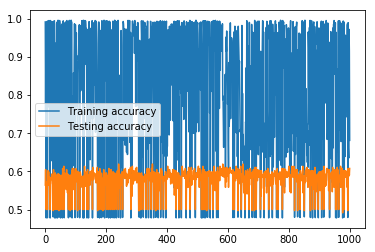

In [42]:
from matplotlib import pyplot as plt 
%matplotlib inline 
x_list =range(len(train_acc_list))

plt.plot(x_list, train_acc_list, label='Training accuracy')
plt.plot(x_list, test_acc_list, label='Testing accuracy')
plt.legend()
plt.show()

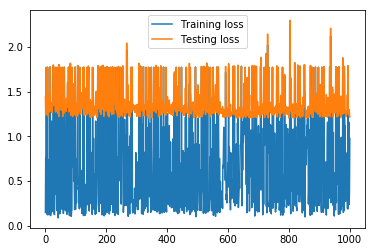

In [43]:
plt.plot(x_list, train_loss_list, label='Training loss')
plt.plot(x_list, test_loss_list, label='Testing loss')
plt.legend()
plt.show()